# Assessment of climate change at near-term (2020-2040) over Northern Europe through internal variability storylines

Analysis codes developped by Aurélien Liné and Christophe Cassou.

# Librairies importation
## Shared libraries importation

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from importlib import reload
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D, mlines
from matplotlib.patches import mpatches, Patch, FancyArrow
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
import pandas as pd
import scipy.stats
import sklearn.linear_model
import time
import xarray as xr

## Personnal libraries importation

In [6]:
import sys
sys.path.append('../LocalPackages/')

In [15]:
import cc
import cc.storylines as ccivs
import cc.plot.maps as ccmps
# import cc.plot.stats as ccpls
import cc.plot.stats as ccplt
import cc.shli.matplotlib as ccmp
import cc.shli.numpy as ccnp
import cc.shli.scipy as ccscp
import cc.stats.stats as ccsts
import cc.tools.time as cctim
import cc.tools.field as ccfld

In [16]:
help(ccivs)

Help on class storylines in module cc.storylines:

class storylines(builtins.object)
 |  storylines(delta='$\\Delta$', confidence=None, exclusion=0.0, colors=None, significance_limit=0.05, permutations=0, prints=False)
 |  
 |  Description ###
 |  
 |  Parameters
 |  ----------
 |  
 |  Examples
 |  --------
 |  
 |  Methods defined here:
 |  
 |  __init__(self, delta='$\\Delta$', confidence=None, exclusion=0.0, colors=None, significance_limit=0.05, permutations=0, prints=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_driver(self, data, name=None)
 |  
 |  add_target(self, data, name=None)
 |  
 |  add_weights(self, data)
 |  
 |  boxplot(self, target=None, bar='mean', box=25, ext=5, outliers=True, extrema=False, figsize=(10, 10), ylabels=None)
 |  
 |  build_storylines(self, exclusion=None, significance_limit=None, permutations=None, significance_print=False)
 |      Ideas and work:
 |       - Remove x_j driver (or suggest it) if abs(cor(x_i

# Paths to data and figures

inDir = ''
figDir = ''

# Analysis parameters

In [7]:
model = ['CNRM-CM6-1']
experiment = ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']
drivers = ['amoc30N', 'nao']
temporality = 'JFM'
targets = [
    'tas_NEU_land',
    'pr_NEU_land',
    'prsn_NEU_land',
    'snc_NEU_land',
    'sfcWind_NEU_land',
    'rsds_NEU_land',
    #'rlds_NEU_land',
    #'huss_NEU_land',
    #'clt_NEU_land',
    #'siconc_-_',
]
date_start = '1900'; date_stop = '2039'
refStr = '1995'; refEnd = '2014'; intStr = '2020'; intEnd = '2039'
anomaly = 'internal variability'
relative = True
zone = [ -12,   41.4,  29,  72.5]
lag = 0
confidence_range = .9
bp_median_mean = 'mean'; bp_box = .5; bp_ext = 1. - confidence_range
significance_limit = .05
confidence = 0.8 # 0.9
weighting_method = None
normalisation_method = None
return_period = [10] #, 50, 100]
extrema = ['min']
show_box = ['NEU']
period_names = ('present-day', 'near-term')
anomaly_name = 'change'
target_year = '2010'
bootstrap = True
n_boot = 1000
subfigure_label = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ', 'g) ', 'h) ', 'i) ', 'j) ', 'k) ']

###targets = ['tas_NEU_land']; experiment = ['piControl']
#targets = ['tas_NEU_land']; experiment = ['hist-ssp245']; refStr = '1850'; refEnd = '1870'; intStr = '1875'; intEnd = '1895'; date_start = '1850'

In [10]:
import matplotlib
matplotlib.rcParams.update({
    'text.usetex': False, # True
    'font.family': 'sans-serif', #"Helvetica",
    #'font.fontname': 'Helvetica',
})
mm = 1./25.4
# Nature figure parameters
## Figure sizes
single_column_width = 89*mm
double_column_width = 183*mm
extended_width = 120*mm
## Font sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 7})
#matplotlib.rc('font', size=5)          # controls default text sizes
#matplotlib.rc('axes', titlesize=5)     # fontsize of the axes title
#matplotlib.rc('axes', labelsize=6)    # fontsize of the x and y labels
#matplotlib.rc('xtick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('ytick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('legend', fontsize=5)    # legend fontsize
#matplotlib.rc('figure', titlesize=8)  # fontsize of the figure title

# Pre-analysis routines

In [11]:
period_length = int(refEnd) - int(refStr) + 1
if int(intEnd) - int(intStr) + 1 != period_length:
    raise 'The two periods do not have the same length!'
period_gap = int(intStr) - int(refEnd) - 1
print(period_length, period_gap)

20 5


In [12]:
import cc.cmip6 as ccmip6
ccmip6 = reload(ccmip6)

delta = r'$\Delta$'
allModels = ['ACCESS-ESM1-5', 'CNRM-CM6-1', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR']
allSSPs = ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']

if not isinstance(extrema, list):
    extrema = [extrema]

saveName = 'storyline'
if anomaly == 'internal variability':
    saveName += 'IV'
elif anomaly == 'super internal variability':
    saveName += 'SIV'
elif anomaly == 'forcing':
    saveName += 'F'
elif anomaly == 'mixed':
    saveName += 'X'
saveName += '_'+'-'.join(drivers) #+'-'.join(variable)+'_'
if normalisation_method == 'std':
    saveName += '_std'
    delta = r'$\tilde{\Delta}$'
if experiment == ['piControl']:
    saveName += '_length'+str(period_length)+'yr-gap'+str(period_gap)+'yr'
else:
    #saveName += '_ref'+refStr+refEnd+'-int'+intStr+intEnd
    saveName += '_'+intStr+intEnd+'-ref'+refStr+refEnd
saveName += '_'+temporality#+'_'+region+mask_land_sea
if model is None or set(model).intersection(set(allModels)) == set(allModels):
    saveName += '_allModels'
    model = allModels
else:
    model.sort()
    saveName += '_'+'-'.join([ccmip6.scenario_mip_dict[m]['short_name'] for m in model])
if experiment is None or set(experiment).intersection(set(allSSPs)) == set(allSSPs):
    saveName += '_allSSP'
else:
    saveName += '_'+'-'.join(experiment).replace('hist-', '').replace('-ssp', '-')
#if scale:
#    saveName += '_scaled'
#if normalize:
#    saveName += '_normalised'
#elif residual:
#    saveName += '_residual'
#saveName += '_'+'-'.join(variable)
saveName

'storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP'

In [13]:
saveDir = '/data/scratch/globc/line/Storylines/'+saveName+'/'
dataDir = saveDir+'Data/'
figDir = saveDir+'Figures/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)
figExt = '.pdf' # pdf eps

In [14]:
print(
    'scp -r scylla.cerfacs.fr:'
    +figDir+
    '* Google\ Drive/Mon\ Drive/Cerfacs/Previntep2030/Thesis/Figures/'
    +' && '+
    'cp Google\ Drive/Mon\ Drive/Cerfacs/Previntep2030/Thesis/Figures/'
    +saveName+
    '* Dropbox/Applications/Overleaf/previntep2030/these/figures/')

scp -r scylla.cerfacs.fr:/data/scratch/globc/line/Storylines/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/Figures/* Google\ Drive/Mon\ Drive/Cerfacs/Previntep2030/Thesis/Figures/ && cp Google\ Drive/Mon\ Drive/Cerfacs/Previntep2030/Thesis/Figures/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP* Dropbox/Applications/Overleaf/previntep2030/these/figures/


In [15]:
ensemble_name = ['Mega\nensemble']
if len(model) == 1:
    if model == ['CNRM-CM6-1']:
        ensemble_name = ['CNRM-GE']
    else:
        ensemble_name = model # ['Large-ensemble']
elif set(model).intersection(set(allModels)) == set(allModels) and set(experiment).intersection(set(allSSPs)) == set(allSSPs):
    ensemble_name = ['CMIP-ME']
ensemble_name

['CNRM-GE']

In [16]:
target_dict = dict()

def update_target_dict(target_dict, targets):
    for _target in targets:
        _variable, _region, _ = _target.split('_')
        if _variable not in target_dict:
            if _variable == 'tas':
                target_dict[_variable] = 'T'
            elif _variable == 'prlq':
                target_dict[_variable] = 'rain'
            elif _variable == 'prsn':
                target_dict[_variable] = 'snowfall'
            elif _variable == 'sfcWind':
                target_dict[_variable] = 'wind'
            elif _variable == 'siconc':
                target_dict[_variable] = 'sea ice'
            else:
                target_dict[_variable] = _variable
        if _target not in target_dict:
            target_dict[_target] = target_dict[_variable]+'_{'+_region+'}'
    return target_dict

target_dict = update_target_dict(target_dict, targets)
target_dict

{'tas': 'T',
 'tas_NEU_land': 'T_{NEU}',
 'pr': 'pr',
 'pr_NEU_land': 'pr_{NEU}',
 'prsn': 'snowfall',
 'prsn_NEU_land': 'snowfall_{NEU}',
 'snc': 'snc',
 'snc_NEU_land': 'snc_{NEU}',
 'sfcWind': 'wind',
 'sfcWind_NEU_land': 'wind_{NEU}',
 'rsds': 'rsds',
 'rsds_NEU_land': 'rsds_{NEU}'}

# Drivers

## Loading data

In [18]:
reload(cctim)

begin = time.time()
list_of_files = os.listdir('/data/home/globc/line/scratch/Data/Computed/')
list_of_files.sort()
loaded_files = list()
driver_data = xr.Dataset(); driver_ano = xr.Dataset()

_anomaly = 'forcing' if anomaly == 'mixed' else anomaly
_anomaly = 'internal variability' if anomaly == 'super internal variability' else anomaly

for i, _driver in enumerate(drivers):
    if experiment == ['piControl']:
        if _driver == 'amvDemeaned':
            _driver = 'amvLinear'

    _name = _driver.upper()
    _prefix = temporality+'_'
    _lag = lag

    if _driver == 'amoc30N':
        _name = 'AMOC' # 'AMOC$_{30N}$'
        _prefix = 'yr_'
    elif _driver == 'amvLinear':
        _name = 'AMV'
        _prefix = 'yr_'
    elif _driver == 'amvLinearProjected':
        _name = 'AMV$^P$'
        _prefix = 'yr_'
    elif _driver == 'amvTrshea':
        _name = 'AMV$_{TrShea}$'
        _prefix = 'yr_'
    elif _driver == 'amvTrsheaProjected':
        _name = 'AMV$_{TrShea}^P$'
        _prefix = 'yr_'
    elif _driver == 'amvDemeaned':
        _name = 'AMV$_d$'
        _prefix = 'yr_'
    elif _driver == 'amvDemeanedProjected':
        _name = 'AMV$_d^P$'
        _prefix = 'yr_'
        #_lag = 10
    elif _driver == 'naoProjected':
        _name = 'NAO$^P$'
    elif _driver == 'eapProjected':
        _name = 'EAP$^P$'
    elif _driver == 'blProjected':
        _name = 'BL$^P$'
    elif _driver == 'nino34':
        _name = 'ENSO' #'El Niño'
        _prefix = 'yr_'

    list_data = list(); list_ano = list()
    for _model in model:
        if experiment != ['piControl']:
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            _experiment = list(set(_experiment).intersection(set(cc.cmip6.scenario_mip_dict[_model]['experiment'])))
        else:
            _experiment = ['piControl']
        for _experiment_id in _experiment:
            if _experiment_id in ('piControl'):
                _n_max = None; _date_start = None; _date_stop = None; _refStr = None; file_year_start = ''
            else:
                _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr; file_year_start = '1850'
            tmp = list(); tmp_seasons = list()
            print(_driver+'_'+_prefix, _model, _experiment_id, file_year_start)
            for file in list_of_files:
                if _driver+'_'+_prefix in file and _model in file and _experiment_id in file and file_year_start in file:
                    print('/data/home/globc/line/scratch/Data/Computed/'+file)
                    tmp.append(xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+file).get(_driver).sel(time=slice(_date_start, _date_stop)))
                    tmp[-1] = tmp[-1].sortby(tmp[-1].time)
                    if 'member' not in tmp[-1].coords:
                        tmp[-1] = tmp[-1].assign_coords({'member':_model+'_'+_experiment_id+'_'+_file.split('_')[2]})
                    if np.isnan(tmp[-1]).any():
                        print(tmp[-1])
                    _file = '_'.join(file.split('_')[2:])
                    if _file not in loaded_files:
                        loaded_files.append(_file)
            tmp = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
            #tmp = cc.get_season(tmp.resample(time='M').mean(dim = 'time', keep_attrs = True), temporality)
            tmp.name = _name
            if _experiment_id == 'piControl':
                tmp = tmp.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp.time), freq = 'Y')})
            else:
                tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
            list_data.append(tmp)
            list_ano.append(cctim.get_anomalies(
                data=list_data[-1], n_max=_n_max, calcul=_anomaly, relative=relative,
                start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))

    tmp_data = list_data[0] if len(list_data) == 1 else xr.concat(list_data, dim='member')
    tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')
    if i != 0:
        if experiment != ['piControl']:
            _common_members = list(set(driver_data.member.values).intersection(set(tmp_data.member.values))); _common_members.sort()
            tmp_data = tmp_data.sel(member = _common_members)
            driver_data = driver_data.sel(member = _common_members)
        _common_members = list(set(driver_ano.member.values).intersection(set(tmp_ano.member.values))); _common_members.sort()
        tmp_ano = tmp_ano.sel(member = _common_members)
        driver_ano = driver_ano.sel(member = _common_members)

    # Data used in the storyline analysis
    driver_data = driver_data.assign({_name: tmp_data})
    if experiment != ['piControl']:
        driver_data = driver_data.sortby('member')
    driver_ano = driver_ano.assign({_name: tmp_ano}).sortby('member')

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')
driver_ano

amoc30N_yr_ CNRM-CM6-1 hist-ssp245 1850
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r10i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r11i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r12i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r13i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r14i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r15i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r16i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r17i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r18i1p1f2_index_1850-2039.

/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r3i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r4i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r5i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r6i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r7i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r8i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r9i1p1f2_index_1850-2039.nc
amoc30N_yr_ CNRM-CM6-1 hist-ssp585 1850
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r10i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r11i1p1f2_index_1850-2039.nc
/dat

/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp126_r5i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp126_r6i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp126_r7i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp126_r8i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp126_r9i1p1f2_index_1850-2039.nc
nao_JFM_ CNRM-CM6-1 hist-ssp370 1850
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp370_r10i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp370_r11i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp370_r12i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/nao_JFM_CNRM-CM6-1_hist-ssp370_r13i1p1f2_index_1850-2039.nc
/data/home/globc/line/scratch/Da

<xarray.Dataset>
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...
Data variables:
    AMOC     (member) float32 -2.617 -1.843 -2.866 ... 0.8565 -1.584 -1.461
    NAO      (member) float32 0.8252 -0.4051 0.3413 ... -0.08414 0.1208 0.06652

In [19]:
driver_data

<xarray.Dataset>
Dimensions:  (member: 120, time: 140)
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...
  * time     (time) object 1900-12-31 00:00:00 ... 2039-12-31 00:00:00
Data variables:
    AMOC     (member, time) float32 17.34 18.05 19.66 ... 13.22 15.07 14.73
    NAO      (member, time) float32 -0.6892 -2.328 1.777 ... 0.8142 -1.078

In [20]:
if experiment == ['piControl']:
    for _member in driver_data.member.values:
        print(_member)
        print('AMV', len(driver_data['AMV'].sel(member=_member).dropna(dim='time', how='any')))
        print('NAO', len(driver_data['NAO'].sel(member=_member).dropna(dim='time', how='any')))
    for _member in driver_data.member.values:
        plt.plot(driver_data['AMV'].sel(member=_member).dropna(dim='time', how='any'), label=_member)
    plt.legend()
    plt.show()
    for _member in driver_data.member.values:
        plt.plot(driver_data['NAO'].sel(member=_member).dropna(dim='time', how='any'))

In [21]:
driver_ano

<xarray.Dataset>
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...
Data variables:
    AMOC     (member) float32 -2.617 -1.843 -2.866 ... 0.8565 -1.584 -1.461
    NAO      (member) float32 0.8252 -0.4051 0.3413 ... -0.08414 0.1208 0.06652

In [22]:
members = list(driver_ano.member.values) #.sort()
members.sort()
members_dict = cc.cmip6.get_members_dict(members)
members_dict

{'CNRM-CM6-1': {'hist-ssp126': ['CNRM-CM6-1_hist-ssp126_r10i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r11i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r12i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r13i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r14i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r15i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r16i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r17i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r18i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r19i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r1i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r20i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r21i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r22i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r23i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r24i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r25i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r26i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r27i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r28i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r29i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r2i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r30i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r3i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r4i1p1f2',


In [23]:
source_dict = {}
if len(members_dict) == 1:
    source_dict[model[0]] = model[0]
else:
    for _model in members_dict:
        if len(members_dict[_model]) == 1:
            source_dict[_model] = cc.cmip6.scenario_mip_dict[_model]['short_name'] +'-LE'
        else:
            source_dict[_model] = cc.cmip6.scenario_mip_dict[_model]['short_name'] +'-GE'
source_dict

{'CNRM-CM6-1': 'CNRM-CM6-1'}

## Computing drivers' weights

In [24]:
if weighting_method == 'model_scenario':
    weight = list()
    for _member in driver_ano.member.values:
        _model, _scenario, _ = _member.split('_')
        _N = len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
elif weighting_method == 'model':
    weight = list()
    for _member in driver_ano.member.values:
        _model, _, _ = _member.split('_')
        _N = 0
        for _scenario in members_dict[_model].keys():
            _N += len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
elif weighting_method == 'scenario':
    weight = list()
    for _member in driver_ano.member.values:
        _, _scenario, _ = _member.split('_')
        _N = 0
        for _model in members_dict.keys():
            _N += len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
else:
    weight = None

if weight is None:
    da_weight = xr.ones_like(driver_ano.member, dtype='float').sortby('member')
else:
    da_weight = xr.DataArray(weight, dims = ['member'], coords = {'member': driver_ano.member.values}).sortby('member')
da_weight

<xarray.DataArray 'member' (member: 120)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...

{'CNRM-CM6-1': 'o'} {'CNRM-CM6-1': '**'}


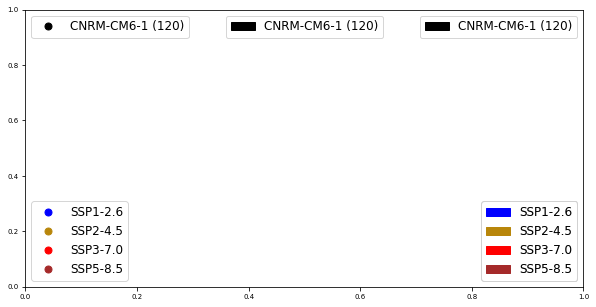

In [25]:
ccmip6 = reload(ccmip6)

ms_size = 7 # 10

if len(model) == 1:
    box_fill = True
    list_of_markers = ['o']
    list_of_hatches = [None]
else:
    box_fill = False
    list_of_markers = ['o', '^', 's', '*', 'p', 'D', 'X']
    list_of_hatches = ['o', '*', 'O', '.', '-', '/', '\\', '///', '\\\\'] # None

model_markers = dict(); model_legend_point = list()
model_hatches = dict(); model_legend_box = list()
model_colors = dict(); model_legend_color = list()
experiments = list()

for iM, m in enumerate(model):
    _total = str(len([_member for _member in members if m in _member]))
    if len(model) == 1:
        model_markers[m] = 'o'
        model_legend_point.append(mlines.Line2D([], [], color = 'k', marker = 'o', ms = ms_size, linestyle = '', label = source_dict[m]+' ('+_total+')'))
        model_colors[m] = 'k'
        model_legend_color.append(mpatches.Patch(color = 'k', fill = True, label = source_dict[m]+' ('+_total+')'))
    else:
        model_markers[m] = ccmip6.scenario_mip_dict[m]['marker']
        model_legend_point.append(mlines.Line2D([], [], color = 'k', marker = model_markers[m], ms = ms_size, linestyle = '', label = source_dict[m]+' ('+_total+')'))
        model_colors[m] = ccmip6.scenario_mip_dict[m]['color']
        model_legend_color.append(mpatches.Patch(color = model_colors[m], fill = True, label = source_dict[m]+' ('+_total+')'))
    model_hatches[m] = ccmip6.scenario_mip_dict[m]['hatch']
    model_legend_box.append(mpatches.Patch(color = 'k', fill = box_fill, hatch = model_hatches[m], label = source_dict[m]+' ('+_total+')'))
    #model_colors[m] = ccmip6.scenario_mip_dict[m]['color']
    #model_legend_color.append(mpatches.Patch(color = model_colors[m], fill = True, label = source_dict[m]+' ('+_total+')'))
    for _experiment in members_dict[m].keys():
        if _experiment not in experiments:
            experiments.append(_experiment)
    experiments.sort()

experiment_colors = dict()
experiment_labels = dict()
experiment_legend_point = list(); experiment_legend_box = list()
for _experiment in experiments:
    experiment_colors[_experiment] = cc.cmip6.experiment_dict[_experiment]['color']
    experiment_labels[_experiment] = cc.cmip6.experiment_dict[_experiment]['name']
    experiment_legend_point.append(mlines.Line2D([], [], color = experiment_colors[_experiment],
                                                 marker = 'o', ms = ms_size, linestyle = '',
                                                 label = experiment_labels[_experiment]))
    experiment_legend_box.append(mpatches.Patch(color = experiment_colors[_experiment], fill = True,
                                                label = experiment_labels[_experiment]))

fig, ax = plt.subplots(figsize = (10, 5))
lgd = plt.legend(handles = model_legend_color, loc='upper center', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = model_legend_point, loc='upper left', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = model_legend_box, loc='upper right', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = experiment_legend_point, loc='lower left', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = experiment_legend_box, loc='lower right', fontsize=12); ax.add_artist(lgd)

print(model_markers, model_hatches)

In [26]:
def color_unsignificant_red(val, significance_limit):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for significant
    pvalues, black otherwise.
    """
    color = 'red' if val > significance_limit else 'black'
    return 'color: %s' % color

h0 = {'T-test': 'Averages are significantly different.',
      'F-test': 'Sample variances are significantly different.'}

from IPython.display import display, HTML

## Drivers' analysis

In [27]:
for _driver in driver_ano:
    _int_data = float(driver_data[_driver].sel(time=slice(intStr, intEnd)).mean())
    _ref_data = float(driver_data[_driver].sel(time=slice(refStr, refEnd)).mean())
    print(_driver, _int_data, _ref_data, _int_data - _ref_data, (_int_data - _ref_data) / _ref_data * 100.)
    print()

AMOC 14.531717300415039 16.570219039916992 -2.038501739501953 -12.302201525467373

NAO 0.13375160098075867 0.054268576204776764 0.0794830247759819 146.46233664959453



In [28]:
for _driver in driver_ano:
    print(_driver)
    print(driver_ano[_driver].weighted(da_weight).mean().values)
    _neg = np.sum(driver_ano[_driver].values <= 0.)
    _pos = np.sum(driver_ano[_driver].values >= 0.)
    _tot = len(driver_ano[_driver].values)
    print('Negative anomalies:', _neg, '({0:.1f}%)'.format(_neg/_tot*100.))
    print('Positive anomalies:', _pos, '({0:.1f}%)'.format(_pos/_tot*100.))
    print()
#print('A weighted method shoud be applied if multiple models used... (sum of weights)')

AMOC
-2.038500104212047
Negative anomalies: 107 (89.2%)
Positive anomalies: 13 (10.8%)

NAO
0.07948302033085687
Negative anomalies: 49 (40.8%)
Positive anomalies: 71 (59.2%)



In [29]:
ccscp = reload(ccscp)

_variable = 'toto'

ds_corr_test = xr.Dataset()
_corr_store1 = list()
for _driver1 in driver_ano:
    _corr_store2 = list()
    for _driver2 in driver_ano:
        _corr = ccscp.pearson(driver_ano.get(_driver1), driver_ano.get(_driver2), weights = da_weight)
        _corr_store2.append(_corr)

    _corr_store1.append(_corr_store2)

ds_corr_test = ds_corr_test.assign(
    {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                            dims=['test', 'r', 'c'],
                            coords={'test': ['Correlation', 'p-value'], 'r':driver_ano.data_vars, 'c':driver_ano.data_vars})})
for _variable in ds_corr_test:
    #print('Null hypothesis: '+h0[str(_test.values)])
    print('Null hypothesis: "The correlation is not significative."')
    display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())#.applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))
    display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

if len(model) != 1:
    for _model in model:
        print(_model)
        ds_corr_test = xr.Dataset()
        _corr_store1 = list()
        for _driver1 in driver_ano:
            _corr_store2 = list()
            for _driver2 in driver_ano:
                a = list()
                b = list()
                w = list()
                for _experiment in members_dict[_model].keys():
                    a = a + list(driver_ano.get(_driver1).sel(member = members_dict[_model][_experiment]).values)
                    b = b + list(driver_ano.get(_driver2).sel(member = members_dict[_model][_experiment]).values)
                    w = w + list(da_weight.sel(member = members_dict[_model][_experiment]).values)
                _corr = ccscp.pearson(a, b, weights = w)
                _corr_store2.append(_corr)

            _corr_store1.append(_corr_store2)

        ds_corr_test = ds_corr_test.assign(
            {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                                    dims=['test', 'r', 'c'],
                                    coords={'test': ['Correlation', 'p-value'], 'r':driver_ano.data_vars, 'c':driver_ano.data_vars})})
        for _variable in ds_corr_test:
            #print('Null hypothesis: '+h0[str(_test.values)])
            print('Null hypothesis: "The correlation is not significative."')
            display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())#.applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))
            display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))


Null hypothesis: "The correlation is not significative."


c         AMOC       NAO
r                       
AMOC  1.000000 -0.410523
NAO  -0.410523  1.000000

In [30]:
driver_ano_std = xr.Dataset()
for _driver in driver_ano:
    driver_ano_std = driver_ano_std.assign({_driver: cc.cmip6.standardisation(driver_ano.get(_driver))})
driver_ano_std

<xarray.Dataset>
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...
Data variables:
    AMOC     (member) float32 -0.3673 0.1366 -0.5295 ... 1.857 0.2819 0.3617
    NAO      (member) float32 1.952 -1.289 0.6772 ... -0.5491 0.06486 -0.09779

In [31]:
ccscp = reload(ccscp)

_variable = 'toto'

ds_corr_test = xr.Dataset()
_corr_store1 = list()
for _driver1 in driver_ano_std:
    _corr_store2 = list()
    for _driver2 in driver_ano_std:
        _corr = ccscp.pearson(driver_ano_std.get(_driver1), driver_ano_std.get(_driver2), weights = da_weight)
        _corr_store2.append(_corr)

    _corr_store1.append(_corr_store2)

ds_corr_test = ds_corr_test.assign(
    {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                            dims=['test', 'r', 'c'],
                            coords={'test': ['Correlation', 'p-value'], 'r':driver_ano_std.data_vars, 'c':driver_ano_std.data_vars})})
for _variable in ds_corr_test:
    #print('Null hypothesis: '+h0[str(_test.values)])
    print('Null hypothesis: "The correlation is not significative."')
    display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())#.applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))
    display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

if len(model) != 1:
    for _model in model:
        print(_model)
        ds_corr_test = xr.Dataset()
        _corr_store1 = list()
        for _driver1 in driver_ano_std:
            _corr_store2 = list()
            for _driver2 in driver_ano_std:
                a = list()
                b = list()
                w = list()
                for _experiment in members_dict[_model].keys():
                    a = a + list(driver_ano_std.get(_driver1).sel(member = members_dict[_model][_experiment]).values)
                    b = b + list(driver_ano_std.get(_driver2).sel(member = members_dict[_model][_experiment]).values)
                    w = w + list(da_weight.sel(member = members_dict[_model][_experiment]).values)
                _corr = ccscp.pearson(a, b, weights = w)
                _corr_store2.append(_corr)

            _corr_store1.append(_corr_store2)

        ds_corr_test = ds_corr_test.assign(
            {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                                    dims=['test', 'r', 'c'],
                                    coords={'test': ['Correlation', 'p-value'], 'r':driver_ano_std.data_vars, 'c':driver_ano_std.data_vars})})
        for _variable in ds_corr_test:
            #print('Null hypothesis: '+h0[str(_test.values)])
            print('Null hypothesis: "The correlation is not significative."')
            display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())#.applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))
            display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))


Null hypothesis: "The correlation is not significative."


c         AMOC       NAO
r                       
AMOC  1.000000 -0.414964
NAO  -0.414964  1.000000

In [32]:
ccivs = reload(ccivs)

if normalisation_method == 'std':
    main_driver_ano = driver_ano_std
    delta_print=r'$\tilde{\Delta}$'
else:
    main_driver_ano = driver_ano
    delta_print=r'$\Delta$'

begin = time.time()
story = ccivs.storylines(confidence=confidence, prints=True, delta=delta_print)
for _driver in main_driver_ano.data_vars:
    story.add_driver(main_driver_ano.get(_driver))
#for _target in target_ano_std.data_vars:
#    story.add_target(target_ano_std.get(_target))
story.add_weights(da_weight)
story.build_storylines()
story_legend_color = list(); story_legend_point = list(); story_legend_cross = list()
for i, _sto in enumerate(story.labels):
    story_legend_color.append(mpatches.Patch(color = story.colors[i], label = _sto))
    story_legend_point.append(mlines.Line2D([], [], color = story.colors[i], marker = 'o', ms = 10, linestyle = '', label = _sto))
    story_legend_cross.append(mlines.Line2D([], [], color = story.colors[i], marker = 'X', ms = 12, linestyle = '', mec='w', label = story.stories[i]))
end = time.time()
print('Runtime of the storyline classification is', '{0:.1f}'.format(end - begin), 's')

'''
print()
print(saveDir)
if os.path.exists(saveDir+saveName+'.nc'):
    os.remove(saveDir+saveName+'.nc')
story.data.to_netcdf(saveDir+saveName+'.nc')
for i, _sto in enumerate(story.stories):
    if os.path.exists(saveDir+saveName+'-'+_sto+str(i+1)+'.nc'):
        os.remove(saveDir+saveName+'-'+_sto+str(i+1)+'.nc')
    story.data.sel(member=story.families[_sto]['label']).to_netcdf(saveDir+saveName+'-'+_sto+str(i+1)+'.nc')
print('Data saved.')
'''

story

[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 1.74676381 -2.23399109]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.0891304   1.14857371]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.59282228  0.63796626]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.22163975  0.65019826]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-1.05850877 -0.20697535]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.31101622 -0.68213018]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.02697059  0.06946166]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 2.87588234 -0.21834379]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.35505799 -0.20379005]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.15283653 -1.09313014]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 0.62413338 -1.2244187 ]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-1.96994499  0.94565591]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 0.56253265 -1.49520287]

[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.60292569  0.46162933]

Runtime of the storyline classification is 0.8 s


In [33]:
story.outputs.storindex

<xarray.DataArray 'storindex' (story: 4, driver: 2)>
array([[-0.54917116,  0.43963768],
       [ 0.26531276, -0.47763294],
       [-4.34231297,  0.63659898],
       [-3.52782905, -0.28067164]])
Coordinates:
  * story    (story) <U2 'AN' 'An' 'aN' 'an'
  * driver   (driver) <U4 'AMOC' 'NAO'

In [34]:
print('{:<13}'.format('')+' '.join(story.stories))
for _experiment in experiments:
    print('{:<12}'.format(_experiment)+''.join(['{:>5}'.format(len(
        [_member for _member in story.families[_sto]['label'] if _experiment in _member]
    )) for _sto in story.stories]))
print('{:<12}'.format('Total')+''.join(['{:>5}'.format(len(
    story.families[_sto]['label'])) for _sto in story.stories]))

             AN An aN an
hist-ssp126     5   10    7    8
hist-ssp245    11    6    7    6
hist-ssp370     5   10    6    9
hist-ssp585     8    6    6   10
Total          29   32   26   33


In [35]:
members_story_colored = xr.concat(
    [xr.DataArray(np.full(len(story.families[_sto]['label']), story.colors[i]), dims='member', coords={'member':story.families[_sto]['label']}) for i, _sto in enumerate(story.families)],
    dim='member'
).sortby('member')
members_story_colored

<xarray.DataArray (member: 120)>
array(['#EE7733', '#33BBEE', '#009988', '#EE3377', '#EE7733', '#009988',
       '#33BBEE', '#009988', '#EE7733', '#EE3377', '#009988', '#EE3377',
       '#EE3377', '#33BBEE', '#EE7733', '#EE3377', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#009988', '#EE3377', '#009988',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#EE3377', '#EE3377',
       '#EE7733', '#EE3377', '#009988', '#EE7733', '#009988', '#009988',
       '#33BBEE', '#009988', '#EE7733', '#EE3377', '#009988', '#EE7733',
       '#EE7733', '#009988', '#EE7733', '#EE3377', '#009988', '#EE7733',
       '#EE7733', '#33BBEE', '#EE7733', '#33BBEE', '#EE3377', '#EE7733',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#EE7733', '#EE3377',
       '#EE7733', '#EE3377', '#33BBEE', '#EE3377', '#EE7733', '#009988',
       '#009988', '#33BBEE', '#EE7733', '#EE3377', '#009988', '#EE3377',
       '#EE3377', '#33BBEE', '#009988', '#EE3377', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#33BBEE', '#EE3377', '#33BBEE',
       '#33BBEE', '#33BBEE', '#009988', '#EE7733', '#EE3377', '#EE3377',
       '#EE7733', '#EE3377', '#33BBEE', '#EE7733', '#EE7733', '#009988',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#009988', '#EE7733',
       '#EE3377', '#33BBEE', '#009988', '#EE7733', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#33BBEE', '#EE3377', '#33BBEE',
       '#009988', '#33BBEE', '#009988', '#EE3377', '#EE7733', '#EE7733'],
      dtype='<U7')
Coordinates:
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...

Significant correlation between reference and future averages of AMOC: 0.53 (pvalue=0.00)
Significant correlation between reference average and future anomaly of AMOC: -0.75 (pvalue=0.00)
$\Delta$AMOC = 8.6 -0.6 * AMOC (56% of variance explained)

Significant correlation between reference and future averages of NAO: -0.30 (pvalue=0.00)
Significant correlation between reference average and future anomaly of NAO: -0.84 (pvalue=0.00)
$\Delta$NAO = 0.1 -1.3 * NAO (70% of variance explained)



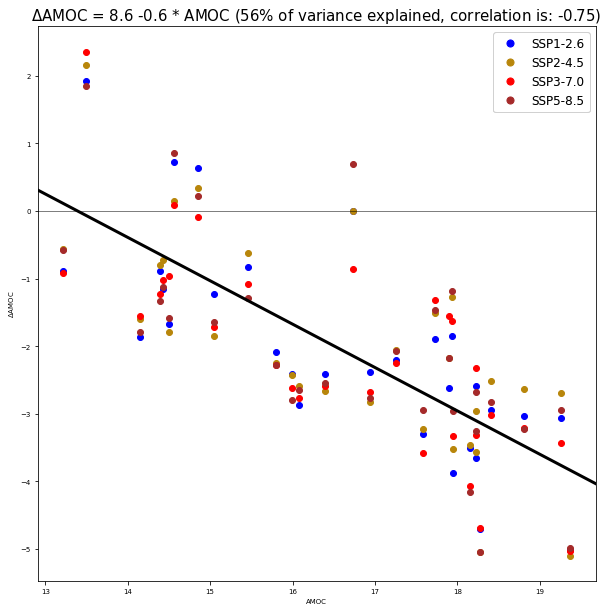

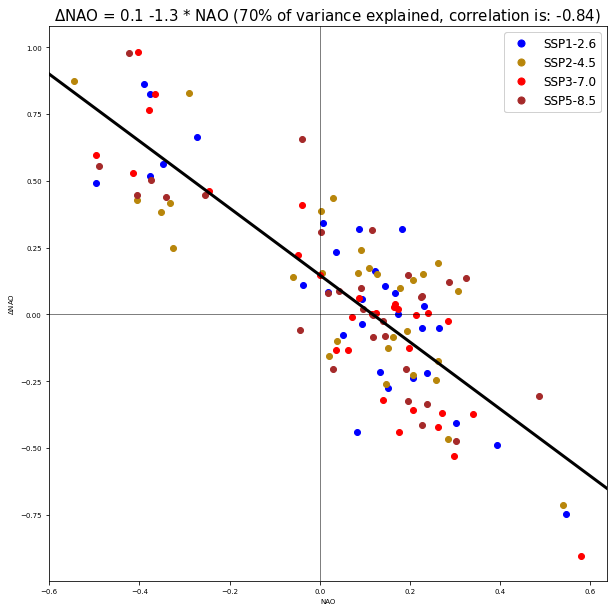

In [36]:
if experiment != ['piControl']:
    if anomaly != 'forcing':
        for _driver in driver_data:
            _ref_driver = driver_data.get(_driver).sel(time=slice(refStr, refEnd)).mean(dim='time')
            _int_driver = driver_data.get(_driver).sel(time=slice(intStr, intEnd)).mean(dim='time')
            _delta_driver = _int_driver - _ref_driver
            if normalisation_method == 'std':
                _ref_driver = cc.cmip6.standardisation(_ref_driver); _int_driver = cc.cmip6.standardisation(_int_driver); _delta_driver = cc.cmip6.standardisation(_delta_driver)
            _statistic, _pvalue = ccscp.pearson(_ref_driver, _int_driver, weights=da_weight)#.sel(member=_ref_driver.member))
            if _pvalue < significance_limit:
                print('Significant correlation between reference and future averages of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
            _statistic, _pvalue = ccscp.pearson(_ref_driver, _delta_driver, weights=da_weight.sel(member=_ref_driver.member))
            if _pvalue < significance_limit:
                print('Significant correlation between reference average and future anomaly of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
            _X, _Y = np.array([_ref_driver.values]).T, _delta_driver
            _reg = sklearn.linear_model.LinearRegression()
            _reg.fit(_X, _Y, da_weight)
            print(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, da_weight)*100.)+'% of variance explained)')
            print()
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes()
            ax.set_xlabel(_driver); ax.set_ylabel(delta_print+_driver)
            for _model in members_dict.keys():
                for _experiment in members_dict[_model].keys():
                    for _member in members_dict[_model][_experiment]:
                        plt.scatter(_ref_driver.sel(member=_member),
                                    _delta_driver.sel(member=_member),
                                    c = experiment_colors[_experiment], marker = model_markers[_model])
            xMin, xMax = ax.get_xlim(); ax.set_xlim(xMin, xMax); yMin, yMax = ax.get_ylim()
            ax.plot([xMin, xMax], _reg.intercept_+_reg.coef_[0]*np.array([xMin, xMax]), 'k-', lw=3)
            if xMin < 0. and xMax > 0.:
                ax.axvline(x=0, color='k', lw=.5)
            if yMin < 0. and yMax > 0.:
                ax.axhline(y=0, color='k', lw=.5)
            if len(model) != 1:
                lgd = ax.legend(handles = model_legend_point, fontsize=12) #, loc='upper right')
                ax.add_artist(lgd)
            lgd = ax.legend(handles = experiment_legend_point, fontsize=12) #, loc='lower left')
            ax.add_artist(lgd)
            ax.set_title(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, da_weight)*100.)+'% of variance explained, correlation is: {0:.2f})'.format(_statistic), fontsize=15)
            plt.savefig(figDir+saveName+'-'+_driver+'_delta-'+_driver+'.pdf', transparent=True)



In [37]:
'''
if anomaly != 'forcing':
    for _driver in driver_data:
        _ref_driver = list(); _int_driver = list(); _delta_driver = list(); _member_driver = list(); _weight_driver = list()
        for t in range(1900, 1995 - 2*period_length - period_gap + 1):
            #print(str(t)+'-'+str(t+period_length-1)+' - '+str(t+period_length+period_gap)+'-'+str(t+2*period_length+period_gap-1))
            _ref_driver = _ref_driver + list(driver_data.get(_driver).sel(time=slice(str(t), str(t+period_length-1))).mean(dim='time').values)
            _int_driver = _int_driver + list(driver_data.get(_driver).sel(time=slice(str(t+period_length+period_gap), str(t+2*period_length+period_gap-1))).mean(dim='time').values)
            _member_driver = _member_driver + [_member+'-'+str(t) for _member in list(driver_data.get(_driver).member.values)]
            _weight_driver = _weight_driver + list(da_weight.values)
        _ref_driver = xr.DataArray(_ref_driver, dims=['member'], coords={'member':_member_driver})
        _int_driver = xr.DataArray(_int_driver, dims=['member'], coords={'member':_member_driver})
        _weight_driver = xr.DataArray(_weight_driver, dims=['member'], coords={'member':_member_driver})
        _delta_driver = _int_driver - _ref_driver
        if normalisation_method == 'std':
            _ref_driver = cc.cmip6.standardisation(_ref_driver); _int_driver = cc.cmip6.standardisation(_int_driver); _delta_driver = cc.cmip6.standardisation(_delta_driver)
        _statistic, _pvalue = ccscp.pearson(_ref_driver, _int_driver, weights=_weight_driver)#.sel(member=_ref_driver.member))
        if _pvalue < significance_limit:
            print('Significant correlation between reference and future averages of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
        _statistic, _pvalue = ccscp.pearson(_ref_driver, _delta_driver, weights=_weight_driver.sel(member=_ref_driver.member))
        if _pvalue < significance_limit:
            print('Significant correlation between reference average and future anomaly of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
        _X, _Y = np.array([_ref_driver.values]).T, _delta_driver
        _reg = sklearn.linear_model.LinearRegression()
        _reg.fit(_X, _Y, _weight_driver)
        print(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, _weight_driver)*100.)+'% of variance explained)')
        print()
        if len(_member_driver) < 1000:
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes()
            ax.set_xlabel(_driver); ax.set_ylabel(delta_print+_driver)
            _dict_driver = cc.cmip6.get_members_dict(_member_driver)
            for _model in _dict_driver.keys():
                for _experiment in _dict_driver[_model].keys():
                    for _member in _dict_driver[_model][_experiment]:
                        plt.scatter(_ref_driver.sel(member=_member),
                                    _delta_driver.sel(member=_member),
                                    c = experiment_colors[_experiment], marker = model_markers[_model])
            xMin, xMax = ax.get_xlim(); ax.set_xlim(xMin, xMax); yMin, yMax = ax.get_ylim()
            ax.plot([xMin, xMax], _reg.intercept_+_reg.coef_[0]*np.array([xMin, xMax]), 'k-', lw=3)
            if xMin < 0. and xMax > 0.:
                ax.axvline(x=0, color='k', lw=.5)
            if yMin < 0. and yMax > 0.:
                ax.axhline(y=0, color='k', lw=.5)
            if len(model) != 1:
                lgd = ax.legend(handles = model_legend_point, fontsize=12) #, loc='upper right')
                ax.add_artist(lgd)
            lgd = ax.legend(handles = experiment_legend_point, fontsize=12) #, loc='lower left')
            ax.add_artist(lgd)
            ax.set_title(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, da_weight)*100.)+'% of variance explained, correlation is: {0:.2f})'.format(_statistic), fontsize=15)
            #plt.savefig(figDir+saveName+'-'+_driver+'_delta-'+_driver+'.pdf', transparent=True)

'''
print()

In [38]:
if experiment != ['piControl']:
    if anomaly != 'forcing':
        for _driver in driver_data:
            _ref_driver = list(); _int_driver = list(); _delta_driver = list(); _member_driver = list(); _weight_driver = list()
            for t in range(1900, 1995 - 2*period_length - period_gap + 1):
                #print(str(t)+'-'+str(t+period_length-1)+' - '+str(t+period_length+period_gap)+'-'+str(t+2*period_length+period_gap-1))
                _tmp_ref = driver_data.get(_driver).sel(time=slice(str(t), str(t+period_length-1))).mean(dim='time')
                _ref_driver = _ref_driver + list(cc.cmip6.standardisation(_tmp_ref).values if normalisation_method == 'std' else _tmp_ref.values)
                _tmp_int = driver_data.get(_driver).sel(time=slice(str(t+period_length+period_gap), str(t+2*period_length+period_gap-1))).mean(dim='time')
                _int_driver = _int_driver + list(cc.cmip6.standardisation(_tmp_int).values if normalisation_method == 'std' else _tmp_int.values)
                _tmp_delta = _tmp_int - _tmp_ref
                _delta_driver = _delta_driver + list(cc.cmip6.standardisation(_tmp_delta).values if normalisation_method == 'std' else _tmp_delta.values)
                _member_driver = _member_driver + [_member+'-'+str(t) for _member in list(driver_data.get(_driver).member.values)]
                _weight_driver = _weight_driver + list(da_weight.values)
            _ref_driver = xr.DataArray(_ref_driver, dims=['member'], coords={'member':_member_driver})
            _int_driver = xr.DataArray(_int_driver, dims=['member'], coords={'member':_member_driver})
            _weight_driver = xr.DataArray(_weight_driver, dims=['member'], coords={'member':_member_driver})
            _delta_driver = xr.DataArray(_delta_driver, dims=['member'], coords={'member':_member_driver})
            #if normalisation_method == 'std':
            #    _delta_driver = cc.cmip6.standardisation(_delta_driver) #; _ref_driver = cc.cmip6.standardisation(_ref_driver); _int_driver = cc.cmip6.standardisation(_int_driver)
            _statistic, _pvalue = ccscp.pearson(_ref_driver, _int_driver, weights=_weight_driver)#.sel(member=_ref_driver.member))
            if _pvalue < significance_limit:
                print('Significant correlation between reference and future averages of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
            _statistic, _pvalue = ccscp.pearson(_ref_driver, _delta_driver, weights=_weight_driver.sel(member=_ref_driver.member))
            if _pvalue < significance_limit:
                print('Significant correlation between reference average and future anomaly of '+_driver+': {0:.2f}'.format(_statistic)+' (pvalue={0:.2f})'.format(_pvalue))
            _X, _Y = np.array([_ref_driver.values]).T, _delta_driver
            _reg = sklearn.linear_model.LinearRegression()
            _reg.fit(_X, _Y, _weight_driver)
            print(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, _weight_driver)*100.)+'% of variance explained)')
            print()
            if len(_member_driver) < 1000:
                fig = plt.figure(figsize=(10, 10))
                ax = plt.axes()
                ax.set_xlabel(_driver); ax.set_ylabel(delta_print+_driver)
                _dict_driver = cc.cmip6.get_members_dict(_member_driver)
                for _model in _dict_driver.keys():
                    for _experiment in _dict_driver[_model].keys():
                        for _member in _dict_driver[_model][_experiment]:
                            plt.scatter(_ref_driver.sel(member=_member),
                                        _delta_driver.sel(member=_member),
                                        c = experiment_colors[_experiment], marker = model_markers[_model])
                xMin, xMax = ax.get_xlim(); ax.set_xlim(xMin, xMax); yMin, yMax = ax.get_ylim()
                ax.plot([xMin, xMax], _reg.intercept_+_reg.coef_[0]*np.array([xMin, xMax]), 'k-', lw=3)
                if xMin < 0. and xMax > 0.:
                    ax.axvline(x=0, color='k', lw=.5)
                if yMin < 0. and yMax > 0.:
                    ax.axhline(y=0, color='k', lw=.5)
                if len(model) != 1:
                    lgd = ax.legend(handles = model_legend_point, fontsize=12) #, loc='upper right')
                    ax.add_artist(lgd)
                lgd = ax.legend(handles = experiment_legend_point, fontsize=12) #, loc='lower left')
                ax.add_artist(lgd)
                ax.set_title(delta_print+_driver+' = {0:.1f}'.format(_reg.intercept_)+' {0:+.1f}'.format(_reg.coef_[0])+' * '+_driver+' ({0:.0f}'.format(_reg.score(_X, _Y, da_weight)*100.)+'% of variance explained, correlation is: {0:.2f})'.format(_statistic), fontsize=15)
                #plt.savefig(figDir+saveName+'-'+_driver+'_delta-'+_driver+'.pdf', transparent=True)



Significant correlation between reference and future averages of AMOC: 0.36 (pvalue=0.00)
Significant correlation between reference average and future anomaly of AMOC: -0.63 (pvalue=0.00)
$\Delta$AMOC = 11.7 -0.7 * AMOC (40% of variance explained)

Significant correlation between reference and future averages of NAO: -0.10 (pvalue=0.00)
Significant correlation between reference average and future anomaly of NAO: -0.69 (pvalue=0.00)
$\Delta$NAO = -0.0 -1.1 * NAO (48% of variance explained)



/tmp/ipykernel_323971/1147075576.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(_X.sel(member=_members),


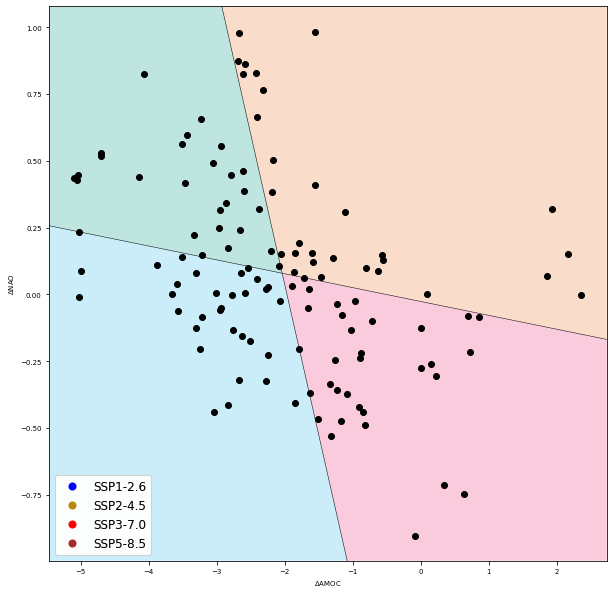

In [39]:

if len(drivers) == 2:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    _X = main_driver_ano.get(list(main_driver_ano.data_vars)[0])
    _Y = main_driver_ano.get(list(main_driver_ano.data_vars)[1])
    for _model in model:
        _members = [_member for _member in _X.member.values if _model in _member]
        sc = plt.scatter(_X.sel(member=_members),
                         _Y.sel(member=_members),
                         c = model_colors[_model],
                         marker = model_markers[_model], vmin=-2.5, vmax=2.5, zorder=1001)
    '''
    for i in range(len(story_unstd.stories)):
        sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=story.families[story_unstd.stories[i]]['label']),
                         main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=story.families[story_unstd.stories[i]]['label']),
                         c = story_unstd.colors[i],
                         marker = 'o', vmin=-2.5, vmax=2.5, zorder=1002)
    '''
    story.confidence = None
    story.plot_quadrants(show_members=False, show_stories=False)
    story.confidence = confidence
    if len(model) != 1:
        lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
        ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    plt.savefig(figDir+saveName+'-quadrants_model.pdf', transparent=True)


/tmp/ipykernel_323971/2139193510.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
/tmp/ipykernel_323971/2139193510.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
/tmp/ipykernel_323971/2139193510.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
/tmp/ipykernel_323971/2139193510.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=

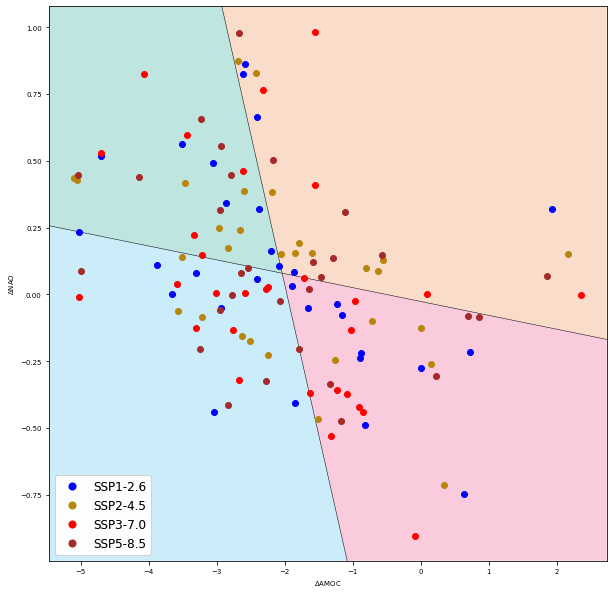

In [40]:

if len(drivers) == 2:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    for _model in members_dict.keys():
        for _experiment in members_dict[_model].keys():
            sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
                             main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]),
                             c = experiment_colors[_experiment],
                             marker = model_markers[_model], vmin=-2.5, vmax=2.5, zorder=1001)
    '''
    for i in range(len(story_unstd.stories)):
        sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=story.families[story_unstd.stories[i]]['label']),
                         main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=story.families[story_unstd.stories[i]]['label']),
                         c = story_unstd.colors[i],
                         marker = 'o', vmin=-2.5, vmax=2.5, zorder=1002)
    '''
    story.confidence = None
    story.plot_quadrants(show_members=False, show_stories=False)
    story.confidence = confidence
    if len(model) != 1:
        lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
        ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    plt.savefig(figDir+saveName+'-quadrants_SSP.pdf', transparent=True)


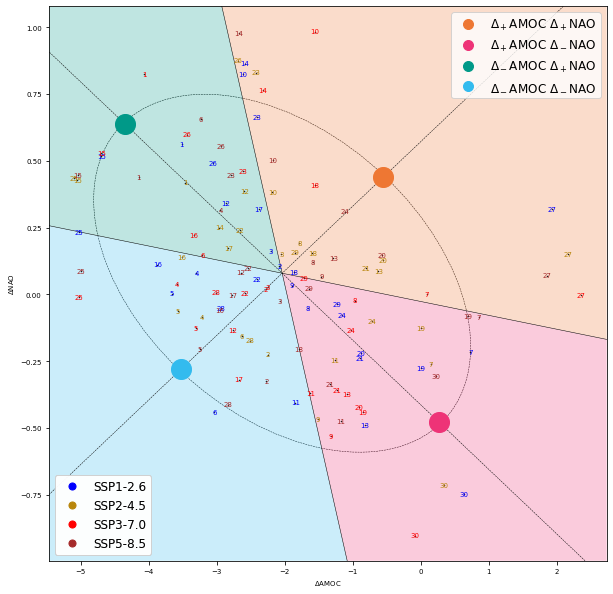

In [41]:
if len(drivers) == 2:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    for _model in members_dict.keys():
        for _experiment in members_dict[_model].keys():
            sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
                             main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]),
                             c = 'w',
                             marker = model_markers[_model], zorder=1)
            #'''
            for _member in members_dict[_model][_experiment]:
                plt.text(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=_member),
                         main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=_member),
                         _member.split('_r')[-1].split('i')[0],
                         c = experiment_colors[_experiment],
                         horizontalalignment='center', verticalalignment='center')
            #'''
    #x_lim = ax.get_xlim(); y_lim = ax.get_ylim(); ax.set_xlim(x_lim); ax.set_ylim(y_lim)
    #ax.set_xlim(-10,10); ax.set_ylim(-2,2)
    story.plot_quadrants(ax=ax, show_members=True, show_stories=True, markersize=1)
    _xMin, _xMax = ax.get_xlim()
    _yMin, _yMax = ax.get_ylim()
    _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
        [story.outputs.storindex[0,1], story.outputs.storindex[3,1]],
        [story.outputs.storindex[0,0], story.outputs.storindex[3,0]])
    ax.plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
            c = 'k', lw = .5, ls = '--', zorder = 1)
    _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
        [story.outputs.storindex[1,1], story.outputs.storindex[2,1]],
        [story.outputs.storindex[1,0], story.outputs.storindex[2,0]])
    ax.plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
            c = 'k', lw = .5, ls = '--', zorder = 1)
    lgd_sto = ax.legend(handles = story_legend_point, loc='upper right', fontsize=12)
    ax.add_artist(lgd_sto)
    #if len(model) != 1:
    #    lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
    #    ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    plt.savefig(figDir+saveName+'-quadrants_story_build.pdf', transparent=True)



In [42]:
story.outputs.index

<xarray.DataArray 'index' (story: 4, driver: 2)>
array([[ 0.54289832,  0.54289832],
       [ 0.83979844, -0.83979844],
       [-0.83979844,  0.83979844],
       [-0.54289832, -0.54289832]])
Coordinates:
  * story    (story) <U2 'AN' 'An' 'aN' 'an'
  * driver   (driver) <U4 'AMOC' 'NAO'

In [43]:
story.outputs.storindex

<xarray.DataArray 'storindex' (story: 4, driver: 2)>
array([[-0.54917116,  0.43963768],
       [ 0.26531276, -0.47763294],
       [-4.34231297,  0.63659898],
       [-3.52782905, -0.28067164]])
Coordinates:
  * story    (story) <U2 'AN' 'An' 'aN' 'an'
  * driver   (driver) <U4 'AMOC' 'NAO'

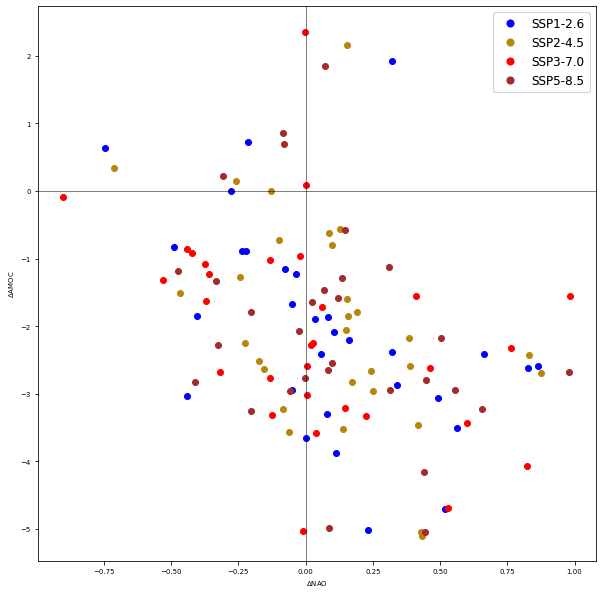

In [44]:
if len(drivers) > 1:
    _list_of_drivers = list(main_driver_ano.keys())
    _driver0 = _list_of_drivers[0]
    for i, _driver in enumerate(_list_of_drivers[1:]):
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes()
        ax.set_xlabel(delta_print+_driver); ax.set_ylabel(delta_print+_driver0)
        for _model in members_dict.keys():
            for _experiment in members_dict[_model].keys():
                for _member in members_dict[_model][_experiment]:
                    plt.scatter(main_driver_ano.get(_driver).sel(member=_member),
                                main_driver_ano.get(_driver0).sel(member=_member),
                                c = experiment_colors[_experiment], marker = model_markers[_model])
        ax.axhline(y=0, lw=.5, c='k'); ax.axvline(x=0, lw=.5, c='k')
        if len(model) != 1:
            lgd = ax.legend(handles = model_legend_point, fontsize=12) #, loc='upper right')
            ax.add_artist(lgd)
        lgd = ax.legend(handles = experiment_legend_point, fontsize=12) #, loc='lower left')
        ax.add_artist(lgd)
        plt.savefig(figDir+saveName+'-'+drivers[0]+'_'+drivers[i+1]+'.pdf', transparent=True)

    if len(drivers) > 2:
        _driver1 = _list_of_drivers[1]
        for i, _driver in enumerate(_list_of_drivers[2:]):
            fig = plt.figure(figsize=(10, 10))
            ax = plt.axes()
            ax.set_xlabel(delta_print+_driver1); ax.set_ylabel(delta_print+_driver)
            for _model in members_dict.keys():
                for _experiment in members_dict[_model].keys():
                    for _member in members_dict[_model][_experiment]:
                        plt.scatter(main_driver_ano.get(_driver1).sel(member=_member),
                                    main_driver_ano.get(_driver).sel(member=_member),
                                    c = experiment_colors[_experiment])
            ax.axhline(y=0, lw=.5, c='k'); ax.axvline(x=0, lw=.5, c='k')
            if len(model) != 1:
                lgd = ax.legend(handles = model_legend_point, fontsize=12) #, loc='upper right')
                ax.add_artist(lgd)
            lgd = ax.legend(handles = experiment_legend_point, fontsize=12) #, loc='lower left')
            ax.add_artist(lgd)
            plt.savefig(figDir+saveName+'-'+drivers[1]+'_'+drivers[i+2]+'.pdf', transparent=True)

/data/scratch/globc/line/Storylines/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/Figures/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP-amoc30N_nao_reg_raw_anomaly.pdf


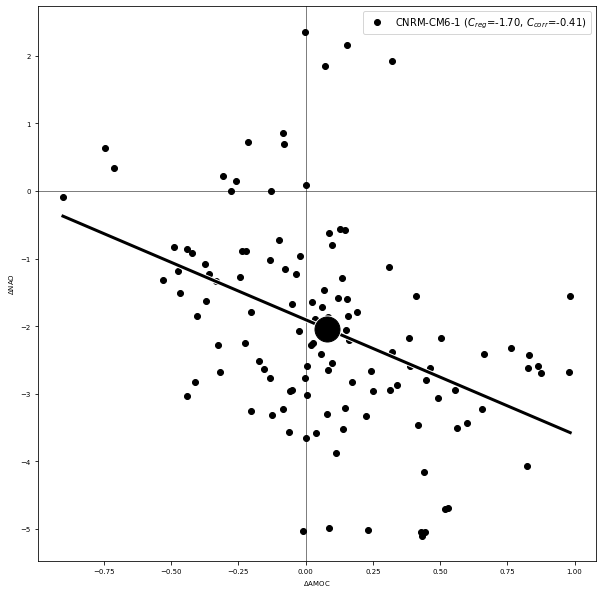

In [45]:
import numpy
import scipy.stats
import sklearn.linear_model
import sklearn.feature_selection

for iD1, _driver1 in enumerate(driver_ano):
    _driver_ano = list(driver_ano.keys())[iD1+1:]
    for iD2, _driver2 in enumerate(_driver_ano):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_xlabel('$\Delta$'+_driver1); ax.set_ylabel('$\Delta$'+_driver2)
        ax.axvline(x=0, c='k', lw=.5); ax.axhline(y=0, c='k', lw=.5)
        if len(model) != 1:
            X = driver_ano.get(_driver2).values; Y = driver_ano.get(_driver1).values
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = da_weight)
            print(_correlation)
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=7, zorder=0)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=5, ls=_ls, color='k', zorder=1,
                    label = 'Mega-ensemble ($C_{reg}$='+'{0:.2f}'.format(sklinreg.coef_[0])+', $C_{corr}$='+'{0:.2f})'.format(_correlation))
                    #label = 'Mega-ensemble ($C_{corr}$='+'{0:.2f}'.format(_correlation)+', $p_{value}$='+'{0:.0%})'.format(_pvalue))
        for _model in list(members_dict.keys()):
            X = Y = W = list()
            for _experiment in members_dict[_model]:
                y = list(driver_ano.get(_driver1).sel(member=members_dict[_model][_experiment]).values)
                x = list(driver_ano.get(_driver2).sel(member=members_dict[_model][_experiment]).values)
                W = W + list(da_weight.sel(member=members_dict[_model][_experiment]).values)
                #x = list(np.array(x) - np.mean(x)); y = list(np.array(y) - np.mean(y))
                Y = Y + y; X = X + x
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = W)
            #_pvalue = sklearn.feature_selection.f_regression(numpy.array(X)[:, numpy.newaxis], np.array(Y))[1]#.p_values
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
                       label=source_dict[_model]+' ($C_{reg}$='+'{0:.2f}'.format(sklinreg.coef_[0])+', $C_{corr}$='+'{0:.2f})'.format(_correlation))
            ax.plot(np.mean(X), np.mean(Y), model_markers[_model], color='w', ms=27, zorder=9)
            ax.plot(np.mean(X), np.mean(Y), model_markers[_model], color=model_colors[_model], ms=25, zorder=10)
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=5)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=3, ls=_ls, color=model_colors[_model])
        ax.legend(fontsize=10)
        plt.savefig(figDir+saveName+'-'+drivers[iD1]+'_'+drivers[iD2+iD1+1]+'_reg_raw_anomaly.pdf', transparent=True)
        print(figDir+saveName+'-'+drivers[iD1]+'_'+drivers[iD2+iD1+1]+'_reg_raw_anomaly.pdf')

0.36868020503636256
0.36868020503636256
0.0


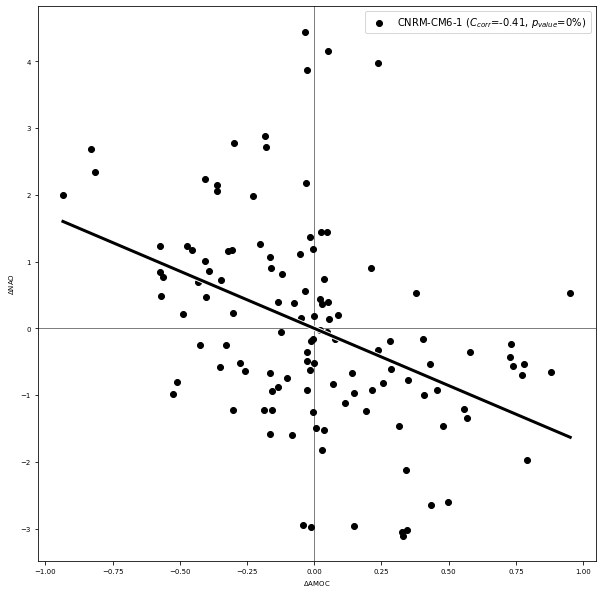

In [46]:
import numpy
import scipy.stats
import sklearn.linear_model
import sklearn.feature_selection

for iD1, _driver1 in enumerate(driver_ano):
    _driver_ano = list(driver_ano.keys())[iD1+1:]
    for iD2, _driver2 in enumerate(_driver_ano):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_xlabel('$\Delta$'+_driver1); ax.set_ylabel('$\Delta$'+_driver2)
        ax.axvline(x=0, c='k', lw=.5); ax.axhline(y=0, c='k', lw=.5)
        if len(model) != 1:
            Y = driver_ano.get(_driver1).values; X = driver_ano.get(_driver2).values
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = da_weight)
            print(_correlation)
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=7, zorder=0)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=5, ls=_ls, color='k', zorder=1, label = 'Mega-ensemble ($C_{corr}$='+'{0:.2f}'.format(_correlation)+', $p_{value}$='+'{0:.0%})'.format(_pvalue))
        for _model in list(members_dict.keys()):
            X = Y = W = list()
            for _experiment in members_dict[_model]:
                y = list(driver_ano.get(_driver1).sel(member=members_dict[_model][_experiment]).values)
                x = list(driver_ano.get(_driver2).sel(member=members_dict[_model][_experiment]).values)
                W = W + list(da_weight.sel(member=members_dict[_model][_experiment]).values)
                x = list(np.array(x) - np.mean(x)); y = list(np.array(y) - np.mean(y))
                Y = Y + y; X = X + x
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = W)
            print(ccnp.std(X))
            print(ccnp.std(X, weights = W))
            print(ccnp.std(X)-ccnp.std(X, weights = W))
            #_pvalue = sklearn.feature_selection.f_regression(numpy.array(X)[:, numpy.newaxis], np.array(Y))[1]#.p_values
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            #ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
            #           label=source_dict[_model]+' ($C_{reg}$='+'{0:.2f}'.format(sklinreg.coef_[0])+', $C_{corr}$='+'{0:.2f})'.format(_correlation))
            ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
                       label=source_dict[_model]+' ($C_{corr}$='+'{0:.2f}'.format(_correlation)+', $p_{value}$='+'{0:.0%})'.format(_pvalue))
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=5)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=3, ls=_ls, color=model_colors[_model])
        ax.legend(fontsize=10)
        plt.savefig(figDir+saveName+'-'+drivers[iD1]+'_'+drivers[iD2+iD1+1]+'_corr_raw_anomaly.pdf', transparent=True)

In [47]:
if len(model) != 1:

    figsize = (15, 10)

    for _driver in driver_ano:
        print(_driver)

        _data = driver_ano[_driver]

        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)

        model_data = {_model: [] for _model in _members_dict}

        for iM, _model in enumerate(_members_dict):
            for i, _experiment in enumerate(experiments): # experiments
                if _experiment in _members_dict[_model].keys():
                    for _member in _members_dict[_model][_experiment]:
                        model_data[_model].append(float(_data.sel(member=_member).values))

        fig, ax = plt.subplots(figsize = figsize)
        tick_positions = list(); tick_labels = list()
        for iM, _model in enumerate(model_data):
            ccplt.boxplot([model_data[_model]],
                          hatch = model_hatches[_model], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                          dx=iM, width = 0.5)
            tick_positions.append(iM)
            tick_labels.append(len(model_data[_model]))
        tick_positions.append(len(model_data))
        tick_labels.append(len(_data.member))
        for iS, _sto in enumerate(story.labels):
            _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
            ccplt.boxplot([_data.sel(member=_story_members)],
                         weights = [da_weight.sel(member=_story_members)],
                         color = [story.colors[iS]],
                         bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=len(model_data)+1+iS, width = 0.5)
            tick_positions.append(len(model_data)+1+iS)
            tick_labels.append(len(_story_members))
        ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(model_data), width = 0.5)
        ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.set_xticks(np.arange(len(model_data)+1+len(story.stories))+.5-0.5)
        ax.set_xticklabels(
            [source_dict[_model] for _model in model_data.keys()]+['Mega\nensemble']+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
            rotation=90)
        ax.set_ylabel(_data.attrs['units'])
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)
        for i in range(2):
            ax.axvline(x=len(model_data)+i-0.5,color='k',lw=1)
            #ax.plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
        plt.savefig(figDir+saveName+'-'+_driver+'_boxplot_models_story.pdf', transparent=True)  

AMOC


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

NAO


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

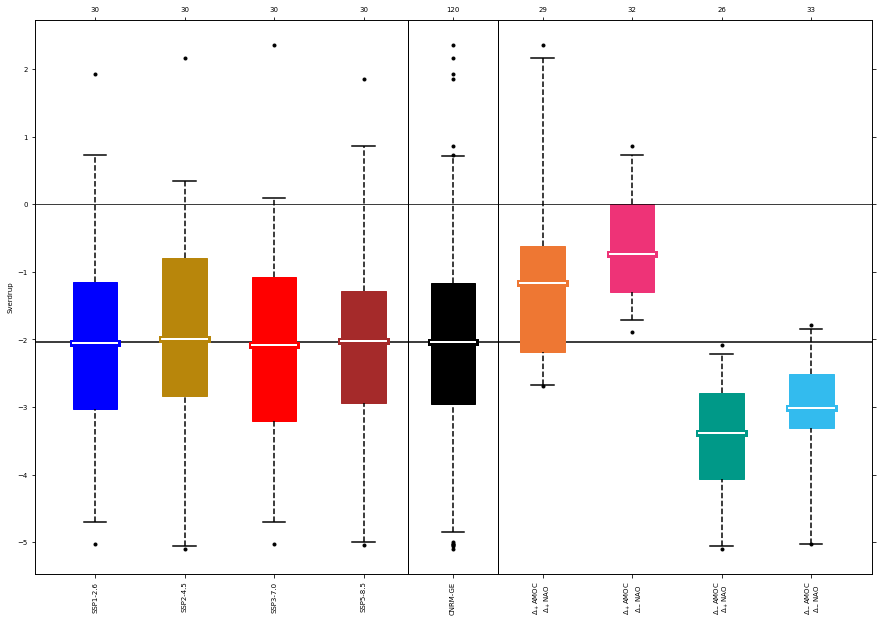

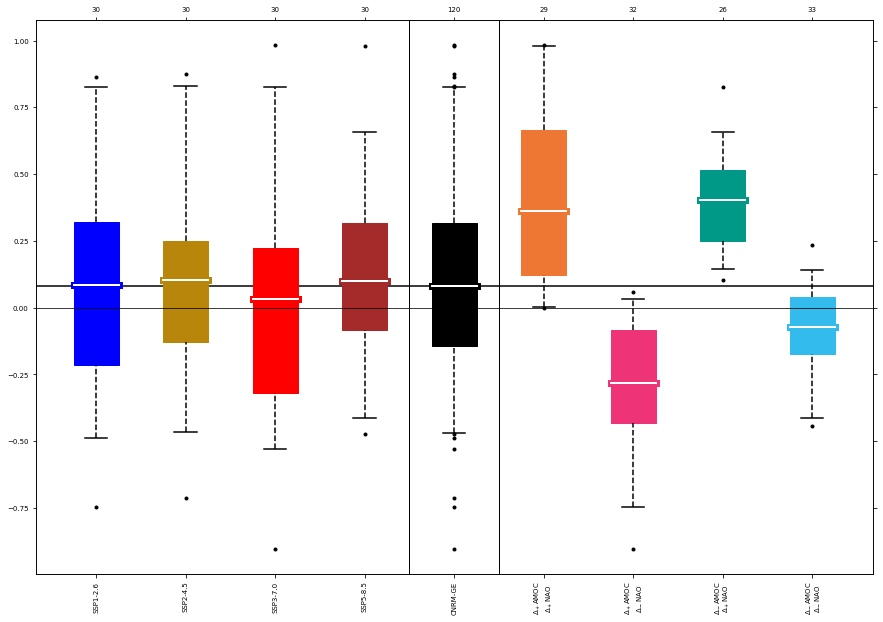

In [48]:
if len(experiments) != 1:

    figsize = (15, 10)

    for _driver in driver_ano:
        print(_driver)

        _data = driver_ano[_driver]

        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)

        model_data = {_model: [] for _model in _members_dict}
        experiment_data = {_experiment: [] for _experiment in experiments}
        experiment_data_weights = {_experiment: [] for _experiment in experiments}

        for iM, _model in enumerate(_members_dict):
            for i, _experiment in enumerate(experiments):
                if _experiment in _members_dict[_model].keys():
                    for _member in _members_dict[_model][_experiment]:
                        experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                        experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
        
        fig, ax = plt.subplots(figsize = figsize)
        tick_positions = list(); tick_labels = list()
        for iE, _experiment in enumerate(experiments):
            ccplt.boxplot([experiment_data[_experiment]],
                          weights = [experiment_data_weights[_experiment]],
                          color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                          dx=iE, width = 0.5)
            tick_positions.append(iE)
            tick_labels.append(len(experiment_data[_experiment]))
        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.set_xticks(np.arange(len(experiments))+.5-0.5)
        ax.set_xticklabels([experiment_labels[_experiment] for _experiment in experiments], rotation=0)

        tick_positions.append(len(experiments))
        tick_labels.append(len(_data.member))

        for iS, _sto in enumerate(story.labels):
            _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
            ccplt.boxplot([_data.sel(member=_story_members)],
                         weights = [da_weight.sel(member=_story_members)],
                         color = [story.colors[iS]],
                         bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=len(experiments)+1+iS, width = 0.5)
            tick_positions.append(len(experiments)+1+iS)
            tick_labels.append(len(_story_members))
        ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(experiments), width = 0.5)
        ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.set_xticks(np.arange(len(experiments)+1+len(story.stories))+.5-0.5)
        ax.set_xticklabels(
            [cc.cmip6.experiment_dict[_experiment]['name'] for _experiment in experiments]+ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
            rotation=90)
        ax.set_ylabel(_data.attrs['units'])
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)
        for i in range(2):
            ax.axvline(x=len(experiments)+i-0.5,color='k',lw=1)
            #ax.plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
        plt.savefig(figDir+saveName+'-'+_driver+'_boxplot_SSP_story.pdf', transparent=True)

AMOC


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

NAO


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

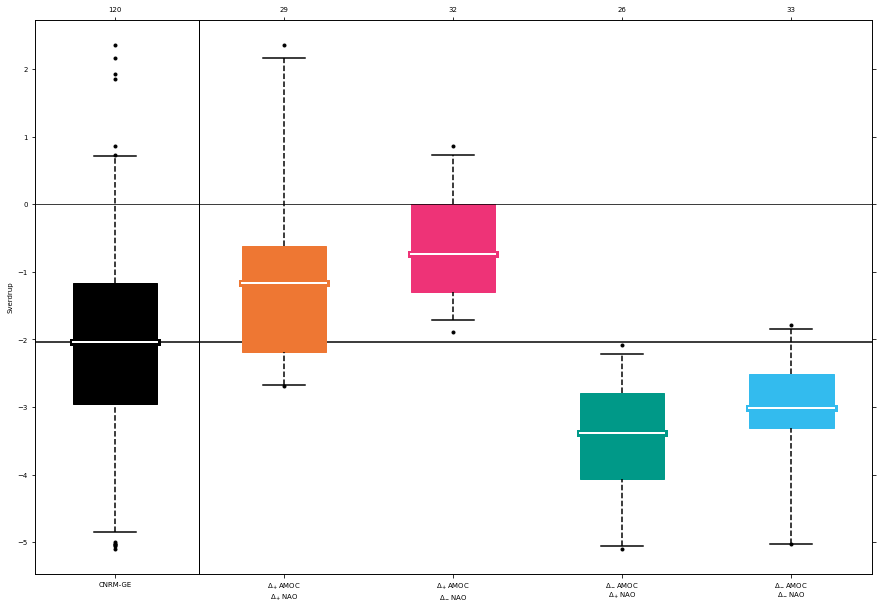

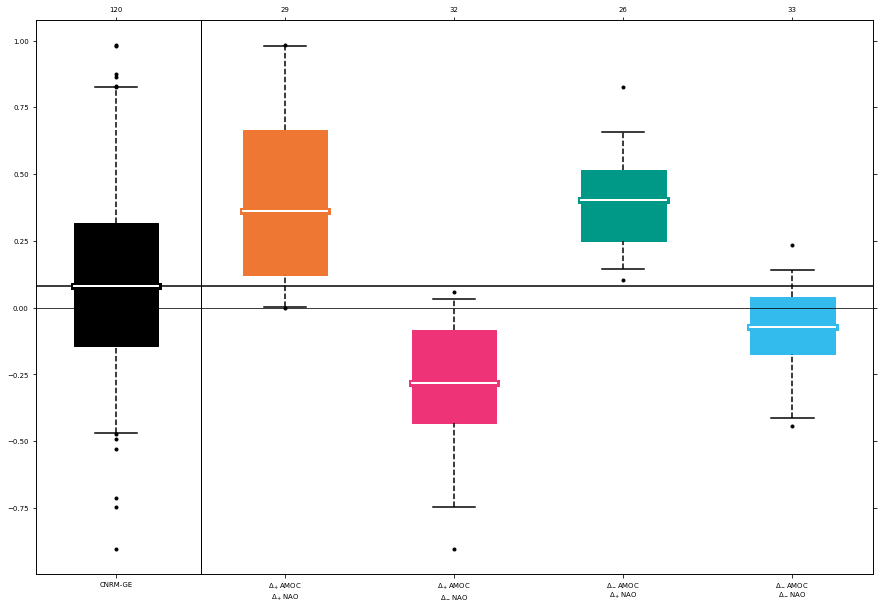

In [49]:
if len(experiments) != 1:

    figsize = (15, 10)

    for _driver in driver_ano:
        print(_driver)

        _data = driver_ano[_driver]

        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)

        model_data = {_model: [] for _model in _members_dict}
        experiment_data = {_experiment: [] for _experiment in experiments}
        experiment_data_weights = {_experiment: [] for _experiment in experiments}

        for iM, _model in enumerate(_members_dict):
            for i, _experiment in enumerate(experiments):
                if _experiment in _members_dict[_model].keys():
                    for _member in _members_dict[_model][_experiment]:
                        experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                        experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
        
        fig, ax = plt.subplots(figsize = figsize)
        tick_positions = list(); tick_labels = list()
        #for iE, _experiment in enumerate(experiments):
        #    ccplt.boxplot([experiment_data[_experiment]],
        #                  weights = [experiment_data_weights[_experiment]],
        #                  color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
        #                  dx=iE, width = 0.5)
        #    tick_positions.append(iE)
        #    tick_labels.append(len(experiment_data[_experiment]))
        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        #ax.set_xticks(np.arange(len(experiments))+.5-0.5)
        #ax.set_xticklabels([experiment_labels[_experiment] for _experiment in experiments], rotation=0)

        #tick_positions.append(0)
        tick_labels.append(len(_data.member))

        for iS, _sto in enumerate(story.labels):
            _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
            ccplt.boxplot([_data.sel(member=_story_members)],
                         weights = [da_weight.sel(member=_story_members)],
                         color = [story.colors[iS]],
                         bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=1+iS, width = 0.5)
            #tick_positions.append(1+iS)
            tick_labels.append(len(_story_members))
        ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, width = 0.5)
        ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.set_xticks(np.arange(1+len(story.stories)))
        ax.set_xticklabels(
            ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
            rotation=0) # 90
        ax.set_ylabel(_data.attrs['units'])
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(np.arange(1+len(story.stories)))
        ax2.set_xticklabels(tick_labels)
        ax.axvline(x=0.5,color='k',lw=1)
        #for i in range(2):
            #ax.axvline(x=i-0.5,color='k',lw=1)
            #ax.plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
        plt.savefig(figDir+saveName+'-'+_driver+'_boxplot_ME_story.pdf', transparent=True)

# Storyline targets

## Loading data

In [50]:
loaded_files

['CNRM-CM6-1_hist-ssp245_r10i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r11i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r12i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r13i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r14i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r15i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r16i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r17i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r18i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r19i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r1i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r20i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r21i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r22i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r23i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r24i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r25i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp245_r26i1p1f2_index_1850-203

In [51]:
begin = time.time()

_anomaly = 'internal variability' if anomaly == 'mixed' else anomaly
#_anomaly = 'internal variability' if anomaly == 'super internal variability' else anomaly

target_data = dict(); target_ano = dict()
for i, _target in enumerate(targets):
    try:
        tmp_data = list()

        #members = driver_data.member.values.tolist()
        #members.sort()
        loaded_members = list()
        print(_target)
        _variable, _region, _mask_land_sea = _target.split('_')

        list_data = list(); list_ano = list()
        for _model in model:
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                if _experiment_id in ('piControl'):
                    _n_max = None; _date_start = None; _date_stop = None; _refStr = None
                else:
                    _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr
                tmp = list()
                for file in loaded_files:
                    if _model in file and _experiment_id in file:
                        _file = '/data/home/globc/line/scratch/Data/Computed/'+_variable+'_'+cc.cmip6.table_dict[_variable]+'_'+file.replace('index', _region+_mask_land_sea)
                        print(_file)
                        try:
                            tmp.append(xr.open_dataset(_file).get(_variable).sel(time = slice(_date_start, _date_stop)))
                            tmp[-1] = tmp[-1].sortby(tmp[-1].time)
                            loaded_members.append(tmp[-1].member.values)
                        except FileNotFoundError:
                            print(file, 'was not loaded ('+_target+').')
                            pass
                if tmp:
                    tmp = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
                    tmp = cc.get_season(tmp.resample(time='M').mean(dim = 'time', keep_attrs = True), temporality)
                    if _experiment_id == 'piControl':
                        tmp = tmp.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp.time), freq = 'Y')})
                    list_data.append(tmp)
                    list_ano.append(cctim.get_anomalies(
                        data=list_data[-1], n_max=_n_max, calcul=_anomaly, relative=relative,
                        start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))

        tmp_data = list_data[0] if len(list_data) == 1 else xr.concat(list_data, dim='member')
        tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')

        # Data used in the storyline analysis
        target_data[_target] = tmp_data; target_data[_target].name = _target
        if experiment != ['piControl']:
            target_data[_target] = target_data[_target].sortby('member')
        target_ano[_target] = tmp_ano.sortby('member'); target_ano[_target].name = _target

        '''
        list_data = list(); list_ano = list(); list_seasons_data = list(); list_seasons_ano = list()
        for _model in model:
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                if _experiment_id in ('piControl'):
                    _n_max = None; _date_start = None; _date_stop = None; _refStr = None
                else:
                    _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr
                tmp = list(); tmp_seasons = list()
                for file in list_of_files:
                    if _variable+'_'+cc.cmip6.table_dict[_variable] in file and _model in file and _experiment_id in file and '_'+_region+_mask_land_sea+'_' in file:
                        print('/data/home/globc/line/scratch/Data/Computed/'+file)
                        tmp.append(xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+file, decode_times=True).get(_variable).sel(time=slice(_date_start, _date_stop)))
                        tmp[-1] = tmp[-1].sortby(tmp[-1].time)
                        tmp_seasons.append(tmp[-1].expand_dims(['source_id', 'experiment_id']))
                        _file = '_'.join(file.split('_')[2:])
                        if _file not in loaded_files:
                            loaded_files.append(_file)
                tmp = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
                tmp = cc.get_season(tmp.resample(time='M').mean(dim = 'time', keep_attrs = True), temporality)
                if _experiment_id == 'piControl':
                    tmp = tmp.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp.time), freq = 'Y')})
                list_data.append(tmp)
                list_ano.append(cctim.get_anomalies(
                    data=list_data[-1], n_max=_n_max, calcul=anomaly,
                    start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))
                tmp_seasons = tmp_seasons[0] if len(tmp_seasons) == 1 else xr.concat(tmp_seasons, dim='member')
                tmp_seasons = tmp_seasons.resample(time='M').mean(dim = 'time', keep_attrs = True)
                tmp_seasons = xr.concat([cc.get_season(tmp_seasons, _season) for _season in seasons],
                                        pd.Index(seasons, name='season')).resample(time='Y').mean(dim = 'time', keep_attrs = True)
                if _experiment_id == 'piControl':
                    tmp_seasons = tmp_seasons.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp_seasons.time), freq = 'M')})
                list_seasons_data.append(tmp_seasons)
                list_seasons_ano.append(cctim.get_anomalies(
                    data=list_seasons_data[-1], n_max=_n_max, calcul=anomaly,
                    start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))

        tmp_data = list_data[0] if len(list_data) == 1 else xr.concat(list_data, dim='member')
        tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')
        tmp_seasons_data = list_seasons_data[0] if len(list_seasons_data) == 1 else xr.concat(list_seasons_data, dim='member')
        tmp_seasons_ano = list_seasons_ano[0] if len(list_seasons_ano) == 1 else xr.concat(list_seasons_ano, dim='member')
        if i != 0:
            target_data = target_data.sel(member = list(set(target_data.member.values).intersection(set(tmp_data.member.values))))
            target_ano = target_ano.sel(member = list(set(target_ano.member.values).intersection(set(tmp_ano.member.values))))
            target_seasons_data = target_seasons_data.sel(member = list(set(target_seasons_data.member.values).intersection(set(tmp_seasons_data.member.values))))
            target_seasons_ano = target_seasons_ano.sel(member = list(set(target_seasons_ano.member.values).intersection(set(tmp_seasons_ano.member.values))))

        # Data used in the storyline analysis
        target_data = target_data.assign({_variable: tmp_data}).sortby('member')
        target_ano = target_ano.assign({_variable: tmp_ano}).sortby('member')

        # Data with all seasons for the preliminary analyses
        target_seasons_data = target_seasons_data.assign({_variable: tmp_seasons_data}).sortby('member')
        target_seasons_ano = target_seasons_ano.assign({_variable: tmp_seasons_ano}).sortby('member')
        '''
    except ValueError:
        print(_target+' was not loaded.')

end = time.time()
print('Runtime of the data loading is', '{0:.1f}'.format(end - begin), 's')
target_data

tas_NEU_land
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/sc

/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r28i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r29i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r2i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r30i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r3i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r4i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/tas_Amon_CNRM-CM6-1_hist-ssp370_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed

/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r24i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r25i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r26i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r27i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r28i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r29i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r2i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r30i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_Amon_CNRM-CM6-1_hist-ssp245_r3i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/pr_A

/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r4i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp126_r9i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data

/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp585_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp585_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp585_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/prsn_Amon_CNRM-CM6-1_hist-ssp585_r9i1p1f2_NEUland_1850-2039.nc
snc_NEU_land
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
/data/home/globc/li

/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r3i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r4i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp370_r9i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/snc_LImon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/

/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r2i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r30i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r3i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r4i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r9i1p1f2_NEUland_1850-2039.nc
/data/hom

/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp126_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp126_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp126_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp126_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp126_r9i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Dat

/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp585_r5i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp585_r6i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp585_r7i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp585_r8i1p1f2_NEUland_1850-2039.nc
/data/home/globc/line/scratch/Data/Computed/rsds_Amon_CNRM-CM6-1_hist-ssp585_r9i1p1f2_NEUland_1850-2039.nc
Runtime of the data loading is 24.4 s


{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 140)>
 array([[265.9465941 , 261.44644823, 267.27073081, ..., 269.5153793 ,
         268.22894271, 267.8886264 ],
        [268.22683513, 269.68708355, 267.74159752, ..., 269.35821959,
         269.10090838, 266.80226795],
        [266.79596331, 260.19626601, 262.12891415, ..., 265.27680137,
         267.86204993, 269.48066747],
        ...,
        [268.10302927, 267.49893743, 268.27970085, ..., 266.61086058,
         266.37421062, 271.2530638 ],
        [266.41225129, 265.62247907, 265.55596254, ..., 267.18830695,
         269.8690848 , 266.78049736],
        [262.68755099, 267.02081802, 269.27014991, ..., 269.04747498,
         271.08842265, 268.48176216]])
 Coordinates:
   * member         (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM...
     source_id      <U10 'CNRM-CM6-1'
     experiment_id  (member) <U11 'hist-ssp126' 'hist-ssp126' ... 'hist-ssp585'
     member_id      (member) <U9 'r10i1p1f2' 'r1

In [52]:
target_data

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 140)>
 array([[265.9465941 , 261.44644823, 267.27073081, ..., 269.5153793 ,
         268.22894271, 267.8886264 ],
        [268.22683513, 269.68708355, 267.74159752, ..., 269.35821959,
         269.10090838, 266.80226795],
        [266.79596331, 260.19626601, 262.12891415, ..., 265.27680137,
         267.86204993, 269.48066747],
        ...,
        [268.10302927, 267.49893743, 268.27970085, ..., 266.61086058,
         266.37421062, 271.2530638 ],
        [266.41225129, 265.62247907, 265.55596254, ..., 267.18830695,
         269.8690848 , 266.78049736],
        [262.68755099, 267.02081802, 269.27014991, ..., 269.04747498,
         271.08842265, 268.48176216]])
 Coordinates:
   * member         (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM...
     source_id      <U10 'CNRM-CM6-1'
     experiment_id  (member) <U11 'hist-ssp126' 'hist-ssp126' ... 'hist-ssp585'
     member_id      (member) <U9 'r10i1p1f2' 'r1

In [53]:
target_ano

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120)>
 array([ 1.42911049,  0.07746483,  0.65010168,  0.70985857,  2.40505653,
         0.94608251,  0.16221159,  1.49547151,  2.25937795,  1.03142114,
         1.21126046,  0.9074095 ,  2.17888367,  0.29440861,  2.17666858,
         0.78542104, -0.32653717,  0.88728211,  3.03339124,  1.08645558,
         2.85654898,  0.58103108,  1.28732608,  1.4241029 ,  0.21427796,
         0.24074714, -0.32115238,  1.38713172,  2.2230326 ,  0.53658753,
         1.10001786,  0.54034393,  1.13846907,  1.58441493,  0.52191622,
        -0.0178523 ,  0.46053477,  0.51586568,  3.07282102,  1.47054368,
         1.34856157,  1.77085088,  2.44238451,  0.35763831,  2.93002399,
         1.15907168,  0.80915506,  2.13504662,  1.97156394,  0.46030226,
         1.89832046,  0.38616483,  1.45693782,  0.71718569,  0.1989635 ,
        -0.2117645 ,  0.17048429,  0.61018564,  2.50436208, -0.31825187,
         2.50401377,  0.18629908,  0.02116921,  0.70162253,

In [54]:
driver_ano

<xarray.Dataset>
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 196.0
    sector   |S255 b'atlantic_arctic_ocean'
  * member   (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-CM6-1...
Data variables:
    AMOC     (member) float32 -2.617 -1.843 -2.866 ... 0.8565 -1.584 -1.461
    NAO      (member) float32 0.8252 -0.4051 0.3413 ... -0.08414 0.1208 0.06652

In [55]:
variable_dict = dict(); region_dict = dict()
for _target in target_ano:
    _variable, _region, _ = _target.split('_')
    if _variable not in variable_dict:
        variable_dict[_variable] = [_region]
    elif _region not in variable_dict[_variable]:
        variable_dict[_variable].append(_region)
    if _region not in region_dict:
        region_dict[_region] = [_variable]
    elif _variable not in region_dict[_region]:
        region_dict[_region].append(_variable)
variable_dict, region_dict

({'tas': ['NEU'],
  'pr': ['NEU'],
  'prsn': ['NEU'],
  'snc': ['NEU'],
  'sfcWind': ['NEU'],
  'rsds': ['NEU']},
 {'NEU': ['tas', 'pr', 'prsn', 'snc', 'sfcWind', 'rsds']})

In [56]:
for _region in region_dict:
    if 'pr' in region_dict[_region] and 'prsn' in region_dict[_region]:
        _name = 'prlq_'+_region+'_land'
        target_data[_name] = target_data['pr_'+_region+'_land'] - target_data['prsn_'+_region+'_land']; target_data[_name].name = _name
        if experiment != ['piControl']:
            target_data[_name] = target_data[_name].sortby('member')
        _ensemble_dict = cc.cmip6.sort_by_IV_ensemble(target_data[_name].member.values)
        list_ano = list()
        for _model in _ensemble_dict:
            for _experiment in _ensemble_dict[_model]:
                if _experiment_id in ('piControl'):
                    _n_max = None; _date_start = None; _date_stop = None; _refStr = None
                else:
                    _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr
                for _config in _ensemble_dict[_model][_experiment]:
                    _tmp = target_data[_name].sel(member = _ensemble_dict[_model][_experiment][_config])
                    list_ano.append(cctim.get_anomalies(
                        data=_tmp, n_max=_n_max, calcul=_anomaly, relative=relative,
                        start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))
        tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')
        target_ano[_name] = tmp_ano.sortby('member'); target_ano[_name].name = _name
target_dict = update_target_dict(target_dict, target_data)
for _target in target_ano:
    _variable, _region, _ = _target.split('_')
    if _variable not in variable_dict:
        variable_dict[_variable] = [_region]
    elif _region not in variable_dict[_variable]:
        variable_dict[_variable].append(_region)
    if _region not in region_dict:
        region_dict[_region] = [_variable]
    elif _variable not in region_dict[_region]:
        region_dict[_region].append(_variable)
target_data.keys(), target_dict, variable_dict, region_dict

(dict_keys(['tas_NEU_land', 'pr_NEU_land', 'prsn_NEU_land', 'snc_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land', 'prlq_NEU_land']),
 {'tas': 'T',
  'tas_NEU_land': 'T_{NEU}',
  'pr': 'pr',
  'pr_NEU_land': 'pr_{NEU}',
  'prsn': 'snowfall',
  'prsn_NEU_land': 'snowfall_{NEU}',
  'snc': 'snc',
  'snc_NEU_land': 'snc_{NEU}',
  'sfcWind': 'wind',
  'sfcWind_NEU_land': 'wind_{NEU}',
  'rsds': 'rsds',
  'rsds_NEU_land': 'rsds_{NEU}',
  'prlq': 'rain',
  'prlq_NEU_land': 'rain_{NEU}'},
 {'tas': ['NEU'],
  'pr': ['NEU'],
  'prsn': ['NEU'],
  'snc': ['NEU'],
  'sfcWind': ['NEU'],
  'rsds': ['NEU'],
  'prlq': ['NEU']},
 {'NEU': ['tas', 'pr', 'prsn', 'snc', 'sfcWind', 'rsds', 'prlq']})

In [57]:
'''
target_ano_std = dict()
for _target in target_ano:
    _tmp = list(target_ano[_target].member.values); _tmp.sort()
    _dict = cc.cmip6.get_members_dict(_tmp)
    _store = list()
    for _m in _dict:
        for _e in _dict[_m]:
            _tmp = target_ano[_target].sel(member=_dict[_m][_e])
            _store.append((_tmp - _tmp.mean('member')) / _tmp.std('member'))
    target_ano_std[_target] = xr.concat(_store, dim='member')
    target_ano_std[_target].attrs = target_ano[_target].attrs
    target_ano_std[_target].attrs['units'] = ''
'''
target_ano_std = dict()
for _target in target_ano:
    target_ano_std[_target] = cc.cmip6.standardisation(target_ano.get(_target))

target_ano_unfcd = dict()
for _target in target_ano:
    target_ano_unfcd[_target] = cc.cmip6.remove_forced_response(target_ano.get(_target))

if normalisation_method == 'std':
    main_target_ano = target_ano_std
elif normalisation_method == 'unfcd':
    main_target_ano = target_ano_unfcd
else:
    main_target_ano = target_ano

for _target in main_target_ano:
    story.add_target(main_target_ano[_target], name=_target)

#'''
print()
print(saveDir)
for i, _driver in enumerate(story.drivers):
    #print(drivers[i], _driver)
    if os.path.exists(dataDir+drivers[i]+'.nc'):
        os.remove(dataDir+drivers[i]+'.nc')
    story.drivers[_driver].to_netcdf(dataDir+drivers[i]+'.nc')
for _target in story.targets:
    if os.path.exists(dataDir+_target+'.nc'):
        os.remove(dataDir+_target+'.nc')
    story.targets[_target].to_netcdf(dataDir+_target+'.nc')
    for i, _sto in enumerate(story.stories):
        if os.path.exists(dataDir+_target+'-'+_sto+str(i+1)+'.nc'):
            os.remove(dataDir+_target+'-'+_sto+str(i+1)+'.nc')
        _members = list(set(story.targets[_target].member.values).intersection(set(story.families[_sto]['label'])))
        story.targets[_target].sel(member=_members).to_netcdf(dataDir+_target+'-'+_sto+str(i+1)+'.nc')
if os.path.exists(dataDir+'weights.nc'):
    os.remove(dataDir+'weights.nc')
story.weights.to_netcdf(dataDir+'weights.nc')
for _target in target_ano:
    if os.path.exists(dataDir+_target+'-raw.nc'):
        os.remove(dataDir+_target+'-raw.nc')
    target_ano[_target].to_netcdf(dataDir+_target+'-raw.nc')
for _target in target_ano_std:
    if os.path.exists(dataDir+_target+'-std.nc'):
        os.remove(dataDir+_target+'-std.nc')
    target_ano_std[_target].to_netcdf(dataDir+_target+'-std.nc')
for _target in target_ano_unfcd:
    if os.path.exists(dataDir+_target+'-unforced.nc'):
        os.remove(dataDir+_target+'-unforced.nc')
    target_ano_unfcd[_target].to_netcdf(dataDir+_target+'-unforced.nc')
'''
if os.path.exists(dataDir+saveName+'.nc'):
    os.remove(dataDir+saveName+'.nc')
story.data.to_netcdf(dataDir+saveName+'.nc')
for i, _sto in enumerate(story.stories):
    if os.path.exists(dataDir+saveName+'-'+_sto+str(i+1)+'.nc'):
        os.remove(dataDir+saveName+'-'+_sto+str(i+1)+'.nc')
    story.data.sel(member=story.families[_sto]['label']).to_netcdf(dataDir+saveName+'-'+_sto+str(i+1)+'.nc')
'''
print('Data saved.')
#'''

main_target_ano


/data/scratch/globc/line/Storylines/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/
Data saved.


{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120)>
 array([ 1.42911049,  0.07746483,  0.65010168,  0.70985857,  2.40505653,
         0.94608251,  0.16221159,  1.49547151,  2.25937795,  1.03142114,
         1.21126046,  0.9074095 ,  2.17888367,  0.29440861,  2.17666858,
         0.78542104, -0.32653717,  0.88728211,  3.03339124,  1.08645558,
         2.85654898,  0.58103108,  1.28732608,  1.4241029 ,  0.21427796,
         0.24074714, -0.32115238,  1.38713172,  2.2230326 ,  0.53658753,
         1.10001786,  0.54034393,  1.13846907,  1.58441493,  0.52191622,
        -0.0178523 ,  0.46053477,  0.51586568,  3.07282102,  1.47054368,
         1.34856157,  1.77085088,  2.44238451,  0.35763831,  2.93002399,
         1.15907168,  0.80915506,  2.13504662,  1.97156394,  0.46030226,
         1.89832046,  0.38616483,  1.45693782,  0.71718569,  0.1989635 ,
        -0.2117645 ,  0.17048429,  0.61018564,  2.50436208, -0.31825187,
         2.50401377,  0.18629908,  0.02116921,  0.70162253,

In [58]:
story.targets.keys()

dict_keys(['tas_NEU_land', 'pr_NEU_land', 'prsn_NEU_land', 'snc_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land', 'prlq_NEU_land'])

In [59]:

ccfld = reload(ccfld)

begin = time.time()

field_ano_raw = dict()
variable = list(); mask_land_sea = list()
for _target in targets:
    _variable, _, _mask_land_sea = _target.split('_')
    if _variable not in variable:
        variable.append(_variable)
        mask_land_sea.append(_mask_land_sea)

#variable, mask_land_sea = ['siconc'], ['']

for _variable, _mask_land_sea in np.array([variable, mask_land_sea]).T:
    try:
        tmp = list()

        #members = driver_data.member.values.tolist()
        #members.sort()
        loaded_members = list()
        print(_variable, _mask_land_sea)
        #_variable, _region, _mask_land_sea = _target.split('_')
        for _model in model:
            if len(model) == 1:
                _grid = '_'+cc.cmip6.grid_dict[_variable]+'_' if _model in ['CNRM-CM6-1', 'IPSL-CM6A-LR'] else '_gn_'
            else:
                _grid = '_gr1d_'
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                #if _experiment_id in cc.cmip6.scenario_mip_dict[_model]['experiment']:
                    for file in loaded_files:
                        if _model in file and _experiment_id in file:
                            _file = _variable+'_'+temporality+'_'+file.replace('_index_', _grid)
                            _period = _file.split('_')[-1]
                            if _experiment_id == 'piControl':
                                _file = _file.replace(_period, 'length'+str(period_length)+'yr-gap'+str(period_gap)+'yr-overlap'+'.nc')
                            else:
                                _file = _file.replace(_period, intStr+intEnd+'-'+refStr+refEnd+'.nc')
                            print('/data/home/globc/line/scratch/Data/Computed/'+_file)
                            try:
                                _tmp = xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+_file).get(_variable)
                                if experiment == ['piControl']:
                                    tmp.append(_tmp.sel(member=members_dict[_model]['piControl']))
                                else:
                                    tmp.append(_tmp)
                                loaded_members.append(tmp[-1].member.values)
                            except FileNotFoundError:
                                print(_file, 'was not loaded ('+_variable+').')
                                pass

        _da_delta = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
        _da_delta = cc.lon_flip(_da_delta)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_delta = cc.mask_land(_da_delta, mask = cc.lon_flip(xr.open_dataset('/data/scratch/globc/line/Data/Masks/sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))

        field_ano_raw[_variable] = _da_delta
    except:
        print(_variable, _mask_land_sea, 'was not loaded (field).')

end = time.time()
print('Runtime of the field data loading is', '{0:.1f}'.format(end - begin), 's')
field_ano_raw.keys()

tas land
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r16i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r17i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r18i1p1f2_gr_20202039-19952014.nc
/data/home

/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r3i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r4i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r5i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r6i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r7i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r8i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp370_r9i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r10i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r11i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scra

/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r19i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r1i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r20i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r21i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r22i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r23i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r24i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r25i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp245_r26i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch

/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp585_r7i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp585_r8i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp585_r9i1p1f2_gr_20202039-19952014.nc
prsn land
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_gr_20202039-19952014.nc
/data/hom

/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r10i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r11i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r12i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r13i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r14i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r15i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r16i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r17i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp585_r18i1p1f2_gr_20202039-19952014.nc
/data/home

/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r4i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r5i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r6i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r7i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r8i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp245_r9i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp370_r10i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp370_r11i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/snc_JFM_CNRM-CM6-1_hist-ssp370_r12i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scr

/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r30i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r3i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r4i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r5i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r6i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r7i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r8i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp126_r9i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp245_r10i1p1f2_gr_20202039-19

/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r1i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r20i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r21i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r22i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r23i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r24i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r25i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r26i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/sfcWind_JFM_CNRM-CM6-1_hist-ssp585_r27i1p1f2_gr_20202

/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r15i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r16i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r17i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r18i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r19i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r1i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r20i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r21i1p1f2_gr_20202039-19952014.nc
/data/home/globc/line/scratch/Data/Computed/rsds_JFM_CNRM-CM6-1_hist-ssp370_r22i1p1f2_gr_20202039-19952014.nc
/data/home/

dict_keys(['tas', 'pr', 'prsn', 'snc', 'sfcWind', 'rsds'])

In [60]:
field_ano_raw

{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)>
 array([[[1.0283661, 1.0283661, 1.0283661, ..., 1.0283661, 1.0283661,
          1.0283661],
         [1.1577911, 1.1577911, 1.1577911, ..., 1.1577911, 1.1577911,
          1.1577911],
         [1.3811035, 1.3811035, 1.3811035, ..., 1.4037781, 1.3811035,
          1.3811035],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[1.1333466, 1.1333466, 1.1333466, ..., 1.1333466, 1.1333466,
          1.1333466],
         [1.4205475, 1.4205475, 1.4205475, ..., 1.4205475, 1.4205475,
          1.4205475],
         [1.2727356, 1.2727356, 1.2727356, ..., 1.2648926, 1.2727356,
          1.2727356],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
             

In [61]:
#if 'pr' in field_ano_raw and 'prsn' in field_ano_raw:
#    field_ano_raw['prlq'] = field_ano_raw['pr'] - field_ano_raw['prsn']
#field_ano_raw.keys()
"Can't compute maps of 'prlq' from 'pr' and 'prsn' as they are loaded as relative anomalies."

"Can't compute maps of 'prlq' from 'pr' and 'prsn' as they are loaded as relative anomalies."

In [62]:
'''
field_ano_std = dict()
for _field in field_ano_raw:
    _tmp = list(field_ano_raw[_field].member.values); _tmp.sort()
    _dict = cc.cmip6.get_members_dict(_tmp)
    _store = list()
    for _m in _dict:
        for _e in _dict[_m]:
            _tmp = field_ano_raw[_field].sel(member=_dict[_m][_e])
            _store.append((_tmp - _tmp.mean('member')) / _tmp.std('member'))
    field_ano_std[_field] = xr.concat(_store, dim='member')
    field_ano_std[_field].attrs = field_ano_raw[_field].attrs
    field_ano_std[_field].attrs['units'] = ''
'''

field_ano_std = xr.Dataset()
for _field in field_ano_raw:
    field_ano_std[_field] = cc.cmip6.standardisation(field_ano_raw.get(_field))
field_ano_std

if normalisation_method == 'std':
    main_field_ano = field_ano_std
else:
    main_field_ano = field_ano_raw

main_field_ano

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878

{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)>
 array([[[1.0283661, 1.0283661, 1.0283661, ..., 1.0283661, 1.0283661,
          1.0283661],
         [1.1577911, 1.1577911, 1.1577911, ..., 1.1577911, 1.1577911,
          1.1577911],
         [1.3811035, 1.3811035, 1.3811035, ..., 1.4037781, 1.3811035,
          1.3811035],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[1.1333466, 1.1333466, 1.1333466, ..., 1.1333466, 1.1333466,
          1.1333466],
         [1.4205475, 1.4205475, 1.4205475, ..., 1.4205475, 1.4205475,
          1.4205475],
         [1.2727356, 1.2727356, 1.2727356, ..., 1.2648926, 1.2727356,
          1.2727356],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
             

/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

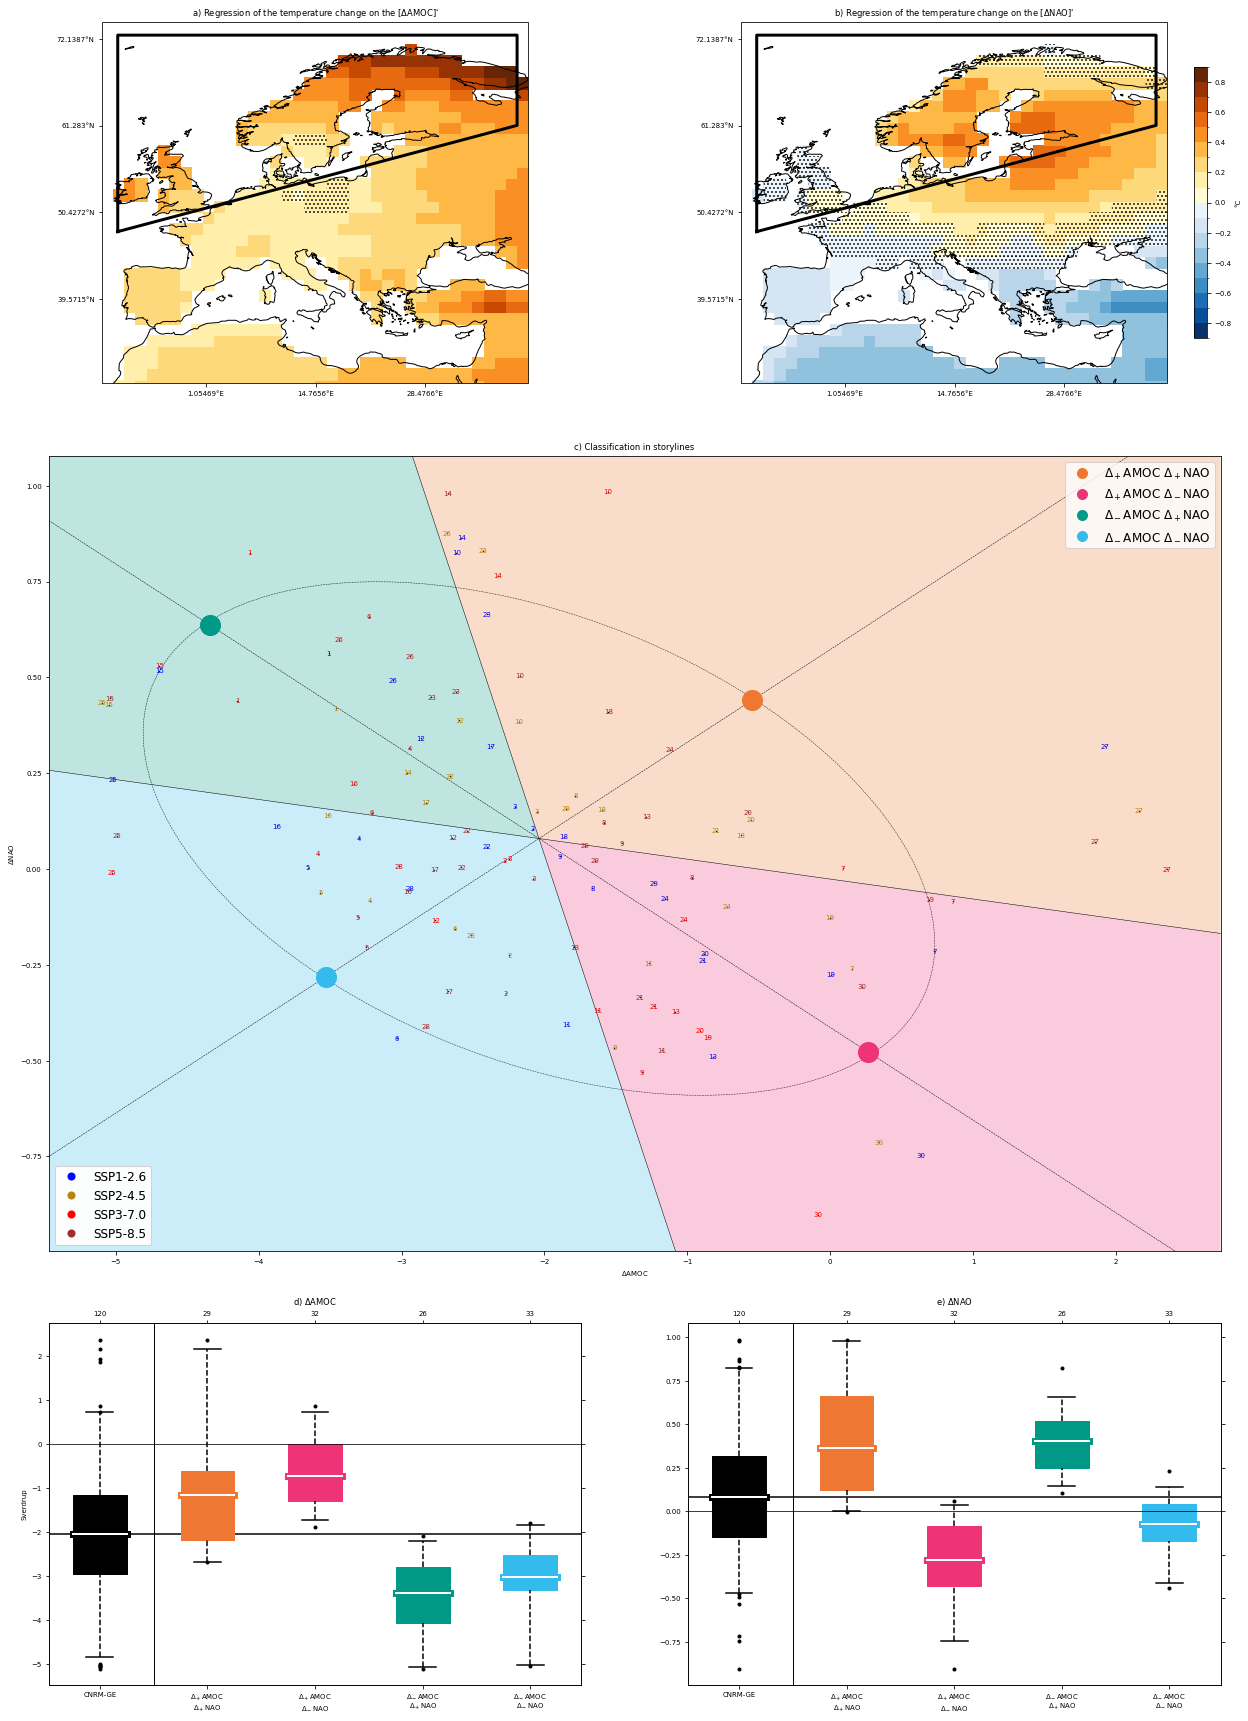

In [63]:

figsize = (21, 30)
nbins=21

fig = plt.figure(figsize=figsize)

_field = list(field_ano_raw.keys())[0]
cmap_params = {'vmin': -1, 'vmax': 1}
#fig, ax = plt.subplots(1, story.ndrivers, figsize = (15*story.ndrivers, 10), subplot_kw = dict(projection=ccrs.PlateCarree())) #, gridspec_kw={'width_ratios': [3, 1]})
#fig.subplots_adjust(hspace=0.2,wspace=0.2)
_row_length = 10
for iD, _driver in enumerate(driver_ano):
    ###ax = plt.subplot(int(300+10*len(driver_ano)+iD+1), projection=ccrs.PlateCarree())
    #ax = plt.subplot2grid((4,len(driver_ano)*_row_length+1), (0, iD*_row_length), colspan=_row_length, projection=ccrs.PlateCarree())
    ax = plt.subplot2grid((4,len(driver_ano)), (0, iD), projection=ccrs.PlateCarree())
    _x = driver_ano.get(_driver); _y = field_ano_raw.get(_field)
    _X = (_x - _x.mean()) / _x.std()
    slope_list = list(); pvalue_list = list()
    for _lat in _y.lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
        slope_list_lat = list(); pvalue_list_lat = list()
        for _lon in _y.lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
            if _y[0].sel(lat=_lat, lon=_lon):
                _Y = _y.sel(lat=_lat, lon=_lon)
                _slope, _, _rvalue, _pvalue, _ = scipy.stats.linregress(_X, _Y)
                _slope = xr.DataArray([[_slope]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                _pvalue = xr.DataArray([[_pvalue]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
            else:
                _slope = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                _pvalue = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
            slope_list_lat.append(_slope)
            pvalue_list_lat.append(_pvalue)
        slope_list.append(xr.concat(slope_list_lat, dim='lon'))
        pvalue_list.append(xr.concat(pvalue_list_lat, dim='lon'))
    slope = xr.concat(slope_list, dim='lat')
    pvalue = xr.concat(pvalue_list, dim='lat')

    vmax = .9
    vmin = -vmax
    cs = cc.maplot(slope, ax = ax, zmin=vmin, zmax=vmax, nbins=nbins, cmap=ccmp.get_diverging_cmap(**cmap_params), plotmode='raster', significance=pvalue)
    #bx = ccmps.plot_shape(shape_file=shape_file, name=region, ax = ax, color='k', linestyle='-', linewidth=3, zorder=None)
    ###si = ax.contourf(pvalue.lon, pvalue.lat, pvalue, levels = [0, significance_limit, 100], colors = 'none', hatches = [None, '....'])
    ax.coastlines()
    ax.set_extent(zone)
    #fig.colorbar(cs, ax=ax[iD], #label=_y.attrs['units']+r' / $\sigma$(\Delta'+_d+')',
    #             orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')

    if show_box is not None:
        for _region in show_box:
            if _region in ['FRA']:
                shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
            else:
                shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
            bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = ax, color='k', linestyle='-', linewidth=3, zorder=None, disp_name= False if len(show_box) == 1 else True)

    ax.set_title(subfigure_label[iD]+r'Regression of the temperature change on the ['+delta_print+_driver+"]'")
    #fig.colorbar(cs, ax=ax, label='', orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')

#ax = plt.subplot2grid((4,len(driver_ano)*_row_length+1), (0, len(driver_ano)*_row_length))
fig.colorbar(cs, ax=ax, label='°C', orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')

if len(drivers) == 2:
    #ax = plt.subplot(335)
    ###ax = plt.subplot(312)
    ax = plt.subplot2grid((4,1), (1,0), rowspan=2)
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    for _model in members_dict.keys():
        for _experiment in members_dict[_model].keys():
            for _member in members_dict[_model][_experiment]:
                plt.text(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=_member),
                            main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=_member),
                            _member.split('_r')[-1].split('i')[0],
                            c = experiment_colors[_experiment],
                            horizontalalignment='center', verticalalignment='center')
    #x_lim = ax.get_xlim(); y_lim = ax.get_ylim(); ax.set_xlim(x_lim); ax.set_ylim(y_lim)
    #ax.set_xlim(-10,10); ax.set_ylim(-2,2)
    story.plot_quadrants(ax=ax, show_members=True, show_stories=True, markersize=1)
    _xMin, _xMax = ax.get_xlim()
    _yMin, _yMax = ax.get_ylim()
    _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
        [story.outputs.storindex[0,1], story.outputs.storindex[3,1]],
        [story.outputs.storindex[0,0], story.outputs.storindex[3,0]])
    ax.plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
            c = 'k', lw = .5, ls = '--', zorder = 1)
    _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
        [story.outputs.storindex[1,1], story.outputs.storindex[2,1]],
        [story.outputs.storindex[1,0], story.outputs.storindex[2,0]])
    ax.plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
            c = 'k', lw = .5, ls = '--', zorder = 1)
    lgd_sto = ax.legend(handles = story_legend_point, loc='upper right', fontsize=12)
    ax.add_artist(lgd_sto)
    if len(model) != 1:
        lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
        ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    ax.set_title(subfigure_label[len(driver_ano)]+'Classification in storylines')

for iD, _driver in enumerate(driver_ano):

    _data = driver_ano[_driver]

    _members = list(_data.member.values); _members.sort(); _data.sortby('member')
    _members_dict = cc.cmip6.get_members_dict(_members)

    model_data = {_model: [] for _model in _members_dict}
    experiment_data = {_experiment: [] for _experiment in experiments}
    experiment_data_weights = {_experiment: [] for _experiment in experiments}

    for iM, _model in enumerate(_members_dict):
        for i, _experiment in enumerate(experiments):
            if _experiment in _members_dict[_model].keys():
                for _member in _members_dict[_model][_experiment]:
                    experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                    experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)

    #fig, ax = plt.subplots(figsize = figsize)
    ###ax = plt.subplot(int(300+12*len(driver_ano)+iD+1))
    ax = plt.subplot2grid((4,len(driver_ano)), (3,iD))
    tick_positions = list(); tick_labels = list()

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)

    tick_labels.append(len(_data.member))

    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
        ccplt.boxplot([_data.sel(member=_story_members)],
                        weights = [da_weight.sel(member=_story_members)],
                        color = [story.colors[iS]],
                        bar = bp_median_mean, box = bp_box, ext = bp_ext,
                        dx=1+iS, width = 0.5)

        tick_labels.append(len(_story_members))
    ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
                    bar = bp_median_mean, box = bp_box, ext = bp_ext, width = 0.5)
    ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(1+len(story.stories)))
    ax.set_xticklabels(
        ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
        rotation=0) # 90
    ax.set_ylabel(_data.attrs['units'])
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(np.arange(1+len(story.stories)))
    ax2.set_xticklabels(tick_labels)
    ax.axvline(x=0.5,color='k',lw=1)
    ax.set_title(subfigure_label[len(driver_ano)+1+iD]+delta_print+_driver)

    plt.savefig(figDir+saveName+'-paper_fig2.pdf', transparent=True)

## Étude du méga-ensemble

In [64]:
for _target in target_ano:
    print(_target)
    _neg = np.sum(target_ano[_target].values <= 0.)
    _pos = np.sum(target_ano[_target].values >= 0.)
    _tot = len(target_ano[_target].values)
    print('Negative anomalies:', _neg, '({0:.1f}%)'.format(_neg/_tot*100.))
    print('Positive anomalies:', _pos, '({0:.1f}%)'.format(_pos/_tot*100.))
    print()

tas_NEU_land
Negative anomalies: 9 (7.5%)
Positive anomalies: 111 (92.5%)

pr_NEU_land
Negative anomalies: 21 (17.5%)
Positive anomalies: 99 (82.5%)

prsn_NEU_land
Negative anomalies: 59 (49.2%)
Positive anomalies: 61 (50.8%)

snc_NEU_land
Negative anomalies: 111 (92.5%)
Positive anomalies: 9 (7.5%)

sfcWind_NEU_land
Negative anomalies: 44 (36.7%)
Positive anomalies: 76 (63.3%)

rsds_NEU_land
Negative anomalies: 67 (55.8%)
Positive anomalies: 53 (44.2%)

prlq_NEU_land
Negative anomalies: 12 (10.0%)
Positive anomalies: 108 (90.0%)



tas_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


pr_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prsn_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


snc_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


sfcWind_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


rsds_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prlq_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Mega-ensemble


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


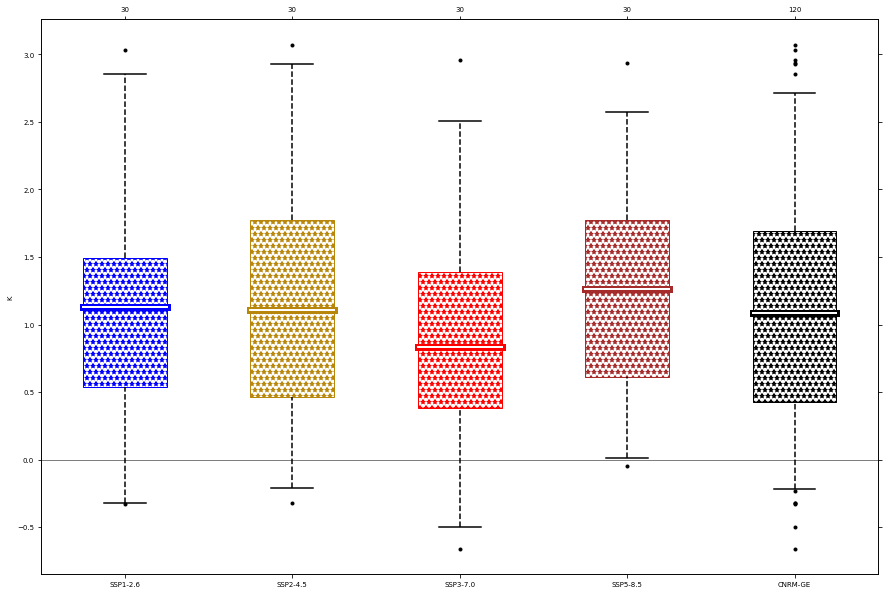

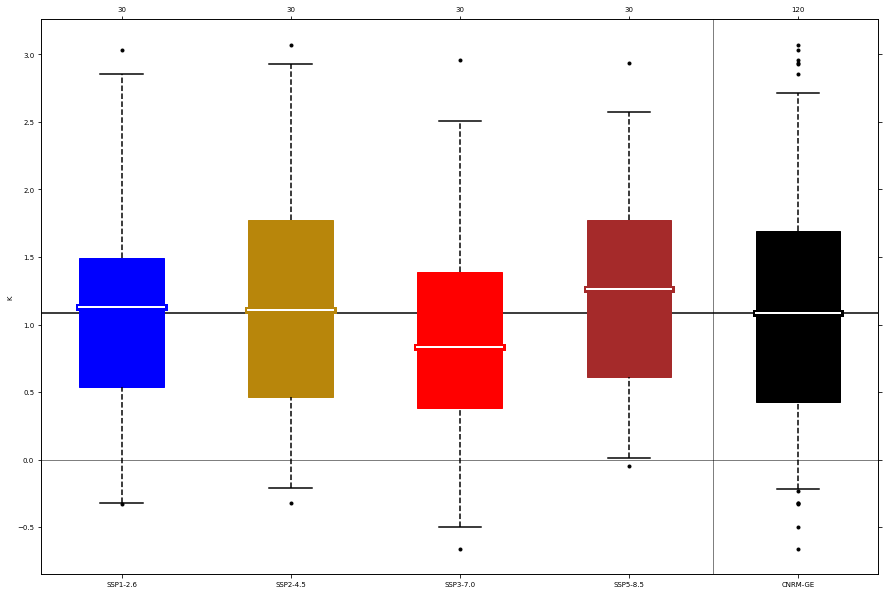

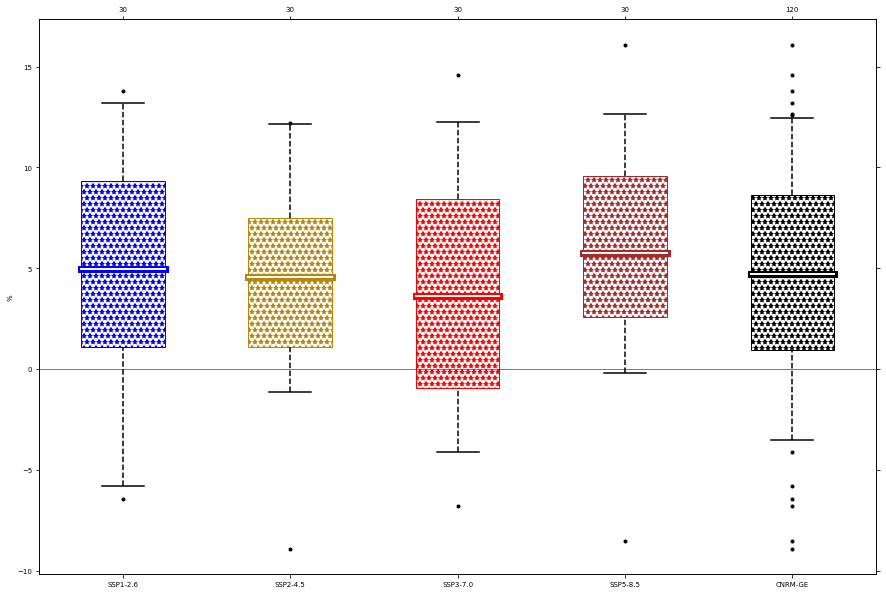

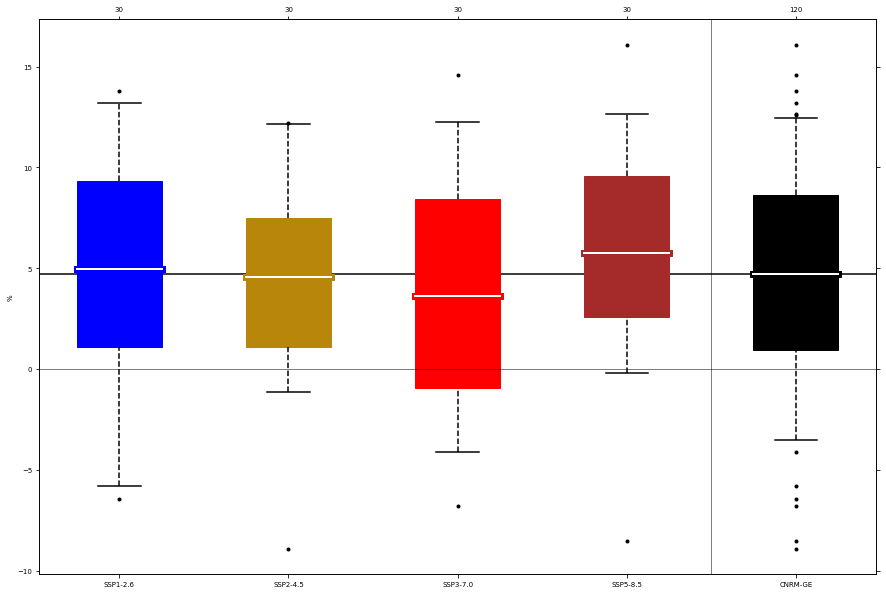

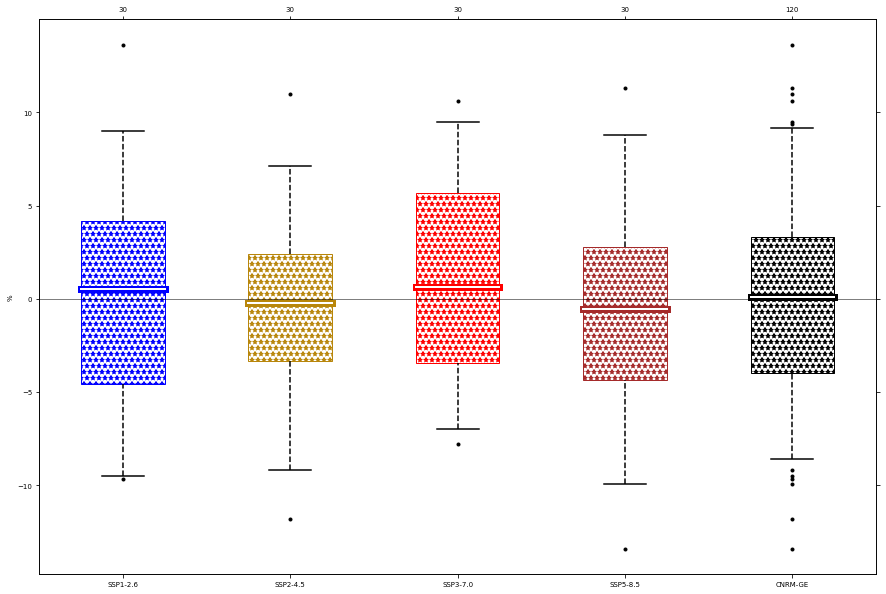

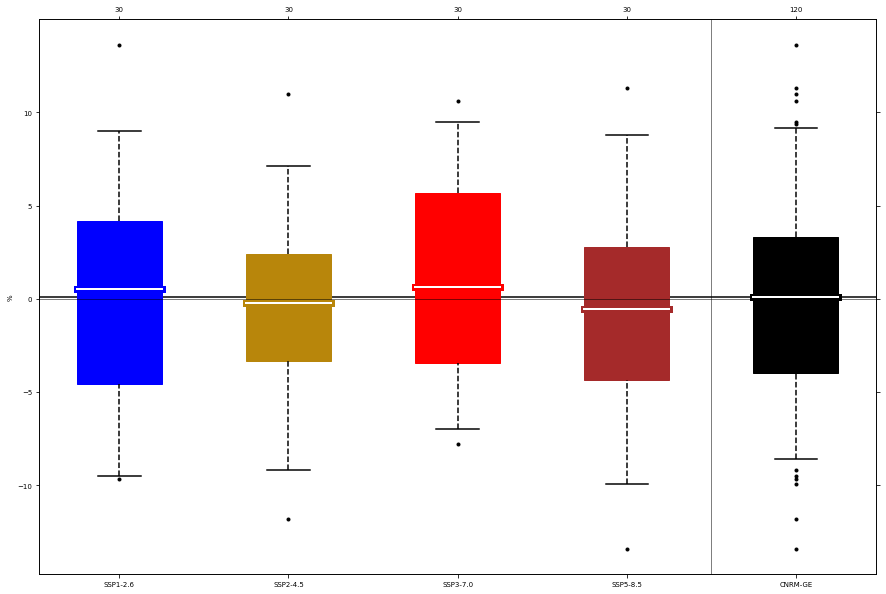

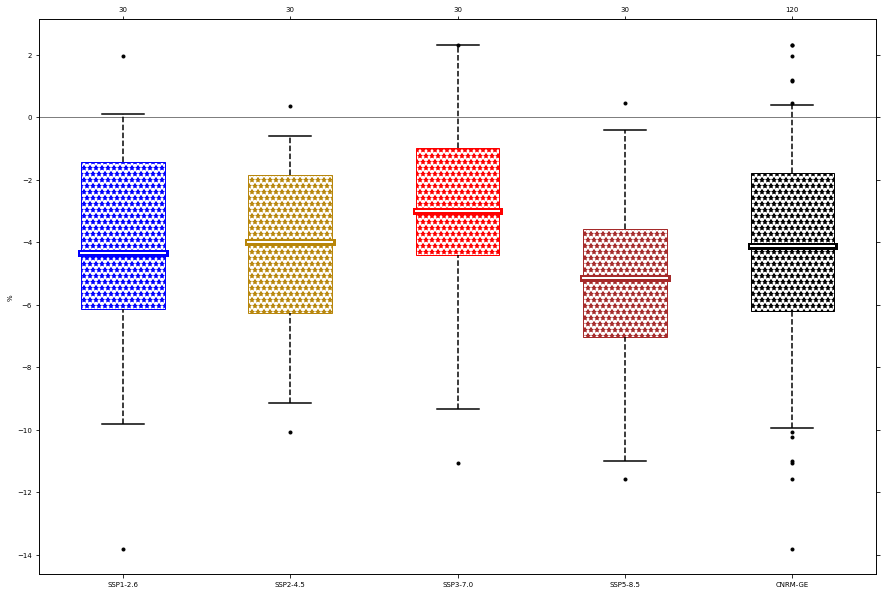

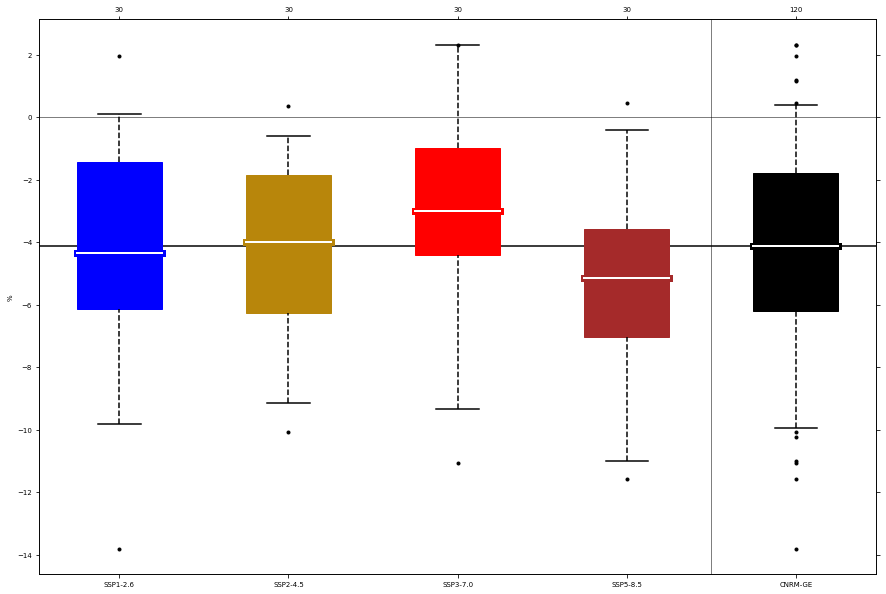

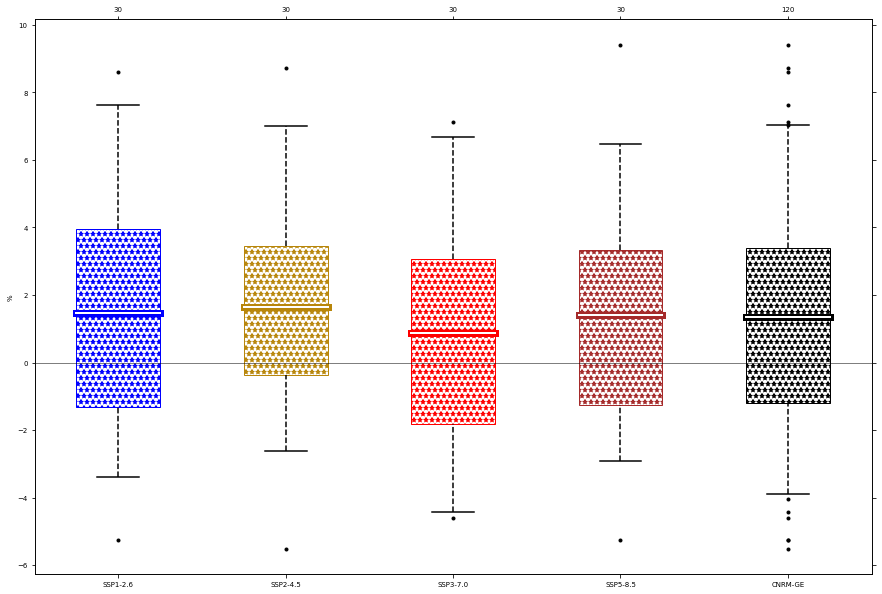

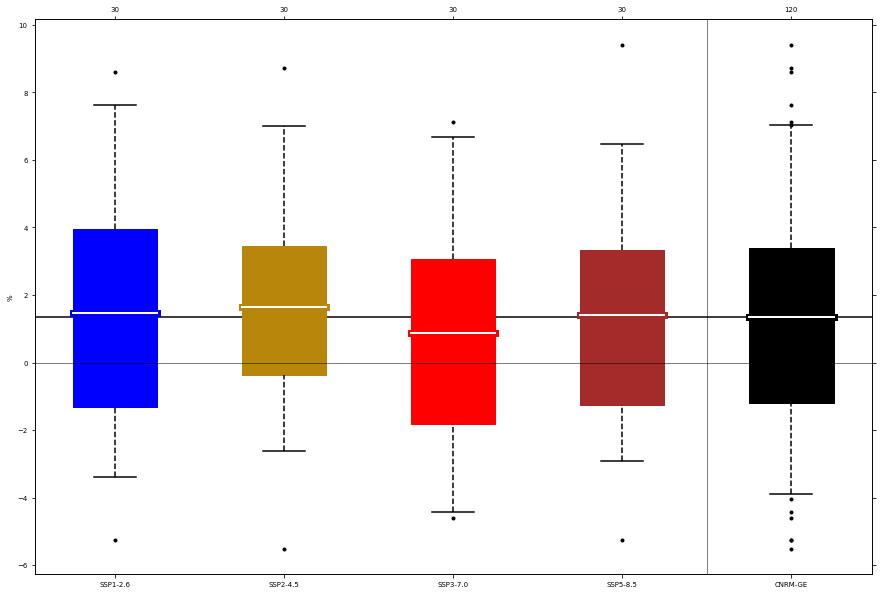

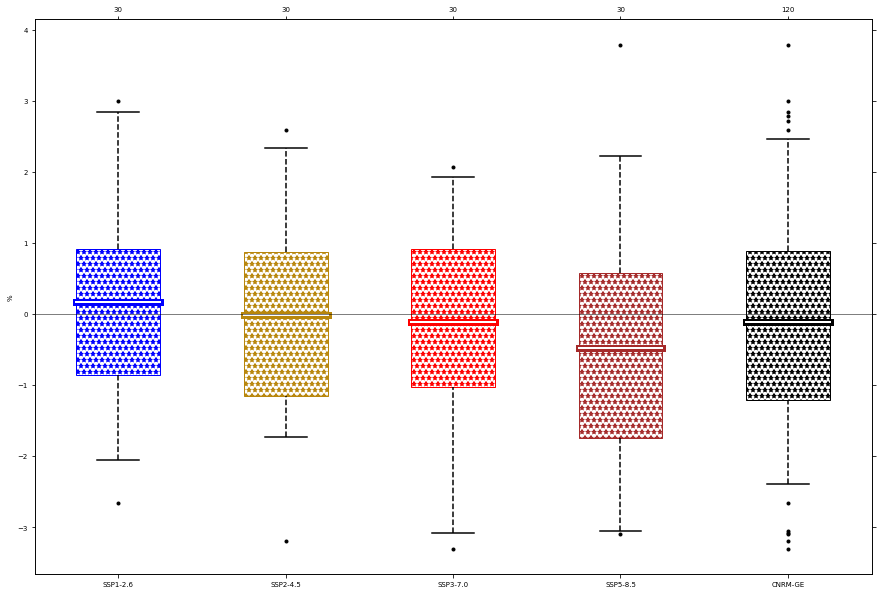

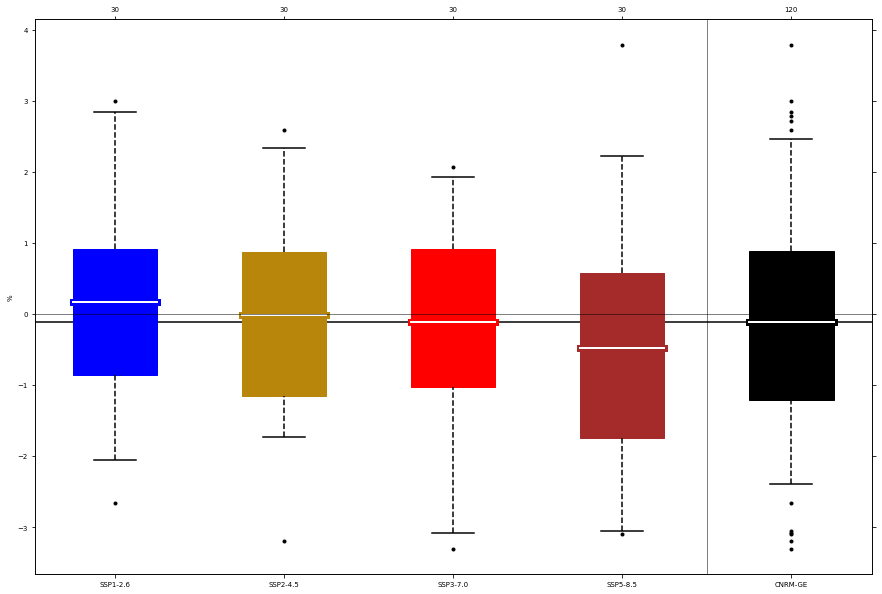

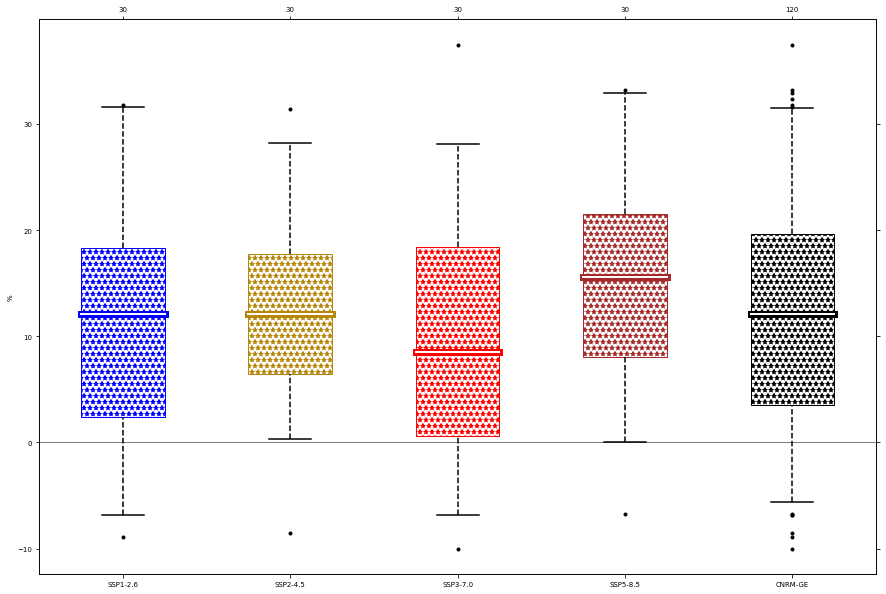

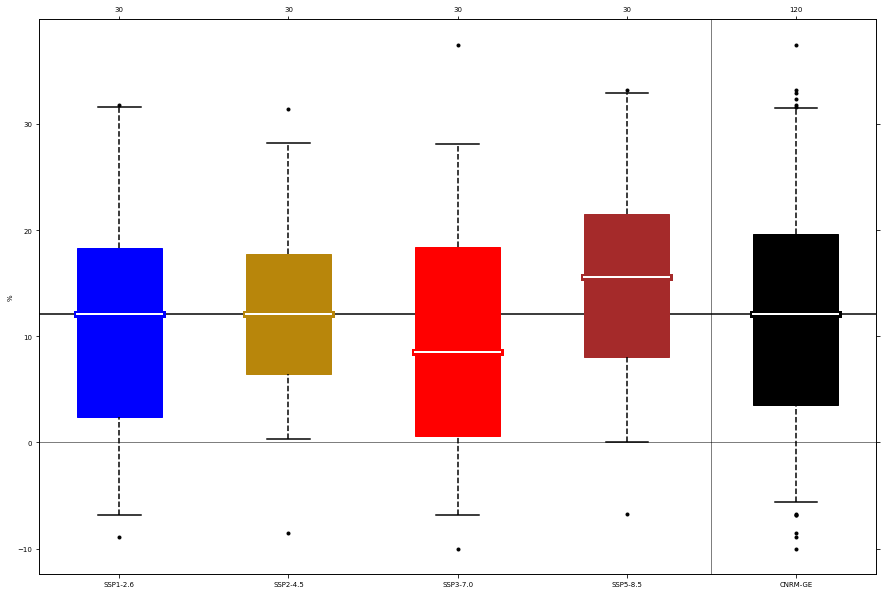

In [65]:
ccscp = reload(ccscp)

_show_mega_ensemble = True
_median_mean='mean'

figsize = (15, 10)

ds_signi = xr.Dataset()
for _target in target_ano:
    print(_target)

    _data = target_ano[_target]

    fig, ax = plt.subplots(figsize = figsize)

    #if _show_mega_ensemble:
    #    ccplt.boxplot(_data, color = 'k', label = None, hatch = None, bar = bp_median_mean, box = bp_box, ext = bp_ext,
    #                 dx=len(experiments), width = width)

    _tmp = list(_data.member.values); _tmp.sort()
    _dict = cc.cmip6.get_members_dict(_tmp)

    tick_positions = list()
    tick_labels = list()

    _signi_store0 = list()

    model_data = {_model: [] for _model in _dict}
    experiment_data = {_experiment: [] for _experiment in experiments}
    experiment_data_weights = {_experiment: [] for _experiment in experiments}

    for iM, _model in enumerate(_dict):
        #print(_model)
        loc_data = list()
        loc_colors = list(); loc_hatches = list()
        for i, _experiment in enumerate(experiments): # experiments
            loc_tmp = list()
            if _experiment in _dict[_model].keys():
                for _member in _dict[_model][_experiment]:
                    loc_tmp.append(float(_data.sel(member=_member).values))
                    model_data[_model].append(float(_data.sel(member=_member).values))
                    experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                    experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
                tick_positions.append(iM/len(_dict)+i)
                tick_labels.append(len(_dict[_model][_experiment]))
            else:
                loc_tmp.append(np.nan)
            loc_data.append(loc_tmp)
            loc_colors.append(cc.cmip6.experiment_dict[_experiment]['color'])
            loc_hatches.append(model_hatches[_model])
        loc_data.append(_data.sel(member=[_member for _member in _data.member.values if _model in _member]).values)
        loc_colors.append('k')
        loc_hatches.append(model_hatches[_model])

        ccplt.boxplot(loc_data, color = loc_colors, hatch = loc_hatches, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=iM/len(_dict), width = 0.5/len(_dict))

        _signi_store1 = list()
        for iR, _sub_ref in enumerate(loc_data):
            _signi_store2 = list()
            for iT, _sub_test in enumerate(loc_data):
                _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test).pvalue,
                                      ccscp.ftest_ind(_sub_ref, _sub_test).pvalue])
            _signi_store1.append(_signi_store2)
        _signi_store0.append(
            xr.DataArray(np.array(_signi_store1).transpose(),
                         name = _target,
                         dims=['test', 'r', 'c'],
                         coords={'test': ['T-test', 'F-test'], 'r':experiments+ensemble_name, 'c':experiments+ensemble_name}).assign_coords({'source_id': _model}))
    ds_signi = ds_signi.assign({_target: xr.concat(_signi_store0, dim='source_id')})
    for _model in _dict:
        print(_model)
        for _test in ds_signi.test:
            print('Null hypothesis: '+h0[str(_test.values)])
            display(ds_signi.get(_target).sel(test=_test, source_id=_model).to_pandas().style.format("{:.0%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

    '''
    print()
    print('\\hline\\hline')
    print('\multicolumn{6}{c}{'+_model+'}\\\\')
    print('\\hline')
    print('ME réduit & ${0:.1f}\%$'.format(score_ini_rem*100)+' & ${0:.1f}\%$'.format(_story_rem.score*100)+' & ${0:.1f}\%$'.format(sum(interception_rem)/(len(members)-_len)*100)+' & ${0:.1f}\%$'.format(score_sub*100)+' & ${0:.1f}\%$'.format(sum(interception_sub_pred)/(len(members)-_len)*100)+'\\\\')
    print('\\hline')
    print('Modèle seul & ${0:.1f}\%$'.format(score_ini_sub*100)+' & ${0:.1f}\%$'.format(score_rem*100)+' & ${0:.1f}\%$'.format(sum(interception_rem_pred)/(_len)*100)+' & ${0:.1f}\%$'.format(_story_sub.score*100)+' & ${0:.1f}\%$'.format(sum(interception_sub)/(_len)*100)+'\\\\')
    print()
    '''

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(len(experiments)+1)+.5-0.5/len(_dict))
    ax.set_xticklabels([cc.cmip6.experiment_dict[s]['name'] for s in experiments]+ensemble_name, rotation=0) # 90
    if _show_mega_ensemble:
        ax.set_xlim([-.5/len(_dict), len(experiments)+0.5/len(_dict)])
    else:
        ax.set_xlim([-.5/len(_dict), len(experiments)-0.5/len(_dict)])
    if _prefix == 'norm_':
        y_norm(ax=ax)
    else:
        ax.set_ylabel(_data.attrs['units'])
    if len(model) != 1:
        lgd = plt.legend(handles = model_legend_box, loc='lower left', fontsize=12)
        ax.add_artist(lgd)
        for i in range(len(experiments)+1):
            ax.axvline(x=i-0.5/len(_dict),color='k',lw=1)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    tick_positions = list(np.array(tick_positions).flatten())
    tick_labels = list(np.array(tick_labels).flatten())
    if _show_mega_ensemble:
        tick_positions.append(float(len(experiments)))
        tick_labels.append(str(len(members)))
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)

    #ax.axhline(y=ccnp.mean(_data, weights=da_weight),color='k')
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_megaensemble.pdf', transparent=True)

    if len(experiments) != 1:
        print('Mega-ensemble')
        fig, ax = plt.subplots(figsize = figsize)
        tick_positions = list(); tick_labels = list()
        for iE, _experiment in enumerate(experiments):
            ccplt.boxplot([experiment_data[_experiment]],
                          weights = [experiment_data_weights[_experiment]],
                          color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                          dx=iE, width = 0.5)
            tick_positions.append(iE)
            tick_labels.append(len(experiment_data[_experiment]))
        ccplt.boxplot([_data], weights = [da_weight.sel(member=_data.member)],
                     color = 'k', bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=len(experiments), width = 0.5)
        tick_positions.append(len(experiments))
        tick_labels.append(len(_data))
        ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member)), color='k', zorder=0)
        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.axvline(x=len(experiments)-.5,color='k',lw=.5)
        ax.set_xticks(np.arange(len(experiments)+1)+.5-0.5)
        ax.set_xticklabels([experiment_labels[_experiment] for _experiment in experiments]+ensemble_name, rotation=0)
        ax.set_ylabel(_data.attrs['units'])
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)
        plt.savefig(figDir+saveName+'-'+_target+'_boxplot_SSP.pdf', transparent=True)

        ds_signi_ME = xr.Dataset()
        _signi_storeME1 = list()
        for _experiment in experiments:
            _signi_storeME2 = list()
            _sub_ref = experiment_data[_experiment]
            _wei_ref = experiment_data_weights[_experiment]
            for _experiment in experiments:
                _sub_test = experiment_data[_experiment]
                _wei_test = experiment_data_weights[_experiment]
                _signi_storeME2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights=[_wei_ref, _wei_test]).pvalue,
                                        ccscp.ftest_ind(_sub_ref, _sub_test, weights=[_wei_ref, _wei_test]).pvalue])
            _signi_storeME1.append(_signi_storeME2)
        ds_signi_ME = ds_signi_ME.assign({
            _target: xr.DataArray(np.array(_signi_store1).transpose(),
                                  name = _target,
                                  dims=['test', 'r', 'c'],
                                  coords={'test': ['T-test', 'F-test'], 'r':experiments+ensemble_name, 'c':experiments+ensemble_name})})
        for _test in ds_signi_ME.test:
            print('Null hypothesis: '+h0[str(_test.values)])
            display(ds_signi_ME.get(_target).sel(test=_test).to_pandas().style.format("{:.0%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

    if len(model) != 1:
        print('Mega-ensemble:', ccnp.mean(_data, weights=da_weight.sel(member=_data.member)))
        fig, ax = plt.subplots(figsize = figsize)
        tick_positions = list(); tick_labels = list()
        for iM, _model in enumerate(model_data):
            print(_model, np.mean(model_data[_model]))
            ccplt.boxplot([model_data[_model]],
                         hatch = model_hatches[_model], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=iM, width = 0.5)
            tick_positions.append(iM)
            tick_labels.append(len(model_data[_model]))
        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.axvline(x=len(model),color='k',lw=.5)
        ax.set_xticks(np.arange(len(model_data))+.5-0.5)
        ax.set_xticklabels(model_data, rotation=0)
        ax.set_ylabel(_data.attrs['units'])
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)
        plt.savefig(figDir+saveName+'-'+_target+'_boxplot_model.pdf', transparent=True)


### Comparaisons des scénarios socio-économiques (SSP)

tas_NEU_land
<xarray.DataArray 'tas_NEU_land' ()>
array(1.42911049)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/13)
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    ...                  ...
    history:             none
    units:               K
    cell_measures:       area: areacella
    lon_flip:            True
    mask_land:           True
    region:              NEU
<xarray.DataArray 'tas_NEU_land' ()>
array(0.07746483)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attributes: (12/13)
    online_operation:  

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

pr_NEU_land
<xarray.DataArray 'pr_NEU_land' ()>
array(9.31428417)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/13)
    long_name:           Precipitation
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    ...                  ...
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella
    mask_land:           True
    lon_flip:            True
    region:              NEU
<xarray.DataArray 'pr_NEU_land' ()>
array(1.66430804)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attributes: (12/13)
 

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

prsn_NEU_land
<xarray.DataArray 'prsn_NEU_land' ()>
array(3.24295478)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/13)
    long_name:           Snowfall Flux
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    ...                  ...
    description:         at surface; includes precipitation of all forms of w...
    history:             none
    cell_measures:       area: areacella
    lon_flip:            True
    mask_land:           True
    region:              NEU
<xarray.DataArray 'prsn_NEU_land' ()>
array(1.56710357)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attributes: (12

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

snc_NEU_land
<xarray.DataArray 'snc_NEU_land' ()>
array(-6.363435, dtype=float32)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/14)
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    ...                  ...
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella
    mask_land:           True
    lon_flip:            True
    region:              NEU
<xarray.DataArray 'snc_NEU_land' ()>
array(-1.133785, dtype=float32)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

sfcWind_NEU_land
<xarray.DataArray 'sfcWind_NEU_land' ()>
array(5.97214077)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/13)
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       wind_speed
    description:         This is the mean of the speed, not the speed compute...
    ...                  ...
    history:             none
    units:               %
    cell_measures:       area: areacella
    mask_land:           True
    lon_flip:            True
    region:              NEU
<xarray.DataArray 'sfcWind_NEU_land' ()>
array(1.02692867)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attribute

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

rsds_NEU_land
<xarray.DataArray 'rsds_NEU_land' ()>
array(-1.04263697)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes: (12/14)
    long_name:           Surface Downwelling Shortwave Radiation
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    ...                  ...
    positive:            down
    history:             none
    cell_measures:       area: areacella
    lon_flip:            True
    mask_land:           True
    region:              NEU
<xarray.DataArray 'rsds_NEU_land' ()>
array(2.99057702)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attributes: (12/14)
    long_name:     

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

prlq_NEU_land
<xarray.DataArray 'prlq_NEU_land' ()>
array(18.32377395)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r10i1p1f2'
Attributes:
    units:    %
<xarray.DataArray 'prlq_NEU_land' ()>
array(1.79085298)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r11i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r11i1p1f2'
Attributes:
    units:    %
<xarray.DataArray 'prlq_NEU_land' ()>
array(11.20031195)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r12i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <U11 'hist-ssp126'
    member_id      <U9 'r12i1p1f2'
Attributes:
    units:    %
<xarray.DataArray 'prlq_NEU_land' ()>
array(10.48315383)
Coordinates:
    member         <U32 'CNRM-CM6-1_hist-ssp126_r13i1p1f2'
    source_id      <U10 'CNRM-CM6-1'
    experiment_id  <

CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Sample variances are significantly different.


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

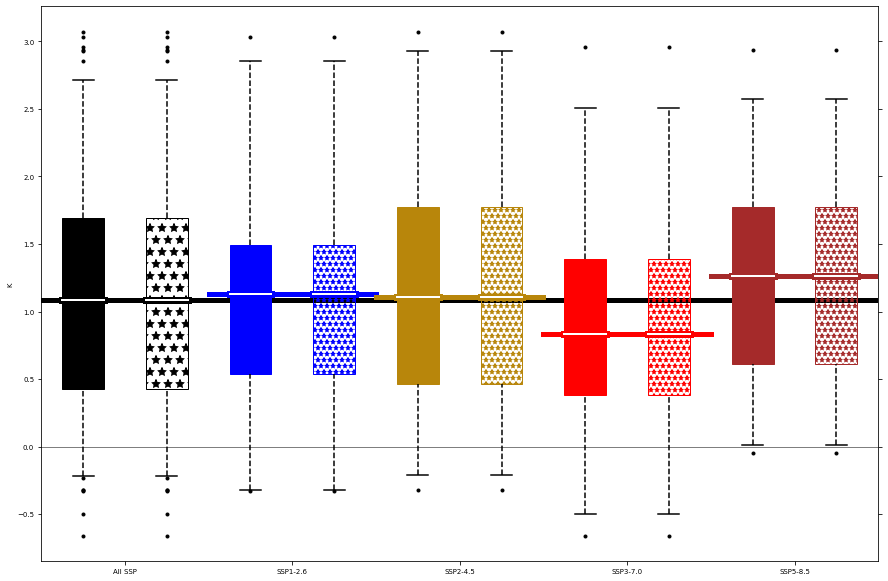

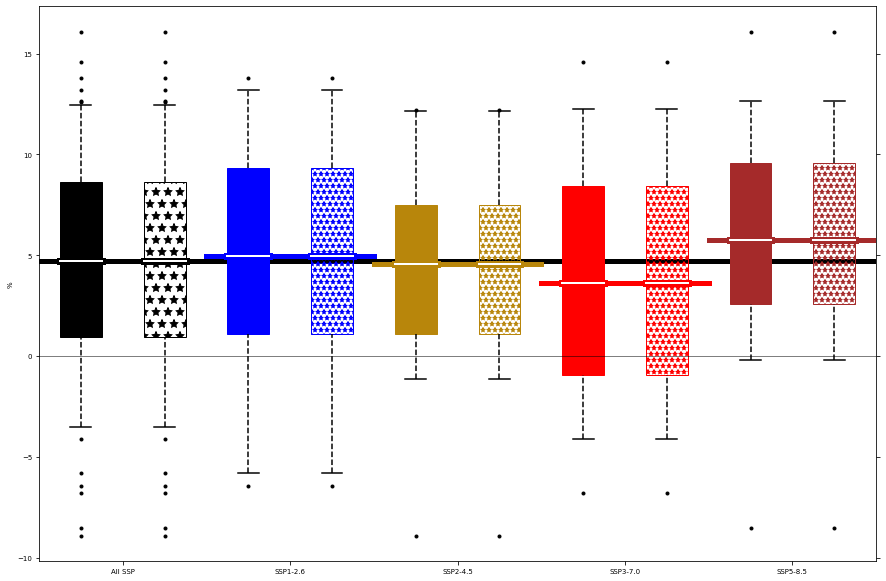

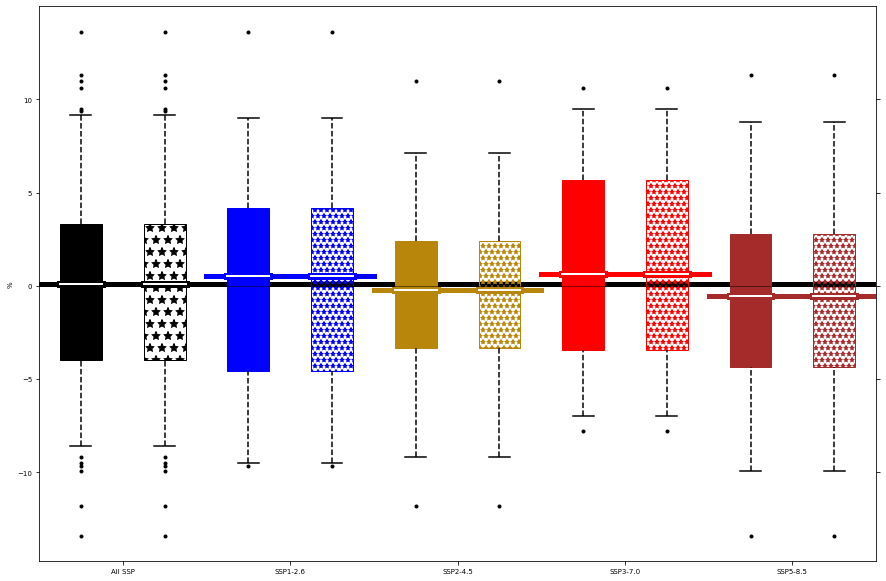

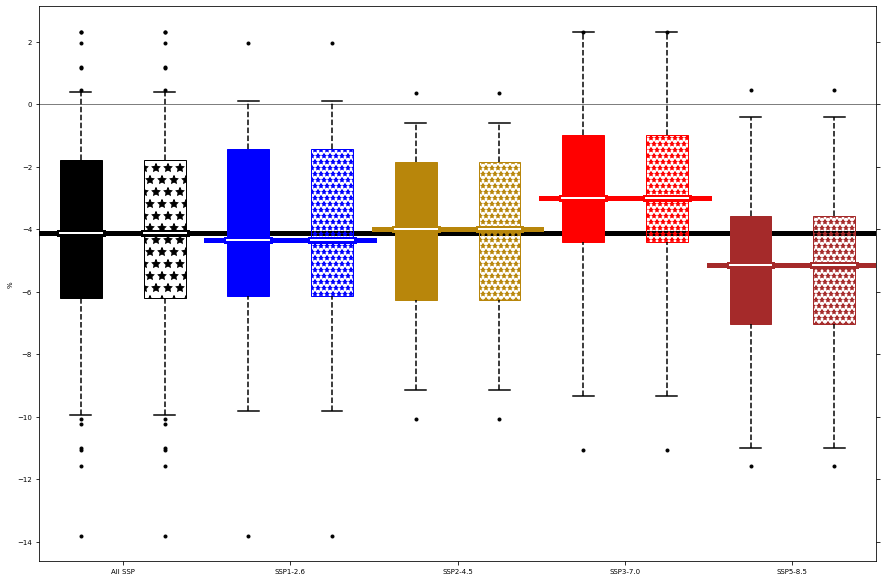

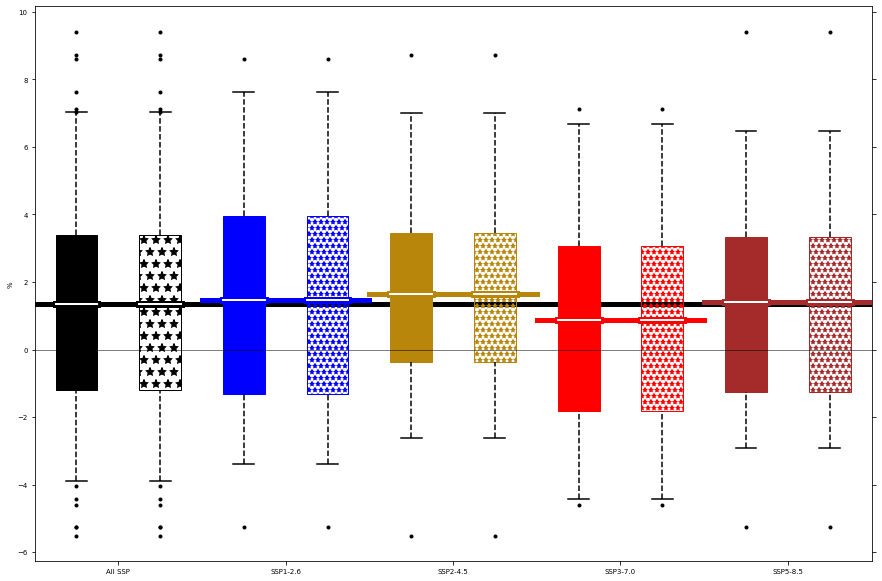

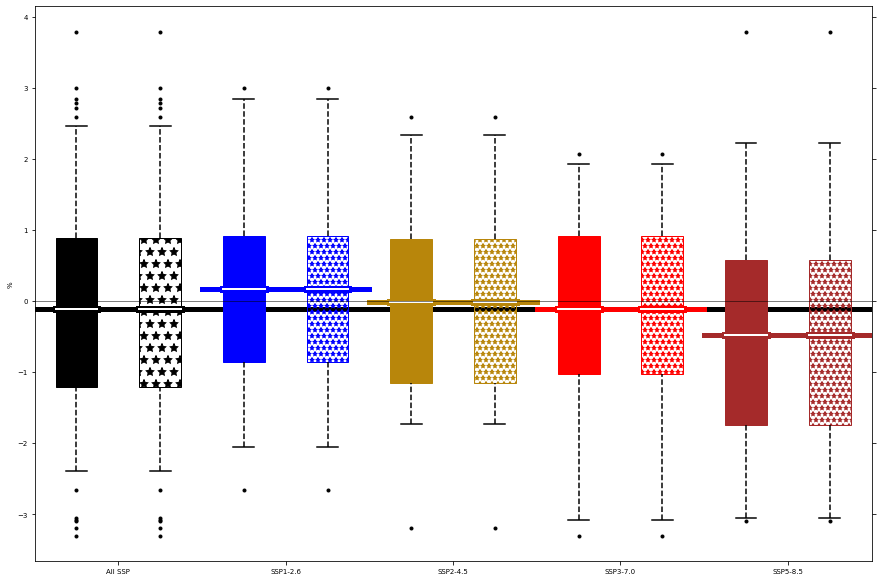

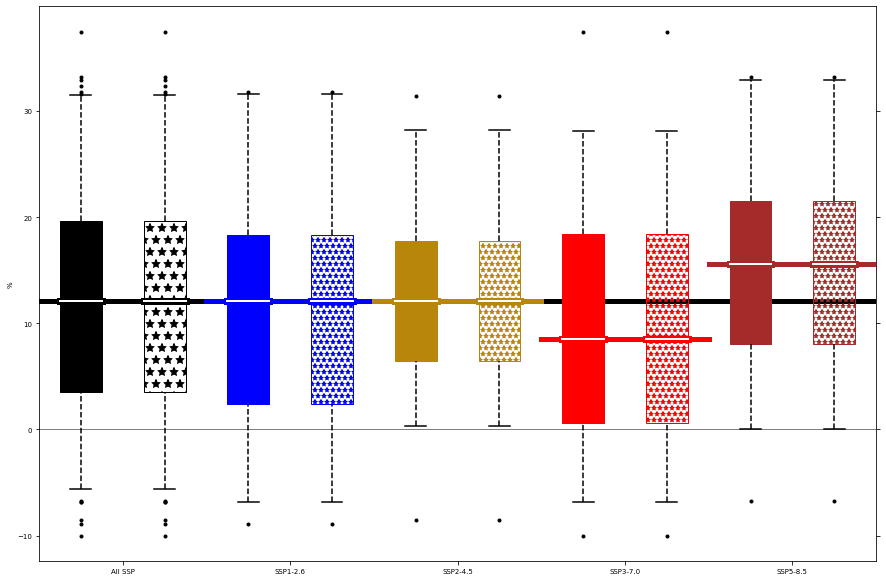

In [67]:
ccscp = reload(ccscp)
ccmip = reload(ccmip)

_show_mega_ensemble = False
_median_mean='mean'

figsize = (15, 10)

ds_signi = xr.Dataset()
for _target in target_ano:
    print(_target)

    _data = target_ano[_target]
    _data_flatten = ccmip.flatten_iv(_data)
    _da_weight_flat = ccmip.get_weight(_data_flatten)

    fig, ax = plt.subplots(figsize = figsize)

    if _show_mega_ensemble:
        ccplt.boxplot(_data, color = 'k', label = None, hatch = None, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=len(experiments), width = width)

    _tmp = list(_data.member.values); _tmp.sort()
    _dict = cc.cmip6.get_members_dict(_tmp)

    tick_positions = list()
    tick_labels = list()

    _signi_store0 = list()

    model_data = {_model: [] for _model in _dict}
    experiment_data = {_experiment: [] for _experiment in experiments}
    experiment_data_weights = {_experiment: [] for _experiment in experiments}

    _divider = len(_dict)+1
    #ax.axhline(y = ccnp.mean(_data, weights=da_weight.sel(member=_data.member)), color = 'k', lw = 5, zorder = 0)
    ax.axhline(y = ccnp.mean(_data_flatten, weights=_da_weight_flat), color = 'k', lw = 5, zorder = 0)

    for iM, _model in enumerate(_dict):
        #print(_model)
        loc_data = list()
        loc_colors = list(); loc_hatches = list()
        for i, _experiment in enumerate(experiments): # experiments
            loc_tmp = list()
            if _experiment in _dict[_model].keys():
                for _member in _dict[_model][_experiment]:
                    #loc_tmp.append(float(_data.sel(member=_member).values))
                    #model_data[_model].append(float(_data.sel(member=_member).values))
                    #experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                    #experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
                    print(_data.sel(member=_member))
                    _loc_data = ccmip.flatten_iv(_data.sel(member=_member))
                    loc_tmp.append(float(_loc_data.values))
                    model_data[_model].append(float(_loc_data.values))
                    experiment_data[_experiment].append(float(_loc_data.values))
                    experiment_data_weights[_experiment].append(_da_weight_flat.sel(member=_loc_data.member).values)
                tick_positions.append(iM/_divider+i)
                tick_labels.append(len(_dict[_model][_experiment]))
            else:
                loc_tmp.append(np.nan)
            loc_data.append(loc_tmp)
            loc_colors.append(cc.cmip6.experiment_dict[_experiment]['color'])
            loc_hatches.append(model_hatches[_model])

        ccplt.boxplot(loc_data, color = loc_colors, hatch = loc_hatches, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=(iM+1)/_divider, width = 0.5/_divider)

        ccplt.boxplot([model_data[_model]],
                     hatch = model_hatches[_model], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=-1+(iM+1)/_divider, width = 0.5/_divider)

        _signi_store1 = list()
        for iR, _sub_ref in enumerate(loc_data):
            _signi_store2 = list()
            for iT, _sub_test in enumerate(loc_data):
                _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test).pvalue,
                                      ccscp.ftest_ind(_sub_ref, _sub_test).pvalue])
            _signi_store1.append(_signi_store2)
        _signi_store0.append(
            xr.DataArray(np.array(_signi_store1).transpose(),
                         name = _target,
                         dims=['test', 'r', 'c'],
                         coords={'test': ['T-test', 'F-test'], 'r':experiments, 'c':experiments}).assign_coords({'source_id': _model}))
    ds_signi = ds_signi.assign({_target: xr.concat(_signi_store0, dim='source_id')})
    for _model in _dict:
        print(_model)
        for _test in ds_signi.test:
            print('Null hypothesis: '+h0[str(_test.values)])
            display(ds_signi.get(_target).sel(test=_test, source_id=_model).to_pandas().style.format("{:.0%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))
            pass

    for iE, _experiment in enumerate(experiments):
        ax.axhline(xmin = (1+iE)/(1+len(experiments)), xmax = (iE+2)/(1+len(experiments)),
                   y = ccnp.mean(experiment_data[_experiment], weights = experiment_data_weights[_experiment]),
                   color = experiment_colors[_experiment], lw = 5, zorder = 1)
        ccplt.boxplot([experiment_data[_experiment]],
                      weights = [experiment_data_weights[_experiment]],
                      color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                      dx=iE, width = 0.5/_divider)

    ccplt.boxplot([_data], weights = [da_weight.sel(member=_data.member)], bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=-1, width = 0.5/_divider)

    '''
    print()
    print('\\hline\\hline')
    print('\multicolumn{6}{c}{'+_model+'}\\\\')
    print('\\hline')
    print('ME réduit & ${0:.1f}\%$'.format(score_ini_rem*100)+' & ${0:.1f}\%$'.format(_story_rem.score*100)+' & ${0:.1f}\%$'.format(sum(interception_rem)/(len(members)-_len)*100)+' & ${0:.1f}\%$'.format(score_sub*100)+' & ${0:.1f}\%$'.format(sum(interception_sub_pred)/(len(members)-_len)*100)+'\\\\')
    print('\\hline')
    print('Modèle seul & ${0:.1f}\%$'.format(score_ini_sub*100)+' & ${0:.1f}\%$'.format(score_rem*100)+' & ${0:.1f}\%$'.format(sum(interception_rem_pred)/(_len)*100)+' & ${0:.1f}\%$'.format(_story_sub.score*100)+' & ${0:.1f}\%$'.format(sum(interception_sub)/(_len)*100)+'\\\\')
    print()
    '''

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(-1, len(experiments))+.5-0.5/_divider)
    #ax.set_xticklabels(['Model']+[cc.cmip6.experiment_dict[s]['name'] for s in experiments], rotation=0) # 90
    ax.set_xticklabels(['All SSP']+[cc.cmip6.experiment_dict[s]['name'] for s in experiments], rotation=0) # 90
    if _show_mega_ensemble:
        ax.set_xlim([-1-.5/_divider, len(experiments)+0.5/_divider])
    else:
        ax.set_xlim([-1-.5/_divider, len(experiments)-0.5/_divider])
    if _prefix == 'norm_':
        y_norm(ax=ax)
    else:
        ax.set_ylabel(_data.attrs['units'])
    if len(model) != 1:
        lgd = plt.legend(handles = model_legend_box, loc='lower left', fontsize=12)
        ax.add_artist(lgd)
        for i in range(len(experiments)+1):
            ax.axvline(x=i-0.5/_divider,color='k',lw=1)
            #ax.plot((i-0.5/_divider)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
    #ax2 = ax.twiny()
    #ax2.set_xlim(ax.get_xlim())
    #tick_positions = list(np.array(tick_positions).flatten())
    #tick_labels = list(np.array(tick_labels).flatten())
    #if _show_mega_ensemble:
    #    tick_positions.append(float(len(experiments)))
    #    tick_labels.append(str(len(members)))
    #ax2.set_xticks(tick_positions)
    #ax2.set_xticklabels(tick_labels)

    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_detail_SSP.pdf', transparent=True)

## Cascade

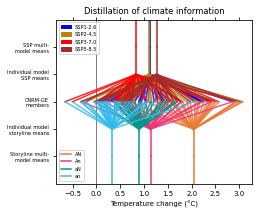

In [68]:
figsize = (single_column_width, 75*mm)
for _target in target_ano:
    if 'tas' in _target:
        fig, ax = plt.subplots(figsize = figsize)
        ax.set_title('Distillation of climate information')
        ax.set_xlabel('Temperature change (°C)')
        ax.axvline(x=0,c='k',lw=.5)
        ax.set_ylim(0,6); ax.xaxis.set_ticks_position('both')
        _data = target_ano.get(_target)
        _X = _data.weighted(da_weight.sel(member=_data.member)).mean()
        _dict_members = cc.cmip6.get_members_dict(_data.member.values)
        for _experiment in experiments:
            _members = [_member for _member in list(_data.member.values) if _experiment in _member]
            _Xe = _data.sel(member=_members).weighted(da_weight.sel(member=_members)).mean()
            ax.plot([_Xe, _Xe], [6, 5], c=experiment_colors[_experiment])
            _alpha = max(sum([1 for _model in list(_dict_members.keys()) if _experiment in list(_dict_members[_model].keys())])/2,1)
            for _model in list(_dict_members.keys()):
                if _experiment in _dict_members[_model]:
                    _Xm = _data.sel(member=_dict_members[_model][_experiment]).mean()
                    ax.plot([_Xe, _Xm], [5, 4],
                            c=experiment_colors[_experiment], alpha=min(1., 3./len(model)))
                    _Xr = _data.sel(member=_dict_members[_model][_experiment])
                    ax.plot([_Xm.values * np.ones_like(_Xr), _Xr.values], [4 * np.ones_like(_Xr), 3 * np.ones_like(_Xr)],
                            c=experiment_colors[_experiment], alpha=min(1., 100./len(_data.member)))
        lgd = plt.legend(handles = experiment_legend_box, loc='upper left', fontsize=5); ax.add_artist(lgd)
        ax.set_yticks([3, 4., 5.])
        ax.set_yticklabels([ensemble_name[0]+'\nmembers', 'Individual model\nSSP means', 'SSP multi-\nmodel means'], fontsize=5)
        plt.savefig(figDir+saveName+'-'+_target+'_uncertainties_cascade_SSP_model_story_1.pdf', transparent=True)

        for iS, _sto in enumerate(story.stories):
            _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
            _Xs = _data.sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean()
            ax.plot([_Xs, _Xs], [1, 0], c=story.colors[iS],label=_sto)
            for _model in list(_dict_members.keys()):
                _members = [_member for _member in _story_members if _model in _member]
                _Xm = _data.sel(member=_members).weighted(da_weight.sel(member=_members)).mean()
                ax.plot([_Xm, _Xs], [2, 1], c=story.colors[iS], alpha=min(1., 3./len(model)))
                _Xr = _data.sel(member=_members)
                ax.plot([_Xr.values, _Xm.values * np.ones_like(_Xr)], [3 * np.ones_like(_Xr), 2 * np.ones_like(_Xr)],
                        c=story.colors[iS], alpha=min(1., 100./len(_data.member)))
        ax.legend(loc='lower left', fontsize=5)
        ax.set_yticks([1., 2., 3, 4., 5.])
        ax.set_yticklabels([
            'Storyline multi-\nmodel means',
            'Individual model\nstoryline means',
            ensemble_name[0]+'\nmembers',
            'Individual model\nSSP means',
            'SSP multi-\nmodel means'], fontsize=5)
        plt.savefig(figDir+saveName+'-'+_target+'_uncertainties_cascade_SSP_model_story_2.pdf', transparent=True)

## Storyline ANOVA

1.6576508993473795
tas_NEU_land 
 SNR: 0.75, forced response: 1.08, total uncertainty: 1.45 (storyline: 54%, uncaptured internal variability: 43%, model: 0%, scenario: 3%).
1.0826646561125888 1.0826646561125888
0.9373978246595173 1.2279314875656602
0.3407674000083637 1.8245619122168137
-0.19467302072121284 2.36000233294639


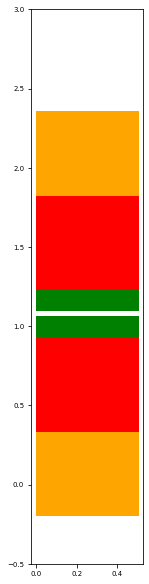

1.6576508993473795
pr_NEU_land 
 SNR: 0.56, forced response: 4.73, total uncertainty: 8.45 (storyline: 40%, uncaptured internal variability: 58%, model: 0%, scenario: 2%).
4.7265396844280865 4.7265396844280865
0.43077973820836934 9.022299630647804
-17.34478701539691 26.797866384253084
-38.86390292796361 48.31698229681978


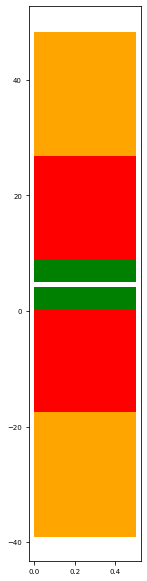

1.6576508993473795
prsn_NEU_land 
 SNR: 0.01, forced response: 0.08, total uncertainty: 8.68 (storyline: 39%, uncaptured internal variability: 60%, model: 0%, scenario: 1%).
0.0825249258810512 0.08252492588105137
-2.789412220408123 2.9544620721702253
-22.20147255119937 22.366522402961472
-46.096055985381405 46.2611058371435


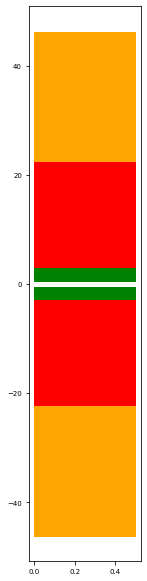

1.6576508993473795
snc_NEU_land 
 SNR: -0.79, forced response: -4.13, total uncertainty: 5.21 (storyline: 49%, uncaptured internal variability: 45%, model: 0%, scenario: 6%).
-4.128069072992852 -4.128069072992852
-6.609393793548136 -1.6467443524375667
-13.707935138181178 5.451796992195476
-20.519075442686475 12.262937296700773


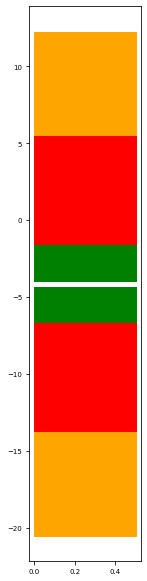

1.6576508993473795
sfcWind_NEU_land 
 SNR: 0.25, forced response: 1.35, total uncertainty: 5.34 (storyline: 51%, uncaptured internal variability: 48%, model: 0%, scenario: 1%).
1.3492607048960898 1.3492607048960898
0.28145024273996744 2.417071167052212
-8.161711427925356 10.860232837717536
-16.373162866145496 19.071684275937677


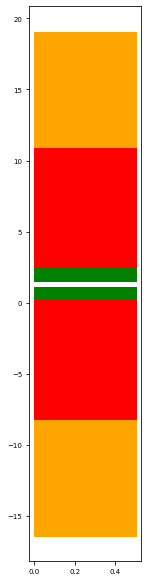

1.6576508993473795
rsds_NEU_land 
 SNR: -0.05, forced response: -0.11, total uncertainty: 2.40 (storyline: 28%, uncaptured internal variability: 70%, model: 0%, scenario: 3%).
-0.11073810341604892 -0.11073810341604881
-0.47756492188058763 0.25608871504848996
-1.6630691822363044 1.4415929754042067
-3.5429787431135997 3.3215025362815025


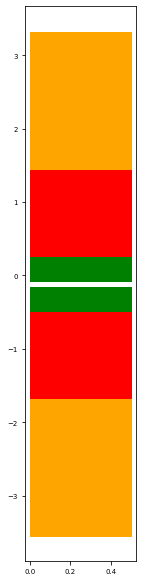

1.6576508993473795
prlq_NEU_land 
 SNR: 0.70, forced response: 12.09, total uncertainty: 17.36 (storyline: 47%, uncaptured internal variability: 47%, model: 0%, scenario: 6%).
12.087146582222742 12.087146582222742
-14.999576870630355 39.173870035075836
-92.56908741996743 116.74338058441292
-170.35603134692397 194.53032451136946


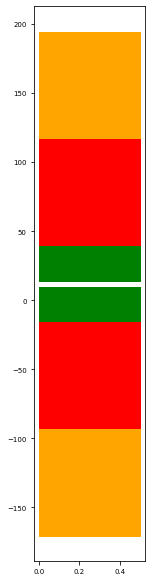

Runtime of the uncertainty source calculations is 5.2 s


In [69]:
ccmp = reload(ccmp)

begin = time.time()

width=.5

target_mu = dict(); target_std = dict()
target_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()
target_ssp = xr.Dataset(); target_beta = dict()
target_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()
target_iv = xr.Dataset(); target_nu =dict()

for _target in target_ano:
    _tmp = target_ano[_target]
    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))
    print(_conf_factor)

    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')
    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member')

    _avg = list()
    for _model in model:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _model in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model})
            - target_mu[_target])
    target_alpha[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _experiment in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment})
            - target_mu[_target])
    target_beta[_target] = xr.concat(_avg, dim='experiment_id')

    _avg = list()
    for _sto in story.stories:
        _da_target = _tmp.sel(member=[_member for _member in story.families[_sto]['label'] if _member in _tmp.member.values]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'storyline':_sto})
            - target_mu[_target])
    target_sigma[_target] = xr.concat(_avg, dim='storyline')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _experiment in experiments:
            if _experiment in members_dict[_model]:
                _members = [_member for _member in _tmp.member.values if _model+'_'+_experiment in _member]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _model_list.append(
                    _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment})
                    - target_alpha[_target].sel(source_id=_model)
                    - target_beta[_target].sel(experiment_id=_experiment)
                    + target_mu[_target])
            else:
                _model_list.append(xr.full_like(target_mu[_target], np.nan).assign_coords({'source_id':_model, 'experiment_id':_experiment}))
        _avg.append(xr.concat(_model_list, dim='experiment_id'))
    target_gamma[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _model in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _model_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'storyline':_sto})
                - target_alpha[_target].sel(source_id=_model)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_model_list, dim='storyline'))
    target_delta[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _expe_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _experiment in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _expe_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment, 'storyline':_sto})
                - target_beta[_target].sel(experiment_id=_experiment)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_expe_list, dim='storyline'))
    target_epsilon[_target] = xr.concat(_avg, dim='experiment_id')

    _tmp_member = list(main_target_ano[_target].member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _res = list(); _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _members = [_member for _member in story.families[_sto]['label'] if _model+'_'+_experiment in _member and _member in _tmp.member.values]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _res.append(_da_target - _da_target.weighted(_da_weight).mean(dim='member'))
                _inter_expe.append(_da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
                                   - target_alpha[_target].sel(source_id=_model)
                                   - target_beta[_target].sel(experiment_id=_experiment)
                                   - target_gamma[_target].sel(source_id=_model, experiment_id=_experiment)
                                   - target_delta[_target].sel(source_id=_model, storyline=_sto)
                                   - target_epsilon[_target].sel(experiment_id=_experiment, storyline=_sto)
                                   - target_sigma[_target].sel(storyline=_sto)
                                   - target_mu[_target])
                #_inter_expe[-1] = _inter_expe[-1].assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
            _inter_model.append(xr.concat(_inter_expe, dim='storyline'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_zeta[_target] = xr.concat(_inter, dim='source_id')
    target_nu[_target] = xr.concat(_res, dim='member').sortby('member')

    _da_weight = da_weight.sel(member=_tmp.member).sortby('member')

    _var_tot = (
        target_nu[_target].weighted(_da_weight).var(dim='member')
        + target_alpha[_target].var(dim='source_id')
        + target_beta[_target].var(dim='experiment_id')
        + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        + target_delta[_target].var(dim=('source_id', 'storyline'))
        + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        + target_sigma[_target].var(dim='storyline')
    )
    _total_uncertainty = _conf_factor*(_var_tot)**.5
    _total_uncertainty = _conf_factor*target_std[_target]
    _snr = target_mu[_target] / _total_uncertainty

    target_iv = target_iv.assign({_target: xr.DataArray((
            target_nu[_target].weighted(_da_weight).var(dim='member')
        ) / _var_tot)})
    target_model = target_model.assign({_target: xr.DataArray((
            target_alpha[_target].var(dim='source_id')
            + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
            #+ target_delta[_target].var(dim=('source_id', 'storyline'))
            #+ target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})
    target_ssp = target_ssp.assign({_target: xr.DataArray((
            target_beta[_target].var(dim='experiment_id')
            #+ target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        ) / _var_tot)})
    target_story = target_story.assign({_target: xr.DataArray((
            target_sigma[_target].var(dim='storyline')
            + target_delta[_target].var(dim=('source_id', 'storyline'))
            + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
            + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})

    print(
        _target,'\n',
        'SNR: {0:.2f},'.format(_snr.values),
        'forced response: {0:.2f},'.format(target_mu[_target].values),
        'total uncertainty: {0:.2f}'.format(_total_uncertainty.values),
        '(storyline: {0:.0f}%,'.format(100.*target_story[_target].values),
        'uncaptured internal variability: {0:.0f}%,'.format(100.*target_iv[_target].values),
        'model: {0:.0f}%,'.format(100.*target_model[_target].values),
        'scenario: {0:.0f}%).'.format(100.*target_ssp[_target].values),
    )
    import matplotlib.patches
    fig = plt.figure(figsize=(2,10))
    ax = plt.axes()
    ax.plot([0,width], [target_mu[_target], target_mu[_target]], c='w', lw=5, zorder=5)
    _boxlow = target_mu[_target].values; _boxhigh = target_mu[_target].values
    _F = (np.sqrt(target_model[_target])+np.sqrt(target_ssp[_target])+np.sqrt(target_story[_target])+np.sqrt(target_iv[_target]))/np.sqrt(_var_tot)
    _z=5
    for _src, _clr in [
        [target_model[_target], 'blue'],
        [target_ssp[_target], 'green'],
        [target_story[_target], 'red'],
        [target_iv[_target], 'orange']
    ]:
        _z = _z - 1
        _boxlow = _boxlow - _conf_factor*(_src.values*_var_tot.values)**.5/_F.values
        _boxhigh = _boxhigh + _conf_factor*(_src.values*_var_tot.values)**.5/_F.values
        print(_boxlow, _boxhigh)
        _patch = ax.add_patch(matplotlib.patches.Rectangle(
            (0, _boxlow), width, _boxhigh-_boxlow,
            color = _clr, zorder=_z))
    if 'tas' in _target:
        ax.set_ylim(-.5,3)
    plt.show()

end = time.time()
print('Runtime of the uncertainty source calculations is', '{0:.1f}'.format(end - begin), 's')


tas_NEU_land 
 SNR: 0.75, forced response: 1.08, total uncertainty: 1.45 (storyline: 54%, uncaptured internal variability: 43%, model: 0%, scenario: 3%).
pr_NEU_land 
 SNR: 0.56, forced response: 4.73, total uncertainty: 8.45 (storyline: 40%, uncaptured internal variability: 58%, model: 0%, scenario: 2%).
prsn_NEU_land 
 SNR: 0.01, forced response: 0.08, total uncertainty: 8.68 (storyline: 39%, uncaptured internal variability: 60%, model: 0%, scenario: 1%).
snc_NEU_land 
 SNR: -0.79, forced response: -4.13, total uncertainty: 5.21 (storyline: 49%, uncaptured internal variability: 45%, model: 0%, scenario: 6%).
sfcWind_NEU_land 
 SNR: 0.25, forced response: 1.35, total uncertainty: 5.34 (storyline: 51%, uncaptured internal variability: 48%, model: 0%, scenario: 1%).
rsds_NEU_land 
 SNR: -0.05, forced response: -0.11, total uncertainty: 2.40 (storyline: 28%, uncaptured internal variability: 70%, model: 0%, scenario: 3%).
prlq_NEU_land 
 SNR: 0.70, forced response: 12.09, total uncertaint

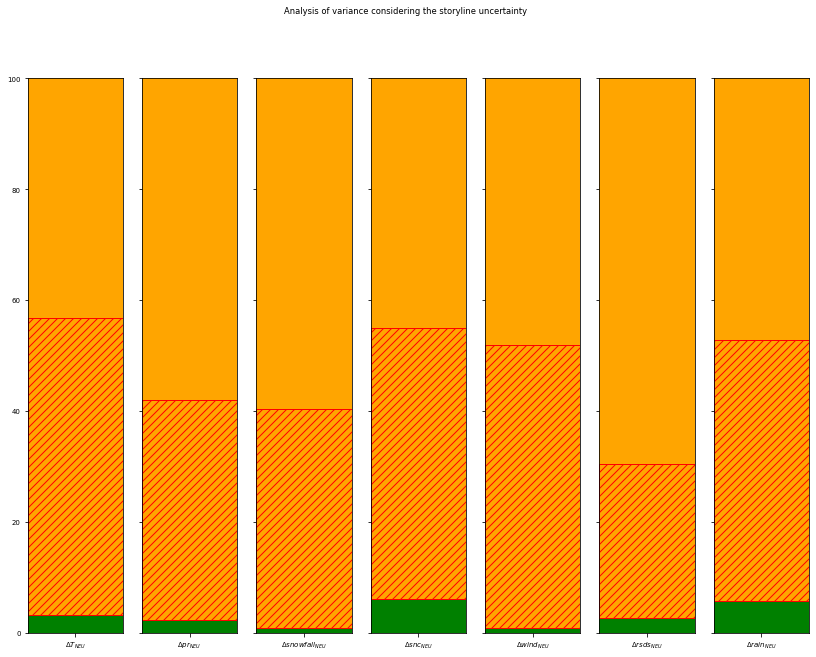

Runtime of the uncertainty source calculations is 5.1 s


In [70]:
ccmp = reload(ccmp)

begin = time.time()

width=.5

target_mu = dict(); target_std = dict()
target_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()
target_ssp = xr.Dataset(); target_beta = dict()
target_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()
target_iv = xr.Dataset(); target_nu =dict()

fig, ax = plt.subplots(1, len(target_ano), figsize=(2*len(target_ano),10), sharey = True)

for i, _target in enumerate(target_ano):
    _tmp = target_ano[_target]
    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))
    #print(_conf_factor)

    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')
    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member')

    _avg = list()
    for _model in model:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _model in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model})
            - target_mu[_target])
    target_alpha[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _experiment in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment})
            - target_mu[_target])
    target_beta[_target] = xr.concat(_avg, dim='experiment_id')

    _avg = list()
    for _sto in story.stories:
        _da_target = _tmp.sel(member=[_member for _member in story.families[_sto]['label'] if _member in _tmp.member.values]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'storyline':_sto})
            - target_mu[_target])
    target_sigma[_target] = xr.concat(_avg, dim='storyline')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _experiment in experiments:
            if _experiment in members_dict[_model]:
                _members = [_member for _member in _tmp.member.values if _model+'_'+_experiment in _member]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _model_list.append(
                    _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment})
                    - target_alpha[_target].sel(source_id=_model)
                    - target_beta[_target].sel(experiment_id=_experiment)
                    + target_mu[_target])
            else:
                _model_list.append(xr.full_like(target_mu[_target], np.nan).assign_coords({'source_id':_model, 'experiment_id':_experiment}))
        _avg.append(xr.concat(_model_list, dim='experiment_id'))
    target_gamma[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _model in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _model_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'storyline':_sto})
                - target_alpha[_target].sel(source_id=_model)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_model_list, dim='storyline'))
    target_delta[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _expe_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _experiment in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _expe_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment, 'storyline':_sto})
                - target_beta[_target].sel(experiment_id=_experiment)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_expe_list, dim='storyline'))
    target_epsilon[_target] = xr.concat(_avg, dim='experiment_id')

    _tmp_member = list(main_target_ano[_target].member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _res = list(); _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _members = [_member for _member in story.families[_sto]['label'] if _model+'_'+_experiment in _member and _member in _tmp.member.values]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _res.append(_da_target - _da_target.weighted(_da_weight).mean(dim='member'))
                _inter_expe.append(_da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
                                   - target_alpha[_target].sel(source_id=_model)
                                   - target_beta[_target].sel(experiment_id=_experiment)
                                   - target_gamma[_target].sel(source_id=_model, experiment_id=_experiment)
                                   - target_delta[_target].sel(source_id=_model, storyline=_sto)
                                   - target_epsilon[_target].sel(experiment_id=_experiment, storyline=_sto)
                                   - target_sigma[_target].sel(storyline=_sto)
                                   - target_mu[_target])
                #_inter_expe[-1] = _inter_expe[-1].assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
            _inter_model.append(xr.concat(_inter_expe, dim='storyline'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_zeta[_target] = xr.concat(_inter, dim='source_id')
    target_nu[_target] = xr.concat(_res, dim='member').sortby('member')

    _da_weight = da_weight.sel(member=_tmp.member).sortby('member')

    _var_tot = (
        target_nu[_target].weighted(_da_weight).var(dim='member')
        + target_alpha[_target].var(dim='source_id')
        + target_beta[_target].var(dim='experiment_id')
        + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        + target_delta[_target].var(dim=('source_id', 'storyline'))
        + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        + target_sigma[_target].var(dim='storyline')
    )
    _total_uncertainty = _conf_factor*(_var_tot)**.5
    _total_uncertainty = _conf_factor*target_std[_target]
    _snr = target_mu[_target] / _total_uncertainty

    target_iv = target_iv.assign({_target: xr.DataArray((
            target_nu[_target].weighted(_da_weight).var(dim='member')
        ) / _var_tot)})
    target_model = target_model.assign({_target: xr.DataArray((
            target_alpha[_target].var(dim='source_id')
            + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
            #+ target_delta[_target].var(dim=('source_id', 'storyline'))
            #+ target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})
    target_ssp = target_ssp.assign({_target: xr.DataArray((
            target_beta[_target].var(dim='experiment_id')
            #+ target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        ) / _var_tot)})
    target_story = target_story.assign({_target: xr.DataArray((
            target_sigma[_target].var(dim='storyline')
            + target_delta[_target].var(dim=('source_id', 'storyline'))
            + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
            + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})

    print(
        _target,'\n',
        'SNR: {0:.2f},'.format(_snr.values),
        'forced response: {0:.2f},'.format(target_mu[_target].values),
        'total uncertainty: {0:.2f}'.format(_total_uncertainty.values),
        '(storyline: {0:.0f}%,'.format(100.*target_story[_target].values),
        'uncaptured internal variability: {0:.0f}%,'.format(100.*target_iv[_target].values),
        'model: {0:.0f}%,'.format(100.*target_model[_target].values),
        'scenario: {0:.0f}%).'.format(100.*target_ssp[_target].values),
    )
    import matplotlib.patches
    _boxlow = 0.
    _ax = ax if len(main_target_ano) == 1 else ax[i]
    for _src, _clr, _htc, _edc in [
        [target_model[_target], 'blue', None, None],
        [target_ssp[_target], 'green', None, None],
        [target_story[_target], 'orange', '///', 'red'],
        [target_iv[_target], 'orange', None, None]
    ]:
        _boxhigh = _boxlow + 100.*_src.values
        _ax.add_patch(matplotlib.patches.Rectangle(
            (0, _boxlow), width, _boxhigh-_boxlow,
            facecolor = _clr, hatch = _htc, edgecolor = _edc))
        _boxlow = _boxhigh
    _ax.set_xlim(0., width)
    _ax.set_ylim(0., 100)
    _ax.set_xticks([width/2.])
    _ax.set_xticklabels([r'$\Delta$'+'$'+target_dict[_target]+'$'])
fig.suptitle('Analysis of variance considering the storyline uncertainty')
plt.show()

end = time.time()
print('Runtime of the uncertainty source calculations is', '{0:.1f}'.format(end - begin), 's')

In [71]:
35/(35+46), 27/(27+63), 30/(30+30), 27/(27+56)

(0.43209876543209874, 0.3, 0.5, 0.3253012048192771)

In [72]:
29/(29+43), 29/(29+52), 21/(21+45)

(0.4027777777777778, 0.35802469135802467, 0.3181818181818182)

In [73]:
disp_name = 'c'
snr_lim = 4./3.
iv_lim = 1./2. #2./3.

In [74]:
import himation.himation.chiton.stats as hstats
hstats = reload(hstats)

target_ano_sources = dict()

for _target in target_ano:
    _data = target_ano[_target]
    
    _tmp_member = list(_data.member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _sto_members = list()
                for _member in _tmp_member:
                    if _member in story.families[_sto]['label'] and _model+'_'+_experiment in _member:
                        _sto_members.append(1.)
                    else:
                        _sto_members.append(np.nan)
                _da = _sto_members*_data.assign_coords({
                    'source_id': _model,
                    'experiment_id': _experiment,
                    'story': _sto,
                }).expand_dims(['source_id', 'experiment_id', 'story'])
                _inter_expe.append(_da)
            _inter_model.append(xr.concat(_inter_expe, dim='story'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_ano_sources[_target] = xr.concat(_inter, dim='source_id').sortby('member')

    _signal, _noise, _var = hstats.anova(
        target_ano_sources[_target],
        weight=da_weight.sel(member=target_ano_sources[_target].member),
        dims=None, noise_dim='member',
        confidence=confidence_range
    )
    #print(_signal, _noise, _var)
target_ano_sources

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (source_id: 1, experiment_id: 4, story: 4,
                                   member: 120)>
 array([[[[1.42911049,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan, 0.65010168, ...,        nan,
                  nan,        nan],
          [       nan, 0.07746483,        nan, ...,        nan,
                  nan,        nan]],
 
         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],
 
         [[       nan,        nan,        nan, ..., 

In [75]:
import himation.himation.chiton.stats as hstats
hstats = reload(hstats)

def anova_to_latex(data, weight=None, dims=None, noise_dim=None, confidence=.9):
    import pandas

    _tmp = list()
    for _var_region in data:
        #print(data[_var_region])
        #_dict_signal, _dict_noise, _dict_var = anova(data[_var_region], weight=weight, dims=dims, noise_dim=noise_dim, confidence=confidence)
        _dict_signal, _dict_noise, _dict_var = hstats.anova(
            data[_var_region],
            weight=weight.sel(member=data[_var_region].member),
            dims=dims, noise_dim=noise_dim,
            confidence=confidence
        )
        #print(data[_var_region])
        #print(_dict_var)
        _tmp.append([
            _dict_signal['signal'].values,
            _dict_noise['noise'],
            _dict_signal['signal'].values / _dict_noise['noise'],
            (_dict_var['source_id'] + _dict_var['source_id-experiment_id']) / _dict_var['total'],
            _dict_var['experiment_id'] / _dict_var['total'],
            _dict_var['member'] / _dict_var['total'],
            _dict_signal['signal'].values / _dict_noise['member'],
        ])
    _df = pandas.DataFrame(
        _tmp,
        columns=['signal', 'noise', 'SNR', 'source_id', 'experiment_id', 'member', 'frvi'],
        index=data.keys()
    ).sort_values(
        by=['SNR'], ascending=True,
        #by=['member'], ascending=False,
    )
    print(r'\begin{table}[h!]')
    print(r'\centering')
    print(r'\small')
    print(r'\begin{tabular}{r||r|r|r||r|r|r}')
    print(r'& Réponse & Incertitude & SNR & Modèle & Scénario & Variabilité \\')
    print(r'Région & forcée & totale (90\%) & (90\%) & & & interne \\')
    print(r'\hline')
    for _var_region in _df.index:
        _variable, _region, _ = _var_region.split('_')
        print(
            #_region+r' & '+
            _var_region+r' & '+
            '${0:.1f}$'.format(_df.loc[_var_region].signal)
            +r' & '+
            '${0:.1f}$'.format(_df.loc[_var_region].noise)
            +r' & '+
            '${0:.1f}$'.format(_df.loc[_var_region].SNR)
            +r' & '+
            '${0:.0f}\%$'.format(_df.loc[_var_region].source_id * 100.)
            +r' & '+
            '${0:.0f}\%$'.format(_df.loc[_var_region].experiment_id * 100.)
            +r' & '+
            '${0:.0f}\%$'.format(_df.loc[_var_region].member * 100.)
            +r' \\'
        )
    print(r'\end{tabular}')
    print(r'\caption{}')
    print(r'\label{tab:}')
    print(r'\end{table}')
    print()
    '''
    print(r'\begin{table}[h!]')
    print(r'\centering')
    print(r'\small')
    print(r'\begin{tabular}{r||r|r|r||r|r|r||r}')
    print(r'& Réponse & Incertitude & SNR & Modèle & Scénario & Variabilité & RF/VI\\')
    print(r'Région & forcée & totale (90\%) & (90\%) & & & interne & \\')
    print(r'\hline')
    _df = _df.sort_values(by=['member'], ascending=False)
    for _var_region in _df.index:
        _variable, _region, _ = _var_region.split('_')
        if _df.loc[_var_region].SNR < snr_lim:
            print(
                #_region+r' & '+
                _var_region+r' & '+
                '${0:.1f}$'.format(_df.loc[_var_region].signal)
                +r' & '+
                '${0:.1f}$'.format(_df.loc[_var_region].noise)
                +r' & '+
                '${0:.1f}$'.format(_df.loc[_var_region].SNR)
                +r' & '+
                '${0:.0f}\%$'.format(_df.loc[_var_region].source_id * 100.)
                +r' & '+
                '${0:.0f}\%$'.format(_df.loc[_var_region].experiment_id * 100.)
                +r' & '+
                '${0:.0f}\%$'.format(_df.loc[_var_region].member * 100.)
                +r' & '+
                '${0:.1f}$'.format(_df.loc[_var_region].frvi)
                +r' \\'
            )
    print(r'\end{tabular}')
    print(r'\caption{}')
    print(r'\label{tab:}')
    print(r'\end{table}')
    '''

anova_to_latex(
    {_target: target_ano_sources[_target].mean(dim='story', skipna=True, keep_attrs=True) for _target in target_ano_sources},
    weight=da_weight, dims=['source_id', 'experiment_id', 'member'], noise_dim='member')
print()
anova_to_latex(target_ano_sources, weight=da_weight, noise_dim='member')

\begin{table}[h!]
\centering
\small
\begin{tabular}{r||r|r|r||r|r|r}
& Réponse & Incertitude & SNR & Modèle & Scénario & Variabilité \\
Région & forcée & totale (90\%) & (90\%) & & & interne \\
\hline
snc_NEU_land & $-4.1$ & $5.2$ & $-0.8$ & $0\%$ & $6\%$ & $94\%$ \\
rsds_NEU_land & $-0.1$ & $2.4$ & $-0.0$ & $0\%$ & $3\%$ & $97\%$ \\
prsn_NEU_land & $0.1$ & $8.7$ & $0.0$ & $0\%$ & $1\%$ & $99\%$ \\
sfcWind_NEU_land & $1.3$ & $5.3$ & $0.3$ & $0\%$ & $1\%$ & $99\%$ \\
pr_NEU_land & $4.7$ & $8.4$ & $0.6$ & $0\%$ & $2\%$ & $98\%$ \\
prlq_NEU_land & $12.1$ & $17.4$ & $0.7$ & $0\%$ & $6\%$ & $94\%$ \\
tas_NEU_land & $1.1$ & $1.4$ & $0.7$ & $0\%$ & $3\%$ & $97\%$ \\
\end{tabular}
\caption{}
\label{tab:}
\end{table}


\begin{table}[h!]
\centering
\small
\begin{tabular}{r||r|r|r||r|r|r}
& Réponse & Incertitude & SNR & Modèle & Scénario & Variabilité \\
Région & forcée & totale (90\%) & (90\%) & & & interne \\
\hline
snc_NEU_land & $-4.1$ & $5.2$ & $-0.8$ & $0\%$ & $6\%$ & $45\%$ \\
rsds_NEU_lan

## Field ANOVA

## Régression par les drivers

### Comparaisons entre modèles
Réponse forcée et variance : boxplots et tests de significativité croisés

In [76]:
if len(model) != 1:
    _show_mega_ensemble = False
    width = .5

    if len(model) == 1:
        _show_mega_ensemble = False

    ds_signi = xr.Dataset()
    for _target in target_ano:
        print(_target)

        _data = target_ano[_target]

        _tmp = list(_data.member.values); _tmp.sort()
        _dict = cc.cmip6.get_members_dict(_tmp)

        figsize = (10, 10)
        fig1, ax1 = plt.subplots(figsize = figsize)
        fig2, ax2 = plt.subplots(figsize = figsize)

        box_data = list()
        wei_data = list()
        avg_data = list()
        for iM, _model in enumerate(_dict.keys()):
            loc_data = list(); loc_wei = list()
            for _experiment in _dict[_model].keys():
                if _experiment in experiments:
                    for _member in _dict[_model][_experiment]:
                        loc_data.append(_data.sel(member=_member).values)
                        loc_wei.append(da_weight.sel(member=_member).values)
            box_data.append(loc_data); wei_data.append(loc_wei)
            ccplt.boxplot([loc_data], weights = [loc_wei],
                         ax = ax1, hatch = model_hatches[_model], bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=iM, width = width)
            avg_data.append(ccnp.mean(loc_data, weights=loc_wei))
            #ax1.plot(iM, avg_data[iM], '*k', ms = 31)
            ax2.plot(iM, avg_data[iM], '*k', ms = 31)

        if _show_mega_ensemble:
            ccplt.boxplot(_data.values, ax = ax1, color = 'k', label = None, hatch = None, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                         dx=len(model), width = width)
            ax1.axvline(x=len(model)-width,color='k',lw=.5)
            ax2.axvline(x=len(model)-width,color='k',lw=.5)
            #ax1.plot(len(model), np.mean(avg_data), '*k', ms = 31)
            ax2.plot(len(model), np.mean(avg_data), '*k', ms = 31)

        ax1.yaxis.set_ticks_position('both'); ax2.yaxis.set_ticks_position('both')
        ax1.axhline(y=0,color='k',lw=.5); ax2.axhline(y=0,color='k',lw=.5)
        ax1.axhline(y=np.mean(avg_data),color='k'); ax2.axhline(y=np.mean(avg_data),color='k')
        print('Mega-ensemble average: {:.2f}'.format(np.mean(avg_data)))
        print(avg_data)
        print()
        #ax1.set_xticks(np.arange(len(model))); ax1.set_xticklabels(model, rotation=90)
        ax1.legend(handles = model_legend_box, fontsize=12)
        fig1.savefig(figDir+saveName+'-'+_target+'_distributions.pdf', transparent=True)
        ax2.set_xticks(np.arange(len(model)+1)); ax2.set_xticklabels(model+['Multi-model'], rotation=90)
        xMin, xMax = ax1.get_xlim(); yMin, yMax = ax1.get_ylim()
        ax2.set_xlim(xMin, xMax); ax2.set_ylim(yMin, yMax)
        fig2.savefig(figDir+saveName+'-'+_target+'_forced_responses.pdf', transparent=True)

        if len(model) > 1:

            #_signi_store1 = list()
            #for iR, _sub_ref in enumerate(box_data):
            #    _signi_store2 = list()
            #    for iT, _sub_test in enumerate(box_data):
                    #if iR < iT:
                    #    _model1 = list(_dict.keys())[iR]
                    #    _model2 = list(_dict.keys())[iT]
                    #    _pvalue = ccscp.ftest_ind(_sub_ref, _sub_test).pvalue
                    #    _yes_or_no = [' ', '<'] if _pvalue < significance_limit else [' NOT ', '>']
                    #    print('The '+_model1+' distribution sample variance of "'+_target+'" is'+_yes_or_no[0]+'significantly different from '+_model2+' (F-test, pvalue = {0:1.3f}'.format(_pvalue)+' '+_yes_or_no[1]+' {0:1.3f}'.format(significance_limit)+').')
                    ##_signi_store2.append([scipy.stats.ttest_ind(_sub_ref, _sub_test, permutations = permutations).pvalue,
                    ##                      ccscp.ftest_ind(_sub_ref, _sub_test).pvalue])
            ccscp = reload(ccscp)
            box_data.append(_data.values); wei_data.append(da_weight.sel(member=_data.member))
            _signi_store1 = list()
            for iR in range(len(box_data)):
                _signi_store2 = list()
                _sub_ref = box_data[iR]; _wei_ref = wei_data[iR]
                for iT in range(len(box_data)):
                    _sub_test = box_data[iT]; _wei_test = wei_data[iT]
                    _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                          ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
                _signi_store1.append(_signi_store2)
            ds_signi = ds_signi.assign(
                {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                                        dims=['test', 'r', 'c'],
                                        coords={'test': ['T-test', 'F-test'], 'r':list(_dict.keys())+ensemble_name, 'c':list(_dict.keys())+ensemble_name})})

            for _target in ds_signi:
                for _test in ds_signi.test:
                    print('Null hypothesis: '+h0[str(_test.values)])
                    display(ds_signi.get(_target).sel(test=_test).to_pandas().style.format("{:.1%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

### Liens entre les drivers et targets dans les modèles
Tests de corrélation et de la significativité de la régression

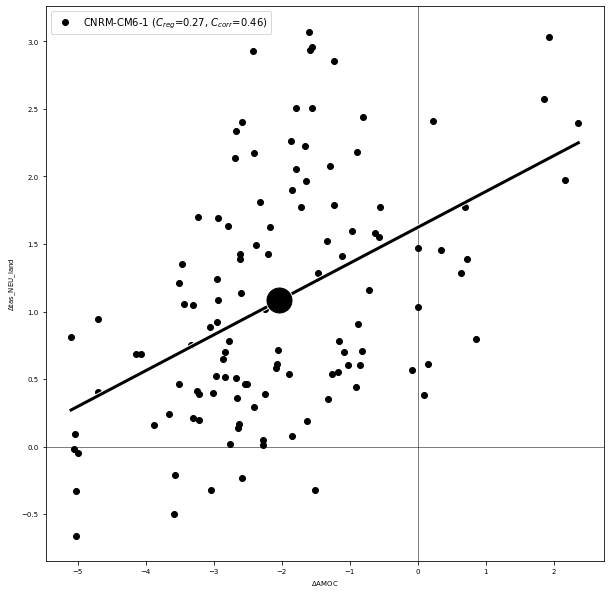

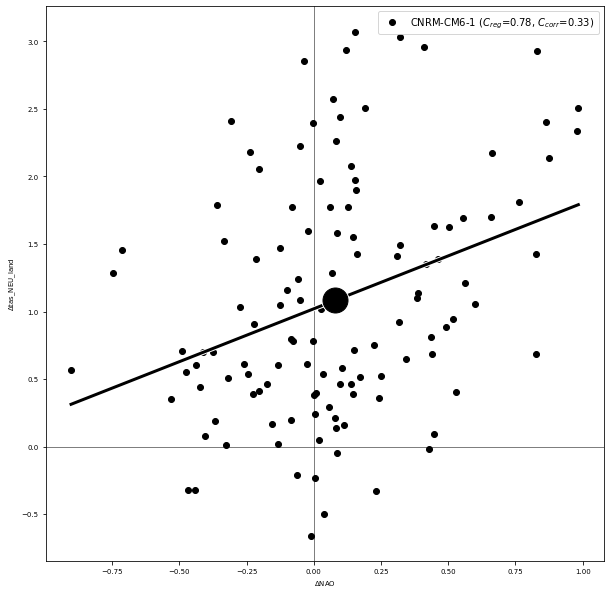

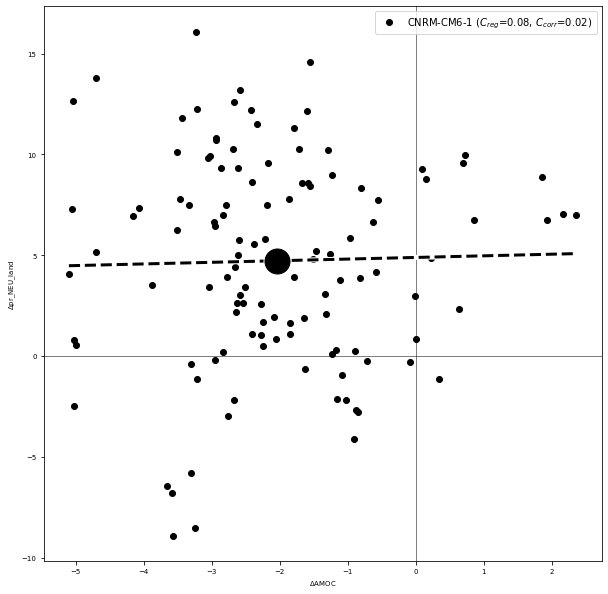

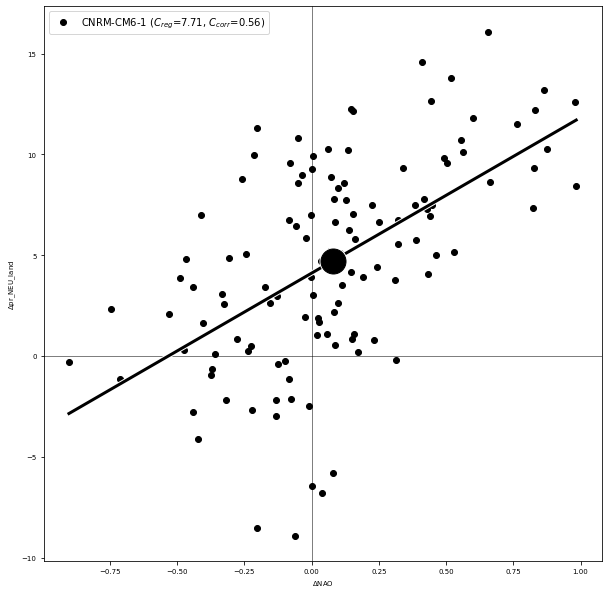

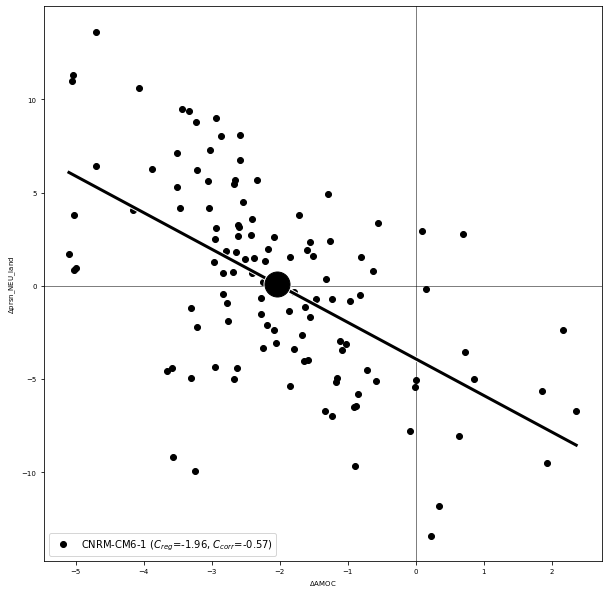

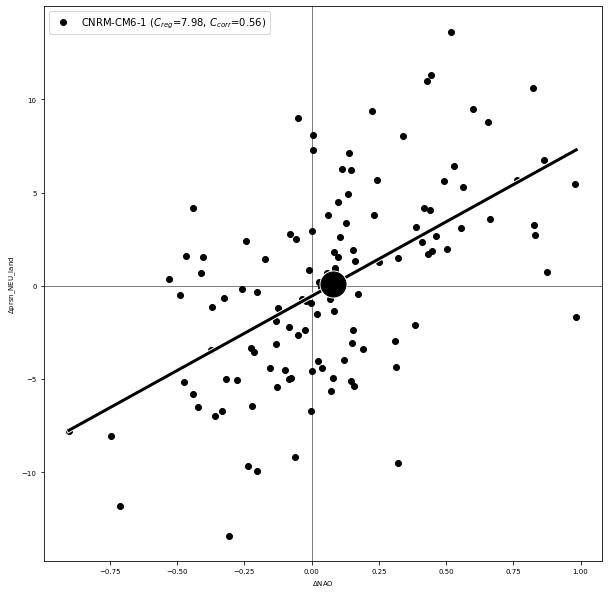

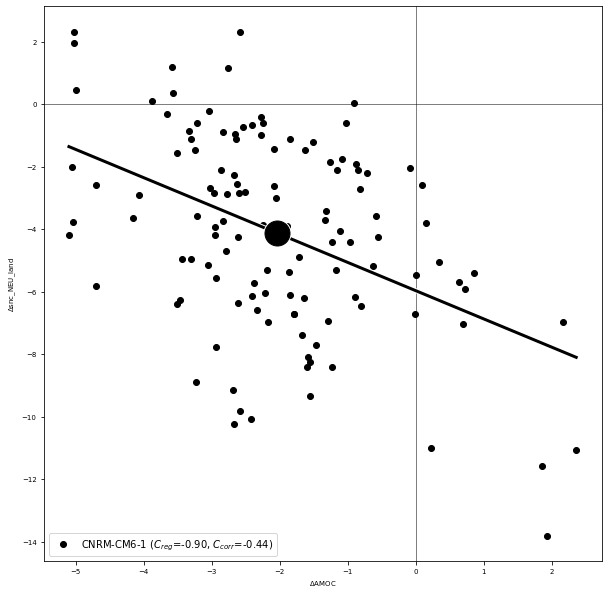

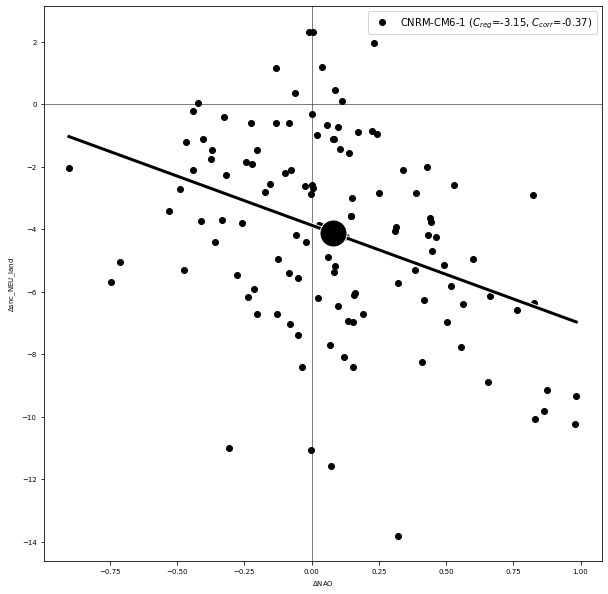

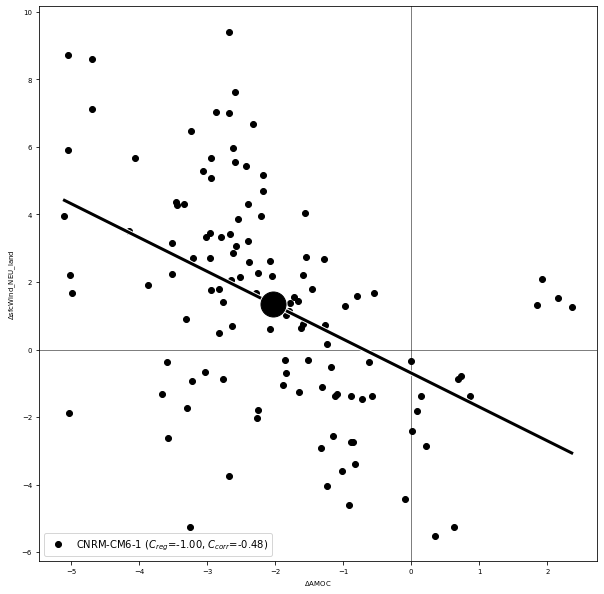

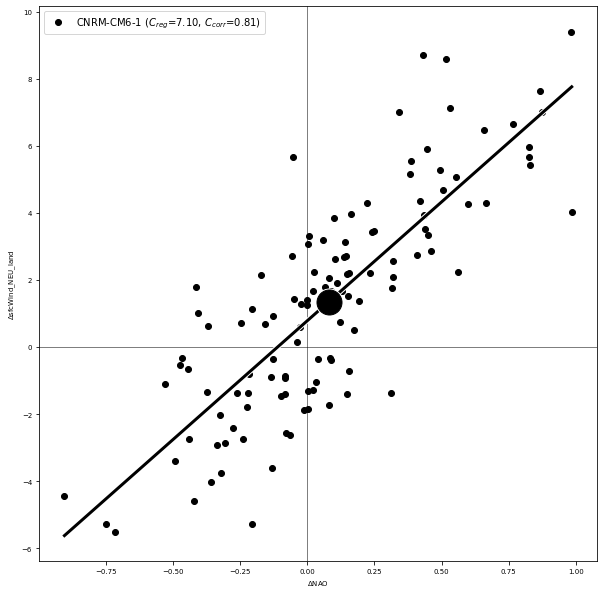

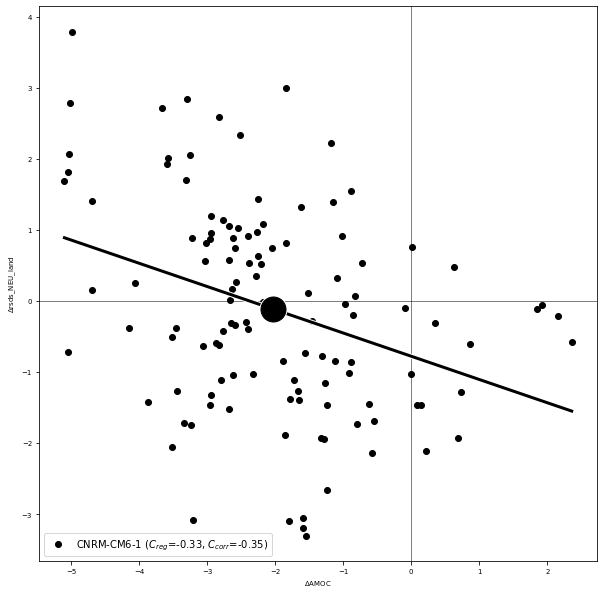

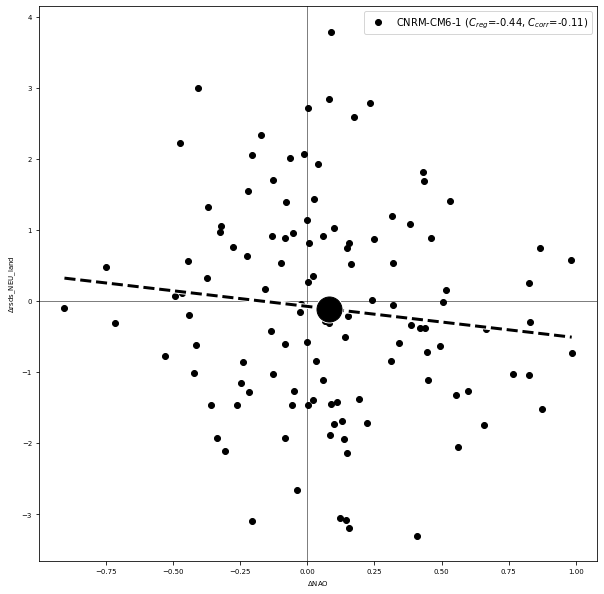

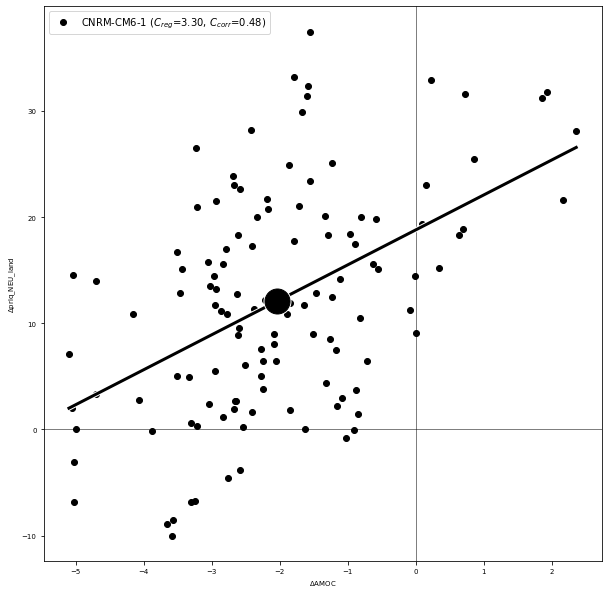

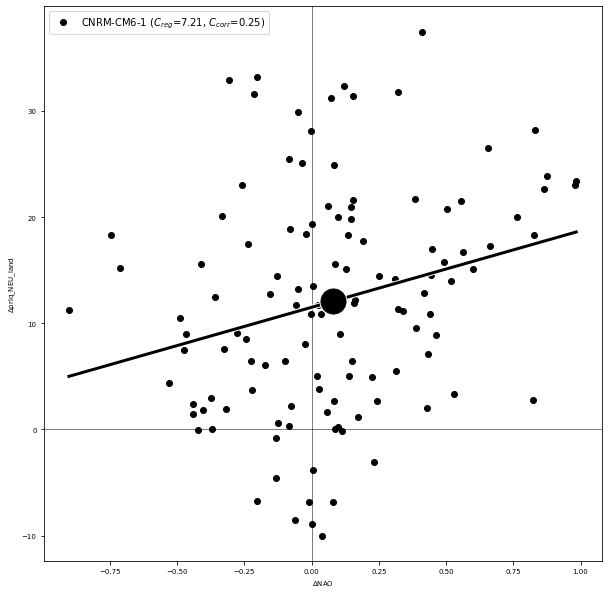

In [77]:
import numpy
import scipy.stats
import sklearn.linear_model
import sklearn.feature_selection

for _prefix, _save in [['$\Delta$', 'raw']]: #, ["$\Delta$'", 'relative']]:
    for _target in target_ano:
        for iD, _driver in enumerate(driver_ano):
            _members = list(target_ano[_target].member.values)
            _members.sort()
            _members_dict = cc.cmip6.get_members_dict(_members)
            fig, ax = plt.subplots(figsize = (10, 10))
            #ax.set_title('Relationship between '+_prefix+_target+' and '+_prefix+_driver)
            ax.set_xlabel(_prefix+_driver); ax.set_ylabel(_prefix+_target)
            ax.axvline(x=0, c='k', lw=.5); ax.axhline(y=0, c='k', lw=.5)
            for _model in list(_members_dict.keys()):
                X = Y = W = list()
                for _experiment in _members_dict[_model]:
                    y = list(target_ano[_target].sel(member=_members_dict[_model][_experiment]).values)
                    x = list(driver_ano.get(_driver).sel(member=_members_dict[_model][_experiment]).values)
                    W = W + list(da_weight.sel(member=_members_dict[_model][_experiment]).values)
                    if _prefix == "$\Delta$'":
                        x = list(np.array(x) - np.mean(x)); y = list(np.array(y) - np.mean(y))
                    Y = Y + y; X = X + x
                _correlation, _pvalue = ccscp.pearson(X, Y, weights = W)
                #_pvalue = sklearn.feature_selection.f_regression(numpy.array(X)[:, numpy.newaxis], np.array(Y))[1]#.p_values
                sklinreg = sklearn.linear_model.LinearRegression()
                sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
                ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
                           label=source_dict[_model]+' ($C_{reg}$='+'{0:.2f}'.format(sklinreg.coef_[0])+', $C_{corr}$='+'{0:.2f})'.format(_correlation))
                if _save == 'raw':
                    ax.plot(np.mean(X), np.mean(Y), model_markers[_model], color='w', ms=27, zorder=9)
                    ax.plot(np.mean(X), np.mean(Y), model_markers[_model], color=model_colors[_model], ms=25, zorder=10)
                X = [min(X), max(X)]
                Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
                ax.plot(X, Y, color='w', lw=5)
                _ls = '-' if _pvalue < significance_limit else '--'
                ax.plot(X, Y, lw=3, ls=_ls, color=model_colors[_model])
            ax.legend(fontsize=10)
            plt.savefig(figDir+saveName+'-'+_target+'_'+drivers[iD]+'_reg_'+_save+'_anomaly.pdf', transparent=True)

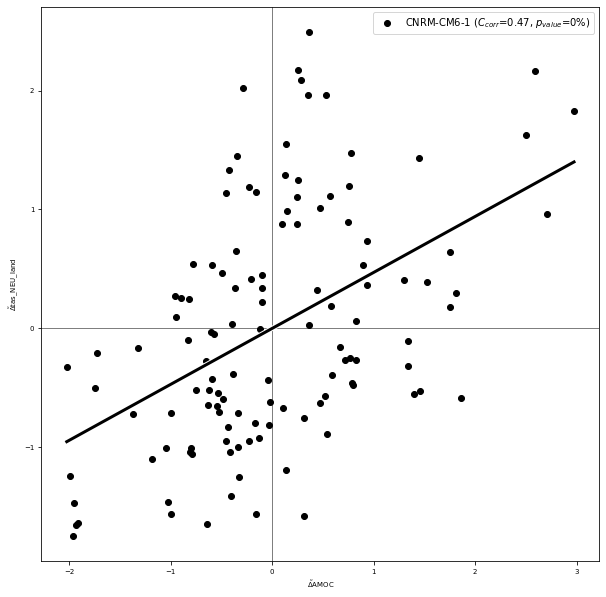

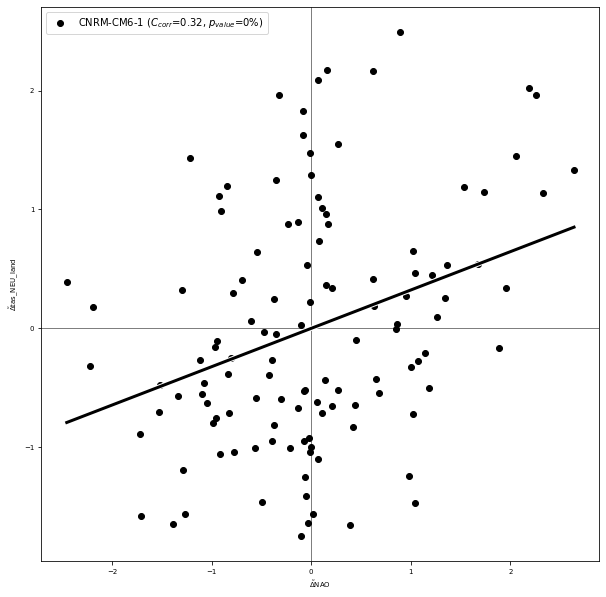

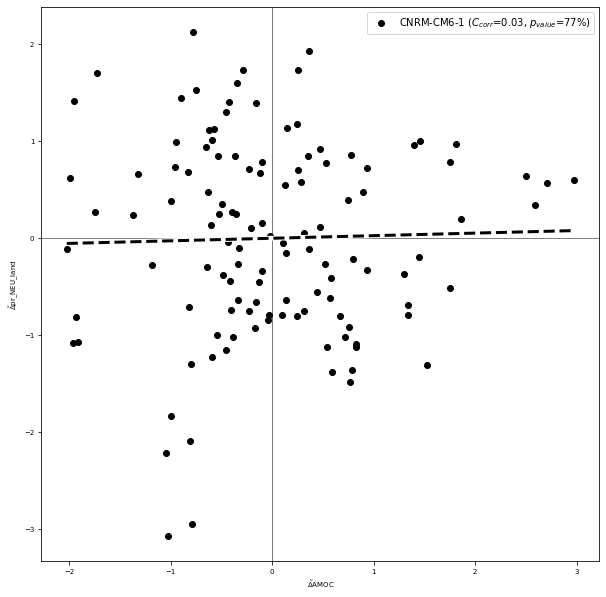

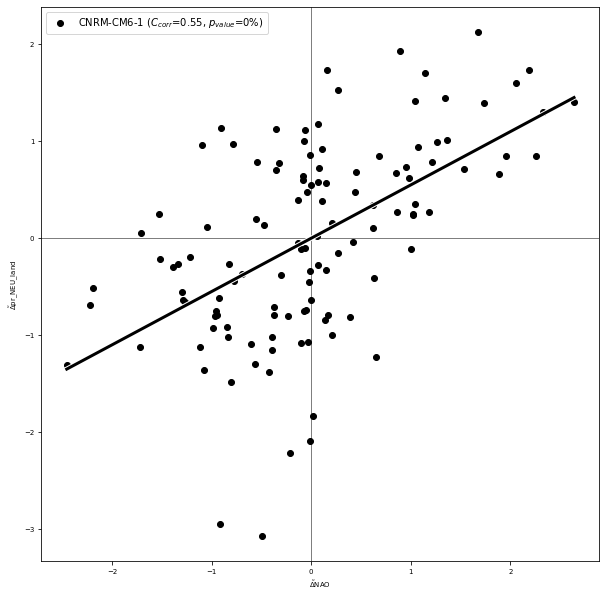

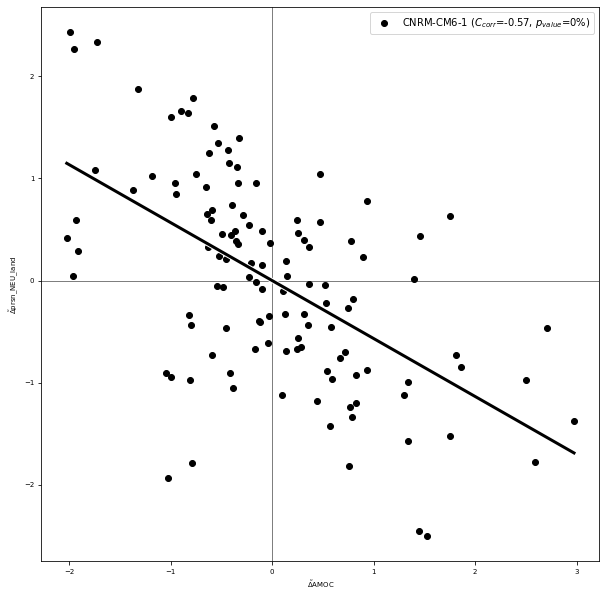

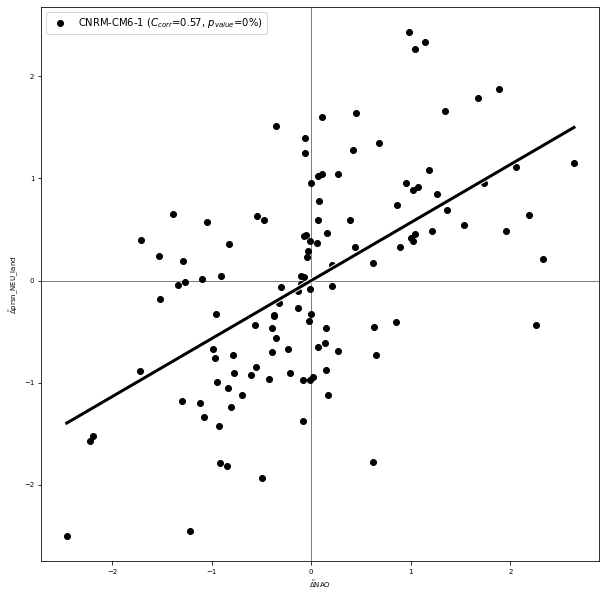

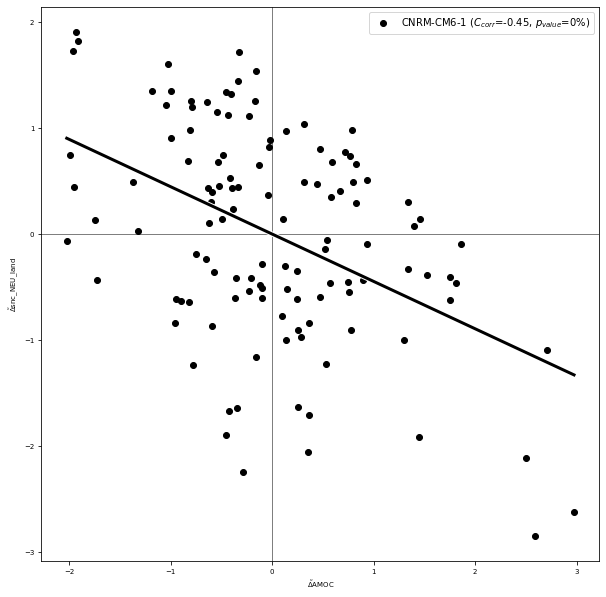

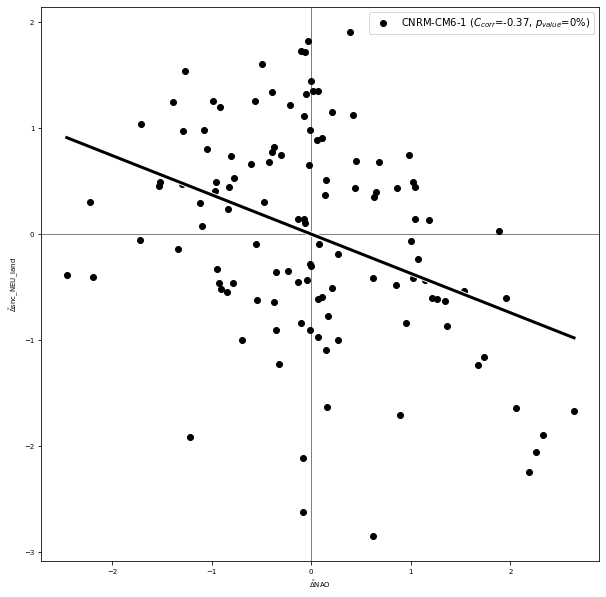

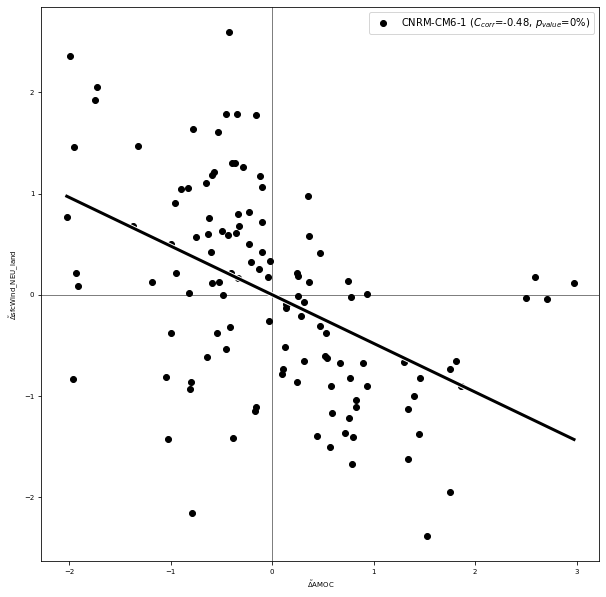

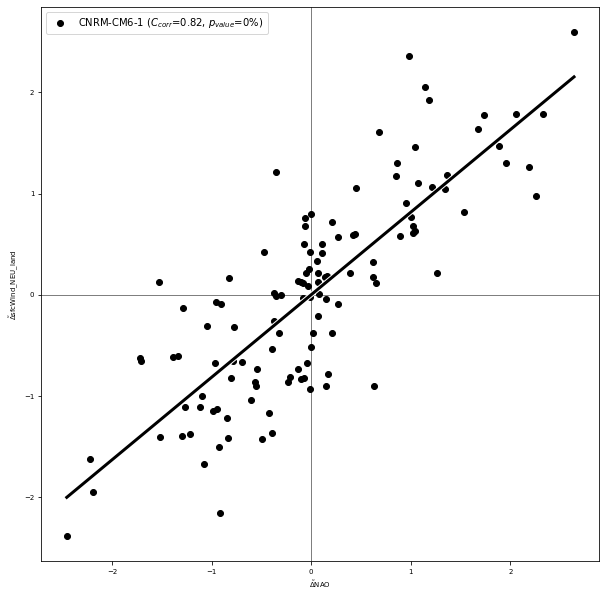

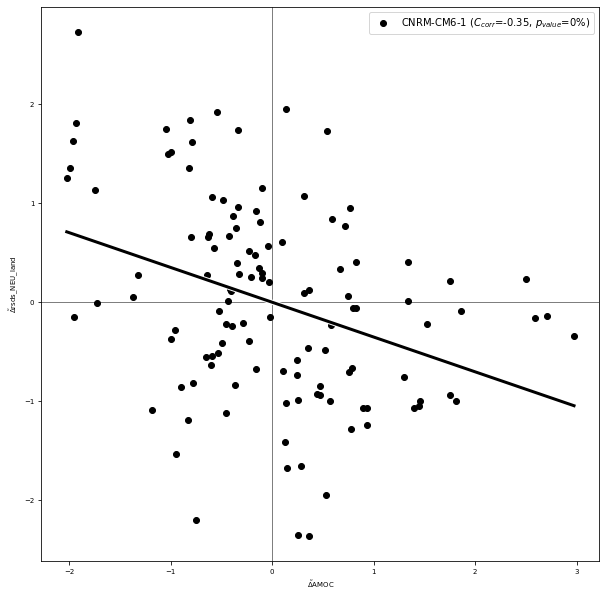

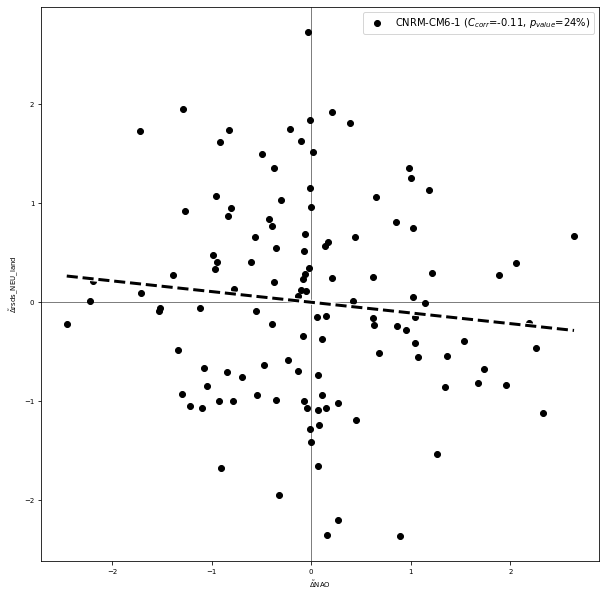

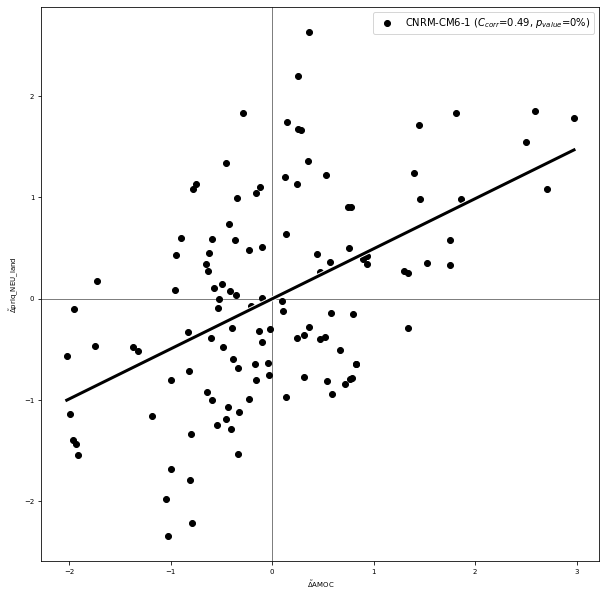

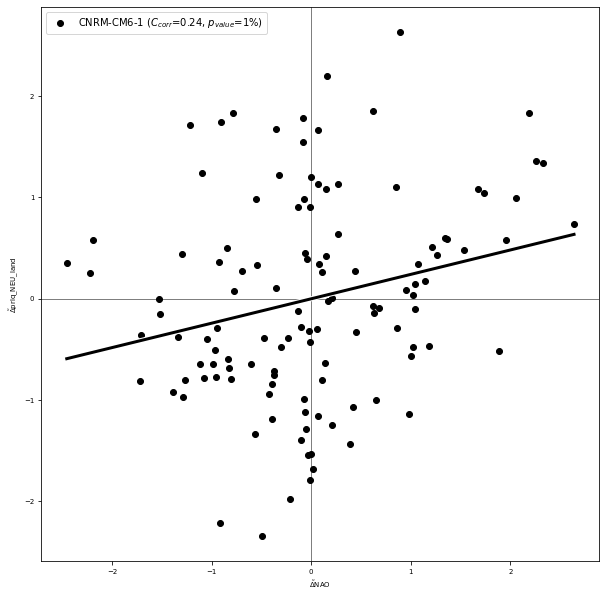

In [78]:
import numpy
import scipy.stats
import sklearn.linear_model
import sklearn.feature_selection

for _target in target_ano_std:
    for iD, _driver in enumerate(driver_ano_std):
        _members = list(main_target_ano[_target].member.values)
        _members.sort()
        _members_dict = cc.cmip6.get_members_dict(_members)
        fig, ax = plt.subplots(figsize = (10, 10))
        #ax.set_title(r'Relationship between $\tilde{\Delta}$'+_target+r' and $\tilde{\Delta}$'+_driver)
        ax.set_xlabel(r'$\tilde{\Delta}$'+_driver); ax.set_ylabel(r'$\tilde{\Delta}$'+_target)
        ax.axvline(x=0, c='k', lw=.5); ax.axhline(y=0, c='k', lw=.5)
        if len(model) != 1:
            X = driver_ano_std.get(_driver).sel(member=_members).values; Y = target_ano_std[_target].values
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = da_weight.sel(member=_members))
            print(_correlation)
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=7, zorder=100)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=5, ls=_ls, color='k', zorder=101, label = 'Mega-ensemble ($C_{corr}$='+'{0:.2f}'.format(_correlation)+', $p_{value}$='+'{0:.0%})'.format(_pvalue))
        for _model in list(_members_dict.keys()):
            X = Y = W = list()
            for _experiment in _members_dict[_model]:
                Y = Y + list(target_ano_std[_target].sel(member=_members_dict[_model][_experiment]).values)
                X = X + list(driver_ano_std.get(_driver).sel(member=_members_dict[_model][_experiment]).values)
                W = W + list(da_weight.sel(member=_members_dict[_model][_experiment]).values)
            _correlation, _pvalue = ccscp.pearson(X, Y, weights = W)
            #_pvalue = sklearn.feature_selection.f_regression(numpy.array(X)[:, numpy.newaxis], np.array(Y))[1]#.p_values
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y)
            #ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
            #           label=source_dict[_model]+' ($C_{reg}$='+'{0:.2f}'.format(sklinreg.coef_[0])+', $C_{corr}$='+'{0:.2f})'.format(_correlation))
            ax.scatter(X, Y, marker=model_markers[_model], color=model_colors[_model],
                       label=source_dict[_model]+' ($C_{corr}$='+'{0:.2f}'.format(_correlation)+', $p_{value}$='+'{0:.0%})'.format(_pvalue))
            X = [min(X), max(X)]
            Y = [sklinreg.intercept_+sklinreg.coef_*X[0], sklinreg.intercept_+sklinreg.coef_*X[1]]
            ax.plot(X, Y, color='w', lw=5)
            _ls = '-' if _pvalue < significance_limit else '--'
            ax.plot(X, Y, lw=3, ls=_ls, color=model_colors[_model])
        ax.legend(fontsize=10)
        plt.savefig(figDir+saveName+'-'+_target+'_'+drivers[iD]+'_reg_anomaly.pdf', transparent=True)

# Variance expliquée

In [79]:
def explained_variance(x, y, weights=None):
    _reg = sklearn.linear_model.LinearRegression()

    out = list()

    _Y = y
    for _x in x:
        _X = np.array([_x]).T
        _reg.fit(_X, _Y, weights)
        #out.append('{0:.0f}'.format(_reg.score(_X, _Y)*100)+'%')
        out.append(_reg.score(_X, _Y, weights))

    _X = np.array(x).T

    _reg.fit(_X, _Y, weights)
    #out.append('{0:.0f}'.format(_reg.score(_X, _Y)*100)+'%')
    out.append(_reg.score(_X, _Y, weights))

    return out

In [81]:
for _target in main_target_ano:
    print(_target)
    story.explained_variance(target=main_target_ano[_target])
    print()

tas_NEU_land
$\Delta$tas_NEU_land = 1.1 + 0.6 * $\tilde{\Delta}$AMOC + 0.5 * $\tilde{\Delta}$NAO (54% of variance explained)

pr_NEU_land
$\Delta$pr_NEU_land = 4.7 + 1.6 * $\tilde{\Delta}$AMOC + 3.5 * $\tilde{\Delta}$NAO (39% of variance explained)

prsn_NEU_land
$\Delta$prsn_NEU_land = 0.1 + -2.2 * $\tilde{\Delta}$AMOC + 2.1 * $\tilde{\Delta}$NAO (46% of variance explained)

snc_NEU_land
$\Delta$snc_NEU_land = -4.1 + -2.2 * $\tilde{\Delta}$AMOC + -2.1 * $\tilde{\Delta}$NAO (56% of variance explained)

sfcWind_NEU_land
$\Delta$sfcWind_NEU_land = 1.3 + -0.5 * $\tilde{\Delta}$AMOC + 2.4 * $\tilde{\Delta}$NAO (69% of variance explained)

rsds_NEU_land
$\Delta$rsds_NEU_land = -0.1 + -0.7 * $\tilde{\Delta}$AMOC + -0.4 * $\tilde{\Delta}$NAO (20% of variance explained)

prlq_NEU_land
$\Delta$prlq_NEU_land = 12.1 + 7.4 * $\tilde{\Delta}$AMOC + 5.7 * $\tilde{\Delta}$NAO (48% of variance explained)



In [82]:
story.score

<xarray.Dataset>
Dimensions:           ()
Data variables:
    tas_NEU_land      float64 0.5425
    pr_NEU_land       float64 0.3908
    prsn_NEU_land     float64 0.4571
    snc_NEU_land      float64 0.5578
    sfcWind_NEU_land  float64 0.6878
    rsds_NEU_land     float64 0.1966
    prlq_NEU_land     float64 0.4775

# Partitionnement des projections dans les storylines

In [83]:
for _target in main_target_ano:
    print(_target)

    _data = target_ano[_target]
    _members = list(_data.member.values); _members.sort(); _data.sortby('member')
    _me_avg = ccnp.mean(_data, weights = da_weight.sel(member=_members))
    _me_conf_inf = ccnp.quantile(_data, (1.-confidence_range)/2., weights = da_weight.sel(member=_members))[0]
    _me_conf_sup = ccnp.quantile(_data, 1.-(1.-confidence_range)/2., weights = da_weight.sel(member=_members))[0]
    print('ME {0:.1f}'.format(_me_avg), '[{0:.1f};'.format(_me_conf_inf), '{0:.1f}]'.format(_me_conf_sup))
    print('---')
    for _sto in story.stories:
        _interception = list(set(_members).intersection(set(story.families[_sto]['label'])))
        _sto_avg = ccnp.mean(_data.sel(member=_interception), weights = da_weight.sel(member=_interception))
        _sto_conf_inf = ccnp.quantile(_data.sel(member=_interception), .05, weights = da_weight.sel(member=_interception))[0]
        _sto_conf_sup = ccnp.quantile(_data.sel(member=_interception), .95, weights = da_weight.sel(member=_interception))[0]
        _pvalue = ccscp.ttest_ind(_data, _data.sel(member=_interception), weights = [da_weight.sel(member=_members), da_weight.sel(member=_interception)]).pvalue
        if _pvalue < significance_limit:
            print('   ', _sto, '{0:.1f}'.format(_sto_avg), '[{0:.1f};'.format(_sto_conf_inf), '{0:.1f}]'.format(_sto_conf_sup), '({0:.2f})'.format(_pvalue))
        else:
            print('---', _sto, '{0:.1f}'.format(_sto_avg), '[{0:.1f};'.format(_sto_conf_inf), '{0:.1f}]'.format(_sto_conf_sup), '({0:.2f})'.format(_pvalue))
        print()
    print()

tas_NEU_land
ME 1.1 [-0.2; 2.7]
---
    AN 2.0 [0.7; 3.0] (0.00)

--- An 1.1 [0.2; 2.4] (0.74)

--- aN 0.9 [0.1; 1.7] (0.13)

    an 0.3 [-0.5; 1.2] (0.00)


pr_NEU_land
ME 4.7 [-3.5; 12.4]
---
    AN 8.2 [1.1; 13.2] (0.00)

    An 2.8 [-2.7; 10.0] (0.05)

    aN 7.6 [0.2; 13.8] (0.01)

    an 1.3 [-8.5; 10.8] (0.00)


prsn_NEU_land
ME 0.1 [-8.6; 9.2]
---
--- AN -0.2 [-6.7; 5.7] (0.78)

    An -3.8 [-11.8; 2.8] (0.00)

    aN 5.2 [-0.5; 11.3] (0.00)

--- an 0.1 [-9.2; 8.1] (0.96)


snc_NEU_land
ME -4.1 [-9.9; 0.4]
---
    AN -7.2 [-11.6; -3.0] (0.00)

--- An -4.2 [-8.4; -0.6] (0.91)

--- aN -4.0 [-7.8; -0.9] (0.83)

    an -1.4 [-5.6; 2.3] (0.00)


sfcWind_NEU_land
ME 1.3 [-3.9; 7.0]
---
    AN 2.7 [-1.4; 7.6] (0.04)

    An -1.7 [-5.3; 1.4] (0.00)

    aN 4.4 [1.8; 8.6] (0.00)

--- an 0.7 [-3.8; 3.9] (0.29)


rsds_NEU_land
ME -0.1 [-2.4; 2.5]
---
    AN -0.9 [-3.2; 0.8] (0.01)

--- An -0.4 [-2.1; 1.5] (0.25)

--- aN -0.1 [-2.1; 1.8] (0.94)

    an 0.9 [-1.5; 3.0] (0.00)


prlq_NEU_lan

In [84]:
_letters = ''.join([story.stories[0], story.stories[0]])
list_of_stories = [[] for _ in range(story.ndrivers)]
for i in range(story.ndrivers):
    for j in range(story.ndrivers):
        _stories = ['']
        for _d in _letters[i:i+j+1]:
            _tmp = _stories.copy()
            _stories = list()
            for _l in _tmp:
                _stories.append(_l+_d.upper())
                _stories.append(_l+_d.lower())
        list_of_stories[j].append(_stories)
list_of_stories

[[['A', 'a'], ['N', 'n']],
 [['AN', 'An', 'aN', 'an'], ['NA', 'Na', 'nA', 'na']]]

tas_NEU_land
2.044064994467593
1.1393082656610751
0.8952033613052339
0.3305673332987864


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


pr_NEU_land
8.179885643765006
2.7784378672309646
7.62679473844176
1.2958001064032862


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prsn_NEU_land
-0.20334664526644416
-3.8297971318493707
5.159032819421166
0.127839355535836


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


snc_NEU_land
-7.249438655787501
-4.198850607848726
-4.023312167479442
-1.3989464222933308


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


sfcWind_NEU_land
2.676622022753261
-1.7000668441442497
4.436216631759827
0.7075682580165686


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


rsds_NEU_land
-0.9095316508768965
-0.4323442628329633
-0.13344258573782414
0.9209808819800726


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prlq_NEU_land
21.715562616789136
13.226294076964116
11.237735585485375
3.1904163119506745


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


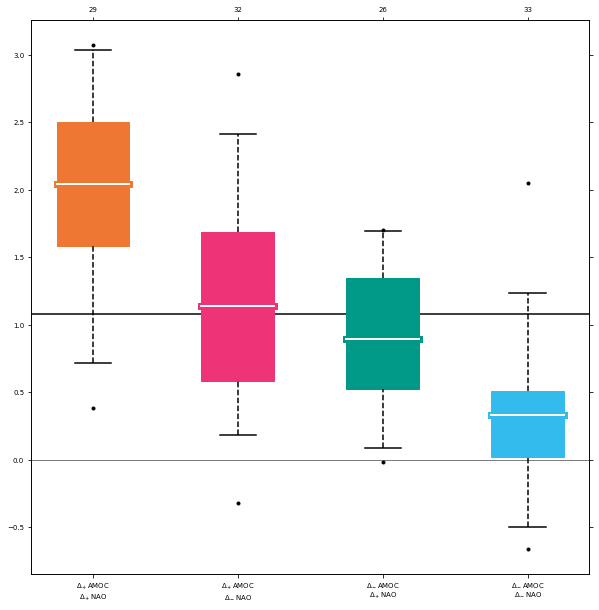

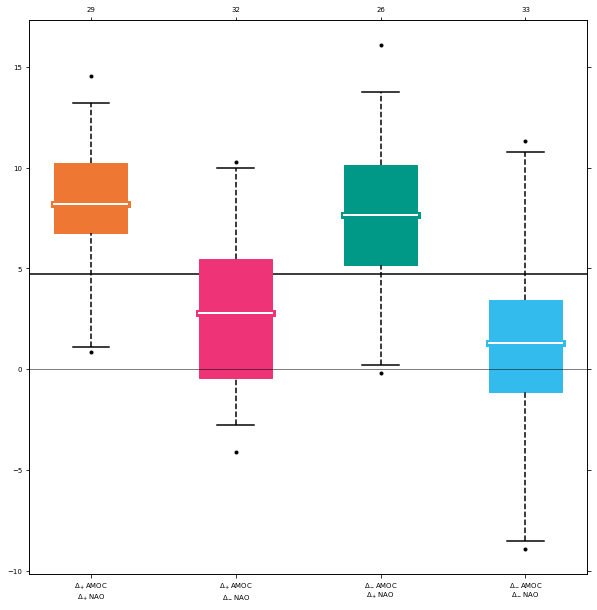

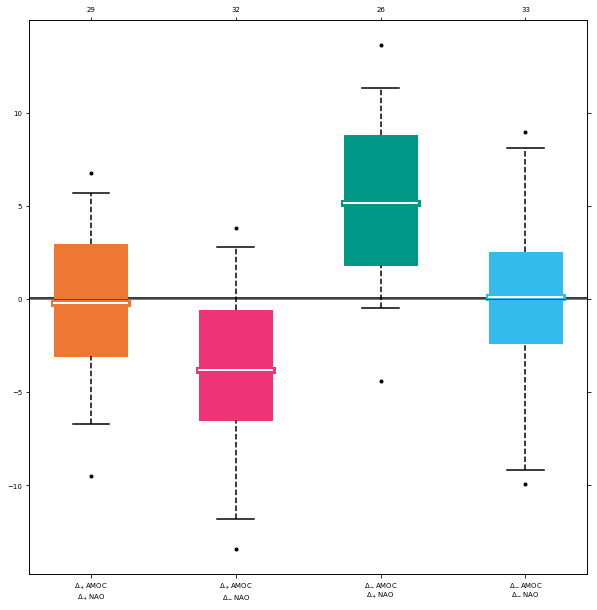

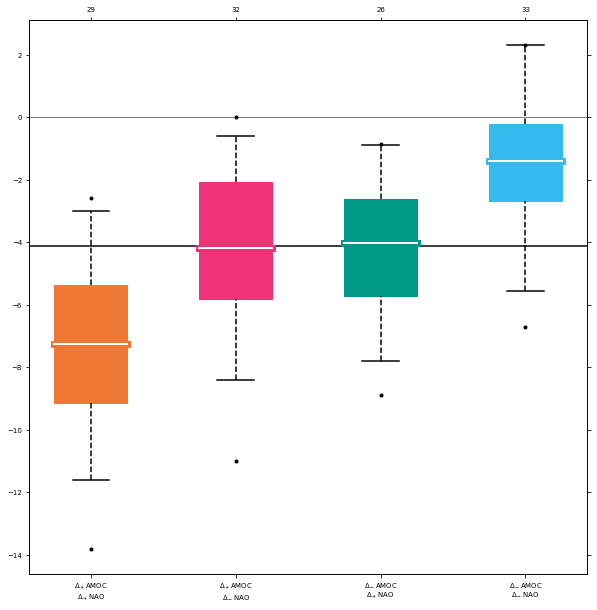

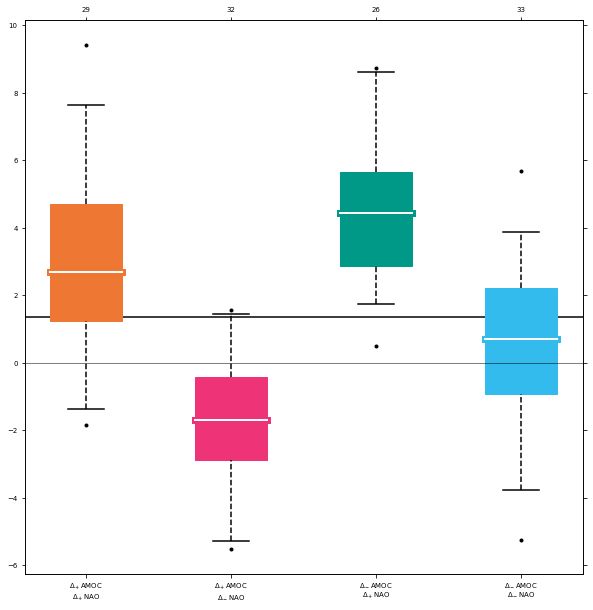

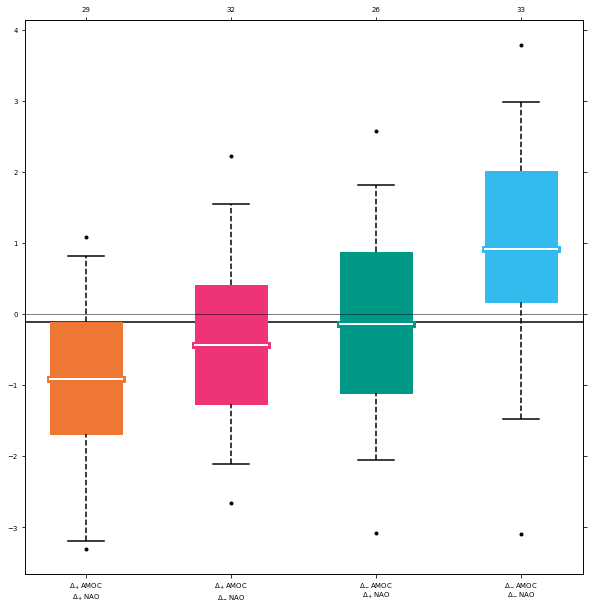

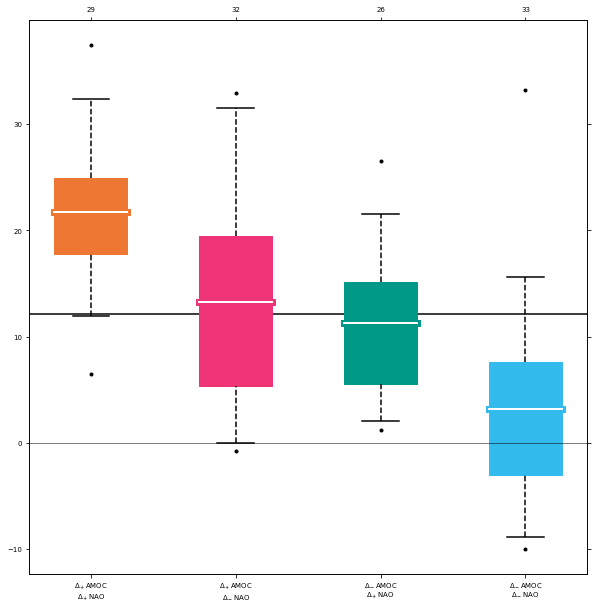

In [87]:
# Raw anomalies

figsize = (10, 10)

ds_signi = xr.Dataset()
for _target in target_ano:
    print(_target)

    ccscp = reload(ccscp)
    _data = target_ano[_target].dropna(dim='member')


    fig, ax = plt.subplots(figsize = figsize)
    tick_positions = list(); tick_labels = list()

    tmp = list()
    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
        tmp.append(_data.sel(member=_story_members))
        print(ccnp.mean(_data.sel(member=_story_members), weights = da_weight.sel(member=_story_members)))
        ccplt.boxplot([_data.sel(member=_story_members)],
                     weights = [da_weight.sel(member=_story_members)],
                     color = [story.colors[iS]],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=iS, width = 0.5)
        tick_positions.append(iS)
        tick_labels.append(len(_story_members))
    #ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
    #             bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(model_data), width = 0.5)
    ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member)),color='k', zorder=0)

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(len(story.stories))+.5-0.5)
    ax.set_xticklabels([_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels]) #, rotation=90)
    #ax.set_ylim([-3.5, 3.5])
    #ax.set_yticks([-2, -1, 0, 1, 2])
    #ax.set_yticklabels(['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$'])
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_raw.pdf', transparent=True)


    tmp = [_data] + tmp
    _signi_store1 = list()
    for iR in range(len(tmp)):
        _signi_store2 = list()
        _sub_ref = tmp[iR]; _wei_ref = da_weight.sel(member=_sub_ref.member)
        for iT in range(len(tmp)):
            _sub_test = tmp[iT]; _wei_test = da_weight.sel(member=_sub_test.member)
            _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                  ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
        _signi_store1.append(_signi_store2)
    ds_signi = ds_signi.assign(
        {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                              dims=['test', 'r', 'c'],
                              coords={'test': ['T-test', 'F-test'], 'r':['Mega-ensemble']+story.labels, 'c':['Mega-ensemble']+story.labels})})

    #for _target in ds_signi:
    #print(_target)
    for _test in ds_signi.test:
        print('Null hypothesis: '+h0[str(_test.values)])
        display(ds_signi.get(_target).sel(test=_test).to_pandas().style.format("{:.1%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))





tas_NEU_land
1.0845126005432295
0.10040612239258655
-0.2166155562747971
-0.8797532384597484


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


pr_NEU_land
0.6753341104124935
-0.3516481109547622
0.5579485450970453
-0.6920791461797909


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prsn_NEU_land
-0.03180896843946868
-0.759749963995699
0.973316734634936
-0.0021750353909506023


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


snc_NEU_land
-1.0154349760248744
-0.05092726007569581
0.05117465104334629
0.9014163886507353


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


sfcWind_NEU_land
0.39076790733188554
-0.928026614808568
0.9569328600074533
-0.19744460602861472


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


rsds_NEU_land
-0.5596350226376522
-0.24702298281708063
-0.016298556865487528
0.7441791995497324


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


prlq_NEU_land
0.9247415279174094
0.15640734560640804
-0.10636041049750508
-0.8805202635174179


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

Null hypothesis: Averages are significantly different.


Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


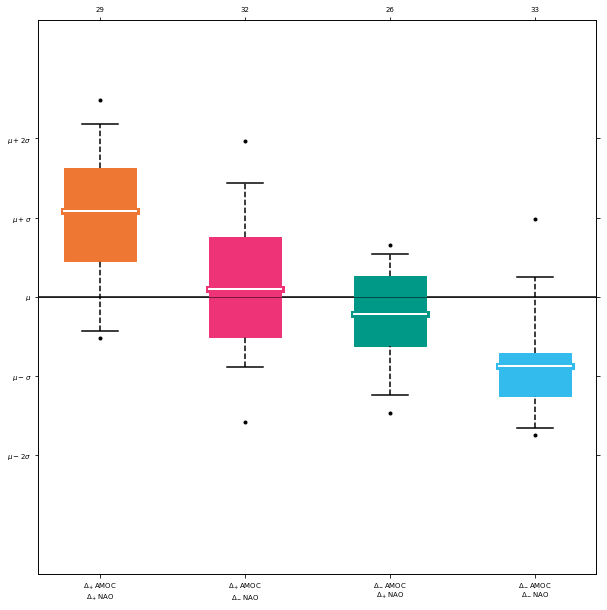

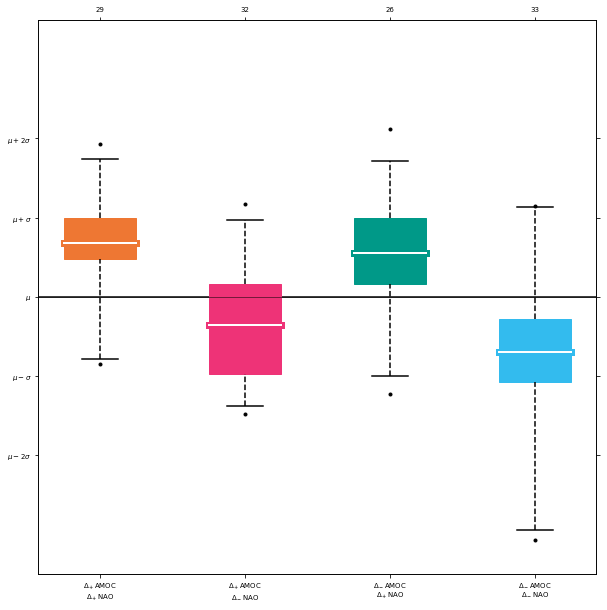

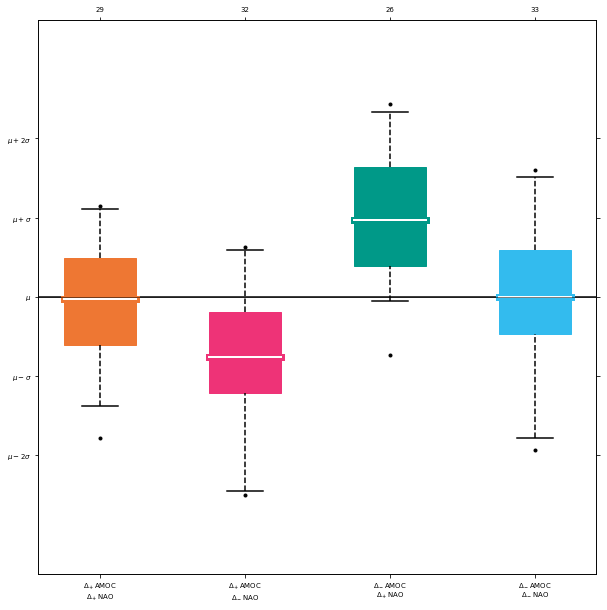

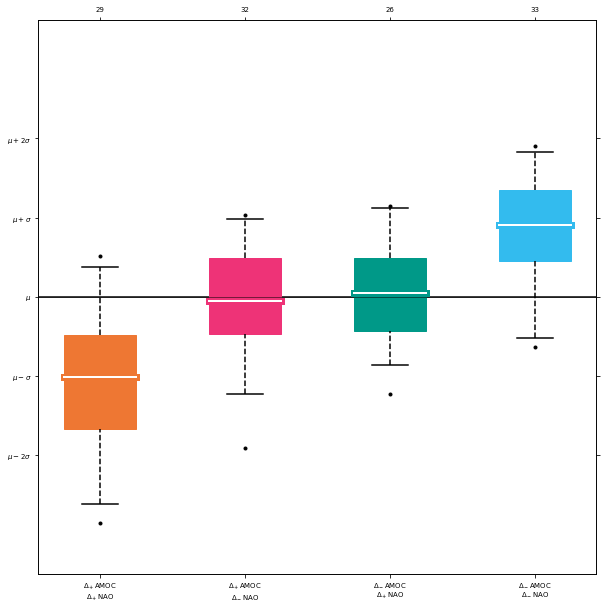

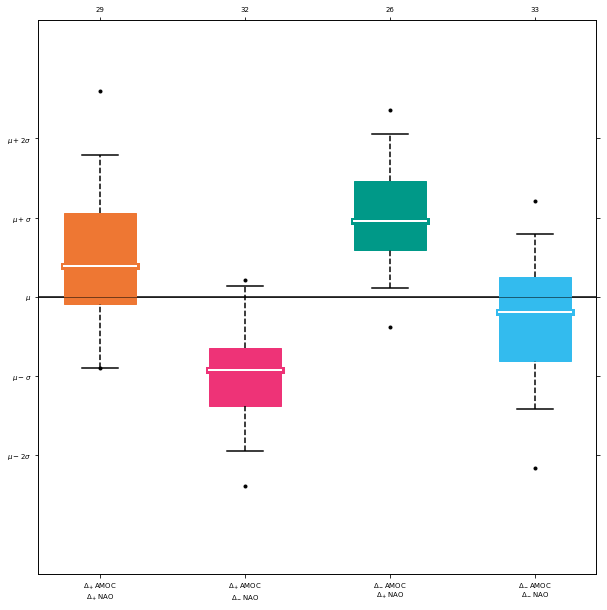

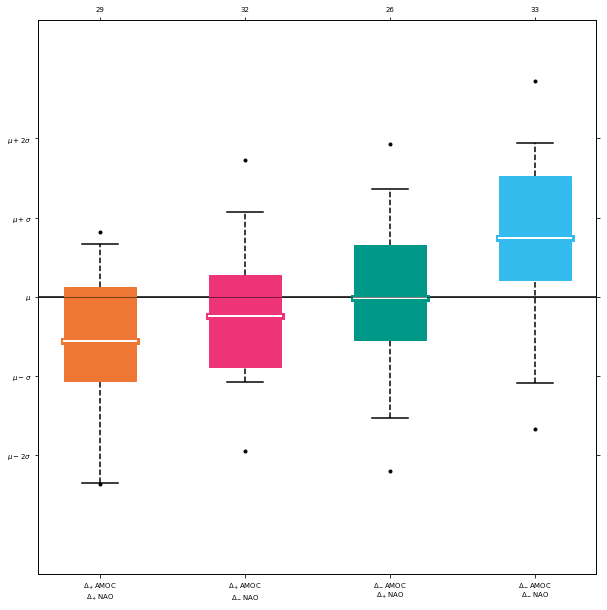

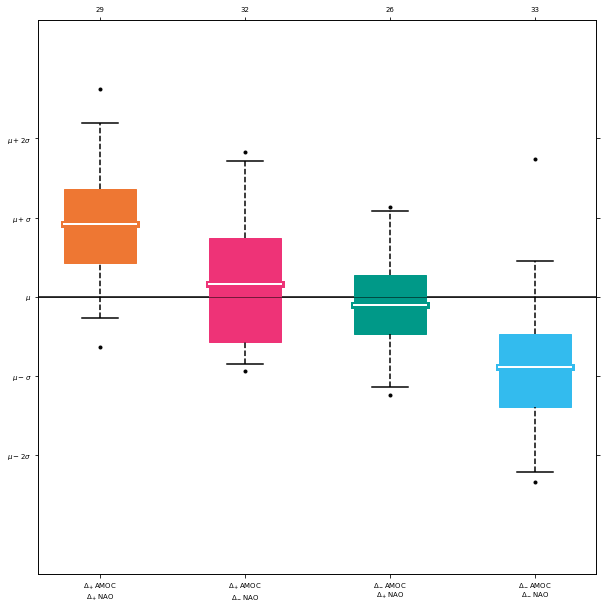

In [88]:
# Standardised-anomalies

figsize = (10, 10)

ds_signi = xr.Dataset()
for _target in target_ano_std:
    print(_target)

    ccscp = reload(ccscp)
    _data = target_ano_std[_target].dropna(dim='member')

    fig, ax = plt.subplots(figsize = figsize)
    tick_positions = list(); tick_labels = list()

    tmp = list()
    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
        tmp.append(_data.sel(member=_story_members))
        print(ccnp.mean(_data.sel(member=_story_members), weights = da_weight.sel(member=_story_members)))
        ccplt.boxplot([_data.sel(member=_story_members)],
                     weights = [da_weight.sel(member=_story_members)],
                     color = [story.colors[iS]],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext,
                     dx=iS, width = 0.5)
        tick_positions.append(iS)
        tick_labels.append(len(_story_members))
    #ccplt.boxplot([_data], weights = [da_weight.sel(member=_members)],
    #             bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(model_data), width = 0.5)
    ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member)),color='k', zorder=0)

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(len(story.stories))+.5-0.5)
    ax.set_xticklabels([_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels]) #, rotation=90)
    ax.set_ylim([-3.5, 3.5])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$'])
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_std.pdf', transparent=True)


    tmp = [_data] + tmp
    _signi_store1 = list()
    for iR in range(len(tmp)):
        _signi_store2 = list()
        _sub_ref = tmp[iR]; _wei_ref = da_weight.sel(member=_sub_ref.member)
        for iT in range(len(tmp)):
            _sub_test = tmp[iT]; _wei_test = da_weight.sel(member=_sub_test.member)
            _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                  ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
        _signi_store1.append(_signi_store2)
    ds_signi = ds_signi.assign(
        {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                                dims=['test', 'r', 'c'],
                                coords={'test': ['T-test', 'F-test'], 'r':['Mega-ensemble']+story.labels, 'c':['Mega-ensemble']+story.labels})})

    #for _target in ds_signi:
    #print(_target)
    for _test in ds_signi.test:
        print('Null hypothesis: '+h0[str(_test.values)])
        display(ds_signi.get(_target).sel(test=_test).to_pandas().style.format("{:.1%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))





In [89]:
'''
for _target in story.targets:

    toto = story.predict(
        target = _target,
        #drivers = xr.Dataset({story.drivers[i]: story.outputs.storindex.sel(driver=i).drop('driver') for i in story.drivers}),
    )

    tata = toto * ccnp.std(
        target_ano.get(_target), weights = da_weight
    ) + ccnp.mean(
        target_ano.get(_target), weights = da_weight)

    story.boxplot(target=_target)
    ax = plt.gca()
    ax.set_title(r'$\tilde{\Delta}$'+_target)
    for iS in range(len(story.stories)):
        ax.axhline(y=toto[iS],color=story.colors[iS], zorder=0)
    ax.axhline(y=0,color='k')
    ax.set_ylim([-3.5, 3.5])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$'])
    #plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_std.pdf', transparent=True)

    fig, ax = plt.subplots(figsize = (10,10))
    ax.set_title(r'$\tilde{\Delta}$'+_target)
    ccplt.boxplot([target_ano.get(_target).sel(member=story.families[story.stories[i]]['label']) for i in range(len(story.stories))],
                 weights = [da_weight.sel(member=story.families[story.stories[i]]['label']) for i in range(len(story.stories))],
                 color = story.colors,
                 label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
                 bar = bp_median_mean, box = bp_box, ext = bp_ext)
    for iS in range(len(story.stories)):
        ax.axhline(y=tata[iS],color=story.colors[iS], zorder=0)
    ax.axhline(y=ccnp.mean(target_ano.get(_target), weights=da_weight),color='k')
    ax.axhline(y=0,color='k',lw=.5)
    #ax.set_ylim(boxPlotLims)
    ax.yaxis.set_ticks_position('both')
    #plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_raw.pdf', transparent=True)
'''

print('tester la significativité de la réponse prédite ?')

tester la significativité de la réponse prédite ?


In [90]:
target_ano

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120)>
 array([ 1.42911049,  0.07746483,  0.65010168,  0.70985857,  2.40505653,
         0.94608251,  0.16221159,  1.49547151,  2.25937795,  1.03142114,
         1.21126046,  0.9074095 ,  2.17888367,  0.29440861,  2.17666858,
         0.78542104, -0.32653717,  0.88728211,  3.03339124,  1.08645558,
         2.85654898,  0.58103108,  1.28732608,  1.4241029 ,  0.21427796,
         0.24074714, -0.32115238,  1.38713172,  2.2230326 ,  0.53658753,
         1.10001786,  0.54034393,  1.13846907,  1.58441493,  0.52191622,
        -0.0178523 ,  0.46053477,  0.51586568,  3.07282102,  1.47054368,
         1.34856157,  1.77085088,  2.44238451,  0.35763831,  2.93002399,
         1.15907168,  0.80915506,  2.13504662,  1.97156394,  0.46030226,
         1.89832046,  0.38616483,  1.45693782,  0.71718569,  0.1989635 ,
        -0.2117645 ,  0.17048429,  0.61018564,  2.50436208, -0.31825187,
         2.50401377,  0.18629908,  0.02116921,  0.70162253,

In [91]:
figsize = (10, 10)
loc_variables = list(); loc_regions = list()
for _target in target_ano:
    _var, _reg, _ = _target.split('_')
    if _var not in loc_variables:
        loc_variables.append(_var)
    if _reg not in loc_regions:
        loc_regions.append(_reg)

if 'tas' in loc_variables and len(model) != 1:
    for _target in target_ano:
        _var, _reg, _ = _target.split('_')
        _data = target_ano[_target]
        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)

        Y = [[] for _ in range(len(_members_dict.keys()))]
        for iM, _model in enumerate(_members_dict.keys()):
            _tmp = list()
            for _experiment in _members_dict[_model].keys():
                _tmp.append(_data.sel(member=_members_dict[_model][_experiment]))
            _tmp = xr.concat(_tmp, dim='member')
            for iS, _sto in enumerate(story.stories):
                _interception = list(set(_tmp.member.values).intersection(set(story.families[_sto]['label'])))
                Y[iM].append(ccnp.mean(_tmp.sel(member=_interception)))
        Y = np.array(Y)

        _data = target_ano['tas_'+_reg+'_land'].sel(member=_members)
        X = list()
        for iM, _model in enumerate(_members_dict.keys()):
            _tmp = list()
            for _experiment in _members_dict[_model].keys():
                _tmp.append(_data.sel(member=_members_dict[_model][_experiment]))
            X.append(ccnp.mean(xr.concat(_tmp, dim='member')))
        X = np.array(X)

        fig, ax = plt.subplots(figsize = figsize)
        for iS, _sto in enumerate(story.stories):
            sklinreg = sklearn.linear_model.LinearRegression()
            sklinreg.fit(numpy.array(X)[:, numpy.newaxis], Y[:,iS])
            Xr = [min(X), max(X)]
            Yr = [sklinreg.intercept_+sklinreg.coef_*Xr[0], sklinreg.intercept_+sklinreg.coef_*Xr[1]]
            ax.plot(Xr, Yr, color='w', lw=5)
            ax.plot(Xr, Yr, lw=3, color=story.colors[iS], label = story.labels[iS])
            for iM, _model in enumerate(_members_dict.keys()):
                ax.plot(X[iM], Y[iM,iS], marker = model_markers[_model], color = story.colors[iS], ms=10)
        #ax.axvline(x=0,color='k',lw=.5)
        #ax.axhline(y=0,color='k',lw=.5)
        ax.set_xlabel('Forced response of temperature')
        ax.set_ylabel(r'$\Delta$'+_target)
        lgd = plt.legend(loc='upper left', fontsize=12); ax.add_artist(lgd)
        lgd = plt.legend(handles = model_legend_point, loc='lower right', fontsize=12); ax.add_artist(lgd)
        fig.savefig(figDir+saveName+'-'+_target+'_story_modelsFR_tas_'+_reg+'_land'+figExt,transparent=True)

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

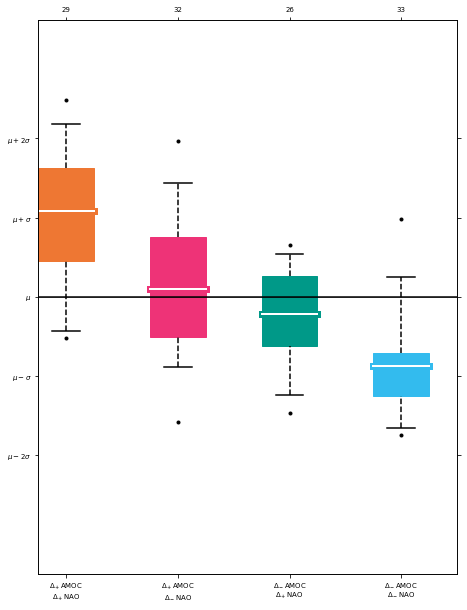

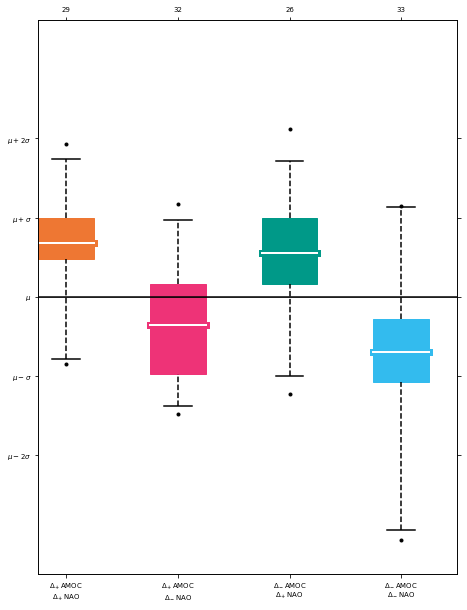

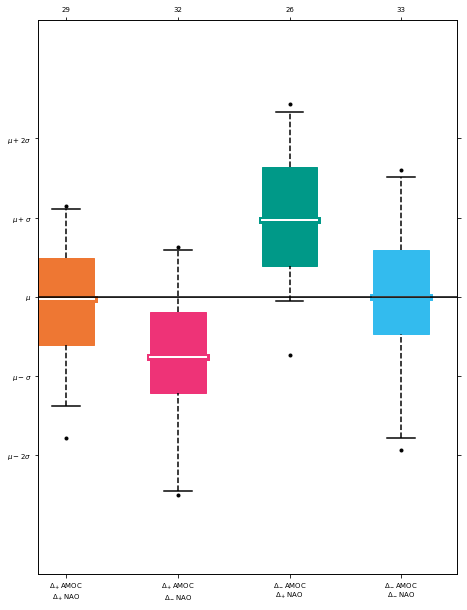

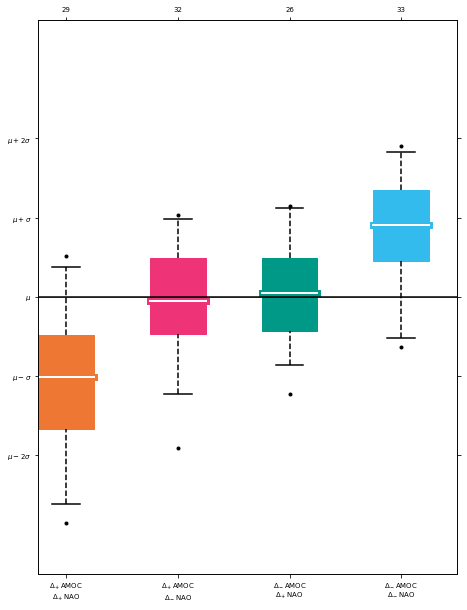

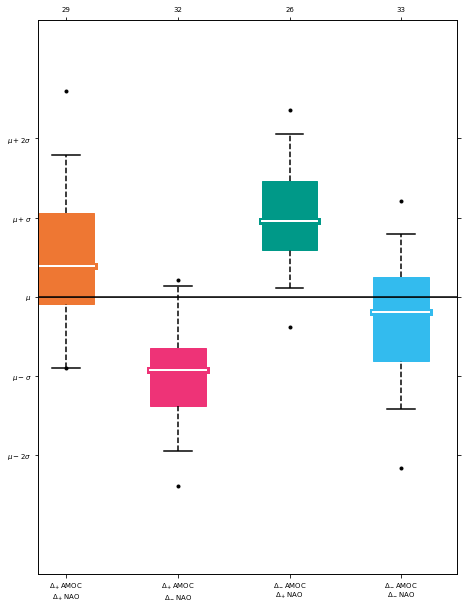

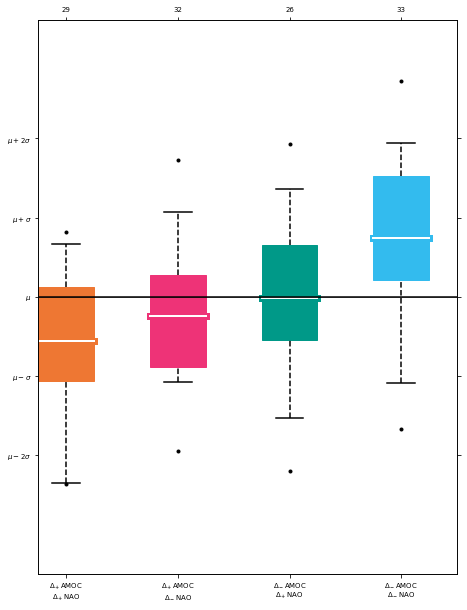

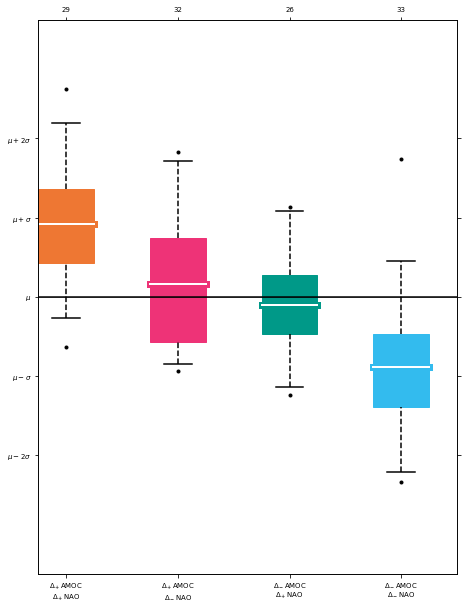

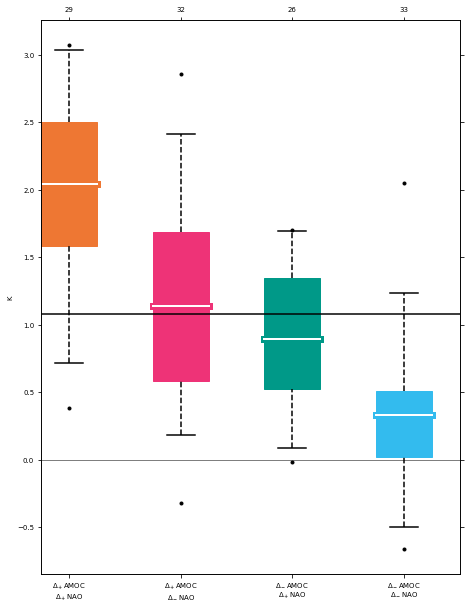

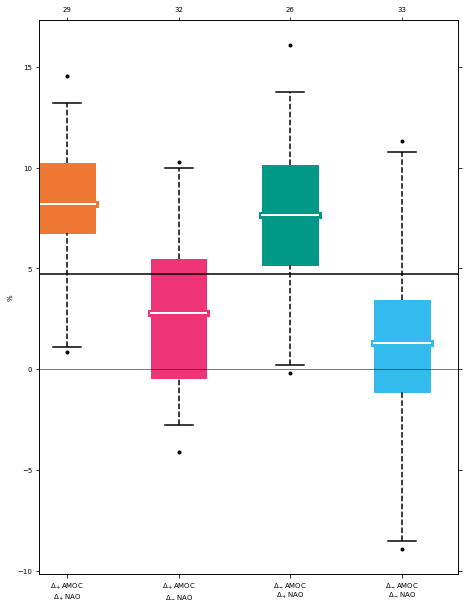

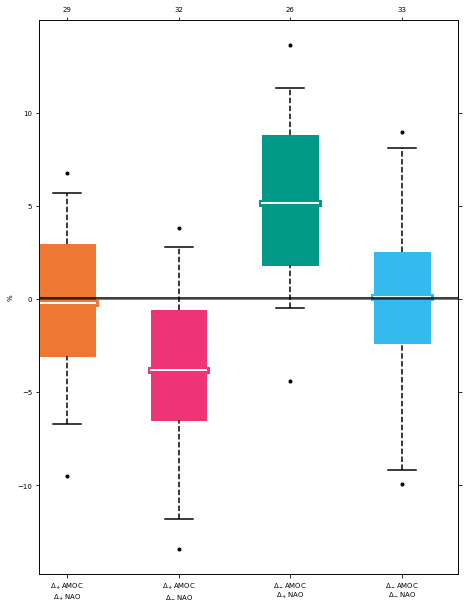

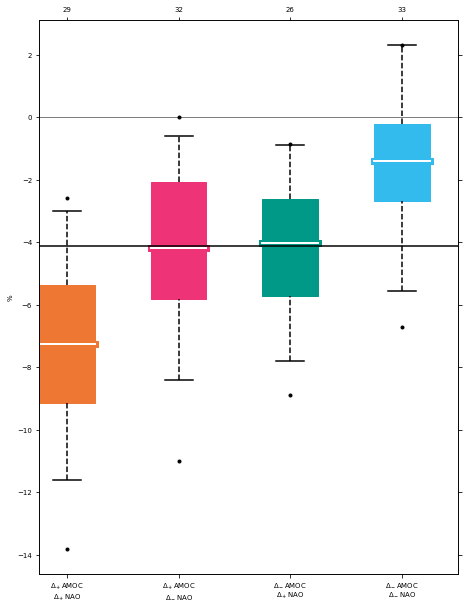

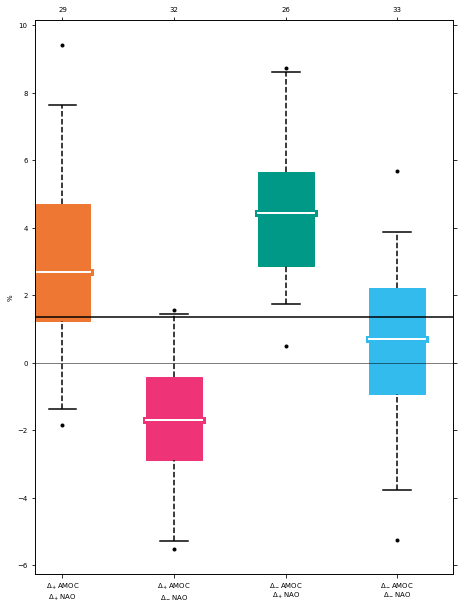

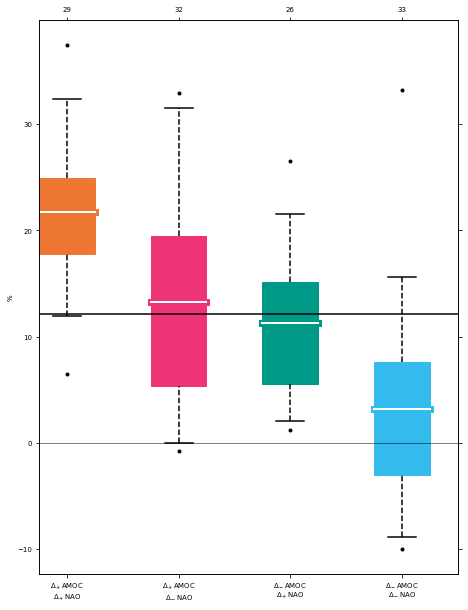

In [92]:
figsize = (15, 10)

for iD, _data in enumerate([target_ano_std, target_ano]):
    for _target in _data:
        _dict = cc.cmip6.get_members_dict(main_target_ano[_target].member.values)
        if len(model) == 1:
            figsize = (7.5, figsize[1])
            width = 0.5
            _x_label_rotation = 45
        else:
            width = 0.5/(len(_dict)+1)
            _x_label_rotation = 90





        fig, ax = plt.subplots(figsize = figsize)

        loc_data = list()
        loc_weights = list()
        loc_colors = list()
        loc_hatches = list()
        tick_positions = [[] for _ in range(len(story.stories))]
        tick_labels = [[] for _ in range(len(story.stories))]

        for i in range(len(story.stories)):
            _story_members = list(set(story.families[story.stories[i]]['label']).intersection(set(_data[_target].member.values)))
            loc_data.append(_data[_target].sel(member=_story_members))
            loc_weights.append(da_weight.sel(member=_story_members))
            loc_colors.append(story.colors[i])
            loc_hatches.append(None)
            tick_positions[i].append(i)
            if len(model) == 1:
                tick_labels[i].append(len(story.families[story.stories[i]]['label']))
            else:
                tick_labels[i].append('{0:.0f}%'.format(len(story.families[story.stories[i]]['label'])/len(members)*100.))

        ccplt.boxplot(loc_data, weights = loc_weights, color = loc_colors, hatch = loc_hatches,
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, width=width)

        #'''
        if len(model) != 1:
            for iM, _model in enumerate(_dict):
                loc_data = list()
                loc_colors = list()
                loc_hatches = list()
                for i in range(len(story.stories)):
                    _tmp = list()
                    _counter = 0
                    _total = 0
                    for _experiment in _dict[_model]:
                        for _member in _dict[_model][_experiment]:
                            if _member in story.families[story.stories[i]]['label']:
                                #_tmp.append(story.data.get(_target).sel(member=_member))
                                _tmp.append(_data.get(_target).sel(member=_member))
                                _counter += 1
                            _total += 1
                    tick_positions[i].append(i+(iM+1)/(len(_dict)+1))
                    #tick_labels[i].append('{0:.0f}% ('.format(_counter/_total*100.)+str(_counter)+'/'+str(_total)+')')
                    tick_labels[i].append(str(_counter)+' / '+str(_total))

                    loc_data.append(_tmp)
                    loc_colors.append(story.colors[i])
                    loc_hatches.append(model_hatches[_model])

                ccplt.boxplot(loc_data, color = loc_colors, hatch = loc_hatches, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                             dx=(iM+1)/(len(_dict)+1), width = width)
        #'''

        ax.yaxis.set_ticks_position('both')
        ax.set_xticks(np.arange(len(story.stories))+.5-width)
        if iD == 1:
            ax.set_xticklabels([story.labels[i].replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for i in range(len(story.stories))], rotation=0)
        else:
            ax.set_xticklabels([story.labels[i].replace(' ', '\n') for i in range(len(story.stories))], rotation=0) # .replace(' ', '\n') ; _x_label_rotation%90

        if _show_mega_ensemble:
            ax.set_xlim([-1.5/(len(_dict)+1), len(story.stories)-width])
        else:
            ax.set_xlim([-.5/(len(_dict)+1), len(story.stories)-width])
        ax.axhline(y=0,color='k',lw=.5)
        #ax.set_ylabel(story.data.get(_target).attrs['units'])
        ax.set_ylabel(_data.get(_target).attrs['units'])
        if len(model) != 1:
            lgd = plt.legend(handles = model_legend_box, fontsize=12)
            ax.add_artist(lgd)
            for i in range(0, len(story.stories)):
                ax.axvline(x=i-width,color='k',lw=1)
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        tick_positions = list(np.array(tick_positions).flatten())
        tick_labels = list(np.array(tick_labels).flatten())
        if _show_mega_ensemble:
            tick_positions.append(float(-1./(len(_dict)+1)))
            tick_labels.append(str(len(members)))
        ax2.set_xticks(tick_positions)
        if len(model) == 1:
            ax2.set_xticklabels(tick_labels)
        else:
            ax2.set_xticklabels(tick_labels, rotation=90, fontsize=15)

        #_yMin, _yMax = ax.get_ylim()

        if iD == 0:
            ax.axhline(y=0,color='k')

            ax.set_ylim([-3.5, 3.5])
            ax.set_yticks([-2, -1, 0, 1, 2])
            ax.set_yticklabels(['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$'])
            _save = 'std'
        elif iD ==1 :
            ax.axhline(y=ccnp.mean(_data.get(_target), weights=da_weight.sel(member=_data[_target].member)),color='k')
            _save = 'raw'

        fig.savefig(figDir+saveName+'-'+_target+'_boxplot_story_models_'+_save+figExt,transparent=True)
        
        
        
        

In [93]:
story.outputs.storindex

<xarray.DataArray 'storindex' (story: 4, driver: 2)>
array([[-0.54917116,  0.43963768],
       [ 0.26531276, -0.47763294],
       [-4.34231297,  0.63659898],
       [-3.52782905, -0.28067164]])
Coordinates:
  * story    (story) <U2 'AN' 'An' 'aN' 'an'
  * driver   (driver) <U4 'AMOC' 'NAO'

In [94]:
story.story_predict()

{'tas_NEU_land': <xarray.DataArray (story: 4)>
 array([ 2.23167291,  1.20667793,  0.95865152, -0.06634346])
 Coordinates:
   * story    (story) <U2 'AN' 'An' 'aN' 'an',
 'pr_NEU_land': <xarray.DataArray (story: 4)>
 array([ 9.64237926,  1.81167897,  7.64140025, -0.18930004])
 Coordinates:
   * story    (story) <U2 'AN' 'An' 'aN' 'an',
 'prsn_NEU_land': <xarray.DataArray (story: 4)>
 array([-1.79102619e-03, -6.27196932e+00,  6.43701905e+00,  1.66840758e-01])
 Coordinates:
   * story    (story) <U2 'AN' 'An' 'aN' 'an',
 'snc_NEU_land': <xarray.DataArray (story: 4)>
 array([-8.33468852, -4.36299971, -3.8931391 ,  0.07854972])
 Coordinates:
   * story    (story) <U2 'AN' 'An' 'aN' 'an',
 'sfcWind_NEU_land': <xarray.DataArray (story: 4)>
 array([ 3.14995316, -3.0930428 ,  5.79156417, -0.45143179])
 Coordinates:
   * story    (story) <U2 'AN' 'An' 'aN' 'an',
 'rsds_NEU_land': <xarray.DataArray (story: 4)>
 array([-1.20567804, -0.47099769,  0.24952147,  0.98420181])
 Coordinates:
   * story  

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

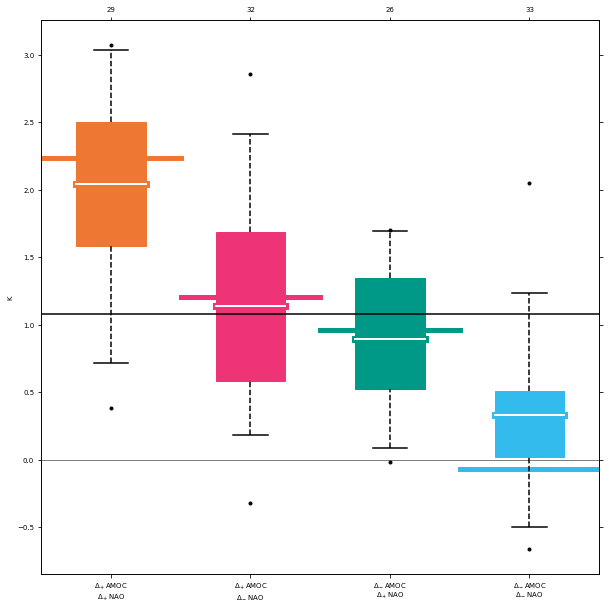

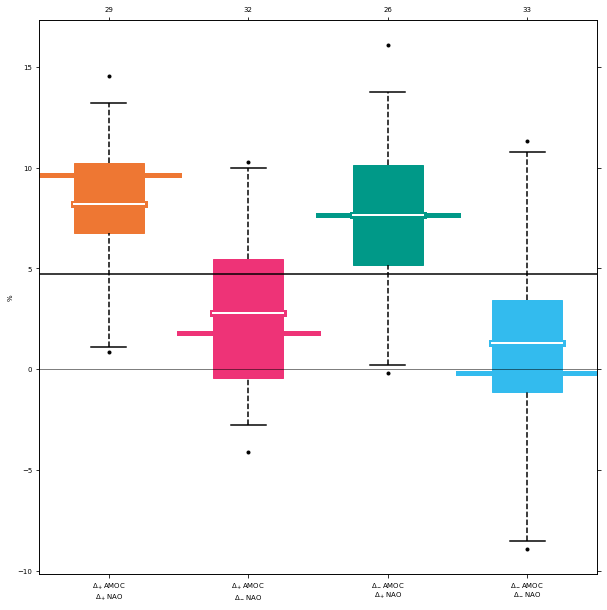

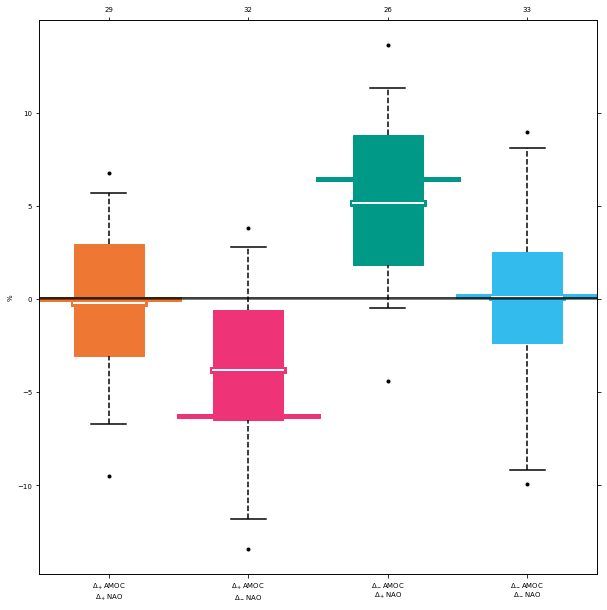

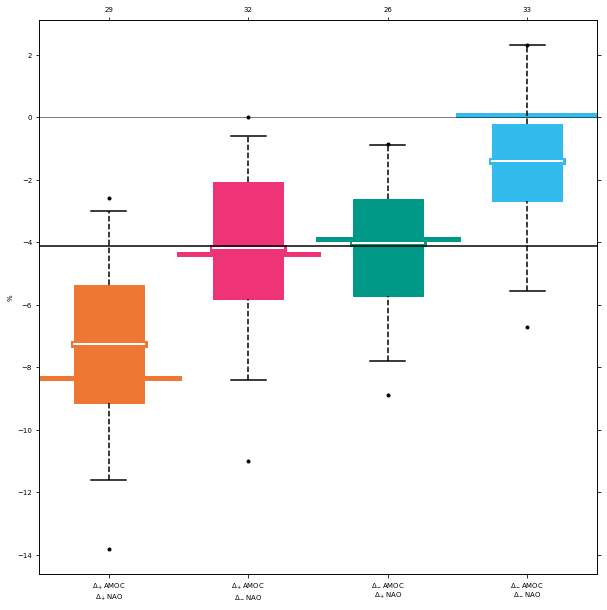

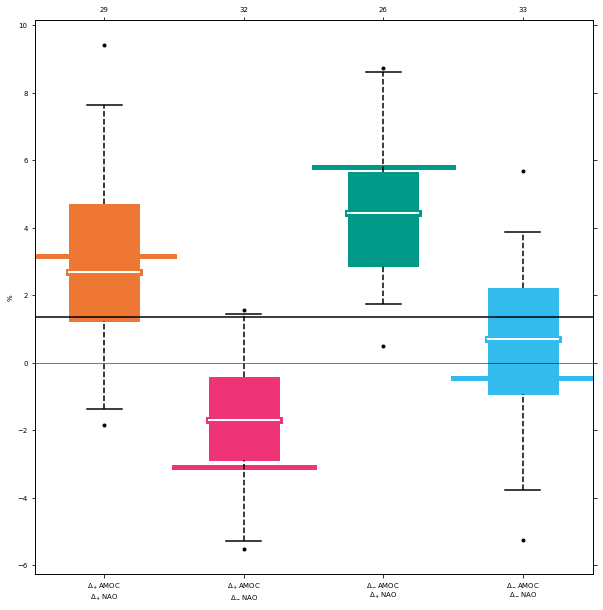

In [95]:
figsize = (10, 10)
width = 0.5

for _target in main_target_ano:
    _data = main_target_ano[_target]
    _members = _data.member.values

    fig, ax = plt.subplots(figsize = figsize)

    loc_data = list()
    loc_weights = list()
    loc_colors = list()
    loc_hatches = list()
    tick_positions = [[] for _ in range(len(story.stories))]
    tick_labels = [[] for _ in range(len(story.stories))]

    for i in range(len(story.stories)):
        _story_members = list(set(story.families[story.stories[i]]['label']).intersection(set(_data.member.values)))
        loc_data.append(_data.sel(member=_story_members))
        loc_weights.append(da_weight.sel(member=_story_members))
        loc_colors.append(story.colors[i])
        loc_hatches.append(None)
        tick_positions[i].append(i)
        if len(model) == 1:
            tick_labels[i].append(len(story.families[story.stories[i]]['label']))
        else:
            tick_labels[i].append('{0:.0f}%'.format(len(story.families[story.stories[i]]['label'])/len(_members)*100.))
        _pred = story.story_predict(_target)
        ax.axhline(xmin = 1./len(story.stories)*i, xmax = 1./len(story.stories)*(i+1),
                   y = _pred[i],
                   color = story.colors[i], lw = 5, zorder = 1)

    ccplt.boxplot(loc_data, weights = loc_weights, color = loc_colors, hatch = loc_hatches,
                 bar = bp_median_mean, box = bp_box, ext = bp_ext, width=width)
    ax.yaxis.set_ticks_position('both')
    ax.set_xticks(np.arange(len(story.stories))+.5-width)
    if normalisation_method == 'std':
        ax.set_xticklabels([story.labels[i].replace(' ', '\n') for i in range(len(story.stories))], rotation=0)
        ax.axhline(y=0,color='k')
        ax.set_ylim([-3.5, 3.5])
        ax.set_yticks([-2, -1, 0, 1, 2])
        ax.set_yticklabels(['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$'])
    else:
        ax.set_xticklabels([story.labels[i].replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for i in range(len(story.stories))], rotation=0) # .replace(' ', '\n') ; _x_label_rotation%90
        ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member)),color='k')
    #if _show_mega_ensemble:
    #    ax.set_xlim([-1.5/(len(_dict)+1), len(story.stories)-width])
    #else:
    ax.set_xlim([-width, len(story.stories)-width])
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_ylabel(_data.attrs['units'])
    #if len(model) != 1:
    #    lgd = plt.legend(handles = model_legend_box, loc='lower left', fontsize=12)
    #    ax.add_artist(lgd)
    #    for i in range(0, len(story.stories)):
    #        ax.axvline(x=i-width,color='k',lw=1)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    tick_positions = list(np.array(tick_positions).flatten())
    tick_labels = list(np.array(tick_labels).flatten())
    if _show_mega_ensemble:
        tick_positions.append(float(-1./(len(_dict)+1)))
        tick_labels.append(str(len(members)))
    ax2.set_xticks(tick_positions)
    if len(model) == 1:
        ax2.set_xticklabels(tick_labels)
    else:
        ax2.set_xticklabels(tick_labels, fontsize=15) #, rotation=90
    fig.savefig(figDir+saveName+'-'+_target+'_boxplot_story_pred'+figExt,transparent=True)

tas_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

pr_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

prsn_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

snc_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

sfcWind_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

rsds_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

prlq_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

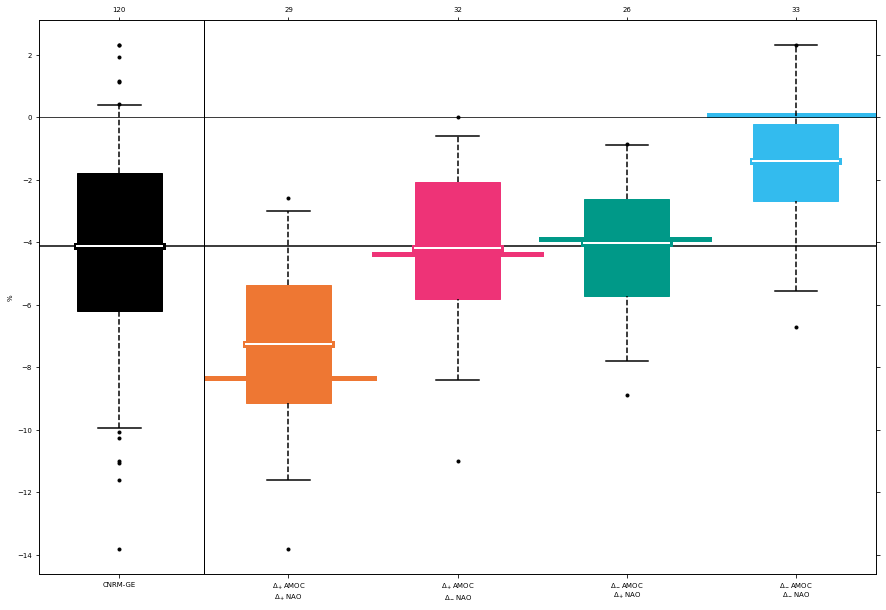

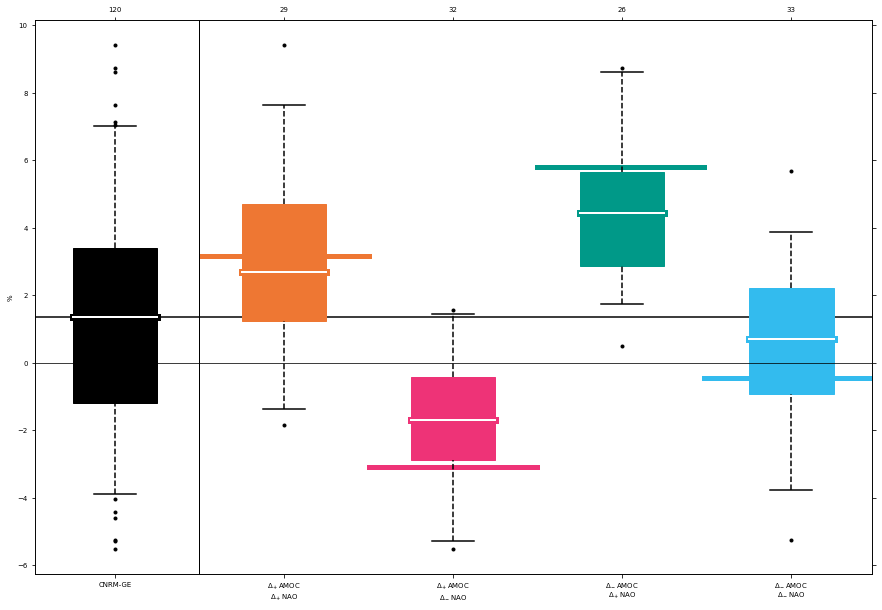

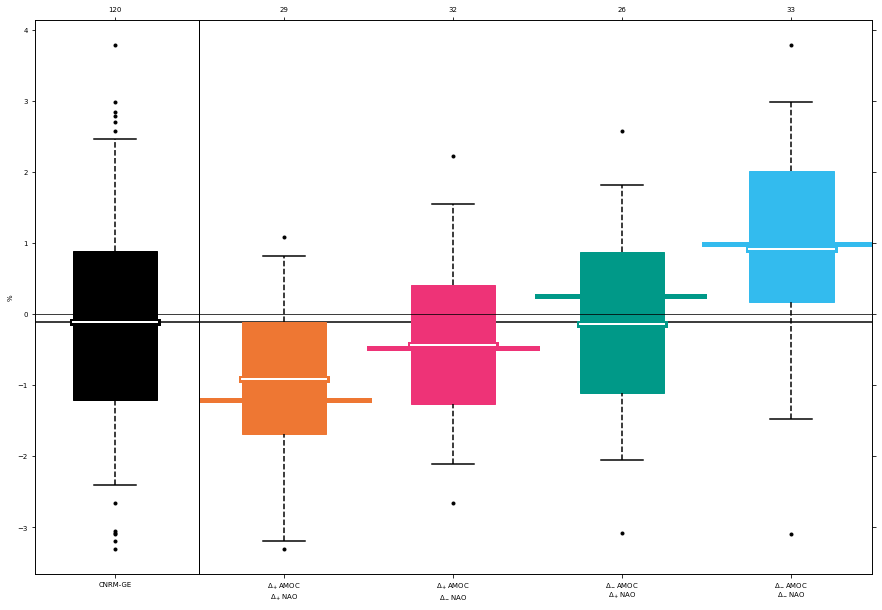

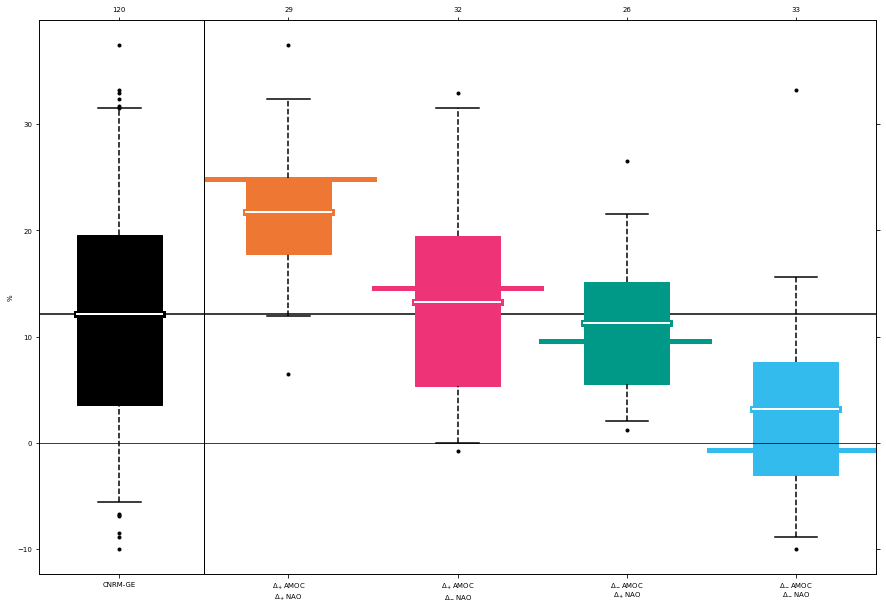

In [96]:
figsize = (15, 10)

for _target in target_ano:
    print(_target)

    _data = target_ano[_target]
    _me_avg = ccnp.mean(_data, weights=da_weight.sel(member=_data.member))
    _me_std = ccnp.std(_data, weights=da_weight.sel(member=_data.member))

    fig, ax = plt.subplots(figsize = figsize)
    tick_positions = list(); tick_labels = list()

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)

    tick_labels.append(len(_data.member))

    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
        ccplt.boxplot([_data.sel(member=_story_members)],
                        weights = [da_weight.sel(member=_story_members)],
                        color = [story.colors[iS]],
                        bar = bp_median_mean, box = bp_box, ext = bp_ext,
                        dx=1+iS, width = 0.5)
        tick_labels.append(len(_story_members))
        _pred = story.story_predict(_target)
        if normalisation_method == 'std':
            _pred = _pred*_me_std+_me_avg
        ax.axhline(xmin = (iS+1)/(1+len(story.stories)), xmax = (iS+2)/(1+len(story.stories)),
                    y = _pred[iS],
                    color = story.colors[iS], lw = 5, zorder = 1)

    ccplt.boxplot([_data], weights = [da_weight.sel(member=_data.member.values)],
                    bar = bp_median_mean, box = bp_box, ext = bp_ext, width = 0.5)
    ax.axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member.values)),color='k', zorder=0)

    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    ax.set_xticks(np.arange(1+len(story.stories)))
    ax.set_xticklabels(
        ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
        rotation=0)
    ax.set_ylabel(_data.attrs['units'])
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(np.arange(1+len(story.stories)))
    ax2.set_xticklabels(tick_labels)
    ax.axvline(x=0.5,color='k',lw=1)
    #for i in range(2):
        #ax.axvline(x=i-0.5,color='k',lw=1)
        #ax.plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_ME_story.pdf', transparent=True)

## Déclinaison inter-annuelle

In [97]:
dict_of_members = {ensemble_name[0]: members.copy()}
for _sto in story.stories:
    dict_of_members[_sto] = story.families[_sto]['label']
dict_of_members

{'CNRM-GE': ['CNRM-CM6-1_hist-ssp126_r10i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r11i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r12i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r13i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r14i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r15i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r16i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r17i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r18i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r19i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r1i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r20i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r21i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r22i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r23i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r24i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r25i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r26i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r27i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r28i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r29i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r2i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r30i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r3i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r4i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r5i1p1f2',
  'CNR

In [98]:
intann_ref = dict(); intann_int = dict()
for _target in target_data:
    _tmp_intann = target_data[_target] - target_data[_target].sel(time=slice(refStr, refEnd)).mean(dim='time', keep_attrs=True)
    intann_ref[_target] = _tmp_intann.sel(time=slice(refStr, refEnd)).assign_coords(time=np.arange(period_length))
    intann_int[_target] = _tmp_intann.sel(time=slice(intStr, intEnd)).assign_coords(time=np.arange(period_length))
intann_ref

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 20)>
 array([[-1.48834573e+00,  1.09632619e+00,  8.85641088e-01, ...,
         -7.79578462e-01,  8.22114660e-01, -6.34614359e-01],
        [ 7.54346840e-01, -4.50667430e+00, -7.33553591e-01, ...,
         -4.49085143e-01,  2.29593338e+00,  1.59036644e+00],
        [-8.65064134e-02, -1.34438144e+00, -1.04527792e+00, ...,
          6.34414002e-01,  1.66988334e+00,  9.83187010e-01],
        ...,
        [ 1.94162083e-01, -7.93284294e-01,  1.17722712e-01, ...,
          2.92337898e+00,  1.62048969e+00,  5.49791213e-01],
        [ 2.64585492e+00,  9.88039419e-01,  4.82302034e+00, ...,
         -3.04861321e-01, -1.43597336e-01, -7.74218942e-02],
        [-1.81391170e+00, -1.09980320e+00, -4.45162877e-01, ...,
          2.00680074e+00, -2.13828751e-03,  2.22550445e-01]])
 Coordinates:
   * member         (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM...
     source_id      <U10 'CNRM-CM6-1'
     experiment_id  (

In [99]:
intann_ref_std = dict(); intann_int_std = dict()
for _target in target_data:
    _ref_list = list()
    _int_list = list()
    for _model in model:
        _data_ref = intann_ref[_target].sel(member=[_member for _member in intann_ref[_target].member.values if _model in _member])
        _ref_list.append(_data_ref / _data_ref.std())
        _data_int = intann_int[_target].sel(member=[_member for _member in intann_int[_target].member.values if _model in _member])
        _int_list.append((_data_int - _data_int.mean()) / _data_int.std())
    intann_ref_std[_target] = xr.concat(_ref_list, dim='member') * intann_ref[_target].weighted(da_weight).std()
    intann_int_std[_target] = xr.concat(_int_list, dim='member') * intann_int[_target].weighted(da_weight).std() + intann_int[_target].weighted(da_weight).std()
intann_ref_std

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 20)>
 array([[-1.48834573e+00,  1.09632619e+00,  8.85641088e-01, ...,
         -7.79578462e-01,  8.22114660e-01, -6.34614359e-01],
        [ 7.54346840e-01, -4.50667430e+00, -7.33553591e-01, ...,
         -4.49085143e-01,  2.29593338e+00,  1.59036644e+00],
        [-8.65064134e-02, -1.34438144e+00, -1.04527792e+00, ...,
          6.34414002e-01,  1.66988334e+00,  9.83187010e-01],
        ...,
        [ 1.94162083e-01, -7.93284294e-01,  1.17722712e-01, ...,
          2.92337898e+00,  1.62048969e+00,  5.49791213e-01],
        [ 2.64585492e+00,  9.88039419e-01,  4.82302034e+00, ...,
         -3.04861321e-01, -1.43597336e-01, -7.74218942e-02],
        [-1.81391170e+00, -1.09980320e+00, -4.45162877e-01, ...,
          2.00680074e+00, -2.13828751e-03,  2.22550445e-01]])
 Coordinates:
   * member         (member) <U32 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM...
     source_id      <U10 'CNRM-CM6-1'
     experiment_id  (

In [100]:
'''
intann_ref = dict(); intann_int = dict()
for _target in target_data:
    _ref_mean = target_data[_target].sel(time=slice(refStr, refEnd)).mean(dim='time', keep_attrs=True)
    intann_ref[_target] = (target_data[_target].sel(time=slice(refStr, refEnd)) - _ref_mean).assign_coords(time=np.arange(period_length))
    intann_int[_target] = (target_data[_target].sel(time=slice(intStr, intEnd)) - _ref_mean).assign_coords(time=np.arange(period_length))
    #if relative and _target.split('_')[0] in cc.cmip6.relative_variables:
    #    intann_ref[_target] =  intann_ref[_target] / _ref_mean
    #    intann_int[_target] =  intann_int[_target] / _ref_mean
intann_ref
'''
''

''

In [101]:
'''
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

"""
get_color_gradient(
'#FFFFFF',

story.colors[i-1] if _ens != ensemble_name[0] else '#000000',
_n_levels), N=_n_levels)
"""
'''

def get_gradient_color_map(c1, c2, N):
    import matplotlib.colors
    return matplotlib.colors.LinearSegmentedColormap.from_list('gradient', [c1, c2], N)

In [102]:
#bootstrap = True; n_boot = 1000

intann_boot = dict()

if bootstrap:
    begin = time.time()
    tmp_prd_boot = dict()
    for _prd, _intann in (('ref', intann_ref), ('int', intann_int)):
        for _target in _intann:
            for _ens in dict_of_members:
                _members = list(set(_intann[_target].member.values).intersection(set(dict_of_members[_ens])))
                _name = _target+'_'+_ens+'_'+_prd
                tmp_prd_boot[_name] = list() if _name not in tmp_prd_boot else tmp_prd_boot[_name]
                _tmp = _intann[_target].sel(member=_members).stack(sample=('member', 'time'))
                _wei = da_weight.expand_dims({'time': _intann[_target].time}).stack(sample=('member', 'time')).sel(sample=_tmp.sample)
                for iB in range(n_boot):
                    tmp_prd_boot[_name] = tmp_prd_boot[_name] + [
                        _tmp.sel(sample=np.random.choice(_tmp.sample, size=len(_tmp.sample), replace=True, p=_wei/_wei.sum())
                                ).drop('sample').assign_coords({'boot': iB+1})]

    for _data in tmp_prd_boot:
        intann_boot[_data] = xr.concat(tmp_prd_boot[_data], dim='boot')
    print('Running time of cell is: {0:.1f}s'.format(time.time() - begin))

intann_boot

Running time of cell is: 302.3s


{'tas_NEU_land_CNRM-GE_ref': <xarray.DataArray 'tas_NEU_land' (boot: 1000, sample: 2400)>
 array([[ 1.35232891,  0.86871656,  0.53924149, ..., -1.89229803,
         -1.58683113, -0.63461436],
        [-0.27407196,  0.84077791, -1.33119573, ..., -1.01754304,
         -1.15986482, -1.41933201],
        [ 0.1530018 ,  0.33841133, -1.78852152, ..., -0.12011129,
         -2.80371052,  0.6142744 ],
        ...,
        [ 0.93249671,  0.37114765,  2.09426424, ...,  2.65877684,
          1.9733921 , -0.64571937],
        [ 0.94340711, -1.64810123,  2.4346403 , ...,  1.27043226,
         -0.10436015, -1.71453393],
        [ 0.53765109,  1.10829755, -3.17357041, ..., -2.66725653,
         -2.85623476,  2.14444271]])
 Coordinates:
     source_id      <U10 'CNRM-CM6-1'
     experiment_id  (boot, sample) <U11 'hist-ssp370' ... 'hist-ssp126'
     member_id      (boot, sample) <U9 'r30i1p1f2' 'r24i1p1f2' ... 'r30i1p1f2'
   * boot           (boot) int64 1 2 3 4 5 6 7 8 ... 994 995 996 997 998 999 1000

In [103]:
for _target in intann_ref:
    print(_target)
    for _ens in dict_of_members:
        _members = list(set(dict_of_members[_ens]).intersection(set(intann_ref[_target].member.values)))
        _da_intann_ref = intann_ref[_target].sel(member=_members)
        _da_intann_int = intann_int[_target].sel(member=_members)
        _da_weight = da_weight.sel(member=_da_intann_ref.member)
        # reference period
        _da_intann_ref_low = _da_intann_ref.weighted(_da_weight).quantile(int_low)
        _da_intann_ref_med = _da_intann_ref.weighted(_da_weight).quantile(.5)
        _da_intann_ref_high = _da_intann_ref.weighted(_da_weight).quantile(int_high)
        # interest period
        _da_intann_int_low = _da_intann_int.weighted(_da_weight).quantile(int_low)
        _da_intann_int_med = _da_intann_int.weighted(_da_weight).quantile(.5)
        _da_intann_int_high = _da_intann_int.weighted(_da_weight).quantile(int_high)
        if not relative or _target.split('_')[0] not in cc.cmip6.relative_variables:
            print('{:>10}'.format(_ens),
                  ' {0:.0f}%:'.format(100*int_low)+' {0:+.1f},'.format(_da_intann_int_low-_da_intann_ref_low),
                  '50%: {0:+.1f},'.format(_da_intann_int_med-_da_intann_ref_med),
                  '{0:.0f}%:'.format(100*int_high)+' {0:+.1f}'.format(_da_intann_int_high-_da_intann_ref_high))
        else:
            print('{:>10}'.format(_ens),
                  ' {0:.0f}%:'.format(100*int_low)+' {0:+.1f}%,'.format((_da_intann_int_low-_da_intann_ref_low)/_da_intann_ref_low),
                  '50%: {0:+.1f}%,'.format((_da_intann_int_med-_da_intann_ref_med)/_da_intann_ref_med),
                  '{0:.0f}%:'.format(100*int_high)+' {0:+.1f}%'.format((_da_intann_int_high-_da_intann_ref_high)/_da_intann_ref_high))
    print()


tas_NEU_land
   CNRM-GE  5%: +0.8, 50%: +1.1, 95%: +1.3
        AN  5%: +2.2, 50%: +2.1, 95%: +2.1
        An  5%: +1.2, 50%: +1.0, 95%: +1.3
        aN  5%: +0.8, 50%: +1.0, 95%: +0.6
        an  5%: +0.5, 50%: +0.5, 95%: +0.3

pr_NEU_land
   CNRM-GE  5%: -0.1%, 50%: +5.1%, 95%: +0.2%
        AN  5%: -0.2%, 50%: +16.4%, 95%: +0.3%
        An  5%: -0.1%, 50%: +1.1%, 95%: +0.1%
        aN  5%: -0.2%, 50%: -6.6%, 95%: +0.4%
        an  5%: +0.0%, 50%: -1.8%, 95%: +0.1%

prsn_NEU_land
   CNRM-GE  5%: +0.0%, 50%: -0.0%, 95%: +0.1%
        AN  5%: -0.0%, 50%: -0.1%, 95%: -0.0%
        An  5%: +0.1%, 50%: -8.4%, 95%: -0.1%
        aN  5%: -0.1%, 50%: -6.0%, 95%: +0.4%
        an  5%: -0.0%, 50%: -1.2%, 95%: +0.1%

snc_NEU_land
   CNRM-GE  5%: +0.6%, 50%: -4.6%, 95%: -0.2%
        AN  5%: +1.0%, 50%: -21.6%, 95%: -0.5%
        An  5%: +0.8%, 50%: -7.9%, 95%: -0.2%
        aN  5%: +0.3%, 50%: -4.2%, 95%: -0.3%
        an  5%: +0.2%, 50%: -1.4%, 95%: +0.0%

sfcWind_NEU_land
   CNRM-GE  5%: +0.0

In [104]:

def compare_extreme_events(X, Y, p, weights_x = None, weights_y = None, distrib_fit = None, relative = False):
    _X_w = X.weighted(weights_x) if weights_x is not None else X
    _Y_w = Y.weighted(weights_y) if weights_y is not None else Y
    if distrib_fit in ['norm', 'normal']:
        _reference_intensity = scipy.stats.norm.ppf(p, loc=_X_w.mean(), scale=_X_w.std())
        _new_p = scipy.stats.norm.cdf(_reference_intensity, loc=_Y_w.mean(), scale=_Y_w.std())
        _delta_intensity = scipy.stats.norm.ppf(p, loc=_Y_w.mean(), scale=_Y_w.std()) - _reference_intensity
        if relative:
            _delta_intensity = _delta_intensity / _reference_intensity
    elif distrib_fit in ['skewnorm', 'skew', 'skew-norm', 'skew-normal']:
        _reference_intensity = scipy.stats.skewnorm.ppf(
            p, ((X ** 3.).weighted(weights_x).mean() - 3. * _X_w.mean() * _X_w.std() ** 2. - _X_w.mean() ** 3. ) / (_X_w.std() ** 3.),
            loc=_X_w.mean(), scale=_X_w.std())
        _new_p = scipy.stats.skewnorm.cdf(
                _reference_intensity,
                ((Y ** 3.).weighted(weights_y).mean() - 3. * _Y_w.mean() * _Y_w.std() ** 2. - _Y_w.mean() ** 3. ) / (_Y_w.std() ** 3.),
                loc=_Y_w.mean(), scale=_Y_w.std())
        _delta_intensity = scipy.stats.skewnorm.ppf(p,
                ((Y ** 3.).weighted(weights_y).mean() - 3. * _Y_w.mean() * _Y_w.std() ** 2. - _Y_w.mean() ** 3. ) / (_Y_w.std() ** 3.),
                loc=_Y_w.mean(), scale=_Y_w.std()) - _reference_intensity
        if relative:
            _delta_intensity = _delta_intensity / _reference_intensity
    elif distrib_fit in ('gev', 'GEV'):
        _cX, _locX, _scaleX = scipy.stats.genextreme.fit(_X_w)
        _cY, _locY, _scaleY = scipy.stats.genextreme.fit(_Y_w)
        _reference_intensity = scipy.stats.genextreme.ppf(p, _cX, loc=_locX, scale=_scaleX)
        _new_p = scipy.stats.genextreme.cdf(_reference_intensity, _cY, loc=_locY, scale=_scaleY)
        _delta_intensity = scipy.stats.genextreme.ppf(p, _cY, loc=_locY, scale=_scaleY) - _reference_intensity
        if relative:
            _delta_intensity = _delta_intensity / _reference_intensity
    else:
        _reference_intensity = float(_X_w.quantile(p))
        _index = int(abs(Y.sortby(Y)-_reference_intensity).argmin().values)
        if _index < 0.001*len(Y):
            _new_p = 0. if _reference_intensity < Y.min().values else 1. / len(Y)
        elif _index > 0.999*len(Y):
            _new_p = 1. if _reference_intensity > Y.max().values else 1. - 1. / len(Y)
        else:
            if weights_y is not None:
                weight_y = weight_y.sortby(Y)
                _new_p = weight_y[0:_index].sum() / weight_y.sum()
            else:
                _new_p = _index / len(Y)
        _delta_intensity = float(_Y_w.quantile(p)) - _reference_intensity
        if relative:
            _delta_intensity = _delta_intensity / _reference_intensity
    return _new_p, _delta_intensity


def probability_ratio_percentile(X, Y, p, weights_x = None, weights_y = None, distrib_fit = None):
    _X_w = X.weighted(weights_x) if weights_x is not None else X
    _Y_w = Y.weighted(weights_y) if weights_y is not None else Y
    _p = list()
    if distrib_fit in ['norm', 'normal']:
        _reference_intensity = scipy.stats.norm.ppf(p, loc=_X_w.mean(), scale=_X_w.std())
        for _Y in (Y, Y - _Y_w.mean() + _X_w.mean()):
            _p.append(scipy.stats.norm.cdf(_reference_intensity, loc=_Y.mean(), scale=_Y.std()))
    elif distrib_fit in ['skewnorm', 'skew', 'skew-norm', 'skew-normal']:
        _reference_intensity = scipy.stats.skewnorm.ppf(
            p, ((X ** 3.).weighted(weights_x).mean() - 3. * _X_w.mean() * _X_w.std() ** 2. - _X_w.mean() ** 3. ) / (_X_w.std() ** 3.),
            loc=_X_w.mean(), scale=_X_w.std())
        for _Y in (Y, Y - _Y_w.mean() + _X_w.mean()):
            _Y = _Y.weighted(weights_y) if weights_y is not None else _Y
            _p.append(scipy.stats.skewnorm.cdf(
                _reference_intensity,
                ((_Y ** 3.).mean() - 3. * _Y.mean() * _Y.std() ** 2. - _Y.mean() ** 3. ) / (_Y.std() ** 3.),
                loc=_Y.mean(), scale=_Y.std()))
    elif distrib_fit in ('gev', 'GEV'):
        _cX, _locX, _scaleX = scipy.stats.genextreme.fit(_X_w)
        _reference_intensity = scipy.stats.genextreme.ppf(p, _cX, loc=_locX, scale=_scaleX)
        for _Y in (Y, Y - _Y_w.mean() + _X_w.mean()):
            _Y = _Y.weighted(weights_y) if weights_y is not None else _Y
            _cY, _locY, _scaleY = scipy.stats.genextreme.fit(_Y)
            _p.append(scipy.stats.genextreme.cdf(_reference_intensity, _cY, loc=_locY, scale=_scaleY))
    else:
        _reference_intensity = float(_X_w.quantile(p))
        for _Y in (Y.sortby(Y), (Y - _Y_w.mean() + _X_w.mean()).sortby(Y)):
            _Y = _Y.weighted(weights_y) if weights_y is not None else _Y
            _index = int(abs(_Y-_reference_intensity).argmin().values)
            if _index < 0.001*len(_Y):
                if _reference_intensity < _Y.min().values:
                    _p.append(0.)
                else:
                    _p.append(1. / len(_Y))
            elif _index > 0.999*len(_Y):
                if _reference_intensity > _Y.max().values:
                    _p.append(1.)
                else:
                    _p.append(1. - 1. / len(_Y))
            else:
                if weights_y is not None:
                    weight_y = weight_y.sortby(_Y)
                    _p.append(weight_y[0:_index].sum() / weight_y.sum())
                else:
                    _p.append(_index / len(_Y))
    _pr = (_p[0]/p, (_p[0]-_p[1]+p)/p, _p[1]/p)
    _r = ((_pr[1]-1)/(_pr[0]-1), (_pr[2]-1)/(_pr[0]-1))
    
    return _pr, _r


In [105]:
def attribution_fraction(X, Y, target=None, p=None, weights_x=None, weights_y=None, distrib_fit = None):
    if (target is None and p is None) or (target is not None and p is not None):
        print('Exactly one (1) of the following input parameters needs to / must be given: "target" or "p".')
    else:
        _p0 = ... if p is None else p
        _reference_intensity = ... if target is None else target

        _X_w = X.weighted(weights_x) if weights_x is not None else X
        _Y_w = Y.weighted(weights_y) if weights_y is not None else Y
        if distrib_fit in ['norm', 'normal']:
            _reference_intensity = scipy.stats.norm.ppf(p, loc=_X_w.mean(), scale=_X_w.std())
            _new_p = scipy.stats.norm.cdf(_reference_intensity, loc=_Y_w.mean(), scale=_Y_w.std())
            _delta_intensity = scipy.stats.norm.ppf(p, loc=_Y_w.mean(), scale=_Y_w.std()) - _reference_intensity
        elif distrib_fit in ['skewnorm', 'skew', 'skew-norm', 'skew-normal']:
            _reference_intensity = scipy.stats.skewnorm.ppf(
                p, ((X ** 3.).weighted(weights_x).mean() - 3. * _X_w.mean() * _X_w.std() ** 2. - _X_w.mean() ** 3. ) / (_X_w.std() ** 3.),
                loc=_X_w.mean(), scale=_X_w.std())
            _new_p = scipy.stats.skewnorm.cdf(
                    _reference_intensity,
                    ((Y ** 3.).weighted(weights_y).mean() - 3. * _Y_w.mean() * _Y_w.std() ** 2. - _Y_w.mean() ** 3. ) / (_Y_w.std() ** 3.),
                    loc=_Y_w.mean(), scale=_Y_w.std())
            _delta_intensity = scipy.stats.skewnorm.ppf(p,
                    ((Y ** 3.).weighted(weights_y).mean() - 3. * _Y_w.mean() * _Y_w.std() ** 2. - _Y_w.mean() ** 3. ) / (_Y_w.std() ** 3.),
                    loc=_Y_w.mean(), scale=_Y_w.std()) - _reference_intensity
        elif distrib_fit in ('gev', 'GEV'):
            _cX, _locX, _scaleX = scipy.stats.genextreme.fit(_X_w)
            _cY, _locY, _scaleY = scipy.stats.genextreme.fit(_Y_w)
            _reference_intensity = scipy.stats.genextreme.ppf(p, _cX, loc=_locX, scale=_scaleX)
            _new_p = scipy.stats.genextreme.cdf(_reference_intensity, _cY, loc=_locY, scale=_scaleY)
            _delta_intensity = scipy.stats.genextreme.ppf(p, _cY, loc=_locY, scale=_scaleY) - _reference_intensity
        else:
            _reference_intensity = float(_X_w.quantile(p))
            _index = int(abs(Y.sortby(Y)-_reference_intensity).argmin().values)
            if _index < 0.001*len(Y):
                _new_p = 0. if _reference_intensity < Y.min().values else 1. / len(Y)
            elif _index > 0.999*len(Y):
                _new_p = 1. if _reference_intensity > Y.max().values else 1. - 1. / len(Y)
            else:
                if weights_y is not None:
                    weight_y = weight_y.sortby(Y)
                    _new_p = weight_y[0:_index].sum() / weight_y.sum()
                else:
                    _new_p = _index / len(Y)
            _delta_intensity = float(_Y_w.quantile(p)) - _reference_intensity
        return _new_p, _delta_intensity

# Shortcut

In [110]:
_ylabel = {
    'tas': '$\Delta{T}$',
    'snc': '$\Delta{snowcover}$',
    'prsn': '$\Delta{S}$',
    'prlq': '$\Delta{R}$',
    'pr': '$\Delta{P}$',
    'sfcWind': '$\Delta{wind}$',
    'rsds': '$\Delta{solar}$'
}
_ylabel

{'tas': '$\\Delta{T}$',
 'snc': '$\\Delta{snowcover}$',
 'prsn': '$\\Delta{S}$',
 'prlq': '$\\Delta{R}$',
 'pr': '$\\Delta{P}$',
 'sfcWind': '$\\Delta{wind}$',
 'rsds': '$\\Delta{solar}$'}

# Paper

In [124]:
matplotlib.rcParams.update({
    'text.usetex': False, # True False
    'font.family': 'sans-serif', #"Helvetica",
    #'font.fontname': 'Helvetica',
})

## Figure 1

In [ ]:
begin = time.time()

cctim = reload(cctim)

anomaly = 'internal variability'

season_3m = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
if temporality in season_3m:
    seasons = season_3m
    
list_of_files = os.listdir('/data/home/globc/line/scratch/Data/Computed/')
list_of_files.sort()

index_seasons_data = dict(); index_seasons_ano = dict(); index_seasons_anomaly = dict(); index_annual_anomaly = dict()
index_weight = dict()
for _variable in [variable]:
    for _region in region:
        list_seasons_data = list(); list_seasons_ano = list(); list_seasons_anomaly = list(); list_annual_anomaly = list()
        for _model in model:
            _experiments = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            _experiments = list(set(_experiments).intersection(set(cc.cmip6.scenario_mip_dict[_model]['experiment'])))
            for _experiment in _experiments:
                tmp_data = list()
                if _experiment in ('piControl'):
                    _n_max = None; _refStr = None; _date_start = None; _date_stop = None
                    _period = ''
                else:
                    _n_max = 1; _refStr = refStr
                    _date_start = str(min(int(refStr), int(intStr))-1); _date_stop = str(min(int(refEnd), int(intEnd))-1)
                    _period = '1850-2100'
                    if _model == 'CNRM-CM6-1' or (_model == 'MIROC6' and _experiment == 'hist-ssp245'):
                        _period = '1850-2039'
                    if _model == 'IPSL-CM6A-LR':
                        _period = '1850-2059'
                #if _experiment in cc.cmip6.scenario_mip_dict[_model]['experiment']:
                for file in list_of_files:
                    if variable+'_'+cc.cmip6.table_dict[variable]+'_'+_model+'_'+_experiment+'_r' in file and '_'+_region+mask_land_sea+'_' in file and _period in file:
                        print('/data/home/globc/line/scratch/Data/Computed/'+file)
                        tmp_data.append(xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+file).get(variable).assign_coords({'source_id': _model, 'experiment_id': _experiment}).expand_dims(['source_id', 'experiment_id']))
                tmp_seasons = tmp_data[0] if len(tmp_data) == 1 else xr.concat(tmp_data, dim='member')
                tmp_seasons = tmp_seasons.resample(time='M').mean(dim = 'time', keep_attrs = True)
                tmp_seasons = xr.concat([cctim.get_season(tmp_seasons, _season) for _season in seasons],
                                        pd.Index(seasons, name='season')).resample(time='Y').mean(dim = 'time', keep_attrs = True)
                if _experiment == 'piControl':
                    tmp_seasons = tmp_seasons.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp_seasons.time), freq = 'M')})
                list_seasons_data.append(tmp_seasons)
                list_seasons_ano.append(cctim.get_anomalies(out_print=True,
                    data=list_seasons_data[-1], n_max=_n_max, calcul=anomaly,
                    start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))
                list_seasons_anomaly.append(
                    tmp_seasons - tmp_seasons.sel(time=slice(_refStr, str(int(_refStr)+period_length))).mean(dim='time')
                )
                tmp_annual = tmp_data[0] if len(tmp_data) == 1 else xr.concat(tmp_data, dim='member')
                tmp_annual = tmp_annual.resample(time='Y').mean(dim = 'time', keep_attrs = True)
                list_annual_anomaly.append(
                    tmp_annual - tmp_annual.sel(time=slice(_refStr, str(int(_refStr)+period_length))).mean(dim='time')
                )
        tmp_seasons_data = list_seasons_data[0] if len(list_seasons_data) == 1 else xr.concat(list_seasons_data, dim='member')
        tmp_seasons_ano = list_seasons_ano[0] if len(list_seasons_ano) == 1 else xr.concat(list_seasons_ano, dim='member')
        tmp_seasons_anomaly = list_seasons_anomaly[0] if len(list_seasons_anomaly) == 1 else xr.concat(list_seasons_anomaly, dim='member')
        tmp_annual_anomaly = list_annual_anomaly[0] if len(list_annual_anomaly) == 1 else xr.concat(list_annual_anomaly, dim='member')

        '''
        for _drop in ['MPI-ESM1-2-LR_hist-ssp119_r8i1p1f1', 'MPI-ESM1-2-LR_hist-ssp126_r8i1p1f1', 'MPI-ESM1-2-LR_hist-ssp245_r8i1p1f1', 'MPI-ESM1-2-LR_hist-ssp370_r8i1p1f1', 'MPI-ESM1-2-LR_hist-ssp585_r8i1p1f1']:
            try:
                tmp_seasons_data = tmp_seasons_data.drop_sel(member=_drop)
                tmp_seasons_ano = tmp_seasons_ano.drop_sel(member=_drop)
            except:
                pass
        '''

        # Data with all seasons for the preliminary analyses
        index_seasons_data[_variable+'_'+_region] = tmp_seasons_data.sortby('member')
        index_seasons_ano[_variable+'_'+_region] = tmp_seasons_ano.sortby('member')
        index_seasons_anomaly[_variable+'_'+_region] = tmp_seasons_anomaly.sortby('member')
        index_annual_anomaly[_variable+'_'+_region] = tmp_annual_anomaly.sortby('member')

        weight = list()
        _members = index_seasons_ano[_variable+'_'+_region].member.values
        _members.sort()
        _members_dict = cc.cmip6.get_members_dict(_members)
        for _member in _members:
            _model, _, _ = _member.split('_'); _N = 0
            for _scenario in _members_dict[_model].keys():
                _N += len(_members_dict[_model][_scenario])
                #_N += len(members_dict[_model][_scenario])
            weight.append(1/_N)
        index_weight[_variable+'_'+_region] = xr.DataArray(weight, dims = ['member'], coords = {'member': _members}).sortby('member')

end = time.time()
print('Runtime of the regional data loading is', '{0:.1f}'.format(end - begin), 's')

index_seasons_ano

In [ ]:
# Paper Figure 1

### Signal-to-noise ratio (https://doi.org/10.1175/2009BAMS2607.1)
ls = [':', '--', '-.', '-']

for i, _index in enumerate(index_seasons_ano):
    print(_index)
    _variable, _region = _index.split('_')

    fig, ax = plt.subplots(2, 1, figsize=(single_column_width, 115*mm), sharex = True)
    for _x in range(12):
        ax[0].axvline(x=_x, c='gray', lw=.5, zorder=0)
        ax[1].axvline(x=_x, c='gray', lw=.5, zorder=0)

    # Variance arround the forced response
    plot_data = np.array([0 * index_F[_index].values, index_Fm[_index].values, index_Fs[_index].values, index_Fv[_index].values])
    labels = ['Model ('+str(len(index_seasons_ano[_index].source_id))+')', 'SSP uncertainty', 'Internal variability uncertainty']
    ###labels = ['Model ('+str(len(index_seasons_ano[_index].source_id))+')', 'SSP ('+str(len(index_seasons_ano[_index].experiment_id))+' scenarios)', 'Internal variability ('+str(len(index_seasons_ano[_index].member))+' members)']
    colors = ['blue', 'green', 'orange']
    for j in range(3):
        inf = index_mu[_index] - np.sum(plot_data[:j+2], 0)
        sup = index_mu[_index] + np.sum(plot_data[:j+2], 0)
        if (inf != sup).all():
            ax[0].fill_between(np.arange(-1,13), [inf[-1]]+list(inf)+[inf[0]], [sup[-1]]+list(sup)+[sup[0]], label=labels[j], color = colors[j], zorder=3-j)
    ax[0].plot(np.arange(-1,13),[index_mu[_index][-1]]+list(index_mu[_index])+[index_mu[_index][0]], c='w', lw='2', zorder=5)
    ax[0].set_xticks(np.arange(12))
    ax[0].set_xticklabels(seasons, rotation=90)
    ax[0].set_xlim(-0.5,11.5)
    ax[0].axhline(y=0,color='k',lw=.5)
    ax[0].set_ylabel('Temperature change (°C)')
    ###ax[0].set_ylabel(index_seasons_ano[_index].attrs['units'])
    #ax[0].set_title('Anomaly of '+print_var+' in '+print_reg+' '+print_uni+'\n'+intStr+'-'+intEnd+' relative to '+refStr+'-'+refEnd)
    ax[0].legend(fontsize=5, loc='upper center')
    if _variable == 'tas':
        ax[0].set_ylim(-0.5, 3.)
    ax[0].yaxis.set_ticks_position('both')
    ax[0].set_title('a) Sources of uncertainties for seasonal temperature change\nover Northern Europe relative to 1995-2014')
    #plt.savefig(figDir+saveNameIndex+'-'+_index+'_season_anova_anomaly.pdf', transparent=True)


    _variable, _region = _index.split('_')
    _ls = ls if len(index_seasons_ano[_index].source_id) != 1 else ['-']
    '''
    ax[1].plot(np.arange(-1, 13), [index_SNR[_index][-1]]+index_SNR[_index].values.tolist()+[index_SNR[_index][0]],
            ls=_ls[i], lw=8, c='w', zorder=100)
    ax[1].plot(np.arange(-1, 13), [index_SNR[_index][-1]]+index_SNR[_index].values.tolist()+[index_SNR[_index][0]],
            ls=_ls[i], lw=7, c='k', label=_region, zorder=101)
    '''

    for _experiment in index_seasons_ano[_index].experiment_id.values:
        _da_delta = index_seasons_ano[_index].sel(experiment_id=_experiment).expand_dims('experiment_id')
        _da_weight = index_weight[_index].sel(member=_da_delta.member)

        # Computation of ANOVA terms: https://journals.ametsoc.org/view/journals/clim/24/17/2011jcli4085.1.xml
        _index_mu = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'experiment_id', 'member'))
        _index_alpha = _da_delta.weighted(_da_weight).mean(dim=('experiment_id', 'member')) - _index_mu
        _index_beta = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'member')) - _index_mu
        _index_gamma = _da_delta.weighted(_da_weight).mean(dim=('member')) + _index_mu - _index_alpha - _index_beta
        _index_nu = _da_delta - _da_delta.weighted(_da_weight).mean(dim=('member'))
        #
        _index_M = _index_alpha.var(dim=('source_id'))
        _index_S = _index_beta.var(dim=('experiment_id'))
        _index_I = _index_gamma.var(dim=('source_id', 'experiment_id'))
        _index_V = _index_nu.weighted(_da_weight).var(dim=('source_id', 'experiment_id', 'member'))
        _index_T = _index_V + _index_M + _index_S + _index_I

        # Signal-to-noise ratio: https://journals.ametsoc.org/view/journals/bams/90/8/2009bams2607_1.xml
        _index_SNR = xr.DataArray(np.array(_index_mu / conf_factor / np.sqrt(_index_T)),
                                            dims = _index_T.dims, coords = _index_T.coords)

        ax[1].plot(np.arange(-1, 13), [_index_SNR[-1]]+_index_SNR.values.tolist()+[_index_SNR[0]],
                ls=_ls[i], lw=2, c=cc.cmip6.experiment_dict[_experiment]['color'])
    #ax[1].legend(fontsize=5)
    ax[1].set_xticks(np.arange(12))
    ax[1].set_xticklabels(seasons, rotation=90)
    ax[1].set_xlim(-0.5, 11.5)
    yMin, yMax = ax[1].get_ylim()
    #for _y, _lw in [[-1., 2.5], [0., 1.], [1., 2.5]]:
    #    if _y > yMin and _y < yMax:
    #        ax[1].axhline(y=_y,color='k',lw=_lw)
    ax[1].axhline(y=1.,color='k',lw=1.)
    ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both')
    lgd = plt.legend(handles = experiment_legend_box, fontsize=5, loc='upper left'); ax[1].add_artist(lgd)
    ax[1].set_ylabel('Signal-to-noise ratio')
    ax[1].set_title('b) Signal-to-noise ratio for seasonal temperature change')

    #plt.plot(_mean_for_snr); plt.plot(_std_for_snr); ax.plot(np.arange(12),_da.weighted(da_weight).mean(dim=('source_id', 'experiment_id', 'member')), c='w', lw='3', zorder=5)
    ##ax.set_yscale('log', subs=np.arange(1, _snr_max)); ax.set_yticks(np.arange(1, _snr_max)); ax.set_yticklabels(np.arange(1, _snr_max))
    #ax.set_title('Signal-to-noise ratio of '+print_var+' in '+print_reg+' '+print_uni+'\n'+intStr+'-'+intEnd+' relative to '+refStr+'-'+refEnd)
    saveFig = figDir+saveNameIndex+'-paper_seasonal_anova_snr.pdf'
    print(saveFig)
    plt.savefig(saveFig, transparent=True)

## Figure 2

In [125]:
ccscp = reload(ccscp)

_show_mega_ensemble = True
_median_mean='mean'


ds_signi = xr.Dataset()
for _target in target_ano:
    if _target == 'tas_NEU_land':
        print(_target)

        _data = target_ano[_target]

        fig, ax = plt.subplots(figsize = (single_column_width, 60*mm)) # 75mm

        _tmp = list(_data.member.values); _tmp.sort()
        _dict = cc.cmip6.get_members_dict(_tmp)

        tick_positions = list()
        tick_labels = list()

        _signi_store0 = list()

        model_data = {_model: [] for _model in _dict}
        experiment_data = {_experiment: [] for _experiment in experiments}
        experiment_data_weights = {_experiment: [] for _experiment in experiments}

        for iM, _model in enumerate(_dict):
            #print(_model)
            loc_data = list()
            loc_colors = list(); loc_hatches = list()
            for i, _experiment in enumerate(experiments): # experiments
                loc_tmp = list()
                if _experiment in _dict[_model].keys():
                    for _member in _dict[_model][_experiment]:
                        loc_tmp.append(float(_data.sel(member=_member).values))
                        model_data[_model].append(float(_data.sel(member=_member).values))
                        experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                        experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
                    tick_positions.append(iM/len(_dict)+i)
                    tick_labels.append(len(_dict[_model][_experiment]))
                else:
                    loc_tmp.append(np.nan)
                loc_data.append(loc_tmp)
                loc_colors.append(cc.cmip6.experiment_dict[_experiment]['color'])
                loc_hatches.append(model_hatches[_model] if len(model) !=1 else None)
            loc_data.append(_data.sel(member=[_member for _member in _data.member.values if _model in _member]).values)
            loc_colors.append('k')
            loc_hatches.append(model_hatches[_model] if len(model) !=1 else None)

            ccplt.boxplot(loc_data, color = loc_colors, hatch = loc_hatches, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                            dx=iM/len(_dict), width = 0.5/len(_dict))

            _signi_store1 = list()
            for iR, _sub_ref in enumerate(loc_data):
                _signi_store2 = list()
                for iT, _sub_test in enumerate(loc_data):
                    _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test).pvalue,
                                            ccscp.ftest_ind(_sub_ref, _sub_test).pvalue])
                _signi_store1.append(_signi_store2)
            _signi_store0.append(
                xr.DataArray(np.array(_signi_store1).transpose(),
                                name = _target,
                                dims=['test', 'r', 'c'],
                                coords={'test': ['T-test', 'F-test'], 'r':experiments+ensemble_name, 'c':experiments+ensemble_name}).assign_coords({'source_id': _model}))
        ds_signi = ds_signi.assign({_target: xr.concat(_signi_store0, dim='source_id')})
        for _model in _dict:
            print(_model)
            for _test in ds_signi.test:
                print('Null hypothesis: '+h0[str(_test.values)])
                display(ds_signi.get(_target).sel(test=_test, source_id=_model).to_pandas().style.format("{:.0%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.axvline(x=len(experiments)-.5,color='k',lw=.5)
        ax.set_xticks(np.arange(len(experiments)+1)+.5-0.5/len(_dict))
        ax.set_xticklabels([cc.cmip6.experiment_dict[s]['name'] for s in experiments]+ensemble_name, rotation=0) # 90
        if _show_mega_ensemble:
            ax.set_xlim([-.5/len(_dict), len(experiments)+0.5/len(_dict)])
        else:
            ax.set_xlim([-.5/len(_dict), len(experiments)-0.5/len(_dict)])
        if _prefix == 'norm_':
            y_norm(ax=ax)
        else:
            ax.set_ylabel('Temperature change (°C)') #ax.set_ylabel(_data.attrs['units'])
        if len(model) != 1:
            lgd = plt.legend(handles = model_legend_box, loc='lower left', fontsize=12)
            ax.add_artist(lgd)
            for i in range(len(experiments)+1):
                ax.axvline(x=i-0.5/len(_dict),color='k',lw=1)
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        tick_positions = list(np.array(tick_positions).flatten())
        tick_labels = list(np.array(tick_labels).flatten())
        if _show_mega_ensemble:
            tick_positions.append(float(len(experiments)))
            tick_labels.append(str(len(members)))
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)

        ax.axhline(y=ccnp.mean(_data, weights=da_weight),color='k', lw=3,zorder=0)
        plt.savefig(figDir+saveName+'-'+_target+'_boxplot_SSP_ME.pdf', transparent=True)


tas_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 

Null hypothesis: Sample variances are significantly different.


/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


## Figure 3

In [126]:

for _field in field_ano_raw.keys():
    if _field == 'tas':
        ##fig, ax = plt.subplots(story.ndrivers + 1, 1, figsize = (10, 21), subplot_kw=dict(projection=ccrs.PlateCarree())) #, width_ratios=[1, 1])
        fig, ax = plt.subplots(story.ndrivers + 1, 1, figsize = (single_column_width, 170*mm), subplot_kw=dict(projection=ccrs.PlateCarree())) #, width_ratios=[1, 1]) # 210mm
        nbins=21
        cmap_params = {'vmin': -1, 'vmax': 1}
        _row_length = 10
        #for iD, _driver in enumerate(driver_ano):
        for iD, _driver in enumerate(list(driver_ano.keys())[::-1]):
            _x = driver_ano.get(_driver); _y = field_ano_raw.get(_field)
            _X = (_x - _x.mean()) / _x.std()
            slope_list = list(); pvalue_list = list()
            for _lat in _y.lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
                slope_list_lat = list(); pvalue_list_lat = list()
                for _lon in _y.lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
                    if _y[0].sel(lat=_lat, lon=_lon):
                        _Y = _y.sel(lat=_lat, lon=_lon)
                        _slope, _, _rvalue, _pvalue, _ = scipy.stats.linregress(_X, _Y)
                        _slope = xr.DataArray([[_slope]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                        _pvalue = 2.*(1.-scipy.stats.t.cdf(abs(scipy.stats.t.ppf(_pvalue/2., 119)), 30))
                        _pvalue = xr.DataArray([[_pvalue]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                    else:
                        _slope = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                        _pvalue = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                    slope_list_lat.append(_slope)
                    pvalue_list_lat.append(_pvalue)
                slope_list.append(xr.concat(slope_list_lat, dim='lon'))
                pvalue_list.append(xr.concat(pvalue_list_lat, dim='lon'))
            slope = xr.concat(slope_list, dim='lat')
            pvalue = xr.concat(pvalue_list, dim='lat')

            vmax = .9
            vmin = -vmax
            cs = cc.maplot(slope, ax = ax[iD], zmin=vmin, zmax=vmax, nbins=nbins, cmap=ccmp.get_diverging_cmap(**cmap_params), plotmode='raster', significance=pvalue, hide_ax_labels=True)
            ax[iD].coastlines()
            ax[iD].set_extent(zone)

            if show_box is not None:
                for _region in show_box:
                    if _region in ['FRA']:
                        shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
                    else:
                        shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                    bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = ax[iD], color='k', linestyle='-', linewidth=3, zorder=None, disp_name= 'tl')

            #ax[iD].set_title(r"\textbf{"+subfigure_label[iD]+"Regression pattern of ["+delta_print+_driver+"]' on "+delta_print+target_dict[_field]+"}")
            ax[iD].set_title(subfigure_label[iD]+r"Regression pattern of "+delta_print+target_dict[_field]+" on "+delta_print+_driver, fontsize=8)
            #fig.colorbar(cs, ax=ax[iD], label='°C', orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')
        
        cbar = fig.colorbar(cs, ax=ax[:-1], label='Temperature anomalies (°C/$\sigma_{driver}$)', orientation='vertical', fraction=.05, shrink=.75, aspect=40, extend = 'neither')
        cbar.ax.tick_params(labelsize=5)

        nbins = 11
        _diff_contour = .5
        cmap_params = {'vmin': 0., 'vmax': 100.}
        cmap_loc = ccmp.get_diverging_cmap(**cmap_params)
        ax[-1].coastlines()
        ax[-1].set_extent(zone)
        cs = cc.maplot(
            field_exp_var.get(_field)*100.,
            ax = ax[-1], cmap = 'BuGn', #ccmp.cmap('BuGn'), # 'incandescent' 'iridescent' 'Greens' #cmap_loc,
            zmin=cmap_params['vmin'], zmax=cmap_params['vmax'], nbins=nbins, plotmode='raster', hide_ax_labels=True)
        if show_box is not None:
            for _region in show_box:
                if _region in ['FRA']:
                    shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
                else:
                    shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = ax[-1], color='k', linestyle='-', linewidth=3, zorder=None, disp_name= 'tl')
        #ax[-1].set_title(subfigure_label[story.ndrivers]+r"Variance of "+delta_print+target_dict[_field]+" explained by ["+delta_print+str("]' & ["+delta_print).join(story.drivers)+"]'")
        ax[-1].set_title(subfigure_label[story.ndrivers]+r"Variance of "+delta_print+target_dict[_field]+" explained by "+delta_print+str(" & "+delta_print).join(story.drivers), fontsize=8)
        cbar = fig.colorbar(cs, ax=ax[-1], label='Percentage (%)', orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')
        cbar.ax.tick_params(labelsize=5)

        plt.savefig(figDir+saveName+'-'+_field+'_map_regressions_explained_variance.pdf', transparent=True)

## Figure 4

tas_NEU_land


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

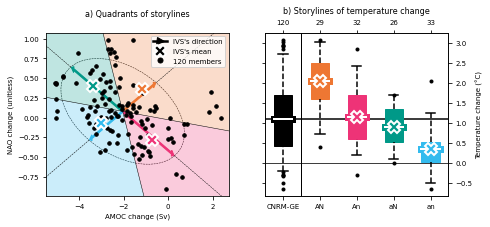

In [127]:
if len(drivers) == 2:
    for _target in target_ano.keys():
        if _target == 'tas_NEU_land':
            print(_target)

            _data = target_ano[_target]
            _me_avg = ccnp.mean(_data, weights=da_weight.sel(member=_data.member))
            _me_std = ccnp.std(_data, weights=da_weight.sel(member=_data.member))

            #fig, ax = plt.subplots(1,2, figsize = (18, 12), width_ratios=[2, 1])
            ##fig, ax = plt.subplots(1,2, figsize = (20, 10), width_ratios=[1, 1])
            fig, ax = plt.subplots(1,2, figsize = (double_column_width, 75*mm), width_ratios=[1, 1]) # (double_column_width, 90*mm)

            ax[0].set_title("a) Quadrants of storylines\n", fontsize=8)
            ax[1].set_title("b) Storylines of temperature change", fontsize=8)

            #ax[0].axvline(x=0, c='k', lw=.5, zorder=1); ax[0].axhline(y=0, c='k', lw=.5, zorder=1)
            ax[0].set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax[0].set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
            #for _model in members_dict.keys():
            #    for _experiment in members_dict[_model].keys():
            #        #sc = ax[0].scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
            #        #                   main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]),
            #        #                   c = cc.cmip6.experiment_dict[_experiment]['color'],
            #        #                   marker = model_markers[_model], zorder=1, s=21)
            #        ax[0].plot(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]).mean(),
            #                   main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]).mean(),
            #                   c = cc.cmip6.experiment_dict[_experiment]['color'], ms=15,
            #                   marker = model_markers[_model], zorder=2)
            story.plot_quadrants(ax=ax[0], show_members=True, show_stories=False, markersize=7) # markersize=12
            ax[0].set_xlabel('AMOC change (Sv)')
            ax[0].set_ylabel('NAO change (unitless)')

            #ccplt.confidence_ellipse(
            #            story.outputs.storindex.sel(driver = story.drivers_names[0]),
            #            story.outputs.storindex.sel(driver = story.drivers_names[1]),
            #            scale = .975*(scipy.stats.chi2.ppf(.5, df = story.ndrivers) / 2.) ** (1 / story.ndrivers),
            #            ax = ax[0], edgecolor = 'k', linewidth = .5, linestyle = '--', zorder=12)

            _yMin, _yMax = ax[0].get_ylim()
            _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
                [story.outputs.storindex[0,1], story.outputs.storindex[3,1]],
                [story.outputs.storindex[0,0], story.outputs.storindex[3,0]])
            ax[0].plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
                    c = 'k', lw = .5, ls = '--', zorder = 1)
            _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
                [story.outputs.storindex[1,1], story.outputs.storindex[2,1]],
                [story.outputs.storindex[1,0], story.outputs.storindex[2,0]])
            ax[0].plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
                    c = 'k', lw = .5, ls = '--', zorder = 1)
            ##lgd_sto = ax[0].legend(handles = story_legend_point, loc='upper right', fontsize=7) # fontsize=12
            ##ax[0].add_artist(lgd_sto)
            #lgd = ax[0].legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
            #ax[0].add_artist(lgd)
            '''
            -> : Storyline direction
            X : AN mean
            o : 120 members
            '''
            ax[0].legend(
                [
                    #FancyArrow(0, 0.1, 1, 0, color = 'k', width=.025, length_includes_head=True),
                    Line2D([0], [0], marker='>', ls='-', color='k', lw=2.5, markersize=7),
                    Line2D([0], [0], marker='X', ls='', color='k', mec='w', mew = 2, markersize=12),
                    Line2D([0], [0], marker='o', ls='', color='k', markersize=5),
                ],
                ["IVS's direction", "IVS's mean", str(len(members))+' members'],
                fontsize=7
            )

            tick_positions = list(); tick_labels = list()
            ax[1].yaxis.set_ticks_position('both')
            ax[1].axhline(y=0,color='k',lw=.5)
            tick_labels.append(len(_data.member))

            for iS, _sto in enumerate(story.labels):
                _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
                #ax[0].plot(story.outputs.storindex[iS,0], story.outputs.storindex[iS,1],
                #           marker = 'X', c = 'w', ms=15, mec = story.colors[iS], mew = 2, zorder=2)
                ax[0].arrow(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).weighted(da_weight).mean(), main_driver_ano.get(list(main_driver_ano.data_vars)[1]).weighted(da_weight).mean(),
                            story.outputs.storindex[iS,0]-main_driver_ano.get(list(main_driver_ano.data_vars)[0]).weighted(da_weight).mean(),
                            story.outputs.storindex[iS,1]-main_driver_ano.get(list(main_driver_ano.data_vars)[1]).weighted(da_weight).mean(),
                            color = story.colors[iS], width=.025, length_includes_head=True)
                ax[0].plot(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        marker = 'X', mec = 'w', c = story.colors[iS], ms=12, mew = 2, zorder=3) # ms=20
                ccplt.boxplot([_data.sel(member=_story_members)],
                            weights = [da_weight.sel(member=_story_members)],
                            color = [story.colors[iS]],
                            bar = bp_median_mean, box = bp_box, ext = bp_ext,
                            dx=1+iS, width = 0.5)
                tick_labels.append(len(_story_members))
                _pred = story.story_predict(_target)
                if normalisation_method == 'std':
                    _pred = _pred*_me_std+_me_avg
                #ax[1].plot(iS+1, _pred[iS],
                #           marker = 'X', c = 'w', ms=15, mec = story.colors[iS], mew = 2, zorder=2)
                ax[1].plot(iS+1, _data.sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        marker = 'X', c = story.colors[iS], ms=12, mec = 'w', mew = 2, zorder=3) # ms=20

            ccplt.boxplot([_data], weights = [da_weight.sel(member=_data.member.values)], ax = ax[1],
                        bar = bp_median_mean, box = bp_box, ext = bp_ext, width = 0.5)
            ax[1].axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member.values)),color='k', zorder=0)

            ax[1].axhline(y=0,color='k',lw=.5)
            ax[1].set_xticks(np.arange(1+len(story.stories)))
            ax[1].set_xticklabels(
                #ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
                ensemble_name+story.stories,
                rotation=0)
            #ax[1].set_ylabel(_data.attrs['units'])
            ax[1].set_ylabel('Temperature change (°C)')
            ax[1].yaxis.tick_right(); ax[1].yaxis.set_label_position("right"); ax[1].yaxis.set_ticks_position('both')
            ax2 = ax[1].twiny()
            ax2.set_xlim(ax[1].get_xlim())
            ax2.set_xticks(np.arange(1+len(story.stories)))
            ax2.set_xticklabels(tick_labels)
            ax[1].axvline(x=0.5,color='k',lw=1)
            #for i in range(2):
                #ax[1].axvline(x=i-0.5,color='k',lw=1)
                #ax[1].plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
            plt.savefig(figDir+saveName+'-'+_target+'_quadrant_boxplot_ME_story.pdf', transparent=True)

## Figure 5

In [128]:
#field_story_signi = xr.Dataset()
#for _field in main_field_ano:

In [129]:
begin = time.time()

field_ref = dict(); field_int = dict()
variable = list(); mask_land_sea = list()
for _target in targets:
    _variable, _, _mask_land_sea = _target.split('_')
    if _variable not in variable:
        variable.append(_variable)
        mask_land_sea.append(_mask_land_sea)

for _variable, _mask_land_sea in np.array([variable, mask_land_sea]).T:
    try:
        tmp_ref = list(); tmp_int = list()
        loaded_members = list()
        print(_variable, _mask_land_sea)
        for _model in model:
            if len(model) == 1:
                _grid = '_'+cc.cmip6.grid_dict[_variable]+'_' if _model in ['CNRM-CM6-1', 'IPSL-CM6A-LR'] else '_gn_'
            else:
                _grid = '_gr1d_'
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                #if _experiment_id in cc.cmip6.scenario_mip_dict[_model]['experiment']:
                    for file in loaded_files:
                        if _model in file and _experiment_id in file:
                            _file = _variable+'_'+temporality+'_'+file.replace('_index_', _grid)
                            _period = _file.split('_')[-1]
                            if _experiment_id == 'piControl':
                                pass
                            else:
                                _file_ref = _file.replace(_period, 'avg'+refStr+refEnd+'.nc')
                                _file_int = _file.replace(_period, 'avg'+intStr+intEnd+'.nc')
                            print('/data/home/globc/line/scratch/Data/Computed/'+_file_ref)
                            try:
                                _tmp = xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+_file_ref).get(_variable)
                                tmp_ref.append(_tmp)
                                loaded_members.append(tmp_ref[-1].member.values)
                            except FileNotFoundError:
                                print(_file_ref, 'was not loaded ('+_variable+').')
                                pass
                            print('/data/home/globc/line/scratch/Data/Computed/'+_file_int)
                            try:
                                _tmp = xr.open_dataset('/data/home/globc/line/scratch/Data/Computed/'+_file_int).get(_variable)
                                tmp_int.append(_tmp)
                                loaded_members.append(tmp_int[-1].member.values)
                            except FileNotFoundError:
                                print(_file_int, 'was not loaded ('+_variable+').')
                                pass

        _da_ref = tmp_ref[0] if len(tmp_ref) == 1 else xr.concat(tmp_ref, dim='member')
        _da_ref = cc.lon_flip(_da_ref)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_ref = cc.mask_land(_da_ref, mask = cc.lon_flip(xr.open_dataset('/data/scratch/globc/line/Data/Masks/sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))
        field_ref[_variable] = _da_ref

        _da_int = tmp_int[0] if len(tmp_int) == 1 else xr.concat(tmp_int, dim='member')
        _da_int = cc.lon_flip(_da_int)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_int = cc.mask_land(_da_int, mask = cc.lon_flip(xr.open_dataset('/data/scratch/globc/line/Data/Masks/sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))
        field_int[_variable] = _da_int
    except:
        print(_variable, _mask_land_sea, 'was not loaded (field).')

end = time.time()
print('Runtime of the field data loading is', '{0:.1f}'.format(end - begin), 's')
field_ref

tas land
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_h

/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r23i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r24i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r24i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r25i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r25i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r26i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r26i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r27i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp245_r27i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp24

/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r10i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r10i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r11i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r11i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r12i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r12i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r13i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r13i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp585_r14i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/tas_JFM_CNRM-CM6-1_hist-ssp58

/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r27i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r27i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r28i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r28i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r29i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r29i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r2i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r2i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r30i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp126_r30i1p1f2_

/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r17i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r18i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r18i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r19i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r19i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r1i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r1i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r20i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r20i1p1f2_gr_avg20202039.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp370_r21i1p1f2_

/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp585_r9i1p1f2_gr_avg19952014.nc
/data/home/globc/line/scratch/Data/Computed/pr_JFM_CNRM-CM6-1_hist-ssp585_r9i1p1f2_gr_avg20202039.nc
prsn land
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg19952014.nc
prsn_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg19952014.nc was not loaded (prsn).
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg20202039.nc
prsn_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg20202039.nc was not loaded (prsn).
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg19952014.nc
prsn_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg19952014.nc was not loaded (prsn).
/data/home/globc/line/scratch/Data/Computed/prsn_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg20202039.nc
prsn_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg20202039.nc was not loaded (prsn).
/data/home/globc/line/scratch/Data/Compu

{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)>
 array([[[232.65457, 232.65457, 232.65457, ..., 232.65457, 232.65457,
          232.65457],
         [234.34673, 234.34673, 234.34673, ..., 234.34673, 234.34673,
          234.34673],
         [241.68076, 241.68076, 241.68076, ..., 241.13345, 241.68076,
          241.68076],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[232.8169 , 232.8169 , 232.8169 , ..., 232.8169 , 232.8169 ,
          232.8169 ],
         [234.36478, 234.36478, 234.36478, ..., 234.36478, 234.36478,
          234.36478],
         [241.976  , 241.976  , 241.976  , ..., 241.47429, 241.976  ,
          241.976  ],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
             

In [130]:
begin = time.time()

field_sto_diff_signi = xr.Dataset()

for _field in field_ref:
    _signi_lat_lon = list()
    for _lat in field_ref[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
        _signi_lon = list()
        for _lon in field_ref[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
            _tmp = field_ref[_field].sel(lat=_lat, lon=_lon).dropna(dim='member')
            if _tmp.any():
                _signi = list()
                for iS, _sto in enumerate(story.stories):
                    _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_tmp.member.values)))
                    _signi.append(ccscp.ttest_ind(
                        field_ref[_field].sel(lat=_lat, lon=_lon).sel(member=_story_members), field_int[_field].sel(lat=_lat, lon=_lon).sel(member=_story_members),
                        weights=[da_weight.sel(member=_story_members), da_weight.sel(member=_story_members)],
                    ).pvalue)
                _signi_lon.append(_signi)
            else:
                _signi_lon.append([np.nan for _sto in story.stories])
            #print(stop)
        _signi_lat_lon.append(_signi_lon)
    field_sto_diff_signi = field_sto_diff_signi.assign({_field: xr.DataArray(
        _signi_lat_lon,
        dims=['lat', 'lon', 'story'],
        coords={
            'lat': field_ref[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)),
            'lon': field_ref[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)),
            'story': story.stories,
        })})

end = time.time()
print('Runtime of the field explained variance and storylines significance calculations is', '{0:.1f}'.format(end - begin), 's')

field_sto_diff_signi

Runtime of the field explained variance and storylines significance calculations is 15.4 s


<xarray.Dataset>
Dimensions:  (lat: 32, lon: 40, story: 4)
Coordinates:
  * lat      (lat) float64 28.72 30.12 31.52 32.92 ... 67.94 69.34 70.74 72.14
  * lon      (lon) float64 -12.66 -11.25 -9.844 -8.438 ... 39.38 40.78 42.19
  * story    (story) <U2 'AN' 'An' 'aN' 'an'
Data variables:
    tas      (lat, lon, story) float64 nan nan nan nan nan ... nan nan nan nan
    pr       (lat, lon, story) float64 nan nan nan nan nan ... nan nan nan nan

In [131]:

nbins = 21
_diff_contour = .5
cmap_params = {'vmin': -1., 'vmax': 1.}
if story.ndrivers == 1:
    n_row=1; n_col=2
elif story.ndrivers == 2:
    n_row=2; n_col=2
elif story.ndrivers == 3:
    n_row=3; n_col=3
##figsize = (n_col*15, n_row*10)
figsize = (extended_width, 100*mm) # (double_column_width, n_row*75*mm)

for field_data, _norm in [[field_ano_raw, 'raw']]:
    for _field in field_ref:
        if _field == 'tas':

            _da_field = field_data[_field].sel(lat=slice(zone[2]-1, zone[3]+1), lon=slice(zone[0]-1, zone[1]+1))

            if _norm == 'std':
                cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\Delta$'; replace_out = '$\\tilde{\\Delta}$'
            else:
                if _field == 'tas':
                    cmap_params = {'vmin': -1., 'vmax': 2.}
                elif _field in ('pr', 'prsn', 'prlq'):
                    cmap_params = {'vmin': -.5, 'vmax': .5, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                elif _field in ('sfcWind'):
                    cmap_params = {'vmin': -.25, 'vmax': .25, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                else:
                    cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\tilde{\\Delta}$'; replace_out = '$\\Delta$'
            cmap_loc = ccmp.get_diverging_cmap(**cmap_params)

            fig, ax = plt.subplots(n_row, n_col, figsize = figsize, subplot_kw = dict(projection=ccrs.PlateCarree())) #, gridspec_kw={'width_ratios': [3, 1]})
            fig.subplots_adjust(hspace=0.2,wspace=0.2)

            for iS, _sto in enumerate(story.stories):
                _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_da_field.member.values)))
                _tmp = _da_field.sel(member=_story_members).weighted(da_weight.sel(member=_story_members))

                if story.ndrivers == 1:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0]; _sfl = 0
                    elif iS == 1:
                        _plot_shape = False; _ax = ax[1]; _sfl = 1
                elif story.ndrivers == 2:
                    if iS == 0:
                        _plot_shape = False; _ax = ax[0,1]; _sfl = 1
                    elif iS == 1:
                        _plot_shape = False; _ax = ax[1,1]; _sfl = 3
                    elif iS == 2:
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 0
                    elif iS == 3:
                        _plot_shape = False; _ax = ax[1,0]; _sfl = 2
                elif story.ndrivers == 3:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 1
                    elif iS < 4:
                        _plot_shape = False; _ax = ax[iS//n_col, iS%n_col]; _sfl = iS
                    elif iS >= 4:
                        _plot_shape = False; _ax = ax[(iS+1)//n_col, (iS+1)%n_col]; _sfl = iS
                    ax[1,1].axis('off')

                _ax.coastlines()
                _ax.set_extent(zone)
                cs = cc.maplot(
                    _tmp.mean(dim='member'),
                    significance=field_sto_diff_signi.get(_field).sel(story=story.stories[iS]),
                    #significance=(field_sto_diff_signi.get(_field).sel(story=story.stories[iS]), significance_limit, '....', None),
                    ax = _ax, cmap = cmap_loc, zmin=cmap_params['vmin'], zmax=cmap_params['vmax'], nbins=nbins, plotmode='raster', hide_ax_labels=True)
                ###_ax.set_title(subfigure_label[_sfl]+_sto.replace(replace_in, replace_out), fontsize=8)
                _ax.set_title(subfigure_label[_sfl]+'Storyline '+_sto, fontsize=8)
                _ax.spines['geo'].set(edgecolor=story.colors[iS], linewidth=2)

                if show_box is not None:
                    for _region in show_box:
                        if _region in ['FRA']:
                            shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
                        else:
                            shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                        bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = _ax, color='k', linestyle='-', linewidth=3, zorder=None, disp_name= False if len(show_box) == 1 else True)

            fig.colorbar(cs, ax=ax, label='Temperature change (°C)', orientation='vertical', fraction=.05, shrink=.75, aspect=40, extend = 'neither')

            #plt.savefig(figDir+saveName+'-maps_'+_field+'_'+_norm+'_story_signi_to_ref_raster'+figExt,transparent=True)
            plt.show()

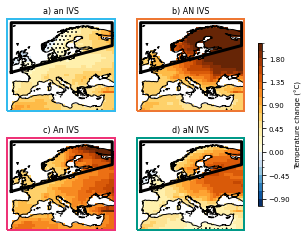

In [132]:
nbins = 21
_diff_contour = .5
cmap_params = {'vmin': -1., 'vmax': 1.}
if story.ndrivers == 1:
    n_row=1; n_col=2
elif story.ndrivers == 2:
    n_row=2; n_col=2
elif story.ndrivers == 3:
    n_row=3; n_col=3
##figsize = (n_col*15, n_row*10)
figsize = (extended_width, 100*mm) # (double_column_width, n_row*75*mm)

for field_data, _norm in [[field_ano_raw, 'raw']]:
    for _field in field_ref:
        if _field == 'tas':

            _da_field = field_data[_field].sel(lat=slice(zone[2]-1, zone[3]+1), lon=slice(zone[0]-1, zone[1]+1))

            if _norm == 'std':
                cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\Delta$'; replace_out = '$\\tilde{\\Delta}$'
            else:
                if _field == 'tas':
                    cmap_params = {'vmin': -1., 'vmax': 2.}
                elif _field in ('pr', 'prsn', 'prlq'):
                    cmap_params = {'vmin': -.5, 'vmax': .5, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                elif _field in ('sfcWind'):
                    cmap_params = {'vmin': -.25, 'vmax': .25, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                else:
                    cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\tilde{\\Delta}$'; replace_out = '$\\Delta$'
            cmap_loc = ccmp.get_diverging_cmap(**cmap_params)

            fig, ax = plt.subplots(n_row, n_col, figsize = figsize, subplot_kw = dict(projection=ccrs.PlateCarree())) #, gridspec_kw={'width_ratios': [3, 1]})
            fig.subplots_adjust(hspace=0.2,wspace=0.2)

            for iS, _sto in enumerate(story.stories):
                _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_da_field.member.values)))
                _tmp = _da_field.sel(member=_story_members).weighted(da_weight.sel(member=_story_members))

                if story.ndrivers == 1:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0]; _sfl = 0
                    elif iS == 1:
                        _plot_shape = False; _ax = ax[1]; _sfl = 1
                elif story.ndrivers == 2:
                    if iS == 0:
                        #_plot_shape = False; _ax = ax[0,1]; _sfl = 1
                        _plot_shape = False; _ax = ax[0,1]; _sfl = 1
                    elif iS == 1:
                        #_plot_shape = False; _ax = ax[1,1]; _sfl = 3
                        _plot_shape = False; _ax = ax[1,0]; _sfl = 2
                    elif iS == 2:
                        #_plot_shape = True; _ax = ax[0,0]; _sfl = 0
                        _plot_shape = False; _ax = ax[1,1]; _sfl = 3
                    elif iS == 3:
                        #_plot_shape = False; _ax = ax[1,0]; _sfl = 2
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 0
                elif story.ndrivers == 3:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 1
                    elif iS < 4:
                        _plot_shape = False; _ax = ax[iS//n_col, iS%n_col]; _sfl = iS
                    elif iS >= 4:
                        _plot_shape = False; _ax = ax[(iS+1)//n_col, (iS+1)%n_col]; _sfl = iS
                    ax[1,1].axis('off')

                _ax.coastlines()
                _ax.set_extent(zone)
                cs = cc.maplot(
                    _tmp.mean(dim='member'),
                    significance=field_sto_diff_signi.get(_field).sel(story=story.stories[iS]),
                    #significance=(field_sto_diff_signi.get(_field).sel(story=story.stories[iS]), significance_limit, '....', None),
                    ax = _ax, cmap = cmap_loc, zmin=cmap_params['vmin'], zmax=cmap_params['vmax'], nbins=nbins, plotmode='raster', hide_ax_labels=True)
                ###_ax.set_title(subfigure_label[_sfl]+_sto.replace(replace_in, replace_out), fontsize=8)
                _ax.set_title(subfigure_label[_sfl]+_sto+' IVS', fontsize=8)
                _ax.spines['geo'].set(edgecolor=story.colors[iS], linewidth=2)

                if show_box is not None:
                    for _region in show_box:
                        if _region in ['FRA']:
                            shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
                        else:
                            shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                        bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = _ax, color='k', linestyle='-', linewidth=3, zorder=None, disp_name= False if len(show_box) == 1 else True)

            fig.colorbar(cs, ax=ax, label='Temperature change (°C)', orientation='vertical', fraction=.05, shrink=.75, aspect=40, extend = 'neither')

            plt.savefig(figDir+saveName+'-maps_'+_field+'_'+_norm+'_story_signi_to_ref_raster'+figExt,transparent=True)
            plt.show()

## Figure 6

In [133]:
_ylabel = {
    'tas': '$\Delta{T}$',
    'snc': '$\Delta{snowcover}$',
    'prsn': '$\Delta{S}$',
    'prlq': '$\Delta{R}$',
    'pr': '$\Delta{P}$',
    'sfcWind': '$\Delta{wind}$',
    'rsds': '$\Delta{solar}$'
}
_ylabel

{'tas': '$\\Delta{T}$',
 'snc': '$\\Delta{snowcover}$',
 'prsn': '$\\Delta{S}$',
 'prlq': '$\\Delta{R}$',
 'pr': '$\\Delta{P}$',
 'sfcWind': '$\\Delta{wind}$',
 'rsds': '$\\Delta{solar}$'}

In [134]:
import math

_region = 'NEU'
_variable = 'tas'

fig, ax = plt.subplots(3, 2, figsize = (double_column_width, 210*mm), # (extended_width, 170*mm), #
                       sharex=True, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
for i, _target in enumerate(['snc_NEU_land', 'prsn_NEU_land', 'prlq_NEU_land', 'pr_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land']):
    _ax=ax[i//2, i%2]
    if i%2 == 1:
        _ax.yaxis.set_label_position('right')
        _ax.yaxis.tick_right()
    if _variable+'_' not in _target and _region in _target:
        _Y = main_target_ano.get(_target)
        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
        _da_weight = da_weight.sel(member=_Y.member)
        _ax.plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                    ms = 13, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
        if len(experiments) != 1:
            for _experiment in experiments:
                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                _ax.plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                            label=experiment_labels[_experiment], mec='w', zorder=5)
        for iS, _sto in enumerate(story.families):
            for _model in members_dict.keys():
                _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                _ax.scatter(_X.sel(member=_story_members_model),
                            _Y.sel(member=_story_members_model),
                            s = 7, c = story.colors[iS], marker = model_markers[_model])
                _ax.plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                            ms = 12, marker = 'X', c = story.colors[iS], ls='', mec='w', zorder=5) # , label=story.stories[iS]
                ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                        ax=_ax, n_std=2., edgecolor=story.colors[iS])
        _ax.set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change', fontsize=7)
        xMin, xMax = _ax.get_xlim(); _ax.set_xlim(xMin, xMax); yMin, yMax = _ax.get_ylim(); xMin2, xMax2 = _ax.get_xlim(); _ax.set_xlim(xMin2, xMax2)
        if xMin < 0. and xMax > 0.:
            _ax.axvline(x=0, color='k', lw=.5)
        if yMin < 0. and yMax > 0.:
            _ax.axhline(y=0, color='k', lw=.5)
        if i//2 == 2:
            _ax.set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
        #_ax.set_ylabel(cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' '+anomaly_name+' ('+_Y.attrs['units']+')')
        _ax.set_ylabel(_ylabel[_target.split('_')[0]]+' ('+_Y.attrs['units']+')')

        p = np.poly1d(np.polyfit(_X, _Y, 1))
        print(_target, p)
        if _target == 'snc_NEU_land':
            _ax.plot(np.linspace(xMin2, xMax2, 100), p(np.linspace(xMin2, xMax2, 100)), 'k-', zorder=0) # 'k--'
lgd = ax[0,0].legend(loc='lower left', fontsize=5)
ax[0,0].add_artist(lgd)
lgd_sto = ax[0,0].legend(handles = story_legend_cross, loc='upper right', fontsize=5)
ax[0,0].add_artist(lgd_sto)

plt.savefig(figDir+saveName+'-tas_physical_consistency'+figExt,transparent=True)

snc_NEU_land  
-3.211 x - 0.6513
prsn_NEU_land  
-0.8972 x + 1.054
prlq_NEU_land  
9.816 x + 1.46
pr_NEU_land  
3.117 x + 1.352
sfcWind_NEU_land  
0.6057 x + 0.6935
rsds_NEU_land  
-0.9653 x + 0.9344


In [135]:
'''
import math

_region = 'NEU'
_variable = 'tas'

fig, ax = plt.subplots(3, 1, figsize = (single_column_width, 270*mm),
                        sharex=True, sharey=False)
for i, _target in enumerate(['snc_NEU_land', 'prsn_NEU_land', 'pr_NEU_land']):
    ax[i]=ax[i]
    if _variable+'_' not in _target and _region in _target:
        _Y = main_target_ano.get(_target)
        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
        _da_weight = da_weight.sel(member=_Y.member)
        ax[i].plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                    ms = 15, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
        if len(experiments) != 1:
            for _experiment in experiments:
                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                ax[i].plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                            label=experiment_labels[_experiment], mec='w', zorder=5)
        for iS, _sto in enumerate(story.families):
            for _model in members_dict.keys():
                _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                ax[i].scatter(_X.sel(member=_story_members_model),
                            _Y.sel(member=_story_members_model),
                            s = 7, c = story.colors[iS], marker = model_markers[_model])
                ax[i].plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                            ms = 12, marker = 'X', c = story.colors[iS], label=story.stories[iS], ls='', mec='w', zorder=5)
                ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                        ax=ax[i], n_std=2., edgecolor=story.colors[iS])
        ax[i].set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change')
        xMin, xMax = ax[i].get_xlim(); ax[i].set_xlim(xMin, xMax); yMin, yMax = ax[i].get_ylim(); xMin2, xMax2 = ax[i].get_xlim(); ax[i].set_xlim(xMin2, xMax2)
        if xMin < 0. and xMax > 0.:
            ax[i].axvline(x=0, color='k', lw=.5)
        if yMin < 0. and yMax > 0.:
            ax[i].axhline(y=0, color='k', lw=.5)
        ax[i].set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
        ax[i].set_ylabel(cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' '+anomaly_name+' ('+_Y.attrs['units']+')')

        p = np.poly1d(np.polyfit(_X, _Y, 1))
        print(_target, p)
        if _target == 'snc_NEU_land':
            ax[i].plot(np.linspace(xMin2, xMax2, 100), p(np.linspace(xMin2, xMax2, 100)), 'k-', zorder=0) # 'k--'
ax[0].legend(loc='lower left', fontsize=6)

#plt.savefig(figDir+saveName+'-tas_physical_consistency'+figExt,transparent=True)
'''

"\nimport math\n\n_region = 'NEU'\n_variable = 'tas'\n\nfig, ax = plt.subplots(3, 1, figsize = (single_column_width, 270*mm),\n                        sharex=True, sharey=False)\nfor i, _target in enumerate(['snc_NEU_land', 'prsn_NEU_land', 'pr_NEU_land']):\n    ax[i]=ax[i]\n    if _variable+'_' not in _target and _region in _target:\n        _Y = main_target_ano.get(_target)\n        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)\n        _da_weight = da_weight.sel(member=_Y.member)\n        ax[i].plot(hnp.mean(_X, weights=_da_weight), hnp.mean(_Y, weights=_da_weight), ls='',\n                    ms = 15, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)\n        if len(experiments) != 1:\n            for _experiment in experiments:\n                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]\n                ax[i].plot(hnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(memb

/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v

snc_NEU_land  
-3.211 x - 0.6513


/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v

prsn_NEU_land  
-0.8972 x + 1.054


/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.1.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_323971/4064439223.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


pr_NEU_land  
3.117 x + 1.352


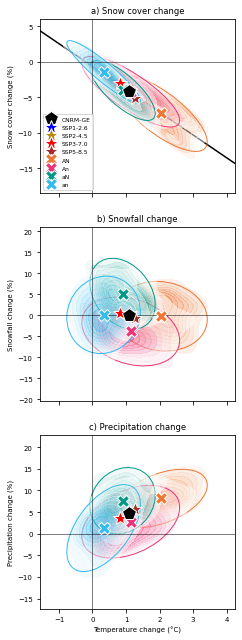

In [136]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

_region = 'NEU'
_variable = 'tas'
_n_levels = 10

fig, ax = plt.subplots(3, 1, figsize = (single_column_width, 270*mm),
                        sharex=True, sharey=False)
for i, _target in enumerate(['snc_NEU_land', 'prsn_NEU_land', 'pr_NEU_land']):
    ax[i]=ax[i]
    if _variable+'_' not in _target and _region in _target:
        _Y = main_target_ano.get(_target)
        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
        _da_weight = da_weight.sel(member=_Y.member)
        ax[i].plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                    ms = 15, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
        if len(experiments) != 1:
            for _experiment in experiments:
                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                ax[i].plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                            label=experiment_labels[_experiment], mec='w', zorder=5)
        for iS, _sto in enumerate(story.families):
            for _model in members_dict.keys():
                _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                #ax[i].scatter(_X.sel(member=_story_members_model),
                #            _Y.sel(member=_story_members_model),
                #            s = 7, c = story.colors[iS], marker = model_markers[_model])
                _df = pd.DataFrame(
                    np.array([_X.sel(member=_story_members_model),_Y.sel(member=_story_members_model)]).T,
                    columns=[_variable, _target])
                sns.kdeplot(
                    _df, x=_variable, y=_target,
                    ax=ax[i], levels=_n_levels, thresh=.1, #label=_sto,
                    alpha=.5,shade=True, shade_lowest=False,
                    cmap=get_gradient_color_map('#FFFFFF', story.colors[iS], _n_levels),
                )

                ax[i].plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                            ms = 12, marker = 'X', c = story.colors[iS], label=story.stories[iS], ls='', mec='w', zorder=5)
                ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                        ax=ax[i], n_std=2., edgecolor=story.colors[iS])
        ax[i].set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change')
        xMin, xMax = ax[i].get_xlim(); ax[i].set_xlim(xMin, xMax); yMin, yMax = ax[i].get_ylim(); xMin2, xMax2 = ax[i].get_xlim(); ax[i].set_xlim(xMin2, xMax2)
        if xMin < 0. and xMax > 0.:
            ax[i].axvline(x=0, color='k', lw=.5)
        if yMin < 0. and yMax > 0.:
            ax[i].axhline(y=0, color='k', lw=.5)
        ax[i].set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
        ax[i].set_ylabel(cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' '+anomaly_name+' ('+_Y.attrs['units']+')')

        p = np.poly1d(np.polyfit(_X, _Y, 1))
        print(_target, p)
        if _target == 'snc_NEU_land':
            ax[i].plot(np.linspace(xMin2, xMax2, 100), p(np.linspace(xMin2, xMax2, 100)), 'k-', zorder=0) # 'k--'
ax[0].legend(loc='lower left', fontsize=6)

plt.savefig(figDir+saveName+'-tas_physical_consistency_kde'+figExt,transparent=True)

## Figure 7

tas_NEU_land
   CNRM-GE  170 [ 135 —  220], +0.9 [+0.8 — +1.1]
        AN 1731 [ 832 — 3833], +2.2 [+1.9 — +2.5]
        an   73 [  50 —  108], +0.3 [+0.0 — +0.6]



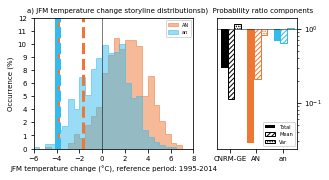

In [137]:
p_test = 0.1 # 0.01 0.02
distrib_fit = None # 'normal'

#p_test = 0.02; distrib_fit = None
p_test = 0.02; distrib_fit = 'normal'
#p_test = 0.02; distrib_fit = 'skew-normal'
#p_test = 0.02; distrib_fit = 'gev'

hatches = (None, '/////', '.....')
_colors = ['black'] + ['#EE7733', '#33BBEE']

#for _target in intann_ref:
for _target in ['tas_NEU_land']:
    print(_target)
    _relative = True if relative and _target.split('_')[0] in cc.cmip6.relative_variables else False

    _bins_per_unit = 2
    _range = (-6., 8.); _nbins = int((_range[1]-_range[0]) * _bins_per_unit)

    ###fig, ax = plt.subplots(1, 3, figsize=(15, 7))
    #fig, ax = plt.subplots(1, 2, figsize=(12, 7), width_ratios=(2, 1))
    fig, ax = plt.subplots(1, 2, figsize=(extended_width, 60*mm), width_ratios=(2, 1)) # (double_column_width, 90*mm)
    
    ax[0].axvline(x=0, ls='-', c='k', lw=.5)
    #'''
    #fig.suptitle(temporality+' temperature anomaly storyline distributions', fontsize=15)
    ax[0].set_title(subfigure_label[0]+temporality+' temperature change storyline distributions', fontsize=7)
    ax[0].set_xlabel(temporality+' temperature change (°C), reference period: '+refStr+'-'+refEnd)
    ax[0].set_ylabel('Occurrence (%)')
    ax[0].tick_params(axis='both', which='major')

    ax[0].set_xlim(_range); ax[0].set_ylim((0.0, 7.0/_nbins)) # 10.0/_nbins
    ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=_nbins/(_range[1]-_range[0]), decimals=0, symbol=0))
    ax[0].locator_params(axis='y', nbins=10)
    _xlims= ax[0].get_xlim(); _ylims= ax[0].get_ylim()
    #'''
    
    ax[1].set_title(subfigure_label[1]+' Probability ratio components', fontsize=7)
    ax[1].axhline(y=1., lw=.5, c='k'); ax[1].set_yscale('log')
    ax[1].set_xticks(np.arange(3)+1./3.)
    ax[1].set_xticklabels(['CNRM-GE', 'AN', 'an'])
    ax[1].yaxis.set_label_position('right')
    ax[1].yaxis.tick_right()
    ###ax[2].axhline(y=0., lw=.5, c='k'); ax[2].axhline(y=1., lw=.5, c='r', ls='--')
    iS=0
    for i, _ens in enumerate(['CNRM-GE', 'AN', 'an']):
        _members = dict_of_members[_ens]
        _da_intann_ref = intann_ref[_target].sel(member=_members).stack(sample=('member', 'time'))
        _da_intann_int = intann_int[_target].sel(member=_members).stack(sample=('member', 'time'))
        _da_weight_ref = da_weight.expand_dims({'time': intann_ref[_target].time}).stack(sample=('member', 'time')).sel(sample=_da_intann_ref.sample)
        _da_weight_int = da_weight.expand_dims({'time': intann_int[_target].time}).stack(sample=('member', 'time')).sel(sample=_da_intann_int.sample)
        _new_p, _delta_intensity = compare_extreme_events(
            _da_intann_ref,
            _da_intann_int,
            p=p_test, distrib_fit=distrib_fit, relative=_relative,
            weights_x = _da_weight_ref, weights_y = _da_weight_int)
        if bootstrap:
            _new_p_boot_list, _delta_intensity_boot_list = list(), list()
            for iB in range(1, n_boot+1):
                _new_p_boot, _delta_intensity_boot = compare_extreme_events(
                    intann_boot[_target+'_'+_ens+'_ref'].sel(boot=iB),
                    intann_boot[_target+'_'+_ens+'_int'].sel(boot=iB),
                    p=p_test, distrib_fit=distrib_fit, relative=_relative)
                _new_p_boot_list.append(_new_p_boot); _delta_intensity_boot_list.append(_delta_intensity_boot)
            print('{:>10}'.format(_ens),
                  #'{0:.2f}'.format(_new_p),
                  '{:4d}'.format(round(1./_new_p)),
                  '[{:4d}'.format(round(1./np.quantile(_new_p_boot_list, int_high)))+' — '+'{:4d}],'.format(round(1./np.quantile(_new_p_boot_list, int_low))),
                  '{0:+.1f}'.format(_delta_intensity),
                  '[{0:+.1f}'.format(np.quantile(_delta_intensity_boot_list, int_low))+' — '+'{0:+.1f}]'.format(np.quantile(_delta_intensity_boot_list, int_high)))
        else:
            print('{:>10}'.format(_ens),
                  #'{0:.2f}'.format(_new_p),
                  '{:4d}'.format(round(1./_new_p)),
                  '{0:+.1f}'.format(_delta_intensity))
        _pr, _r = probability_ratio_percentile(
            _da_intann_ref,
            _da_intann_int,
            p=p_test, distrib_fit=distrib_fit,
            weights_x = _da_weight_ref, weights_y = _da_weight_int)
        if _ens == ensemble_name[0]:
            c='k'; iS+=1
        else:
            #c=story.colors[i-iS]
            c = _colors[i]
        #if _ens not in ('An', 'aN'): #in (ensemble_name[0], 'AN', 'an'):
        if _ens not in (ensemble_name[0], 'An', 'aN'):
            _x = list()
            for _intann in (_da_intann_ref.weighted(_da_weight_ref), _da_intann_int.weighted(_da_weight_int)):
                if True: # 'normal'
                    _x.append(scipy.stats.norm.ppf(p_test, loc=_intann.mean(), scale=_intann.std()))
                else:
                    _x.append(np.quantile(_intann.values, p_test))
            ax[0].axvline(x=_x[0], color=c, lw=3)
            ax[0].hist(_da_intann_int, weights=_da_weight_int,
                       density=True, bins=_nbins, range=_range,
                       histtype='stepfilled', alpha=0.5, color=c, # alpha=0.25
                       edgecolor=c, label=_ens)
            ax[0].axvline(x=_x[1], color=c, lw=3, ls='--')
        _labels = ('Total', 'Mean', 'Var') if i == 0 else (None, None, None)
        for j in range(3):
            _c, _fill, _hatch = (c, True, None) if j == 0 else ('w', False, hatches[j])
            ax[1].stairs([_pr[j]], [i+j/4,i+(j+1)/4], baseline=1.,
                         fill=_fill, color=_c, hatch=_hatch, ec=c, label=_labels[j])
        #ax[1].stairs(_pr[j], i+np.arange(4)/4, baseline=1., fill=True, color=c, label=_ens)
        ###ax[2].stairs(_r, i+np.arange(3)/3, baseline=0., fill=True, color=c, label=_ens)
    ax[0].legend(fontsize=5); ax[1].legend(loc='lower right', fontsize=5)
    plt.savefig(figDir+saveName+'-'+_target+'_analog_distribution_probability_ratio.pdf', transparent=True)
    print()

## Figure 9

In [138]:
ccmp = reload(ccmp)

begin = time.time()

width=.5

target_mu = dict(); target_std = dict()
target_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()
target_ssp = xr.Dataset(); target_beta = dict()
target_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()
target_iv = xr.Dataset(); target_nu =dict()

fig, ax = plt.subplots(1, 7, figsize=(extended_width, 60*mm), sharey = True) # (double_column_width,75*mm)

for i, _target in enumerate([
    'tas_NEU_land',
    'pr_NEU_land',
    'prlq_NEU_land',
    'prsn_NEU_land',
    'snc_NEU_land',
    'sfcWind_NEU_land',
    'rsds_NEU_land',
    ]):
    _tmp = target_ano[_target]
    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))
    #print(_conf_factor)

    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')
    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member')

    _avg = list()
    for _model in model:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _model in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model})
            - target_mu[_target])
    target_alpha[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _experiment in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment})
            - target_mu[_target])
    target_beta[_target] = xr.concat(_avg, dim='experiment_id')

    _avg = list()
    for _sto in story.stories:
        _da_target = _tmp.sel(member=[_member for _member in story.families[_sto]['label'] if _member in _tmp.member.values]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'storyline':_sto})
            - target_mu[_target])
    target_sigma[_target] = xr.concat(_avg, dim='storyline')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _experiment in experiments:
            if _experiment in members_dict[_model]:
                _members = [_member for _member in _tmp.member.values if _model+'_'+_experiment in _member]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _model_list.append(
                    _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment})
                    - target_alpha[_target].sel(source_id=_model)
                    - target_beta[_target].sel(experiment_id=_experiment)
                    + target_mu[_target])
            else:
                _model_list.append(xr.full_like(target_mu[_target], np.nan).assign_coords({'source_id':_model, 'experiment_id':_experiment}))
        _avg.append(xr.concat(_model_list, dim='experiment_id'))
    target_gamma[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _model in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _model_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'storyline':_sto})
                - target_alpha[_target].sel(source_id=_model)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_model_list, dim='storyline'))
    target_delta[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _expe_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _experiment in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _expe_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment, 'storyline':_sto})
                - target_beta[_target].sel(experiment_id=_experiment)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_expe_list, dim='storyline'))
    target_epsilon[_target] = xr.concat(_avg, dim='experiment_id')

    _tmp_member = list(main_target_ano[_target].member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _res = list(); _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _members = [_member for _member in story.families[_sto]['label'] if _model+'_'+_experiment in _member and _member in _tmp.member.values]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _res.append(_da_target - _da_target.weighted(_da_weight).mean(dim='member'))
                _inter_expe.append(_da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
                                   - target_alpha[_target].sel(source_id=_model)
                                   - target_beta[_target].sel(experiment_id=_experiment)
                                   - target_gamma[_target].sel(source_id=_model, experiment_id=_experiment)
                                   - target_delta[_target].sel(source_id=_model, storyline=_sto)
                                   - target_epsilon[_target].sel(experiment_id=_experiment, storyline=_sto)
                                   - target_sigma[_target].sel(storyline=_sto)
                                   - target_mu[_target])
                #_inter_expe[-1] = _inter_expe[-1].assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
            _inter_model.append(xr.concat(_inter_expe, dim='storyline'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_zeta[_target] = xr.concat(_inter, dim='source_id')
    target_nu[_target] = xr.concat(_res, dim='member').sortby('member')

    _da_weight = da_weight.sel(member=_tmp.member).sortby('member')

    _var_tot = (
        target_nu[_target].weighted(_da_weight).var(dim='member')
        + target_alpha[_target].var(dim='source_id')
        + target_beta[_target].var(dim='experiment_id')
        + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        + target_delta[_target].var(dim=('source_id', 'storyline'))
        + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        + target_sigma[_target].var(dim='storyline')
    )
    _total_uncertainty = _conf_factor*(_var_tot)**.5
    _total_uncertainty = _conf_factor*target_std[_target]
    _snr = target_mu[_target] / _total_uncertainty

    target_iv = target_iv.assign({_target: xr.DataArray((
            target_nu[_target].weighted(_da_weight).var(dim='member')
        ) / _var_tot)})
    target_model = target_model.assign({_target: xr.DataArray((
            target_alpha[_target].var(dim='source_id')
            + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
            #+ target_delta[_target].var(dim=('source_id', 'storyline'))
            #+ target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})
    target_ssp = target_ssp.assign({_target: xr.DataArray((
            target_beta[_target].var(dim='experiment_id')
            #+ target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        ) / _var_tot)})
    target_story = target_story.assign({_target: xr.DataArray((
            target_sigma[_target].var(dim='storyline')
            + target_delta[_target].var(dim=('source_id', 'storyline'))
            + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
            + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})

    print(
        _target,'\n',
        'SNR: {0:.2f},'.format(_snr.values),
        'forced response: {0:.2f},'.format(target_mu[_target].values),
        'total uncertainty: {0:.2f}'.format(_total_uncertainty.values),
        '(storyline: {0:.0f}%,'.format(100.*target_story[_target].values),
        'uncaptured internal variability: {0:.0f}%,'.format(100.*target_iv[_target].values),
        'model: {0:.0f}%,'.format(100.*target_model[_target].values),
        'scenario: {0:.0f}%).'.format(100.*target_ssp[_target].values),
    )
    import matplotlib.patches
    _boxlow = 0.
    _ax = ax if len(main_target_ano) == 1 else ax[i]
    for _src, _clr, _htc, _edc in [
        [target_model[_target], 'blue', None, None],
        [target_ssp[_target], 'green', None, None],
        [target_story[_target], 'orange', '///', 'red'],
        [target_iv[_target], 'orange', None, None]
    ]:
        _boxhigh = _boxlow + 100.*_src.values
        _ax.add_patch(matplotlib.patches.Rectangle(
            (0, _boxlow), width, _boxhigh-_boxlow,
            facecolor = _clr, hatch = _htc, edgecolor = _edc))
        _boxlow = _boxhigh
    _ax.set_xlim(0., width)
    _ax.set_ylim(0., 100)
    _ax.set_xticks([width/2.])
    ##_ax.set_xticklabels([r'$\Delta$'+'$'+target_dict[_target]+'$'])
    #_ax.set_xticklabels([_xlabel])
    ##_ax.set_xticklabels(['d\ns'.join(cc.cmip6.name_dict[_target.split('_')[0]].capitalize().split('d s'))+'\n'+anomaly_name], fontsize=6)
    _ax.set_xticklabels([_ylabel[_target.split('_')[0]]])

ax[0].set_ylabel('Percentage (%)')

#ax[-1].axis('off')
ax[-1].legend(
    [
        Patch(facecolor='green', edgecolor=None),
        Patch(facecolor='orange', edgecolor=None),
        Patch(facecolor='orange', hatch='///', edgecolor='red'),
    ],
    ['SSP', 'Internal\nvariability', 'IVS'],
    loc='upper right', fontsize=5, ncol=3,
)
fig.suptitle('Fractional contribution to total uncertainty')

plt.savefig(figDir+saveName+'-explained_variance_IVS'+figExt)

tas_NEU_land 
 SNR: 0.75, forced response: 1.08, total uncertainty: 1.45 (storyline: 54%, uncaptured internal variability: 43%, model: 0%, scenario: 3%).
pr_NEU_land 
 SNR: 0.56, forced response: 4.73, total uncertainty: 8.45 (storyline: 40%, uncaptured internal variability: 58%, model: 0%, scenario: 2%).
prlq_NEU_land 
 SNR: 0.70, forced response: 12.09, total uncertainty: 17.36 (storyline: 47%, uncaptured internal variability: 47%, model: 0%, scenario: 6%).
prsn_NEU_land 
 SNR: 0.01, forced response: 0.08, total uncertainty: 8.68 (storyline: 39%, uncaptured internal variability: 60%, model: 0%, scenario: 1%).
snc_NEU_land 
 SNR: -0.79, forced response: -4.13, total uncertainty: 5.21 (storyline: 49%, uncaptured internal variability: 45%, model: 0%, scenario: 6%).
sfcWind_NEU_land 
 SNR: 0.25, forced response: 1.35, total uncertainty: 5.34 (storyline: 51%, uncaptured internal variability: 48%, model: 0%, scenario: 1%).
rsds_NEU_land 
 SNR: -0.05, forced response: -0.11, total uncertain

In [139]:
'''
ccmp = reload(ccmp)

begin = time.time()

width=.5

target_mu = dict(); target_std = dict()
target_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()
target_ssp = xr.Dataset(); target_beta = dict()
target_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()
target_iv = xr.Dataset(); target_nu =dict()

fig, ax = plt.subplots(1, 3, figsize=(single_column_width,75*mm), sharey = True)

for i, (_target, _xlabel) in enumerate([['tas_NEU_land', 'Temperature\nchange'], ['pr_NEU_land', 'Precipitation\nchange']]):
    _tmp = target_ano[_target]
    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))
    #print(_conf_factor)

    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')
    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member')

    _avg = list()
    for _model in model:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _model in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model})
            - target_mu[_target])
    target_alpha[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _experiment in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment})
            - target_mu[_target])
    target_beta[_target] = xr.concat(_avg, dim='experiment_id')

    _avg = list()
    for _sto in story.stories:
        _da_target = _tmp.sel(member=[_member for _member in story.families[_sto]['label'] if _member in _tmp.member.values]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'storyline':_sto})
            - target_mu[_target])
    target_sigma[_target] = xr.concat(_avg, dim='storyline')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _experiment in experiments:
            if _experiment in members_dict[_model]:
                _members = [_member for _member in _tmp.member.values if _model+'_'+_experiment in _member]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _model_list.append(
                    _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment})
                    - target_alpha[_target].sel(source_id=_model)
                    - target_beta[_target].sel(experiment_id=_experiment)
                    + target_mu[_target])
            else:
                _model_list.append(xr.full_like(target_mu[_target], np.nan).assign_coords({'source_id':_model, 'experiment_id':_experiment}))
        _avg.append(xr.concat(_model_list, dim='experiment_id'))
    target_gamma[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _model in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _model_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'storyline':_sto})
                - target_alpha[_target].sel(source_id=_model)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_model_list, dim='storyline'))
    target_delta[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _expe_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _experiment in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _expe_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment, 'storyline':_sto})
                - target_beta[_target].sel(experiment_id=_experiment)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_expe_list, dim='storyline'))
    target_epsilon[_target] = xr.concat(_avg, dim='experiment_id')

    _tmp_member = list(main_target_ano[_target].member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _res = list(); _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _members = [_member for _member in story.families[_sto]['label'] if _model+'_'+_experiment in _member and _member in _tmp.member.values]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _res.append(_da_target - _da_target.weighted(_da_weight).mean(dim='member'))
                _inter_expe.append(_da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
                                   - target_alpha[_target].sel(source_id=_model)
                                   - target_beta[_target].sel(experiment_id=_experiment)
                                   - target_gamma[_target].sel(source_id=_model, experiment_id=_experiment)
                                   - target_delta[_target].sel(source_id=_model, storyline=_sto)
                                   - target_epsilon[_target].sel(experiment_id=_experiment, storyline=_sto)
                                   - target_sigma[_target].sel(storyline=_sto)
                                   - target_mu[_target])
                #_inter_expe[-1] = _inter_expe[-1].assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
            _inter_model.append(xr.concat(_inter_expe, dim='storyline'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_zeta[_target] = xr.concat(_inter, dim='source_id')
    target_nu[_target] = xr.concat(_res, dim='member').sortby('member')

    _da_weight = da_weight.sel(member=_tmp.member).sortby('member')

    _var_tot = (
        target_nu[_target].weighted(_da_weight).var(dim='member')
        + target_alpha[_target].var(dim='source_id')
        + target_beta[_target].var(dim='experiment_id')
        + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        + target_delta[_target].var(dim=('source_id', 'storyline'))
        + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        + target_sigma[_target].var(dim='storyline')
    )
    _total_uncertainty = _conf_factor*(_var_tot)**.5
    _total_uncertainty = _conf_factor*target_std[_target]
    _snr = target_mu[_target] / _total_uncertainty

    target_iv = target_iv.assign({_target: xr.DataArray((
            target_nu[_target].weighted(_da_weight).var(dim='member')
        ) / _var_tot)})
    target_model = target_model.assign({_target: xr.DataArray((
            target_alpha[_target].var(dim='source_id')
            + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
            #+ target_delta[_target].var(dim=('source_id', 'storyline'))
            #+ target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})
    target_ssp = target_ssp.assign({_target: xr.DataArray((
            target_beta[_target].var(dim='experiment_id')
            #+ target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        ) / _var_tot)})
    target_story = target_story.assign({_target: xr.DataArray((
            target_sigma[_target].var(dim='storyline')
            + target_delta[_target].var(dim=('source_id', 'storyline'))
            + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
            + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})

    print(
        _target,'\n',
        'SNR: {0:.2f},'.format(_snr.values),
        'forced response: {0:.2f},'.format(target_mu[_target].values),
        'total uncertainty: {0:.2f}'.format(_total_uncertainty.values),
        '(storyline: {0:.0f}%,'.format(100.*target_story[_target].values),
        'uncaptured internal variability: {0:.0f}%,'.format(100.*target_iv[_target].values),
        'model: {0:.0f}%,'.format(100.*target_model[_target].values),
        'scenario: {0:.0f}%).'.format(100.*target_ssp[_target].values),
    )
    import matplotlib.patches
    _boxlow = 0.
    _ax = ax if len(main_target_ano) == 1 else ax[i]
    for _src, _clr, _htc, _edc in [
        [target_model[_target], 'blue', None, None],
        [target_ssp[_target], 'green', None, None],
        [target_story[_target], 'orange', '///', 'red'],
        [target_iv[_target], 'orange', None, None]
    ]:
        _boxhigh = _boxlow + 100.*_src.values
        _ax.add_patch(matplotlib.patches.Rectangle(
            (0, _boxlow), width, _boxhigh-_boxlow,
            facecolor = _clr, hatch = _htc, edgecolor = _edc))
        _boxlow = _boxhigh
    _ax.set_xlim(0., width)
    _ax.set_ylim(0., 100)
    _ax.set_xticks([width/2.])
    ##_ax.set_xticklabels([r'$\Delta$'+'$'+target_dict[_target]+'$'])
    _ax.set_xticklabels([_xlabel])
ax[0].set_ylabel('Percentage (%)')

ax[2].axis('off')
ax[2].legend(
    [
        Patch(facecolor='green', edgecolor=None),
        Patch(facecolor='orange', hatch='///', edgecolor='red'),
        Patch(facecolor='orange', edgecolor=None)
    ],
    ['SSP', 'Internal\nvariability\nstoryline', 'Remaining\ninternal\nvariability'],
    loc='lower left'
)
fig.suptitle('Fractional contribution to total uncertainty')

plt.savefig(figDir+saveName+'-explained_variance_IVS'+figExt)
'''

"\nhmp = reload(hmp)\n\nbegin = time.time()\n\nwidth=.5\n\ntarget_mu = dict(); target_std = dict()\ntarget_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()\ntarget_ssp = xr.Dataset(); target_beta = dict()\ntarget_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()\ntarget_iv = xr.Dataset(); target_nu =dict()\n\nfig, ax = plt.subplots(1, 3, figsize=(single_column_width,75*mm), sharey = True)\n\nfor i, (_target, _xlabel) in enumerate([['tas_NEU_land', 'Temperature\nchange'], ['pr_NEU_land', 'Precipitation\nchange']]):\n    _tmp = target_ano[_target]\n    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))\n    #print(_conf_factor)\n\n    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')\n    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member

In [140]:
print('My work is done.')

My work is done.


## Suppementary

### Figure 2

NAO
AMOC


/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Python/LocalPackages/himation/himation/chiton/plot.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWa

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


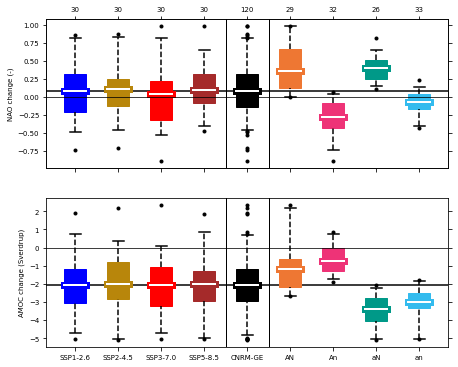

In [141]:

fig, ax = plt.subplots(2, 1, figsize = (double_column_width, 150*mm), sharex=True)

#for iD, _driver in enumerate(driver_ano):
for iD, _driver in enumerate(['NAO', 'AMOC']):
    print(_driver)

    _data = driver_ano[_driver]

    _members = list(_data.member.values); _members.sort(); _data.sortby('member')
    _members_dict = cc.cmip6.get_members_dict(_members)

    model_data = {_model: [] for _model in _members_dict}
    experiment_data = {_experiment: [] for _experiment in experiments}
    experiment_data_weights = {_experiment: [] for _experiment in experiments}

    for iM, _model in enumerate(_members_dict):
        for i, _experiment in enumerate(experiments):
            if _experiment in _members_dict[_model].keys():
                for _member in _members_dict[_model][_experiment]:
                    experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                    experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
    
    tick_positions = list(); tick_labels = list()
    for iE, _experiment in enumerate(experiments):
        ccplt.boxplot(
            [experiment_data[_experiment]],
            weights = [experiment_data_weights[_experiment]],
            color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
            dx=iE, width = 0.5,
            ax = ax[iD])
        tick_positions.append(iE)
        tick_labels.append(len(experiment_data[_experiment]))
    ax[iD].yaxis.set_ticks_position('both')
    ax[iD].axhline(y=0,color='k',lw=.5)
    ax[iD].set_xticks(np.arange(len(experiments))+.5-0.5)
    ax[iD].set_xticklabels([experiment_labels[_experiment] for _experiment in experiments], rotation=0)

    tick_positions.append(len(experiments))
    tick_labels.append(len(_data.member))

    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
        ccplt.boxplot(
            [_data.sel(member=_story_members)],
            weights = [da_weight.sel(member=_story_members)],
            color = [story.colors[iS]],
            bar = bp_median_mean, box = bp_box, ext = bp_ext,
            dx=len(experiments)+1+iS, width = 0.5,
            ax = ax[iD])
        tick_positions.append(len(experiments)+1+iS)
        tick_labels.append(len(_story_members))
    ccplt.boxplot(
        [_data], weights = [da_weight.sel(member=_members)],
        bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(experiments), width = 0.5,
        ax = ax[iD])
    ax[iD].axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

    ax[iD].yaxis.set_ticks_position('both')
    ax[iD].axhline(y=0,color='k',lw=.5)
    ax[iD].set_xticks(np.arange(len(experiments)+1+len(story.stories))+.5-0.5)
    #ax[iD].set_xticklabels(
    #    [cc.cmip6.experiment_dict[_experiment]['name'] for _experiment in experiments]+ensemble_name+[_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story.labels],
    #    rotation=90)
    ax[iD].set_xticklabels([cc.cmip6.experiment_dict[_experiment]['name'] for _experiment in experiments]+ensemble_name+story.stories)
    _unit = _data.attrs['units'] if _data.attrs['units'] != '' else '-'
    ax[iD].set_ylabel(_driver+' '+anomaly_name+' ('+_unit+')')
    for i in range(2):
        ax[iD].axvline(x=len(experiments)+i-0.5,color='k',lw=1)
        #ax.plot((len(model)+i-0.5)*np.ones(8), np.arange(-0.5, 3.5, 0.5), 'k+')
ax2 = ax[0].twiny()
ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
plt.savefig(figDir+saveName+'-AMOC_NAO_boxplot_SSP_story.pdf', transparent=True)

In [142]:
import math
if paper:
    _region = 'NEU'
    _variable = 'tas'

    fig, ax = plt.subplots(1, 2, figsize = (double_column_width, 75*mm),
                           sharex=True, sharey=False)
    for i, _target in enumerate(['sfcWind_NEU_land', 'rsds_NEU_land']):
        ax[i]=ax[i]
        if _variable+'_' not in _target and _region in _target:
            _Y = main_target_ano.get(_target)
            _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
            _da_weight = da_weight.sel(member=_Y.member)
            ax[i].plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                       ms = 15, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
            if len(experiments) != 1:
                for _experiment in experiments:
                    _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                    ax[i].plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                               ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                               ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                               label=experiment_labels[_experiment], mec='w', zorder=5)
            for iS, _sto in enumerate(story.families):
                for _model in members_dict.keys():
                    _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                    ax[i].scatter(_X.sel(member=_story_members_model),
                                _Y.sel(member=_story_members_model),
                                s = 7, c = story.colors[iS], marker = model_markers[_model])
                    ax[i].plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                               ms = 12, marker = 'X', c = story.colors[iS], label=story.stories[iS], ls='', mec='w', zorder=5)
                    ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                            ax=ax[i], n_std=2., edgecolor=story.colors[iS])
            ax[i].set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change')
            xMin, xMax = ax[i].get_xlim(); ax[i].set_xlim(xMin, xMax); yMin, yMax = ax[i].get_ylim(); xMin2, xMax2 = ax[i].get_xlim(); ax[i].set_xlim(xMin2, xMax2)
            if xMin < 0. and xMax > 0.:
                ax[i].axvline(x=0, color='k', lw=.5)
            if yMin < 0. and yMax > 0.:
                ax[i].axhline(y=0, color='k', lw=.5)
            ax[i].set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
            ax[i].set_ylabel(cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' '+anomaly_name+' ('+_Y.attrs['units']+')')

    ax[-1].legend(loc='upper right', fontsize=5)

    plt.savefig(figDir+saveName+'-tas_physical_consistency_SI'+figExt,transparent=True)

NameError: name 'paper' is not defined

In [ ]:
print("My work is done.")

In [ ]:
stop

# Tests de sensibilité

In [ ]:
# Test méthode : normalisation des données
ccivs = reload(ccivs)

story_ref = ccivs.storylines(prints=True, delta=r'$\Delta$')
story_tst = ccivs.storylines(prints=True, delta=r'$\tilde{\Delta}$')
for _driver in main_driver_ano.data_vars:
    story_ref.add_driver(driver_ano.get(_driver))
    story_tst.add_driver(driver_ano_std.get(_driver))
for _target in main_target_ano:
    story_ref.add_target(target_ano.get(_target))
    story_tst.add_target(target_ano_std.get(_target))
story_ref.add_weights(da_weight); story_tst.add_weights(da_weight)
story_ref.build_storylines(); story_tst.build_storylines()

print()
interception = list()
for iS, _sto in enumerate(story_ref.stories):
    interception.append(len(list(set(story_ref.families[_sto]['label']).intersection(set(story_tst.families[_sto]['label'])))))

print('Unstandardised storylines: '+str(sum(interception))+' members in common in the storyline classification ({0:.1f}%'.format(sum(interception)/(len(members))*100)+' of '+str(len(members))+')')

if len(drivers) == 2:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    for _model in members_dict.keys():
        for _experiment in members_dict[_model].keys():
            sc = plt.scatter(driver_ano.get(list(driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
                             driver_ano.get(list(driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]),
                             c = experiment_colors[_experiment],
                             marker = model_markers[_model], vmin=-2.5, vmax=2.5, zorder=1001)
    for i in range(len(story_tst.stories)):
        sc = plt.scatter(driver_ano.get(list(driver_ano.data_vars)[0]).sel(member=story_tst.families[story_tst.stories[i]]['label']),
                         driver_ano.get(list(driver_ano.data_vars)[1]).sel(member=story_tst.families[story_tst.stories[i]]['label']),
                         c = story_tst.colors[i], label = story_tst.labels[i],
                         marker = 'o', vmin=-2.5, vmax=2.5, zorder=1002)
    story_ref.plot_quadrants(show_members=False, show_stories=False)
    lgd = ax.legend(fontsize=12); ax.add_artist(lgd)
    if len(model) != 1:
        lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
        ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-quadrants_std_unstd.pdf', transparent=True)

for _target in main_target_ano:
    _members = target_ano.get(_target).member.values
    fig, ax = plt.subplots(figsize = (10,10))
    ccplt.boxplot([target_ano.get(_target).sel(member=list(set(story_ref.families[story_ref.stories[i]]['label']).intersection(set(_members)))) for i in range(len(story_ref.stories))],
                 weights = [da_weight.sel(member=list(set(story_ref.families[story_ref.stories[i]]['label']).intersection(set(_members)))) for i in range(len(story_ref.stories))],
                 color = story_ref.colors,
                 label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_ref.labels],
                 bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = -0.25, width = 0.25)
    ccplt.boxplot([target_ano.get(_target).sel(member=list(set(story_tst.families[story_tst.stories[i]]['label']).intersection(set(_members)))) for i in range(len(story_tst.stories))],
                 weights = [da_weight.sel(member=list(set(story_tst.families[story_tst.stories[i]]['label']).intersection(set(_members)))) for i in range(len(story_tst.stories))],
                 color = story_tst.colors, hatch = ['//' for _ in range(len(story_tst.stories))],
                 label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_tst.labels],
                 bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = 0.25, width = 0.25)
    ax.axhline(y=ccnp.mean(target_ano.get(_target), weights=da_weight.sel(member=_members)),color='k')
    ax.axhline(y=0,color='k',lw=.5)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_std_unstd.pdf', transparent=True)

ccscp = reload(ccscp)
ds_signi_unstd = xr.Dataset()
for _target in target_ano:
    print(_target)
    _signi_store1 = list()
    for iR, _sto_R in enumerate(story_ref.stories):
        _signi_store2 = list()
        for iT, _sto_T in enumerate(story_tst.stories):
            _sub_ref = target_ano.get(_target).sel(member=story_ref.families[_sto_R]['label'])
            _sub_test = target_ano.get(_target).sel(member=story_tst.families[_sto_T]['label'])
            _wei_ref = da_weight.sel(member=story_ref.families[_sto_R]['label'])
            _wei_test = da_weight.sel(member=story_tst.families[_sto_T]['label'])
            if iR == iT:
                print(_sto_R, _sto_T, ':', ccnp.mean(_sub_ref, weights=_wei_ref) - ccnp.mean(_sub_test, weights=_wei_test))
            _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                  ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
        _signi_store1.append(_signi_store2)

    ds_signi_unstd = ds_signi_unstd.assign(
        {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                                dims=['test', 'Std', 'Unstd'],
                                coords={'test': ['T-test', 'F-test'], 'Std':story_ref.labels, 'Unstd':story_tst.labels})})

for _target in ds_signi_unstd:
    print(_target)
    for _test in ds_signi_unstd.test:
        print('Null hypothesis: '+h0[str(_test.values)])
        display(ds_signi_unstd.get(_target).sel(test=_test).to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))





In [ ]:
# Test méthode : retirer les membres dont les anomalies des pilotes sont proches de la réponse forcée
ccivs = reload(ccivs)

story_ref = ccivs.storylines(prints=True, delta=delta_print)
story_tst = ccivs.storylines(prints=True, delta=delta_print, exclusion=.5)
for _driver in main_driver_ano.data_vars:
    story_ref.add_driver(main_driver_ano.get(_driver))
    story_tst.add_driver(main_driver_ano.get(_driver))
for _target in main_target_ano:
    story_ref.add_target(main_target_ano.get(_target))
    story_tst.add_target(main_target_ano.get(_target))
story_ref.add_weights(da_weight); story_tst.add_weights(da_weight)
story_ref.build_storylines(); story_tst.build_storylines()

print()
interception = list()
for iS, _sto in enumerate(story_ref.stories):
    interception.append(len(list(set(story_ref.families[_sto]['label']).intersection(set(story_tst.families[_sto]['label'])))))

print('Storylines without forced-response-close members: '+str(sum(interception))+' members in common in the storyline classification ({0:.1f}%'.format(sum(interception)/(len(members))*100)+' of '+str(len(members))+')')

if len(drivers) == 2:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax.set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
    for _model in members_dict.keys():
        for _experiment in members_dict[_model].keys():
            sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=members_dict[_model][_experiment]),
                             main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=members_dict[_model][_experiment]),
                             c = experiment_colors[_experiment],
                             marker = model_markers[_model], vmin=-2.5, vmax=2.5, zorder=1001)
    for i in range(len(story_tst.stories)):
        sc = plt.scatter(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=story_tst.families[story_tst.stories[i]]['label']),
                         main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=story_tst.families[story_tst.stories[i]]['label']),
                         c = story_tst.colors[i], label = story_tst.labels[i],
                         marker = 'o', vmin=-2.5, vmax=2.5, zorder=1002)
    story_tst.plot_quadrants(show_members=False, show_stories=False)
    lgd = ax.legend(fontsize=12); ax.add_artist(lgd)
    if len(model) != 1:
        lgd = ax.legend(handles = model_legend_point, fontsize=12, loc='upper right')
        ax.add_artist(lgd)
    lgd = ax.legend(handles = experiment_legend_point, fontsize=12, loc='lower left')
    ax.add_artist(lgd)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-quadrants_with_without_inner.pdf', transparent=True)

for _target in main_target_ano:
    ### add second x axis with number of members per storyline
    fig, ax = plt.subplots(figsize = (10,10))
    ccplt.boxplot([target_ano.get(_target).sel(member=story_ref.families[story_ref.stories[i]]['label']) for i in range(len(story_ref.stories))],
                 weights = [da_weight.sel(member=story_ref.families[story_ref.stories[i]]['label']) for i in range(len(story_ref.stories))],
                 color = story_ref.colors,
                 label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_ref.labels],
                 bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = -0.25, width = 0.25)
    ccplt.boxplot([target_ano.get(_target).sel(member=story_tst.families[story_tst.stories[i]]['label']) for i in range(len(story_tst.stories))],
                 weights = [da_weight.sel(member=story_tst.families[story_tst.stories[i]]['label']) for i in range(len(story_tst.stories))],
                 color = story_tst.colors, hatch = ['//' for _ in range(len(story_tst.stories))],
                 label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_tst.labels],
                 bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = 0.25, width = 0.25)
    ax.axhline(y=ccnp.mean(target_ano.get(_target), weights=da_weight),color='k')
    ax.axhline(y=0,color='k',lw=.5)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_with_without_inner.pdf', transparent=True)

ccscp = reload(ccscp)
ds_signi_unstd = xr.Dataset()
for _target in target_ano:
    print(_target)
    _signi_store1 = list()
    for iR, _sto_R in enumerate(story_ref.stories):
        _signi_store2 = list()
        for iT, _sto_T in enumerate(story_tst.stories):
            _sub_ref = target_ano.get(_target).sel(member=story_ref.families[_sto_R]['label'])
            _sub_test = target_ano.get(_target).sel(member=story_tst.families[_sto_T]['label'])
            _wei_ref = da_weight.sel(member=story_ref.families[_sto_R]['label'])
            _wei_test = da_weight.sel(member=story_tst.families[_sto_T]['label'])
            if iR == iT:
                print(_sto_R, _sto_T, ':', ccnp.mean(_sub_ref, weights=_wei_ref) - ccnp.mean(_sub_test, weights=_wei_test))
            _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                  ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
        _signi_store1.append(_signi_store2)

    ds_signi_unstd = ds_signi_unstd.assign(
        {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                                dims=['test', 'Std', 'Unstd'],
                                coords={'test': ['T-test', 'F-test'], 'Std':story_ref.labels, 'Unstd':story_tst.labels})})

for _target in ds_signi_unstd:
    print(_target)
    for _test in ds_signi_unstd.test:
        print('Null hypothesis: '+h0[str(_test.values)])
        display(ds_signi_unstd.get(_target).sel(test=_test).to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))





In [ ]:
story.outputs.index

In [ ]:
# Test méthode : pondération des membres
if len(model) != 1 and weighting_method is not None: # and normalisation_method != 'std':

    ccivs = reload(ccivs)

    story_ref = ccivs.storylines(prints=True, delta=delta_print)
    story_tst = ccivs.storylines(prints=True, delta=delta_print)
    for _driver in main_driver_ano.data_vars:
        story_ref.add_driver(main_driver_ano.get(_driver))
        story_tst.add_driver(main_driver_ano.get(_driver))
    for _target in main_target_ano:
        story_ref.add_target(main_target_ano.get(_target))
        story_tst.add_target(main_target_ano.get(_target))
    story_ref.add_weights(xr.ones_like(main_driver_ano.member, dtype='float').sortby('member')); story_tst.add_weights(da_weight)
    story_ref.build_storylines(); story_tst.build_storylines()

    print()
    interception = list()
    for iS, _sto in enumerate(story_ref.stories):
        interception.append(len(list(set(story_ref.families[_sto]['label']).intersection(set(story_tst.families[_sto]['label'])))))

    print('Storylines without weighting: '+str(sum(interception))+' members in common in the storyline classification ({0:.1f}%'.format(sum(interception)/(len(members))*100)+' of '+str(len(members))+')')

    for _target in main_target_ano:
        fig, ax = plt.subplots(figsize = (10,10))
        ccplt.boxplot([main_target_ano.get(_target).sel(member=story_ref.families[story_ref.stories[i]]['label']) for i in range(len(story_ref.stories))],
                     weights = [da_weight.sel(member=story_ref.families[story_ref.stories[i]]['label']) for i in range(len(story_ref.stories))],
                     color = story_ref.colors,
                     label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_ref.labels],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = -0.25, width = 0.25)
        ccplt.boxplot([main_target_ano.get(_target).sel(member=story_tst.families[story_tst.stories[i]]['label']) for i in range(len(story_tst.stories))],
                     weights = [da_weight.sel(member=story_tst.families[story_tst.stories[i]]['label']) for i in range(len(story_tst.stories))],
                     color = story_tst.colors, hatch = ['//' for _ in range(len(story_tst.stories))],
                     label = [_sto.replace('\\tilde{\Delta}', '\Delta').replace(' ', '\n') for _sto in story_tst.labels],
                     bar = bp_median_mean, box = bp_box, ext = bp_ext, dx = 0.25, width = 0.25)
        ax.axhline(y=ccnp.mean(main_target_ano.get(_target), weights=da_weight),color='k')
        ax.axhline(y=0,color='k',lw=.5)
        ax.yaxis.set_ticks_position('both')
        plt.savefig(figDir+saveName+'-'+_target+'_boxplot_story_with_without_weight.pdf', transparent=True)

    ccscp = reload(ccscp)
    ds_signi_unstd = xr.Dataset()
    for _target in main_target_ano:
        print(_target)
        _signi_store1 = list()
        for iR, _sto_R in enumerate(story_ref.stories):
            _signi_store2 = list()
            for iT, _sto_T in enumerate(story_tst.stories):
                _sub_ref = main_target_ano.get(_target).sel(member=story_ref.families[_sto_R]['label'])
                _sub_test = main_target_ano.get(_target).sel(member=story_tst.families[_sto_T]['label'])
                _wei_ref = da_weight.sel(member=story_ref.families[_sto_R]['label'])
                _wei_test = da_weight.sel(member=story_tst.families[_sto_T]['label'])
                if iR == iT:
                    print(_sto_R, _sto_T, ':', ccnp.mean(_sub_ref, weights=_wei_ref) - ccnp.mean(_sub_test, weights=_wei_test))
                _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue,
                                      ccscp.ftest_ind(_sub_ref, _sub_test, weights = [_wei_ref, _wei_test]).pvalue])
            _signi_store1.append(_signi_store2)

        ds_signi_unstd = ds_signi_unstd.assign(
            {_target:xr.DataArray(np.array(_signi_store1).transpose(),
                                    dims=['test', 'Std', 'Unstd'],
                                    coords={'test': ['T-test', 'F-test'], 'Std':story_ref.labels, 'Unstd':story_tst.labels})})

    for _target in ds_signi_unstd:
        print(_target)
        for _test in ds_signi_unstd.test:
            print('Null hypothesis: '+h0[str(_test.values)])
            display(ds_signi_unstd.get(_target).sel(test=_test).to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))





In [ ]:
##### Test de la longueur des périodes

### TO-DO LIST
# - proposer les stats par modèle ?
# - avec et sans standardisation

period_length_max = 25
exp_var_store = np.zeros([len(target_data), len(driver_data)+1, period_length_max])
print(exp_var_store.shape)
story_mean_store = np.zeros([len(target_data), 2**len(driver_data)+1, period_length_max, 3])
print(story_mean_store.shape)

for i, _per in enumerate(np.arange(0, period_length_max)):
    print(_per)
    tp_driver_ano = dict()
    _anomaly = 'forcing' if anomaly == 'mixed' else anomaly
    _anomaly = 'internal variability' if anomaly == 'super internal variability' else anomaly
    for _driver in driver_data:
        #print(_driver)
        _data = driver_data.get(_driver)
        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)
        list_ano_std = list()
        for _model in list(_members_dict.keys()):
            #print(_model)
            list_ano = list()
            for _experiment in list(_members_dict[_model].keys()):
                #print(_experiment)
                list_ano.append(cctim.get_anomalies(
                    out_print=False,
                    data=_data.sel(member = _members_dict[_model][_experiment]),
                    n_max=_n_max, calcul=_anomaly, relative=relative,
                    start_year=str(int(refEnd)-_per), period_length=_per+1, period_gap=0, ref_start_year=str(int(refEnd)-_per)))
            _tmp = xr.concat(list_ano, dim='member')
            if normalisation_method == 'std':
                _tmp = (_tmp - _tmp.mean('member')) / _tmp.std('member')
            list_ano_std.append(_tmp)
        tmp_ano = xr.concat(list_ano_std, dim='member')
        tp_driver_ano[_driver] = tmp_ano.sortby('member')
    story_tp = ccivs.storylines(prints=False, delta=delta_print)
    for _driver in tp_driver_ano.keys():
        story_tp.add_driver(tp_driver_ano[_driver])
    story_tp.add_weights(da_weight)
    story_tp.build_storylines()
    _anomaly = 'internal variability' if anomaly == 'mixed' else anomaly
    for iT, _target in enumerate(target_data):
        #print(_target)
        _data = target_data.get(_target)
        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)
        list_ano_std = list()
        for _model in list(_members_dict.keys()):
            #print(_model)
            list_ano = list()
            for _experiment in list(_members_dict[_model].keys()):
                #print(_members_dict[_model][_experiment])
                list_ano.append(cctim.get_anomalies(
                    out_print=False,
                    data=_data.sel(member = _members_dict[_model][_experiment]),
                    n_max=_n_max, calcul=_anomaly, relative=relative,
                    start_year=str(int(refEnd)-_per), period_length=_per+1, period_gap=0, ref_start_year=str(int(refEnd)-_per)))
            _tmp = xr.concat(list_ano, dim='member')
            if normalisation_method == 'std':
                _tmp = (_tmp - _tmp.mean('member')) / _tmp.std('member')
            list_ano_std.append(_tmp)

        _data = xr.concat(list_ano_std, dim='member').sortby('member')
        _members = list(_data.member.values); _members.sort(); _data.sortby('member')
        _members_dict = cc.cmip6.get_members_dict(_members)

        exp_var_tot = explained_variance(
            [tp_driver_ano[_driver].sel(member=_members).sortby('member').values for _driver in tp_driver_ano.keys()],
            _data.sortby('member').values,
            weights = da_weight.sel(member=_members).sortby('member').values)
        #print(exp_var_tot)
        exp_var_store[iT, :, i] = exp_var_tot

        story_mean_store[iT, -1, i, 1] = ccnp.mean(_data, weights = da_weight.sel(member=_data.member))
        for iS, _sto in enumerate(story_tp.labels):
            _story_members = list(set(story_tp.families[story_tp.stories[iS]]['label']).intersection(set(_members)))
            story_mean_store[iT, iS, i, 1] = ccnp.mean(_data.sel(member=_story_members), weights = da_weight.sel(member=_story_members))
            story_mean_store[iT, iS, i, 0] = ccnp.quantile(_data.sel(member=_story_members), bp_box/100, weights = da_weight.sel(member=_story_members))
            story_mean_store[iT, iS, i, 2] = ccnp.quantile(_data.sel(member=_story_members), 1-bp_box/100, weights = da_weight.sel(member=_story_members))
            #ccplt.boxplot([_data.sel(member=_story_members)],
            #             weights = [da_weight.sel(member=_story_members)],
        #for iS in range(len(story_tp.stories)):
        #    story_mean_store[iT, iS, i] = 

In [ ]:
figsize = (10, 10)

driver_color = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
driver_label = list(driver_data.data_vars.keys())
driver_label += [' & '.join(driver_label)]
driver_legend_curve = list()
for i, _driver in enumerate(driver_label):
    driver_legend_curve.append(mlines.Line2D([], [], color = driver_color[i], linestyle = '-', lw = 1, label = _driver))

for iT, _target in enumerate(target_ano):
    print(_target)
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xlabel('Length of the periods (in years)')
    ax.set_xlim(1, period_length_max)
    #ax.set_xticks(np.arange(1, period_length_max+1, 5))
    ax.set_ylabel('Explained variance (%)')
    ax.set_ylim(0, 75)
    for i in range(len(drivers)+1):
        #print(exp_var_store[iT, i, :])
        ax.plot(np.arange(0, period_length_max)+1, exp_var_store[iT, i, :]*100, color = driver_color[i], lw=3)
    ax.legend(handles = driver_legend_curve, fontsize=12)
    plt.savefig(figDir+saveName+'-'+_target+'_expvar_periods'+str(period_length_max)+'.pdf', transparent=True)

    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xlabel('Length of the periods (in years)')
    ax.set_xlim(1, period_length_max)
    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    if normalisation_method == 'std':
        ax.set_ylim([-2.0, 2.0])
        ax.set_yticks([-1, 0, 1]) # [-2, -1, 0, 1, 2]
        ax.set_yticklabels(['$\mu-\sigma$', '$\mu$', '$\mu+\sigma$']) # ['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$']
    else:
        ax.set_ylabel(target_ano[_target].attrs['units'])
        ax.plot(np.arange(0, period_length_max)+1, story_mean_store[iT, -1, :, 1], color = 'k', label='Forced response', lw=3)
    for iS, _sto in enumerate(story_tp.labels):
        ax.plot(np.arange(0, period_length_max)+1, story_mean_store[iT, iS, :, 1], color = story_tp.colors[iS], label=_sto, lw=3)
        ax.fill_between(np.arange(0, period_length_max)+1, story_mean_store[iT, iS, :, 0], story_mean_store[iT, iS, :, 2], color = story_tp.colors[iS], alpha=0.25)
    ax.legend(fontsize=12)
    plt.savefig(figDir+saveName+'-'+_target+'_stories_periods'+str(period_length_max)+'.pdf', transparent=True)




In [ ]:
figsize = (10, 10)

driver_color = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
driver_linestyle = ['-', '-.', '--']
driver_label = list(driver_data.data_vars.keys())
driver_label += [' & '.join(driver_label)]
driver_legend_curve = list()
for i, _driver in enumerate(driver_label):
    driver_legend_curve.append(mlines.Line2D([], [], color = driver_color[i], linestyle = '-', lw = 3, label = _driver))

for iT, _target in enumerate(target_ano):
    print(_target)
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xlabel('Lag-time of the drivers (in years)')
    #ax.set_xlim(0, lag_time_max)
    ax.set_xlim(-lag_time_max+1, 0)
    ax.set_ylabel('Explained variance (%)')
    ax.set_ylim(0, 75)
    for i in range(len(drivers)+1):
        #ax.plot(np.arange(0, lag_time_max)+1, exp_var_store[iT, i, ::]*100, color = driver_color[i], lw=3)
        ax.plot(np.arange(-lag_time_max, 0)+1, exp_var_store[iT, i, ::-1]*100, color = driver_color[i], lw=3)
        print(-np.argmax(exp_var_store[iT, i, :]))
        #ax.axvline(x=-np.argmax(exp_var_store[iT, i, :]), color = driver_color[i], lw=3, ls=driver_linestyle[i])
        ax.plot(-np.argmax(exp_var_store[iT, i, :]), np.max(exp_var_store[iT, i, :])*100., color = driver_color[i], marker='o', markersize=12)
    ax.legend(handles = driver_legend_curve, fontsize=12)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-'+_target+'_expvar_lag'+str(lag_time_max)+'.pdf', transparent=True)

    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xlabel('Lag-time of the drivers (in years)')
    #ax.set_xlim(0, lag_time_max)
    ax.set_xlim(-lag_time_max+1, 0)
    ax.yaxis.set_ticks_position('both')
    ax.axhline(y=0,color='k',lw=.5)
    if normalisation_method == 'std':
        ax.set_ylim([-2.0, 2.0])
        ax.set_yticks([-1, 0, 1]) # [-2, -1, 0, 1, 2]
        ax.set_yticklabels(['$\mu-\sigma$', '$\mu$', '$\mu+\sigma$']) # ['$\mu-2\sigma$', '$\mu-\sigma$', '$\mu$', '$\mu+\sigma$', '$\mu+2\sigma$']
    else:
        ax.set_ylabel(target_ano[_target].attrs['units'])
        #ax.plot(np.arange(0, lag_time_max)+1, story_mean_store[iT, -1, :, 1], color = 'k', label='Forced response', lw=3)
        ax.plot(np.arange(-lag_time_max, 0)+1, story_mean_store[iT, -1, ::-1, 1], color = 'k', label='Forced response', lw=3)
    for iS, _sto in enumerate(story_tp.labels):
        #ax.plot(np.arange(0, lag_time_max)+1, story_mean_store[iT, iS, :, 1], color = story_tp.colors[iS], label=_sto, lw=3)
        ax.plot(np.arange(-lag_time_max, 0)+1, story_mean_store[iT, iS, ::-1, 1], color = story_tp.colors[iS], label=_sto, lw=3)
        #ax.fill_between(np.arange(0, lag_time_max)+1, story_mean_store[iT, iS, :, 0], story_mean_store[iT, iS, :, 2], color = story_tp.colors[iS], alpha=0.25)
        ax.fill_between(np.arange(-lag_time_max, 0)+1, story_mean_store[iT, iS, ::-1, 0], story_mean_store[iT, iS, ::-1, 2], color = story_tp.colors[iS], alpha=0.25)
    ax.legend(fontsize=12)
    ax.yaxis.set_ticks_position('both')
    plt.savefig(figDir+saveName+'-'+_target+'_stories_lag'+str(lag_time_max)+'.pdf', transparent=True)